# 🔧 Projekt: Interpretowalne Modele ML dla Finansów

## 1. Setup i Instalacja Bibliotek

In [4]:
import subprocess
import sys

def install_package(package_name, import_name=None):
    """
    Sprawdza czy biblioteka jest zainstalowana, jeśli nie - instaluje ją.
    
    Args:
        package_name: nazwa pakietu do instalacji (np. 'xgboost')
        import_name: nazwa do importu (jeśli inna niż package_name, np. 'sklearn' dla 'scikit-learn')
    """
    if import_name is None:
        import_name = package_name
    
    try:
        __import__(import_name)
        print(f"✅ {package_name} już zainstalowany")
        return True
    except ImportError:
        print(f"⚠️  {package_name} nie znaleziony. Instaluję...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name, "-q"])
            print(f"✅ {package_name} zainstalowany pomyślnie")
            return True
        except subprocess.CalledProcessError:
            print(f"❌ Błąd instalacji {package_name}")
            return False

# Lista wymaganych bibliotek
required_packages = [
    ('xgboost', 'xgboost'),
    ('imbalanced-learn', 'imblearn'),
    ('shap', 'shap'),
    ('scikit-learn', 'sklearn'),
    ('matplotlib', 'matplotlib'),
    ('seaborn', 'seaborn')
]

print("="*70)
print("🔍 SPRAWDZANIE I INSTALACJA WYMAGANYCH BIBLIOTEK")
print("="*70)

all_installed = True
for package_name, import_name in required_packages:
    if not install_package(package_name, import_name):
        all_installed = False

print("\n" + "="*70)
if all_installed:
    print("✅ Wszystkie biblioteki gotowe do użycia!")
else:
    print("⚠️  Niektóre biblioteki nie zostały zainstalowane - sprawdź błędy powyżej")
print("="*70)

🔍 SPRAWDZANIE I INSTALACJA WYMAGANYCH BIBLIOTEK
✅ xgboost już zainstalowany
✅ imbalanced-learn już zainstalowany


c:\Users\olobr\anaconda3\envs\bioSim\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ shap już zainstalowany
✅ scikit-learn już zainstalowany
✅ matplotlib już zainstalowany
✅ seaborn już zainstalowany

✅ Wszystkie biblioteki gotowe do użycia!


In [5]:
# Podstawowe biblioteki
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time

# Scipy
from scipy.stats.mstats import winsorize

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

# XGBoost
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    print("⚠️  xgboost not installed - uruchom komórkę instalacyjną powyżej")
    XGBOOST_AVAILABLE = False

# imbalanced-learn (SMOTE)
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    SMOTE_AVAILABLE = True
except ImportError:
    print("⚠️  imbalanced-learn not installed - uruchom komórkę instalacyjną powyżej")
    SMOTE_AVAILABLE = False

# SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("⚠️  shap not installed - uruchom komórkę instalacyjną powyżej")
    SHAP_AVAILABLE = False

# Konfiguracja
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

print("\n✅ Biblioteki załadowane")
print(f"   XGBoost: {XGBOOST_AVAILABLE}")
print(f"   SMOTE (imbalanced-learn): {SMOTE_AVAILABLE}")
print(f"   SHAP: {SHAP_AVAILABLE}")


✅ Biblioteki załadowane
   XGBoost: True
   SMOTE (imbalanced-learn): True
   SHAP: True


## 2. Wczytanie i Podział Danych

In [6]:
# Wczytanie danych
df = pd.read_csv("zbior_10.csv")
print(f"Wymiary: {df.shape}")
print(f"Klasa pozytywna: {100*df['default'].sum()/len(df):.2f}%")

# ============================================
# PODZIAŁ DANYCH: Train (60%) / Validation (20%) / Test (20%)
# ============================================
print("\n" + "="*80)
print("PODZIAŁ DANYCH - Stratified Split")
print("="*80)

# Krok 1: Oddziel X i y
X = df.drop("default", axis=1)
y = df["default"]

# Krok 2: Identyfikuj kolumny numeryczne i kategorialne
from sklearn.impute import SimpleImputer
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\n📊 Typy kolumn:")
print(f"   Numeryczne:    {len(numeric_cols)} kolumn")
print(f"   Kategorialne:  {len(categorical_cols)} kolumn")
if len(categorical_cols) > 0:
    print(f"   Kategorialne: {categorical_cols[:5]}..." if len(categorical_cols) > 5 else f"   Kategorialne: {categorical_cols}")

# Krok 3: Split Train (60%) vs Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=1, stratify=y
)

# Krok 4: Split Temp (40%) na Validation (20%) i Test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp
)

print(f"\n📊 Rozkład zbiorów:")
print(f"   Train:      {X_train.shape[0]:>6} obs ({100*len(X_train)/len(X):.1f}%)")
print(f"   Validation: {X_val.shape[0]:>6} obs ({100*len(X_val)/len(X):.1f}%)")
print(f"   Test:       {X_test.shape[0]:>6} obs ({100*len(X_test)/len(X):.1f}%)")
print(f"   TOTAL:      {len(X):>6} obs (100.0%)")

print(f"\n📊 Rozkład klasy pozytywnej (default=1):")
print(f"   Train:      {100*y_train.sum()/len(y_train):.2f}%")
print(f"   Validation: {100*y_val.sum()/len(y_val):.2f}%")
print(f"   Test:       {100*y_test.sum()/len(y_test):.2f}%")

# ============================================
# CLEANING - Usunięcie inf/-inf i NaN handling
# ============================================
print(f"\n" + "="*80)
print("DATA CLEANING (inf/-inf → NaN → median imputation)")
print("="*80)

# Sprawdź inf i NaN
print(f"\n📊 Przed czyszczeniem:")
print(f"   Train:      {X_train.isna().sum().sum():>6} NaN, {np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum():>6} inf")
print(f"   Validation: {X_val.isna().sum().sum():>6} NaN, {np.isinf(X_val.select_dtypes(include=[np.number])).sum().sum():>6} inf")
print(f"   Test:       {X_test.isna().sum().sum():>6} NaN, {np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum():>6} inf")

# Krok 1: Zamień inf/-inf na NaN (tylko kolumny numeryczne)
if len(numeric_cols) > 0:
    X_train[numeric_cols] = X_train[numeric_cols].replace([np.inf, -np.inf], np.nan)
    X_val[numeric_cols] = X_val[numeric_cols].replace([np.inf, -np.inf], np.nan)
    X_test[numeric_cols] = X_test[numeric_cols].replace([np.inf, -np.inf], np.nan)
    print(f"\n✅ inf/-inf zamienione na NaN w {len(numeric_cols)} kolumnach numerycznych")

print(f"\n📊 Po zamianie inf → NaN:")
print(f"   Train:      {X_train.isna().sum().sum():>6} NaN")
print(f"   Validation: {X_val.isna().sum().sum():>6} NaN")
print(f"   Test:       {X_test.isna().sum().sum():>6} NaN")

# Krok 2: Imputer - fit TYLKO na train (kolumny numeryczne), transform na wszystkich
if len(numeric_cols) > 0:
    imputer = SimpleImputer(strategy='median')
    imputer.fit(X_train[numeric_cols])
    
    X_train[numeric_cols] = imputer.transform(X_train[numeric_cols])
    X_val[numeric_cols] = imputer.transform(X_val[numeric_cols])
    X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])
    
    print(f"✅ Imputacja zakończona dla {len(numeric_cols)} kolumn numerycznych")

# Krok 3: Kolumny kategorialne - wypełnij NaN wartością 'UNKNOWN'
if len(categorical_cols) > 0:
    X_train[categorical_cols] = X_train[categorical_cols].fillna('UNKNOWN')
    X_val[categorical_cols] = X_val[categorical_cols].fillna('UNKNOWN')
    X_test[categorical_cols] = X_test[categorical_cols].fillna('UNKNOWN')
    print(f"✅ Kolumny kategorialne wypełnione 'UNKNOWN' ({len(categorical_cols)} kolumn)")

print(f"\n✅ Po pełnym czyszczeniu:")
print(f"   Train:      {X_train.isna().sum().sum():>6} NaN, {np.isinf(X_train.select_dtypes(include=[np.number])).sum().sum():>6} inf")
print(f"   Validation: {X_val.isna().sum().sum():>6} NaN, {np.isinf(X_val.select_dtypes(include=[np.number])).sum().sum():>6} inf")
print(f"   Test:       {X_test.isna().sum().sum():>6} NaN, {np.isinf(X_test.select_dtypes(include=[np.number])).sum().sum():>6} inf")

# ============================================
# COMBINED DATASETS - Train + Validation (80% łącznie)
# ============================================
print(f"\n" + "="*80)
print("COMBINED DATASETS (Train + Validation = 80% dla treningu modeli)")
print("="*80)

X_train_full_combined = pd.concat([X_train, X_val], axis=0)
y_train_full_combined = pd.concat([y_train, y_val], axis=0)

print(f"\n📊 Combined datasets:")
print(f"   X_train_full_combined: {X_train_full_combined.shape}")
print(f"   y_train_full_combined: {y_train_full_combined.shape}")
print(f"   Klasa pozytywna:       {100*y_train_full_combined.sum()/len(y_train_full_combined):.2f}%")

print(f"\n✅ Wszystkie datasety gotowe:")
print(f"   • X_train ({X_train.shape[0]} obs) + X_val ({X_val.shape[0]} obs) = X_train_full_combined ({X_train_full_combined.shape[0]} obs)")
print(f"   • X_test: {X_test.shape[0]} obs (niezależny zbiór testowy)")
print("="*80)

Wymiary: (3000, 220)
Klasa pozytywna: 6.10%

PODZIAŁ DANYCH - Stratified Split

📊 Typy kolumn:
   Numeryczne:    217 kolumn
   Kategorialne:  2 kolumn
   Kategorialne: ['schemat_wsk_bilans', 'schemat_wsk_rzis']

📊 Rozkład zbiorów:
   Train:        1800 obs (60.0%)
   Validation:    600 obs (20.0%)
   Test:          600 obs (20.0%)
   TOTAL:        3000 obs (100.0%)

📊 Rozkład klasy pozytywnej (default=1):
   Train:      6.11%
   Validation: 6.00%
   Test:       6.17%

DATA CLEANING (inf/-inf → NaN → median imputation)

📊 Przed czyszczeniem:
   Train:       12545 NaN,    618 inf
   Validation:   4169 NaN,    187 inf
   Test:         4191 NaN,    209 inf

✅ inf/-inf zamienione na NaN w 217 kolumnach numerycznych

📊 Po zamianie inf → NaN:
   Train:       13163 NaN
   Validation:   4356 NaN
   Test:         4400 NaN
✅ Imputacja zakończona dla 217 kolumn numerycznych
✅ Kolumny kategorialne wypełnione 'UNKNOWN' (2 kolumn)

✅ Po pełnym czyszczeniu:
   Train:           0 NaN,      0 inf
   Val

## 2.5. EDA - Analiza Surowych Danych (przed preprocessing)

**Cel:** Zrozumienie danych przed transformacjami Box-Cox, winsoryzacją, standaryzacją itp.

📊 EDA - SUROWE DANE (przed Full Pipeline preprocessing)

1️⃣  KORELACJA MIĘDZY CECHAMI - Surowe dane (przed preprocessing)

📊 Liczba cech numerycznych: 217
📋 Macierz korelacji: 217 × 217
📋 Zakres wartości: [-1.000, 1.000]

⚠️  Znaleziono 654 par cech o wysokiej korelacji (|r| > 0.7):
   + wsk_ROS                             ↔ wsk_rent_sprzedazy                  r = +1.000
   + wsk_zysk_op_zobowiazania            ↔ wsk_zysk_operacyjny_zob_1           r = +1.000
   + wsk_koszty_przychody                ↔ wsk_poziom_kosztow_operacyjnych     r = +1.000
   + wsk_koszty_fin_przychody            ↔ wsk_poziom_kosztow_finansowych      r = +1.000
   + wsk_koszty_odsetki_przychody        ↔ wsk_zadluzenie_gotowka              r = +1.000
   + wsk_udzial_kap_wlasnego_aktywa_1    ↔ wsk_struktura_kap_wlasnego_1        r = +1.000
   + wsk_ebitda_koszty_odsetkowe_1       ↔ wsk_ebitda_zobowiazan_odsetki_1     r = +1.000
   + wsk_ebitda_koszty_odsetkowe_2       ↔ wsk_ebitda_zobowiazan_odsetki_2     r = +1

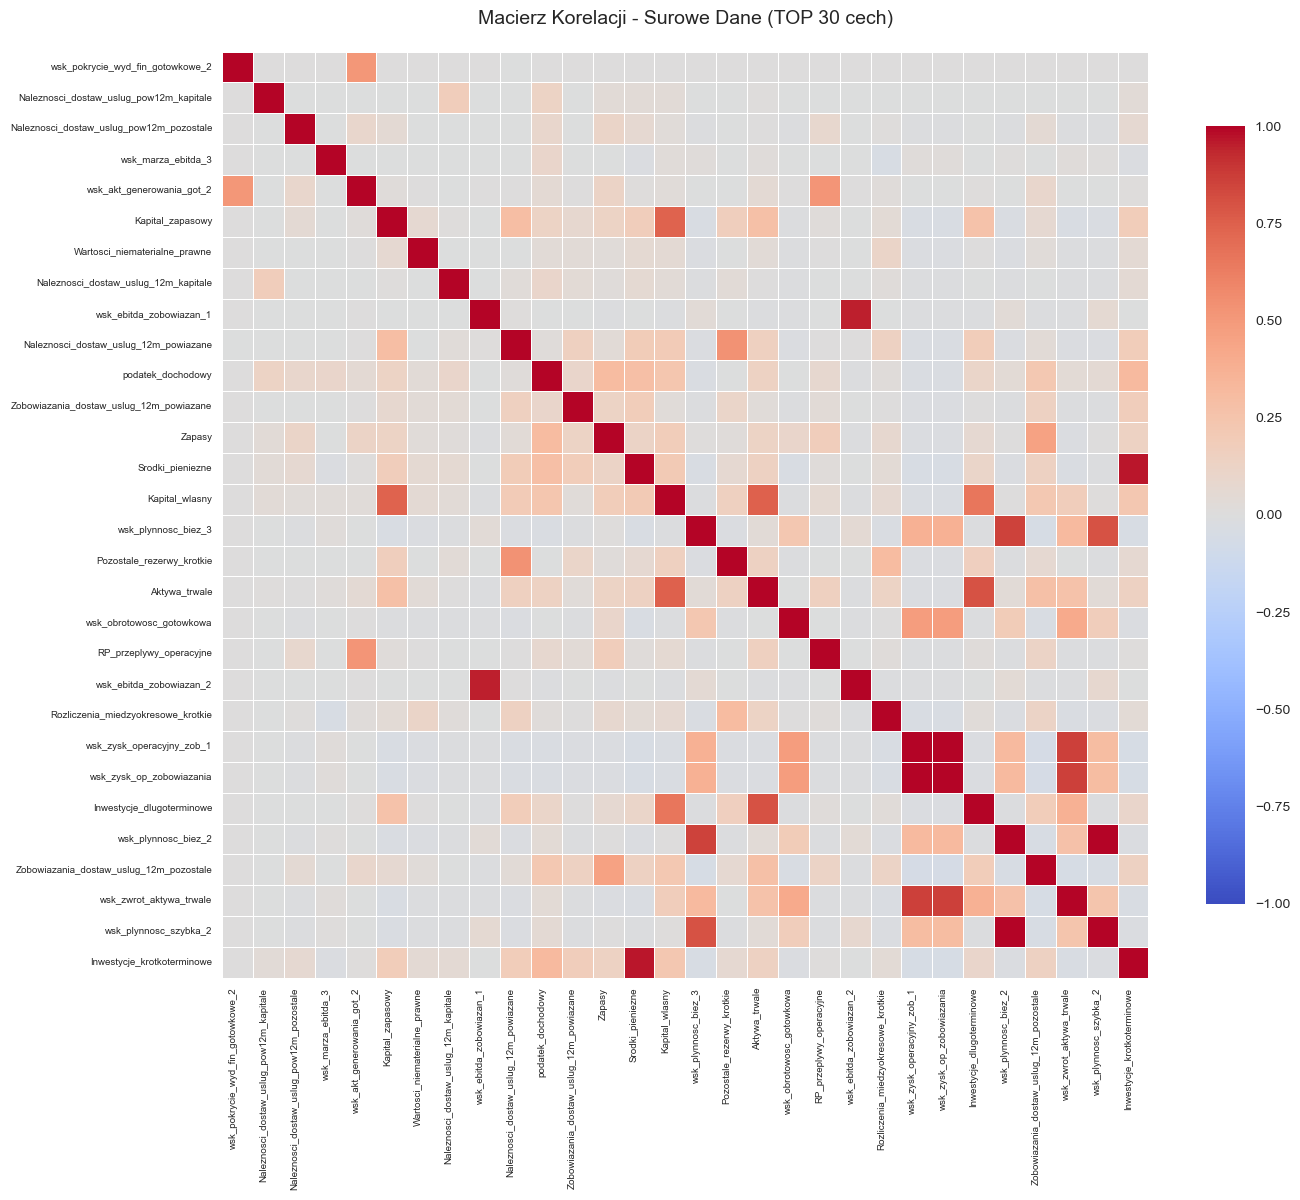

   ✅ Heatmap wygenerowana dla TOP 30 cech


2️⃣  KORELACJA Z TARGETEM - Surowe dane

📈 TOP 15 CECH najbardziej skorelowanych z ryzykiem defaultu:
Rank   Feature                                        Correlation Direction      
1      wsk_pokrycie_wyd_fin_gotowkowe_2                   -0.1234 📉 Higher = Less Risk
2      Naleznosci_dostaw_uslug_pow12m_kapitale            +0.1224 📈 Higher = More Risk
3      Naleznosci_dostaw_uslug_pow12m_pozostale           +0.1205 📈 Higher = More Risk
4      wsk_marza_ebitda_3                                 +0.0980 📈 Higher = More Risk
5      wsk_akt_generowania_got_2                          -0.0659 📉 Higher = Less Risk
6      Kapital_zapasowy                                   +0.0645 📈 Higher = More Risk
7      Wartosci_niematerialne_prawne                      +0.0643 📈 Higher = More Risk
8      Naleznosci_dostaw_uslug_12m_kapitale               +0.0572 📈 Higher = More Risk
9      wsk_ebitda_zobowiazan_1                            -0.0532 📉 Higher =

In [7]:
print("="*80)
print("📊 EDA - SUROWE DANE (przed Full Pipeline preprocessing)")
print("="*80)

# Zapisz kopię surowych danych do porównania
X_train_raw_backup = X_train.copy()
X_test_raw_backup = X_test.copy()

# ============================================================================
# 1. KORELACJA MIĘDZY CECHAMI - Surowe dane
# ============================================================================
print("\n1️⃣  KORELACJA MIĘDZY CECHAMI - Surowe dane (przed preprocessing)")
print("="*80)

# Wybierz tylko kolumny numeryczne
numeric_cols_raw = X_train_raw_backup.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n📊 Liczba cech numerycznych: {len(numeric_cols_raw)}")

# Oblicz macierz korelacji
corr_matrix_raw = X_train_raw_backup[numeric_cols_raw].corr()

print(f"📋 Macierz korelacji: {corr_matrix_raw.shape[0]} × {corr_matrix_raw.shape[1]}")
print(f"📋 Zakres wartości: [{corr_matrix_raw.min().min():.3f}, {corr_matrix_raw.max().max():.3f}]")

# Znajdź pary cech o wysokiej korelacji (>0.7)
high_corr_pairs_raw = []
for i in range(len(corr_matrix_raw.columns)):
    for j in range(i+1, len(corr_matrix_raw.columns)):
        corr_val = corr_matrix_raw.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs_raw.append((
                corr_matrix_raw.columns[i],
                corr_matrix_raw.columns[j],
                corr_val
            ))

if len(high_corr_pairs_raw) > 0:
    print(f"\n⚠️  Znaleziono {len(high_corr_pairs_raw)} par cech o wysokiej korelacji (|r| > 0.7):")
    for feat1, feat2, corr_val in sorted(high_corr_pairs_raw, key=lambda x: abs(x[2]), reverse=True)[:15]:
        direction = "+" if corr_val > 0 else "-"
        print(f"   {direction} {feat1:<35} ↔ {feat2:<35} r = {corr_val:+.3f}")
else:
    print("\n✅ Brak par cech o wysokiej korelacji (|r| > 0.7)")

# Statystyki korelacji
corr_values_raw = corr_matrix_raw.values[np.triu_indices_from(corr_matrix_raw.values, k=1)]
print(f"\n📊 Statystyki korelacji (wszystkie pary cech):")
print(f"   Średnia |r|:  {np.abs(corr_values_raw).mean():.3f}")
print(f"   Mediana |r|:  {np.median(np.abs(corr_values_raw)):.3f}")
print(f"   Max |r|:      {np.abs(corr_values_raw).max():.3f}")

# Wizualizacja macierzy korelacji (TOP 30 najbardziej skorelowanych z targetem)
print(f"\n📊 Wizualizacja macierzy korelacji (TOP 30 cech):")

# Wybierz top 30 cech według korelacji z targetem
target_corr_raw = []
for col in numeric_cols_raw:
    try:
        corr_val = X_train_raw_backup[col].corr(pd.Series(y_train.values))
        target_corr_raw.append({'Feature': col, 'Abs_Correlation': abs(corr_val)})
    except:
        target_corr_raw.append({'Feature': col, 'Abs_Correlation': 0.0})

target_corr_raw_df = pd.DataFrame(target_corr_raw).sort_values('Abs_Correlation', ascending=False)
top30_features_raw = target_corr_raw_df.head(30)['Feature'].tolist()

# Heatmap dla top 30
try:
    import seaborn as sns
except:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn", "-q"])
    import seaborn as sns

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix_raw[top30_features_raw].loc[top30_features_raw], 
            annot=False,
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Macierz Korelacji - Surowe Dane (TOP 30 cech)', fontsize=14, pad=20)
plt.xticks(rotation=90, ha='right', fontsize=7)
plt.yticks(rotation=0, fontsize=7)
plt.tight_layout()
plt.show()

print(f"   ✅ Heatmap wygenerowana dla TOP 30 cech")

# ============================================================================
# 2. KORELACJA Z TARGETEM - Surowe dane
# ============================================================================
print("\n\n2️⃣  KORELACJA Z TARGETEM - Surowe dane")
print("="*80)

print(f"\n📈 TOP 15 CECH najbardziej skorelowanych z ryzykiem defaultu:")
print(f"{'Rank':<6} {'Feature':<45} {'Correlation':>12} {'Direction':<15}")
print("="*80)

for idx, row in target_corr_raw_df.head(15).iterrows():
    rank = target_corr_raw_df.index.get_loc(idx) + 1
    # Oblicz pełną korelację (z kierunkiem)
    full_corr = X_train_raw_backup[row['Feature']].corr(pd.Series(y_train.values))
    direction = "📈 Higher = More Risk" if full_corr > 0 else "📉 Higher = Less Risk"
    print(f"{rank:<6} {row['Feature']:<45} {full_corr:>+12.4f} {direction:<15}")

print(f"\n📊 Statystyki korelacji z targetem:")
print(f"   Średnia |r|:  {target_corr_raw_df['Abs_Correlation'].mean():.4f}")
print(f"   Mediana |r|:  {target_corr_raw_df['Abs_Correlation'].median():.4f}")
print(f"   Max |r|:      {target_corr_raw_df['Abs_Correlation'].max():.4f}")

# ============================================================================
# 3. PODSUMOWANIE
# ============================================================================
print("\n\n" + "="*80)
print("📊 PODSUMOWANIE - Surowe Dane (przed preprocessing)")
print("="*80)

print(f"\n✅ WIELOKOLINEARNOŚĆ:")
print(f"   • Pary o |r| > 0.7: {len(high_corr_pairs_raw)}")
print(f"   • Średnia |r|: {np.abs(corr_values_raw).mean():.3f}")
print(f"   • Status: {'⚠️ WYSOKA wielokolinearność' if len(high_corr_pairs_raw) > 20 else '✅ Umiarkowana wielokolinearność'}")

print(f"\n✅ MOC PREDYKCYJNA:")
print(f"   • Najsilniejsza: {target_corr_raw_df.iloc[0]['Feature']} (|r| = {target_corr_raw_df.iloc[0]['Abs_Correlation']:.4f})")
print(f"   • Średnia |r|: {target_corr_raw_df['Abs_Correlation'].mean():.4f}")
print(f"   • Cechy o |r| > 0.1: {(target_corr_raw_df['Abs_Correlation'] > 0.1).sum()}/{len(target_corr_raw_df)}")

print(f"\n💡 Następny krok: Full Pipeline preprocessing (Box-Cox, winsoryzacja, standaryzacja)")

# Zapisz listę TOP 10 cech do późniejszego porównania rozkładów (w Section 5.6)
top10_features_raw = target_corr_raw_df.head(10)['Feature'].tolist()

print(f"\n📌 Zapisano TOP 10 cech do porównania rozkładów PO transformacji (Section 5.6):")
for idx, feat in enumerate(top10_features_raw, 1):
    full_corr = X_train_raw_backup[feat].corr(pd.Series(y_train.values))
    print(f"   {idx:2d}. {feat:<45} r = {full_corr:+.4f}")

print("\n" + "="*80)

In [8]:
from sklearn.metrics import average_precision_score, log_loss, brier_score_loss

def calculate_all_metrics(y_true, y_pred, y_proba):
    """
    Oblicza wszystkie wymagane metryki projektu (9 metryk).
    
    Parameters:
        y_true: rzeczywiste etykiety
        y_pred: przewidziane etykiety (0/1)
        y_proba: prawdopodobieństwa klasy pozytywnej
        
    Returns:
        dict: Słownik z 9 metrykami
    """
    # Podstawowe metryki klasyfikacyjne
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Metryki dla modeli probabilistycznych
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    
    # Kolmogorov-Smirnov statistic
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    ks_statistic = np.max(tpr - fpr)
    
    # Metryki kalibracji
    logloss = log_loss(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'ks': ks_statistic,  # POPRAWKA: zmieniono z 'ks_statistic' na 'ks'
        'log_loss': logloss,
        'brier': brier
    }

def print_model_metrics(metrics, model_name):
    """
    Wyświetla metryki modelu w sformatowany sposób.
    
    Parameters:
        metrics: słownik z metrykami (z calculate_all_metrics)
        model_name: nazwa modelu do wyświetlenia
    """
    print(f"\n📊 METRYKI: {model_name}")
    print("="*70)
    print(f"{'Metryka':<20} {'Wartość':>10}")
    print("-"*70)
    print(f"{'Accuracy':<20} {metrics['accuracy']:>10.4f}")
    print(f"{'Precision':<20} {metrics['precision']:>10.4f}")
    print(f"{'Recall':<20} {metrics['recall']:>10.4f}")
    print(f"{'F1-Score':<20} {metrics['f1']:>10.4f}")
    print("-"*70)
    print(f"{'ROC-AUC':<20} {metrics['roc_auc']:>10.4f}")
    print(f"{'PR-AUC':<20} {metrics['pr_auc']:>10.4f}")
    # POPRAWKA: Akceptuj obie nazwy 'ks' i 'ks_statistic'
    ks_value = metrics.get('ks', metrics.get('ks_statistic', 0))
    print(f"{'KS Statistic':<20} {ks_value:>10.4f}")
    print("-"*70)
    print(f"{'Log-Loss':<20} {metrics['log_loss']:>10.4f}")
    print(f"{'Brier Score':<20} {metrics['brier']:>10.4f}")
    print("="*70)

print("✅ Helper functions zdefiniowane (calculate_all_metrics, print_model_metrics)")

✅ Helper functions zdefiniowane (calculate_all_metrics, print_model_metrics)


## 2.5. Helper Functions - Metryki

## 3. Klasy Pipeline'ów

### 3.1 Funkcje Pomocnicze

In [9]:
def identify_columns_to_drop(X, missing_threshold=0.0, zero_threshold=0.90, keep_sparse_as_binary=True):
    """
    Identyfikuje kolumny do usunięcia lub transformacji binarnej.
    
    Zwraca:
        dict: Słownik z kategoryzacją kolumn
    """
    result = {
        'missing': [],
        'categorical': [],
        'low_variance': [],
        'constant': [],
        'sparse_to_binary': [],
        'to_drop': []
    }
    
    # Braki danych
    result['missing'] = X.columns[X.isna().sum() > missing_threshold * len(X)].tolist()
    
    # Kategoryczne
    result['categorical'] = X.select_dtypes(include=['object']).columns.tolist()
    
    # Numeryczne
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if col in result['missing'] or col in result['categorical']:
            continue
            
        # Stałe
        if X[col].nunique() == 1:
            result['constant'].append(col)
            continue
        
        # Sparse (>90% zer)
        zero_pct = (X[col] == 0).sum() / len(X)
        if zero_pct > zero_threshold:
            if keep_sparse_as_binary:
                result['sparse_to_binary'].append(col)
            else:
                result['to_drop'].append(col)
            continue
        
        # Niska wariancja
        if X[col].nunique() <= 2:
            result['low_variance'].append(col)
    
    # Suma kolumn do usunięcia
    result['to_drop'].extend(result['missing'])
    result['to_drop'].extend(result['categorical'])
    result['to_drop'].extend(result['constant'])
    result['to_drop'].extend(result['low_variance'])
    
    return result


def calculate_winsorization_limits(X, lower_pct=0.01, upper_pct=0.99):
    """
    Oblicza limity winsoryzacji dla każdej kolumny.
    
    Parametry:
        X: DataFrame z danymi
        lower_pct, upper_pct: percentyle do obcinania
    
    Zwraca:
        dict: Słownik z limitami dla każdej kolumny
    """
    limits = {}
    
    for col in X.columns:
        limits[col] = {
            'lower': X[col].quantile(lower_pct),
            'upper': X[col].quantile(upper_pct)
        }
    
    return limits

print("✅ Funkcja winsoryzacji zdefiniowana")

✅ Funkcja winsoryzacji zdefiniowana


### 3.2 InterpretableColumnTransformer

In [10]:
class InterpretableColumnTransformer:
    """
    Transformer dla pojedynczej kolumny z odwracalnymi transformacjami.
    """
    
    def __init__(self, column_name):
        self.column_name = column_name
        self.method = None
        self.transformer = None
        self.scaler = StandardScaler()
        self.original_min = None
        self.original_max = None
        
    def fit(self, X, y=None):
        """
        Dopasowuje najlepszą transformację dla kolumny.
        """
        data = X.copy()
        self.original_min = data.min()
        self.original_max = data.max()
        
        # Standardowa standardyzacja jako fallback
        self.method = 'standard'
        self.scaler.fit(data.values.reshape(-1, 1))
        best_skew = np.abs(self.scaler.transform(data.values.reshape(-1, 1)).flatten()).mean()
        
        # Próbuj Box-Cox (wymaga wartości > 0)
        if (data > 0).all():
            try:
                transformer = PowerTransformer(method='box-cox', standardize=False)
                transformed = transformer.fit_transform(data.values.reshape(-1, 1)).flatten()
                skew = np.abs(pd.Series(transformed).skew())
                if skew < best_skew:
                    self.method = 'box-cox'
                    self.transformer = transformer
                    self.scaler.fit(transformed.reshape(-1, 1))
                    best_skew = skew
            except:
                pass
        
        # Próbuj Yeo-Johnson
        try:
            transformer = PowerTransformer(method='yeo-johnson', standardize=False)
            transformed = transformer.fit_transform(data.values.reshape(-1, 1)).flatten()
            skew = np.abs(pd.Series(transformed).skew())
            if skew < best_skew:
                self.method = 'yeo-johnson'
                self.transformer = transformer
                self.scaler.fit(transformed.reshape(-1, 1))
                best_skew = skew
        except:
            pass
        
        # Próbuj log1p
        if (data >= 0).all():
            try:
                transformed = np.log1p(data)
                skew = np.abs(transformed.skew())
                if skew < best_skew:
                    self.method = 'log1p'
                    self.transformer = None
                    self.scaler.fit(transformed.values.reshape(-1, 1))
            except:
                pass
        
        return self
    
    def transform(self, X):
        """
        Transformuje kolumnę.
        """
        data = X.copy()
        
        if self.method == 'box-cox' or self.method == 'yeo-johnson':
            data = self.transformer.transform(data.values.reshape(-1, 1)).flatten()
        elif self.method == 'log1p':
            data = np.log1p(data)
        
        # Standaryzacja
        std = self.scaler.scale_[0]
        if std > 1e-10:  # Zabezpieczenie przed dzieleniem przez 0
            data_transformed = self.scaler.transform(np.array(data).reshape(-1, 1)).flatten()
        else:
            data_transformed = np.zeros_like(data)
        
        return pd.Series(data_transformed, index=X.index)
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    
    def inverse_transform(self, X):
        """
        Odwraca transformację.
        """
        data = self.scaler.inverse_transform(np.array(X).reshape(-1, 1)).flatten()
        
        if self.method == 'box-cox' or self.method == 'yeo-johnson':
            data = self.transformer.inverse_transform(data.reshape(-1, 1)).flatten()
        elif self.method == 'log1p':
            data = np.expm1(data)
        
        return pd.Series(data)

print("✅ InterpretableColumnTransformer zdefiniowany")

✅ InterpretableColumnTransformer zdefiniowany


### 3.3 Full Pipeline (InterpretablePreprocessingPipeline)

In [11]:
class InterpretablePreprocessingPipeline:
    """
    Pełny pipeline z transformacjami statystycznymi.
    """
    
    def __init__(self, correlation_threshold=0.8, keep_sparse_as_binary=True):
        self.correlation_threshold = correlation_threshold
        self.keep_sparse_as_binary = keep_sparse_as_binary
        self.columns_info = None
        self.winsorization_limits = None
        self.transformers = {}
        self.final_columns = None
        self.correlated_columns = None
        
    def fit(self, X, y=None):
        X_work = X.copy()
        
        # 1. Identyfikacja kolumn
        self.columns_info = identify_columns_to_drop(
            X_work, 
            keep_sparse_as_binary=self.keep_sparse_as_binary
        )
        
        # 2. Usunięcie problemowych kolumn
        X_work = X_work.drop(columns=self.columns_info['to_drop'], errors='ignore')
        
        # 3. Winsoryzacja
        numeric_cols = [c for c in X_work.columns if c not in self.columns_info['sparse_to_binary']]
        self.winsorization_limits = calculate_winsorization_limits(X_work[numeric_cols])
        
        for col in numeric_cols:
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # 4. Usuń wysoko skorelowane
        corr_matrix = X_work[numeric_cols].corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.correlated_columns = [col for col in upper_tri.columns if any(upper_tri[col] > self.correlation_threshold)]
        X_work = X_work.drop(columns=self.correlated_columns)
        numeric_cols = [c for c in numeric_cols if c not in self.correlated_columns]
        
        # 5. Dopasuj transformery
        for col in numeric_cols:
            self.transformers[col] = InterpretableColumnTransformer(col)
            self.transformers[col].fit(X_work[col])
        
        self.final_columns = numeric_cols + self.columns_info['sparse_to_binary']
        return self
    
    def transform(self, X):
        X_work = X.copy()
        
        # Usuń kolumny
        X_work = X_work.drop(columns=self.columns_info['to_drop'], errors='ignore')
        X_work = X_work.drop(columns=self.correlated_columns, errors='ignore')
        
        # Winsoryzacja
        for col in self.transformers.keys():
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # Transformacje
        result = pd.DataFrame(index=X_work.index)
        for col in self.transformers.keys():
            result[col] = self.transformers[col].transform(X_work[col])
        
        # Binary dla sparse
        for col in self.columns_info['sparse_to_binary']:
            if col in X_work.columns:
                result[f"{col}_binary"] = (X_work[col] != 0).astype(int)
        
        return result
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

print("✅ InterpretablePreprocessingPipeline zdefiniowany")

✅ InterpretablePreprocessingPipeline zdefiniowany


### 3.4 Minimal Pipeline (MinimalPreprocessingPipeline)

In [12]:
class MinimalPreprocessingPipeline:
    """
    Minimalny pipeline - tylko winsoryzacja i standaryzacja.
    """
    
    def __init__(self, correlation_threshold=0.80, standardize=True):
        self.correlation_threshold = correlation_threshold
        self.standardize = standardize
        self.columns_to_drop = []
        self.correlated_columns = []
        self.winsorization_limits = None
        self.scaler = StandardScaler() if standardize else None
        self.final_columns = None
        
    def fit(self, X, y=None):
        X_work = X.copy()
        
        # 1. Usuń kategoryczne, NaN, stałe
        self.columns_to_drop = []
        self.columns_to_drop.extend(X_work.columns[X_work.isna().any()].tolist())
        self.columns_to_drop.extend(X_work.select_dtypes(include=['object']).columns.tolist())
        
        for col in X_work.select_dtypes(include=[np.number]).columns:
            if X_work[col].nunique() == 1:
                self.columns_to_drop.append(col)
        
        X_work = X_work.drop(columns=self.columns_to_drop, errors='ignore')
        
        # 2. Winsoryzacja
        self.winsorization_limits = calculate_winsorization_limits(X_work)
        for col in X_work.columns:
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # 3. Usuń skorelowane
        corr_matrix = X_work.corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.correlated_columns = [col for col in upper_tri.columns if any(upper_tri[col] > self.correlation_threshold)]
        X_work = X_work.drop(columns=self.correlated_columns)
        
        # 4. Standaryzacja
        if self.standardize:
            self.scaler.fit(X_work)
        
        self.final_columns = X_work.columns.tolist()
        return self
    
    def transform(self, X):
        X_work = X.copy()
        
        # Usuń kolumny
        X_work = X_work.drop(columns=self.columns_to_drop, errors='ignore')
        X_work = X_work.drop(columns=self.correlated_columns, errors='ignore')
        
        # Winsoryzacja
        for col in X_work.columns:
            X_work[col] = X_work[col].clip(
                lower=self.winsorization_limits[col]['lower'],
                upper=self.winsorization_limits[col]['upper']
            )
        
        # Standaryzacja
        if self.standardize:
            X_transformed = self.scaler.transform(X_work)
            return pd.DataFrame(X_transformed, columns=self.final_columns, index=X_work.index)
        
        return X_work[self.final_columns]
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

print("✅ MinimalPreprocessingPipeline zdefiniowany")

✅ MinimalPreprocessingPipeline zdefiniowany


---

# 📊 CZĘŚĆ I: FULL PIPELINE

## 4. Full Pipeline - Preprocessing i Transformacje i Transformacje

In [13]:
# Inicjalizacja i dopasowanie pipeline
pipeline_full = InterpretablePreprocessingPipeline(
    correlation_threshold=0.95,
    keep_sparse_as_binary=True
)

print("Dopasowywanie Full Pipeline...")
X_train_full = pipeline_full.fit_transform(X_train, y_train)
X_test_full = pipeline_full.transform(X_test)
X_val_full = pipeline_full.transform(X_val)


print(f"\n✅ Full Pipeline gotowy")
print(f"   Train: {X_train_full.shape}")
print(f"   Test: {X_test_full.shape}")
print(f"   NaN: {X_train_full.isna().sum().sum()}")
print(f"   Inf: {np.isinf(X_train_full.values).sum()}")

Dopasowywanie Full Pipeline...

✅ Full Pipeline gotowy
   Train: (1800, 165)
   Test: (600, 165)
   NaN: 0
   Inf: 0


📊 EDA - PO FULL PIPELINE PREPROCESSING
Analiza danych po transformacjach Full Pipeline:
  • Box-Cox transformation (normalizacja rozkładów)
  • Winsoryzacja (usunięcie outlierów)
  • Standaryzacja (mean=0, std=1)

1️⃣  MACIERZ KORELACJI - PO Full Pipeline preprocessing

📊 Liczba cech po preprocessing: 165
📋 Macierz korelacji: 165 × 165
📋 Zakres wartości: [-0.911, 1.000]

⚠️  Znaleziono 101 par cech o wysokiej korelacji (|r| > 0.7):
   + RP_przeplywy_operacyjne_binary      ↔ wsk_akt_generowania_got_2_binary    r = +1.000
   + RP_przeplywy_operacyjne_binary      ↔ wsk_pokrycie_wyd_fin_gotowkowe_2_binary r = +1.000
   + RP_przeplywy_operacyjne_binary      ↔ wsk_pokrycie_zob_kr_gotowkowe_2_binary r = +1.000
   + wsk_akt_generowania_got_2_binary    ↔ wsk_pokrycie_wyd_fin_gotowkowe_2_binary r = +1.000
   + wsk_akt_generowania_got_2_binary    ↔ wsk_pokrycie_zob_kr_gotowkowe_2_binary r = +1.000
   + wsk_pokrycie_wyd_fin_gotowkowe_2_binary ↔ wsk_pokrycie_zob_kr_gotowkowe_2_binary r = +1.000
   

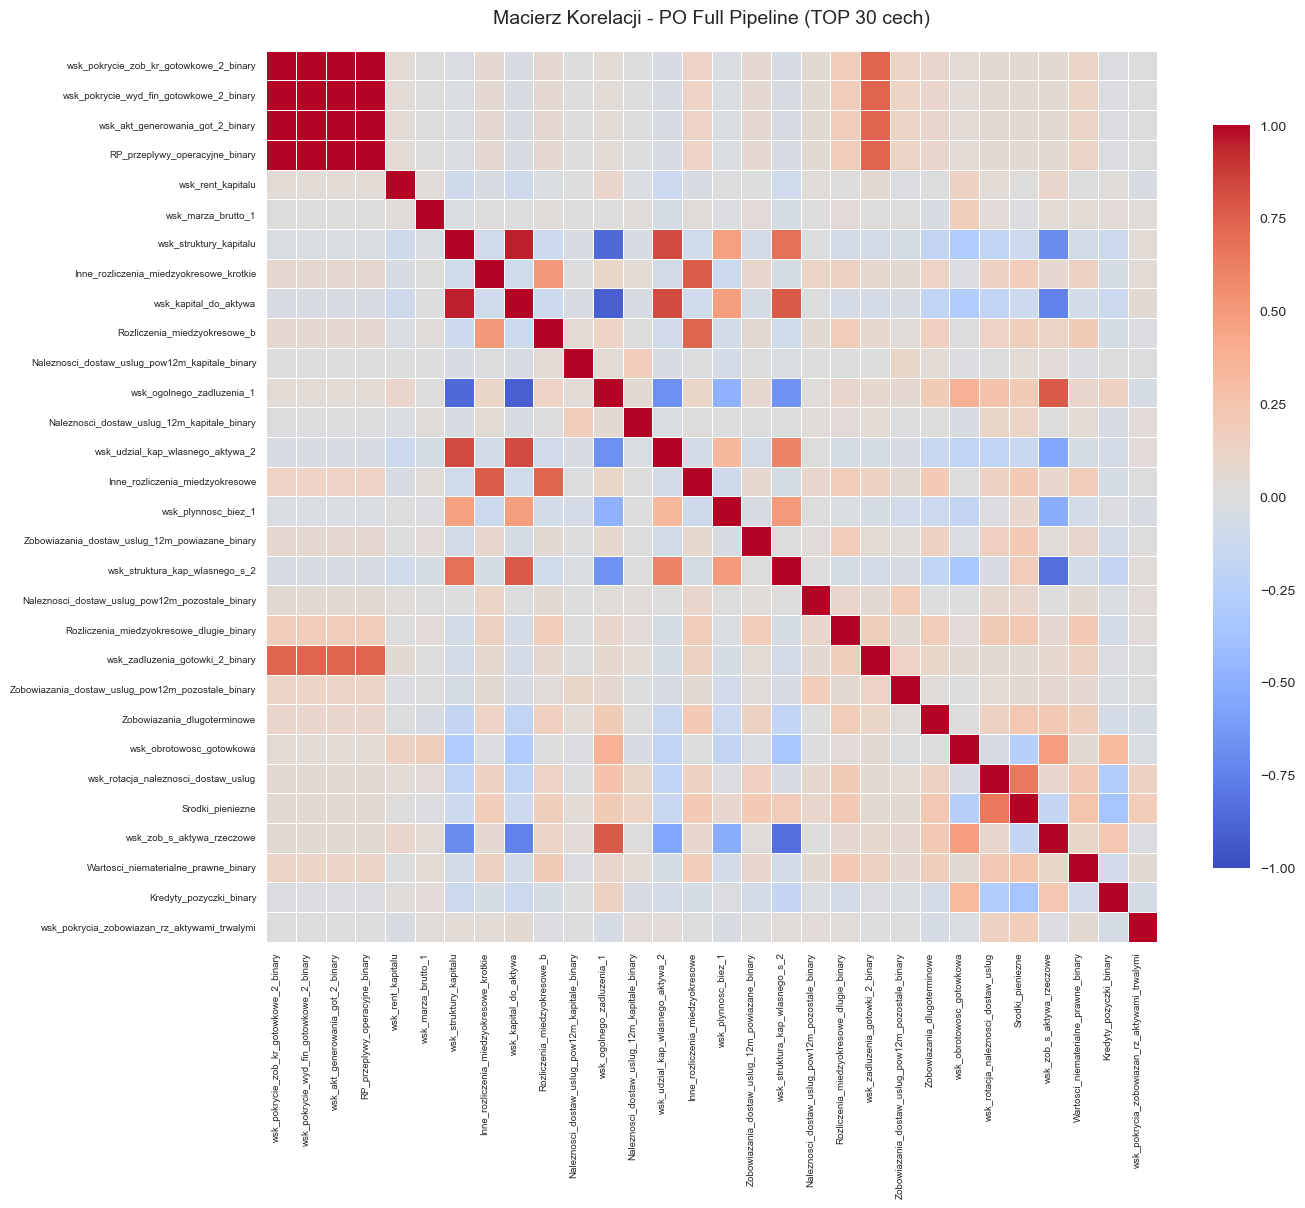

   ✅ Heatmap wygenerowana dla TOP 30 cech PO transformacji

📈 TOP 15 CECH PO transformacji (korelacja z targetem):
Rank   Feature                                        Correlation Direction      
1      wsk_pokrycie_zob_kr_gotowkowe_2_binary             +0.0793 📈 Higher = More Risk
2      wsk_pokrycie_wyd_fin_gotowkowe_2_binary            +0.0793 📈 Higher = More Risk
3      wsk_akt_generowania_got_2_binary                   +0.0793 📈 Higher = More Risk
4      RP_przeplywy_operacyjne_binary                     +0.0793 📈 Higher = More Risk
5      wsk_rent_kapitalu                                  -0.0748 📉 Higher = Less Risk
6      wsk_marza_brutto_1                                 -0.0732 📉 Higher = Less Risk
7      wsk_struktury_kapitalu                             +0.0692 📈 Higher = More Risk
8      Inne_rozliczenia_miedzyokresowe_krotkie            +0.0682 📈 Higher = More Risk
9      wsk_kapital_do_aktywa                              +0.0651 📈 Higher = More Risk
10     Rozliczenia_m

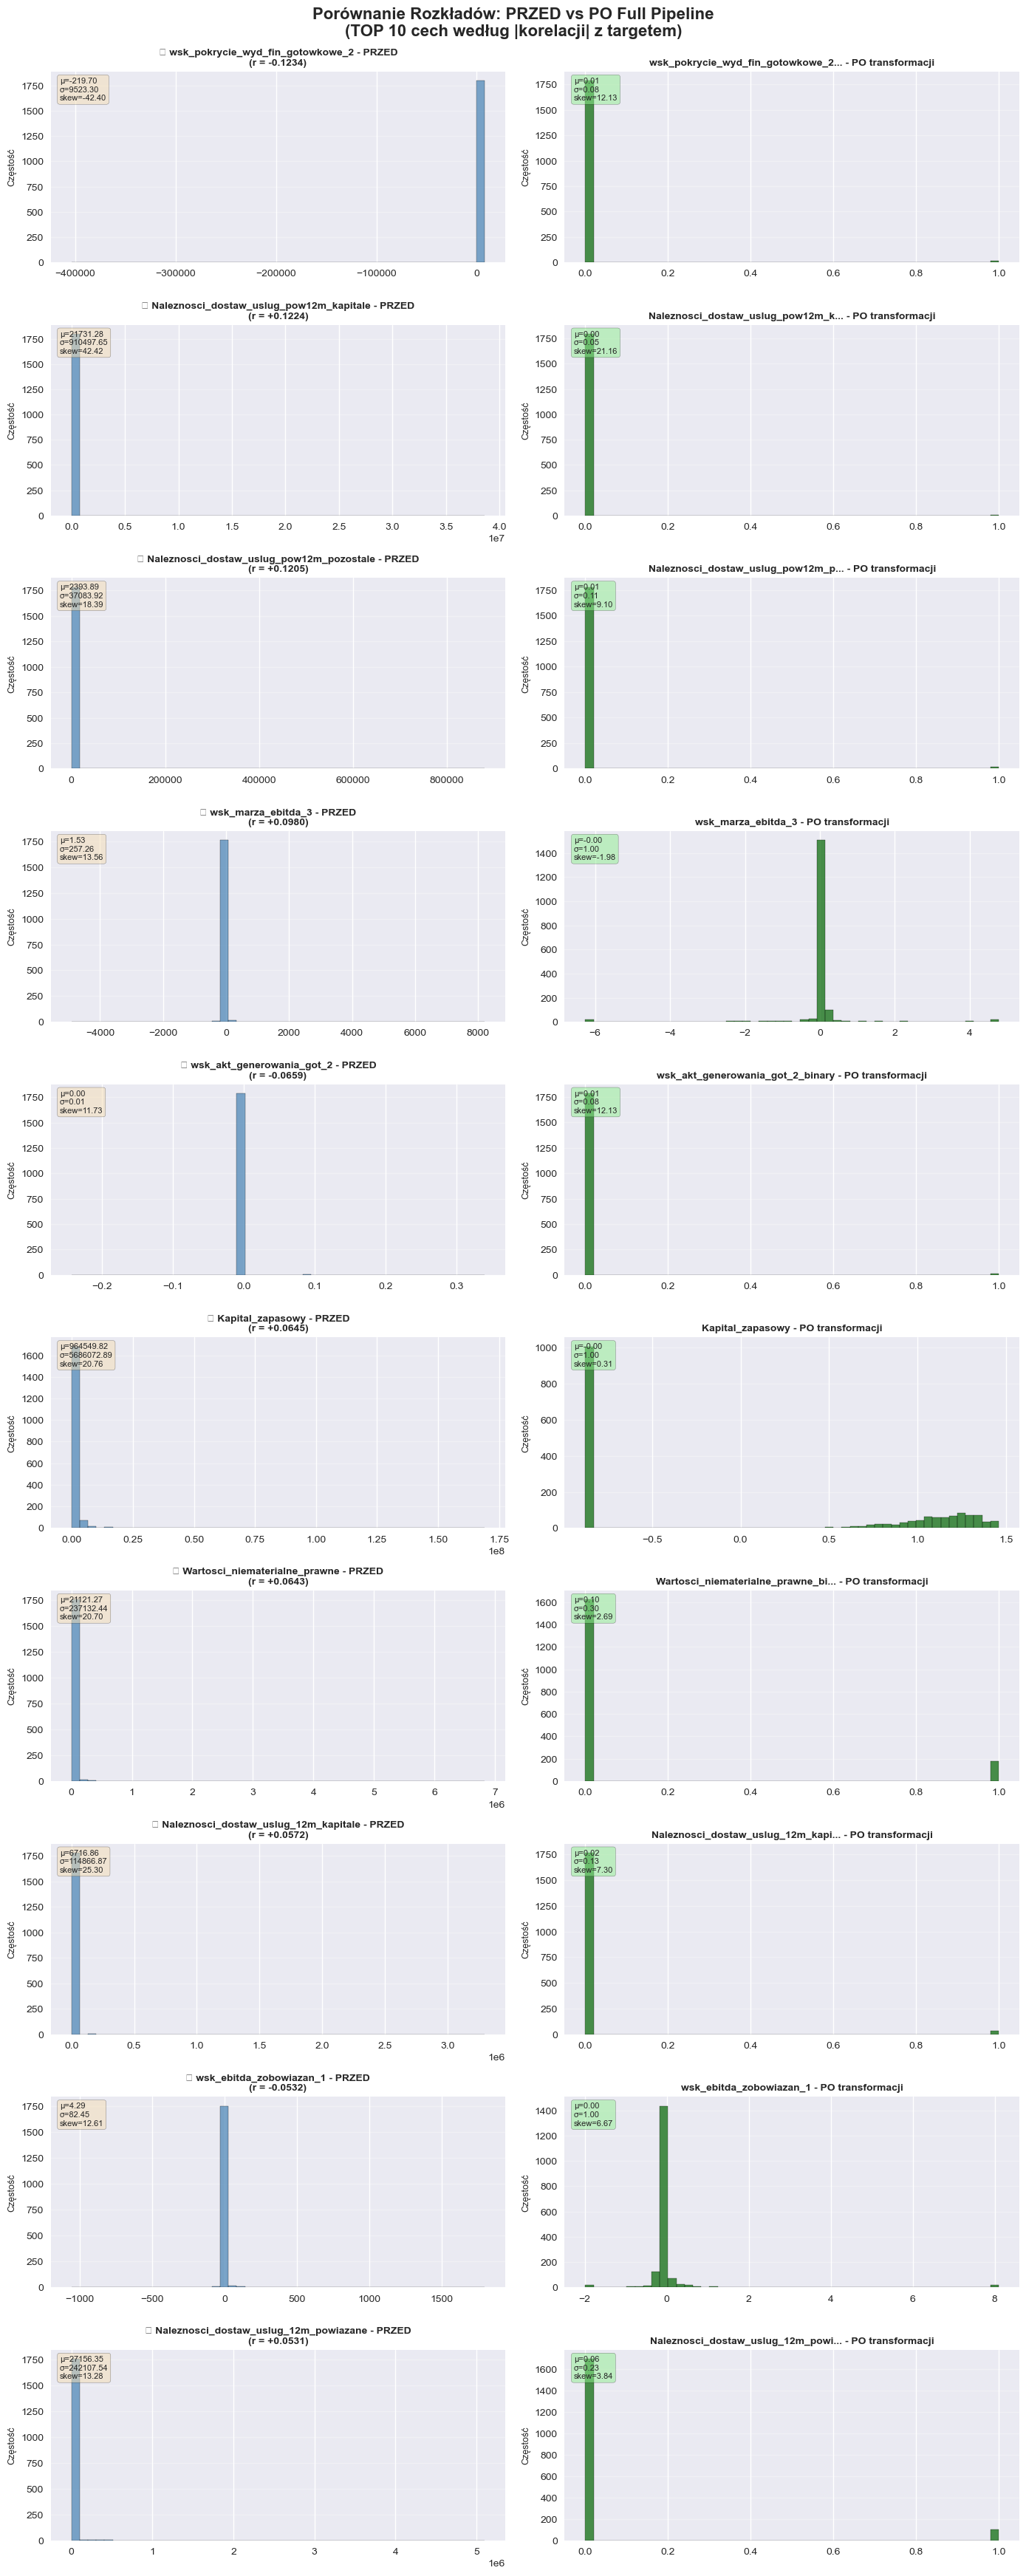


📊 PODSUMOWANIE ZMIAN W ROZKŁADACH

1️⃣  NORMALIZACJA ROZKŁADÓW (redukcja skewness):
Feature (Raw → Full)                               |Skew| Przed    |Skew| Po       Zmiana
------------------------------------------------------------------------------------------
🟡 wsk_pokrycie_wyd_fin→wsk_pokrycie_wyd_fin             42.4011      12.1347 📉   -30.2664
🟡 Naleznosci_dostaw_us→Naleznosci_dostaw_us             42.4179      21.1601 📉   -21.2578
🟡 Naleznosci_dostaw_us→Naleznosci_dostaw_us             18.3935       9.1030 📉    -9.2905
🟢 wsk_marza_ebitda_3                                    13.5551       1.9836 📉   -11.5715
🟡 wsk_akt_generowania_→wsk_akt_generowania_             11.7313      12.1347 📈    +0.4035
🟢 Kapital_zapasowy                                      20.7593       0.3070 📉   -20.4522
🟡 Wartosci_niematerial→Wartosci_niematerial             20.7041       2.6896 📉   -18.0144
🟡 Naleznosci_dostaw_us→Naleznosci_dostaw_us             25.2956       7.3046 📉   -17.9910
🟢 wsk_ebitda_z

In [14]:
# ============================================================================
# EDA - PO FULL PIPELINE PREPROCESSING
# ============================================================================
print("="*80)
print("📊 EDA - PO FULL PIPELINE PREPROCESSING")
print("="*80)
print("Analiza danych po transformacjach Full Pipeline:")
print("  • Box-Cox transformation (normalizacja rozkładów)")
print("  • Winsoryzacja (usunięcie outlierów)")
print("  • Standaryzacja (mean=0, std=1)")
print("="*80 + "\n")
    
# Sprawdź dostępność danych
if 'top10_features_raw' in dir() and 'X_train_raw_backup' in dir() and 'X_train_full' in dir():
    
    # ============================================================================
    # 1. MACIERZ KORELACJI - PO Full Pipeline
    # ============================================================================
    print("1️⃣  MACIERZ KORELACJI - PO Full Pipeline preprocessing")
    print("="*80)
    
    # Oblicz macierz korelacji dla przetransformowanych danych
    corr_matrix_full = X_train_full.corr()
    
    print(f"\n📊 Liczba cech po preprocessing: {X_train_full.shape[1]}")
    print(f"📋 Macierz korelacji: {corr_matrix_full.shape[0]} × {corr_matrix_full.shape[1]}")
    print(f"📋 Zakres wartości: [{corr_matrix_full.min().min():.3f}, {corr_matrix_full.max().max():.3f}]")
    
    # Znajdź pary cech o wysokiej korelacji (>0.7)
    high_corr_pairs_full = []
    for i in range(len(corr_matrix_full.columns)):
        for j in range(i+1, len(corr_matrix_full.columns)):
            corr_val = corr_matrix_full.iloc[i, j]
            if abs(corr_val) > 0.7:
                high_corr_pairs_full.append((
                    corr_matrix_full.columns[i],
                    corr_matrix_full.columns[j],
                    corr_val
                ))
    
    if len(high_corr_pairs_full) > 0:
        print(f"\n⚠️  Znaleziono {len(high_corr_pairs_full)} par cech o wysokiej korelacji (|r| > 0.7):")
        for feat1, feat2, corr_val in sorted(high_corr_pairs_full, key=lambda x: abs(x[2]), reverse=True)[:15]:
            direction = "+" if corr_val > 0 else "-"
            print(f"   {direction} {feat1:<35} ↔ {feat2:<35} r = {corr_val:+.3f}")
    else:
        print("\n✅ Brak par cech o wysokiej korelacji (|r| > 0.7)")
    
    # Statystyki korelacji
    corr_values_full = corr_matrix_full.values[np.triu_indices_from(corr_matrix_full.values, k=1)]
    print(f"\n📊 Statystyki korelacji (wszystkie pary cech):")
    print(f"   Średnia |r|:  {np.abs(corr_values_full).mean():.3f}")
    print(f"   Mediana |r|:  {np.median(np.abs(corr_values_full)):.3f}")
    print(f"   Max |r|:      {np.abs(corr_values_full).max():.3f}")
    
    # Korelacja z targetem - PO transformacji
    target_corr_full = []
    for col in X_train_full.columns:
        try:
            corr_val = X_train_full[col].corr(pd.Series(y_train.values))
            target_corr_full.append({'Feature': col, 'Correlation': corr_val, 'Abs_Correlation': abs(corr_val)})
        except:
            target_corr_full.append({'Feature': col, 'Correlation': 0.0, 'Abs_Correlation': 0.0})
    
    target_corr_full_df = pd.DataFrame(target_corr_full).sort_values('Abs_Correlation', ascending=False)
    top30_features_full = target_corr_full_df.head(30)['Feature'].tolist()
    
    # Heatmap dla top 30 cech PO transformacji
    print(f"\n📊 Wizualizacja macierzy korelacji (TOP 30 cech PO preprocessing):")
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(corr_matrix_full[top30_features_full].loc[top30_features_full], 
                annot=False,
                cmap='coolwarm', 
                center=0,
                vmin=-1, 
                vmax=1,
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": 0.8})
    plt.title('Macierz Korelacji - PO Full Pipeline (TOP 30 cech)', fontsize=14, pad=20)
    plt.xticks(rotation=90, ha='right', fontsize=7)
    plt.yticks(rotation=0, fontsize=7)
    plt.tight_layout()
    plt.show()
    
    print(f"   ✅ Heatmap wygenerowana dla TOP 30 cech PO transformacji")
    
    # Korelacja z targetem - TOP 15
    print(f"\n📈 TOP 15 CECH PO transformacji (korelacja z targetem):")
    print(f"{'Rank':<6} {'Feature':<45} {'Correlation':>12} {'Direction':<15}")
    print("="*80)
    
    for idx, row in target_corr_full_df.head(15).iterrows():
        rank = target_corr_full_df.index.get_loc(idx) + 1
        direction = "📈 Higher = More Risk" if row['Correlation'] > 0 else "📉 Higher = Less Risk"
        print(f"{rank:<6} {row['Feature']:<45} {row['Correlation']:>+12.4f} {direction:<15}")
    
    # ============================================================================
    # 2. PORÓWNANIE ROZKŁADÓW - TOP 10 CECH (Przed vs Po)
    # ============================================================================
    print("\n\n2️⃣  PORÓWNANIE ROZKŁADÓW - TOP 10 CECH")
    print("="*80)
    print("Wizualizacja rozkładów PRZED i PO transformacji Full Pipeline")
    print("="*80 + "\n")
    
    # STRATEGIA: Dopasuj cechy RAW do cech FULL
    # Znajdź TOP 10 cech PO transformacji
    top10_features_full = target_corr_full_df.head(10)['Feature'].tolist()
    
    # Próbuj dopasować cechy RAW do FULL (po nazwie lub częściowo)
    features_to_compare = []
    
    for feat_raw in top10_features_raw:
        # Sprawdź czy cecha istnieje bezpośrednio
        if feat_raw in X_train_full.columns:
            features_to_compare.append((feat_raw, feat_raw, 'exact'))
        else:
            # Szukaj cechy zawierającej nazwę oryginalnej
            matching_features = [f for f in X_train_full.columns if feat_raw in f]
            if matching_features:
                # Wybierz pierwszą dopasowaną cechę
                features_to_compare.append((feat_raw, matching_features[0], 'partial'))
            else:
                features_to_compare.append((feat_raw, None, 'missing'))
    
    # Jeśli więcej niż połowa cech jest missing, użyj TOP 10 cech PO transformacji
    missing_count = sum(1 for _, _, match_type in features_to_compare if match_type == 'missing')
    
    if missing_count > len(top10_features_raw) // 2:
        print("⚠️  Wiele cech zostało zmienionych przez transformacje.")
        print("📊 Wizualizacja TOP 10 cech PO transformacji (zamiast porównania PRZED/PO):\n")
        
        # Pokaż tylko cechy PO transformacji
        fig, axes = plt.subplots(10, 1, figsize=(12, 35))
        fig.suptitle('Rozkłady TOP 10 Cech PO Full Pipeline\n(według |korelacji| z targetem)', 
                     fontsize=16, fontweight='bold', y=0.995)
        
        for idx, feat in enumerate(top10_features_full):
            ax = axes[idx]
            data = X_train_full[feat].dropna()
            
            # Oblicz korelację z targetem
            try:
                corr_with_target = X_train_full[feat].corr(pd.Series(y_train.values))
            except:
                corr_with_target = 0.0
            
            ax.hist(data, bins=50, color='darkgreen', alpha=0.7, edgecolor='black')
            ax.set_title(f'{feat}\n(r = {corr_with_target:+.4f})', 
                        fontsize=10, fontweight='bold')
            ax.set_ylabel('Częstość', fontsize=9)
            ax.grid(axis='y', alpha=0.3)
            
            # Statystyki
            mean_val = data.mean()
            std_val = data.std()
            skew_val = data.skew()
            ax.text(0.02, 0.97, 
                   f'μ={mean_val:.2f}\nσ={std_val:.2f}\nskew={skew_val:.2f}',
                   transform=ax.transAxes,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5),
                   fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
    else:
        # Porównanie PRZED vs PO (gdy większość cech można dopasować)
        print(f"✅ Porównanie {len(features_to_compare)} cech (PRZED vs PO transformacji)\n")
        print("Legenda:")
        print("  • 🟢 Exact match - cecha o tej samej nazwie")
        print("  • 🟡 Partial match - cecha zawierająca oryginalną nazwę")
        print("  • 🔴 Missing - cecha usunięta/całkowicie przemianowana\n")
        
        # Przygotuj subplot - 2 kolumny × 10 wierszy
        fig, axes = plt.subplots(10, 2, figsize=(14, 35))
        fig.suptitle('Porównanie Rozkładów: PRZED vs PO Full Pipeline\n(TOP 10 cech według |korelacji| z targetem)', 
                     fontsize=16, fontweight='bold', y=0.995)
        
        for idx, (feat_raw, feat_full, match_type) in enumerate(features_to_compare):
            # Oblicz korelację z targetem (surowe dane)
            try:
                corr_with_target = X_train_raw_backup[feat_raw].corr(pd.Series(y_train.values))
            except:
                corr_with_target = 0.0
            
            # Lewy wykres - PRZED preprocessingiem
            ax_before = axes[idx, 0]
            data_before = X_train_raw_backup[feat_raw].dropna()
            
            match_icon = "🟢" if match_type == 'exact' else "🟡" if match_type == 'partial' else "🔴"
            
            ax_before.hist(data_before, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
            ax_before.set_title(f'{match_icon} {feat_raw} - PRZED\n(r = {corr_with_target:+.4f})', 
                               fontsize=10, fontweight='bold')
            ax_before.set_ylabel('Częstość', fontsize=9)
            ax_before.grid(axis='y', alpha=0.3)
            
            # Statystyki PRZED
            mean_before = data_before.mean()
            std_before = data_before.std()
            skew_before = data_before.skew()
            ax_before.text(0.02, 0.97, 
                          f'μ={mean_before:.2f}\nσ={std_before:.2f}\nskew={skew_before:.2f}',
                          transform=ax_before.transAxes,
                          verticalalignment='top',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                          fontsize=8)
            
            # Prawy wykres - PO preprocessingu
            ax_after = axes[idx, 1]
            
            if feat_full is not None:
                data_after = X_train_full[feat_full].dropna()
                
                ax_after.hist(data_after, bins=50, color='darkgreen', alpha=0.7, edgecolor='black')
                
                # Skróć długą nazwę jeśli partial match
                display_name = feat_full if len(feat_full) <= 35 else feat_full[:32] + "..."
                ax_after.set_title(f'{display_name} - PO transformacji', 
                                  fontsize=10, fontweight='bold')
                ax_after.set_ylabel('Częstość', fontsize=9)
                ax_after.grid(axis='y', alpha=0.3)
                
                # Statystyki PO
                mean_after = data_after.mean()
                std_after = data_after.std()
                skew_after = data_after.skew()
                ax_after.text(0.02, 0.97, 
                             f'μ={mean_after:.2f}\nσ={std_after:.2f}\nskew={skew_after:.2f}',
                             transform=ax_after.transAxes,
                             verticalalignment='top',
                             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5),
                             fontsize=8)
            else:
                # Cecha nie istnieje w X_train_full
                ax_after.text(0.5, 0.5, f'⚠️ Cecha usunięta\nlub całkowicie\nprzemianowana\nw Full Pipeline',
                             ha='center', va='center', transform=ax_after.transAxes,
                             fontsize=10, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
                ax_after.set_title(f'{feat_raw} - NIEOBECNA', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # ========================================================================
    # PODSUMOWANIE ZMIAN
    # ========================================================================
    print("\n" + "="*80)
    print("📊 PODSUMOWANIE ZMIAN W ROZKŁADACH")
    print("="*80)
    
    # Analiza zmian w skewness (tylko dla dostępnych cech)
    skewness_changes = []
    for feat_raw, feat_full, match_type in features_to_compare:
        if feat_full is not None:
            skew_before = X_train_raw_backup[feat_raw].dropna().skew()
            skew_after = X_train_full[feat_full].dropna().skew()
            skewness_changes.append({
                'Feature_Raw': feat_raw,
                'Feature_Full': feat_full,
                'Match_Type': match_type,
                'Skew_Before': skew_before,
                'Skew_After': skew_after,
                'Skew_Change': abs(skew_after) - abs(skew_before)
            })
    
    if len(skewness_changes) > 0:
        skew_df = pd.DataFrame(skewness_changes)
        
        print(f"\n1️⃣  NORMALIZACJA ROZKŁADÓW (redukcja skewness):")
        print(f"{'Feature (Raw → Full)':<50} {'|Skew| Przed':>12} {'|Skew| Po':>12} {'Zmiana':>12}")
        print("-"*90)
        
        for _, row in skew_df.iterrows():
            change_symbol = "📉" if row['Skew_Change'] < 0 else "📈"
            match_icon = "🟢" if row['Match_Type'] == 'exact' else "🟡"
            
            # Skróć nazwę jeśli za długa
            feat_display = row['Feature_Raw'] if row['Match_Type'] == 'exact' else f"{row['Feature_Raw'][:20]}→{row['Feature_Full'][:20]}"
            if len(feat_display) > 45:
                feat_display = feat_display[:42] + "..."
            
            print(f"{match_icon} {feat_display:<48} {abs(row['Skew_Before']):>12.4f} "
                  f"{abs(row['Skew_After']):>12.4f} {change_symbol} {row['Skew_Change']:>+10.4f}")
        
        avg_skew_before = skew_df['Skew_Before'].abs().mean()
        avg_skew_after = skew_df['Skew_After'].abs().mean()
        
        print("\n" + "-"*90)
        print(f"{'ŚREDNIA |SKEWNESS|':<50} {avg_skew_before:>12.4f} {avg_skew_after:>12.4f} "
              f"{'📉' if avg_skew_after < avg_skew_before else '📈'} "
              f"{avg_skew_after - avg_skew_before:>+10.4f}")
        
        if avg_skew_after < avg_skew_before:
            improvement = ((avg_skew_before - avg_skew_after) / avg_skew_before) * 100
            print(f"\n   ✅ Box-Cox transformation zredukowała średnią |skewness| o {improvement:.1f}%")
        else:
            print(f"\n   ⚠️ Rozkłady nie uległy znaczącej poprawie")
    else:
        print("\n1️⃣  NORMALIZACJA ROZKŁADÓW:")
        print("   ⚠️ Brak cech do porównania (wszystkie zostały usunięte/przemianowane)")
    
    # Analiza zmian w standaryzacji
    print(f"\n2️⃣  STANDARYZACJA (mean=0, std=1):")
    print(f"{'Feature':<50} {'Mean Po':>12} {'Std Po':>12} {'Status':>15}")
    print("-"*90)
    
    standardized_count = 0
    analyzed_count = 0
    
    for feat_raw, feat_full, match_type in features_to_compare:
        if feat_full is not None:
            analyzed_count += 1
            mean_after = X_train_full[feat_full].mean()
            std_after = X_train_full[feat_full].std()
            
            # Sprawdź czy jest standaryzowana (mean ≈ 0, std ≈ 1)
            is_standardized = (abs(mean_after) < 0.01 and abs(std_after - 1.0) < 0.1)
            status = "✅ Standaryz." if is_standardized else "⚠️ Nie"
            
            if is_standardized:
                standardized_count += 1
            
            match_icon = "🟢" if match_type == 'exact' else "🟡"
            
            # Skróć nazwę
            feat_display = feat_full if len(feat_full) <= 45 else feat_full[:42] + "..."
            
            print(f"{match_icon} {feat_display:<48} {mean_after:>12.4f} {std_after:>12.4f} {status:>15}")
    
    print("-"*90)
    if analyzed_count > 0:
        print(f"   • {standardized_count}/{analyzed_count} cech jest standaryzowana (mean≈0, std≈1)")
    else:
        print(f"   ⚠️ Brak cech do analizy")
    
    # Podsumowanie
    print(f"\n3️⃣  WPŁYW NA JAKOŚĆ DANYCH:")
    features_removed = sum(1 for _, feat_full, _ in features_to_compare if feat_full is None)
    features_exact = sum(1 for _, _, match_type in features_to_compare if match_type == 'exact')
    features_partial = sum(1 for _, _, match_type in features_to_compare if match_type == 'partial')
    
    print(f"   📊 Status cech TOP 10:")
    print(f"      🟢 Exact match:    {features_exact}/{len(features_to_compare)} cech zachowanych bez zmian")
    print(f"      🟡 Partial match:  {features_partial}/{len(features_to_compare)} cech zmodyfikowanych/rozszerzonych")
    print(f"      🔴 Missing:        {features_removed}/{len(features_to_compare)} cech usuniętych")
    
    if len(skewness_changes) > 0 and avg_skew_after < avg_skew_before:
        print(f"   ✅ Rozkłady są bardziej normalne (niższa skewness)")
    
    if analyzed_count > 0 and standardized_count >= analyzed_count * 0.8:
        print(f"   ✅ Większość cech jest poprawnie standaryzowana")
    
    # ============================================================================
    # 3. PORÓWNANIE: PRZED vs PO PREPROCESSING
    # ============================================================================
    print("\n\n4️⃣  PORÓWNANIE: PRZED vs PO PREPROCESSING")
    print("="*80)
    
    print(f"\n📊 WIELOKOLINEARNOŚĆ:")
    print(f"   PRZED: {len(high_corr_pairs_raw)} par o |r| > 0.7 (średnia |r| = {np.abs(corr_values_raw).mean():.3f})")
    print(f"   PO:    {len(high_corr_pairs_full)} par o |r| > 0.7 (średnia |r| = {np.abs(corr_values_full).mean():.3f})")
    
    if len(high_corr_pairs_full) < len(high_corr_pairs_raw):
        reduction = ((len(high_corr_pairs_raw) - len(high_corr_pairs_full)) / len(high_corr_pairs_raw)) * 100
        print(f"   ✅ Redukcja wielokolinearności o {reduction:.1f}%")
    else:
        print(f"   ⚠️ Wielokolinearność nie uległa redukcji")
    
    print(f"\n📊 MOC PREDYKCYJNA (korelacja z targetem):")
    print(f"   PRZED: Średnia |r| = {target_corr_raw_df['Abs_Correlation'].mean():.4f}")
    print(f"   PO:    Średnia |r| = {target_corr_full_df['Abs_Correlation'].mean():.4f}")
    
    print(f"\n📊 LICZBA CECH:")
    print(f"   PRZED: {len(numeric_cols_raw)} cech")
    print(f"   PO:    {X_train_full.shape[1]} cech")
    
    print("\n" + "="*80)

else:
    print("⚠️ Brak danych do porównania.")
    print("   Upewnij się, że:")
    print("   1. Uruchomiono Section 2.5 (EDA przed preprocessingiem)")
    print("   2. Uruchomiono Full Pipeline preprocessing (X_train_full istnieje)")
    print("="*80)

## 5. Full Pipeline - Modele Interpretwalne

In [15]:
# Słownik do przechowywania wyników
results_full = {}

### 5.1 Logistic Regression (Full)

In [16]:
print("="*70)
print("LOGISTIC REGRESSION - FULL PIPELINE")
print("="*70)

lr_full = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_full.fit(X_train_full, y_train)

y_pred_lr_full = lr_full.predict(X_test_full)
y_proba_lr_full = lr_full.predict_proba(X_test_full)[:, 1]

metrics_lr_full = calculate_all_metrics(y_test, y_pred_lr_full, y_proba_lr_full)
results_full['LR'] = {'model': lr_full, **metrics_lr_full}

print_model_metrics(metrics_lr_full, "Logistic Regression - Full Pipeline")

LOGISTIC REGRESSION - FULL PIPELINE

📊 METRYKI: Logistic Regression - Full Pipeline
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.7483
Precision                0.1481
Recall                   0.6486
F1-Score                 0.2412
----------------------------------------------------------------------
ROC-AUC                  0.7501
PR-AUC                   0.1492
KS Statistic             0.4391
----------------------------------------------------------------------
Log-Loss                 0.5973
Brier Score              0.1751


### 5.2 Decision Tree (Full)

In [17]:
print("="*70)
print("DECISION TREE - FULL PIPELINE")
print("="*70)

dt_full = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=100, 
    min_samples_leaf=50,
    random_state=42, 
    class_weight='balanced'
)
dt_full.fit(X_train_full, y_train)

y_pred_dt_full = dt_full.predict(X_test_full)
y_proba_dt_full = dt_full.predict_proba(X_test_full)[:, 1]

metrics_dt_full = calculate_all_metrics(y_test, y_pred_dt_full, y_proba_dt_full)
results_full['DT'] = {'model': dt_full, **metrics_dt_full}

print_model_metrics(metrics_dt_full, "Decision Tree - Full Pipeline")

DECISION TREE - FULL PIPELINE

📊 METRYKI: Decision Tree - Full Pipeline
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.6117
Precision                0.0882
Recall                   0.5676
F1-Score                 0.1527
----------------------------------------------------------------------
ROC-AUC                  0.6692
PR-AUC                   0.1175
KS Statistic             0.3036
----------------------------------------------------------------------
Log-Loss                 0.8436
Brier Score              0.2119


### 5.3 Naive Bayes (Full)

In [18]:
print("="*70)
print("NAIVE BAYES - FULL PIPELINE")
print("="*70)

nb_full = GaussianNB()
nb_full.fit(X_train_full, y_train)

y_pred_nb_full = nb_full.predict(X_test_full)
y_proba_nb_full = nb_full.predict_proba(X_test_full)[:, 1]

metrics_nb_full = calculate_all_metrics(y_test, y_pred_nb_full, y_proba_nb_full)
results_full['NB'] = {'model': nb_full, **metrics_nb_full}

print_model_metrics(metrics_nb_full, "Naive Bayes - Full Pipeline")

NAIVE BAYES - FULL PIPELINE

📊 METRYKI: Naive Bayes - Full Pipeline
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.2667
Precision                0.0685
Recall                   0.8649
F1-Score                 0.1270
----------------------------------------------------------------------
ROC-AUC                  0.5540
PR-AUC                   0.0689
KS Statistic             0.1090
----------------------------------------------------------------------
Log-Loss                26.2327
Brier Score              0.7333


## 6. Full Pipeline - Modele Black Box

### 6.1 Inicjalizacja

In [19]:
# Słownik do przechowywania wyników modeli black box (Full Pipeline)
results_blackbox_full = {}

### 6.2 Random Forest (Black Box)

In [20]:
print("="*70)
print("RANDOM FOREST - BLACK BOX (FULL PIPELINE)")
print("="*70)

rf_blackbox_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_blackbox_full.fit(X_train_full, y_train)

y_pred_rf_blackbox_full = rf_blackbox_full.predict(X_test_full)
y_proba_rf_blackbox_full = rf_blackbox_full.predict_proba(X_test_full)[:, 1]

metrics_rf_blackbox = calculate_all_metrics(y_test, y_pred_rf_blackbox_full, y_proba_rf_blackbox_full)
results_blackbox_full['RF'] = {'model': rf_blackbox_full, **metrics_rf_blackbox}

print_model_metrics(metrics_rf_blackbox, "Random Forest - Black Box Full")

RANDOM FOREST - BLACK BOX (FULL PIPELINE)

📊 METRYKI: Random Forest - Black Box Full
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.8517
Precision                0.2174
Recall                   0.5405
F1-Score                 0.3101
----------------------------------------------------------------------
ROC-AUC                  0.8128
PR-AUC                   0.1836
KS Statistic             0.5746
----------------------------------------------------------------------
Log-Loss                 0.3707
Brier Score              0.1153


### 5.5.2 XGBoost (Black Box - Full)

In [21]:
if XGBOOST_AVAILABLE:
    print("="*70)
    print("XGBOOST - BLACK BOX (FULL PIPELINE)")
    print("="*70)
    
    xgb_blackbox_full = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Oblicz scale_pos_weight dla class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_blackbox_full.set_params(scale_pos_weight=scale_pos_weight)
    
    xgb_blackbox_full.fit(X_train_full, y_train)
    
    y_pred_xgb_blackbox_full = xgb_blackbox_full.predict(X_test_full)
    y_proba_xgb_blackbox_full = xgb_blackbox_full.predict_proba(X_test_full)[:, 1]
    
    metrics_xgb_blackbox = calculate_all_metrics(y_test, y_pred_xgb_blackbox_full, y_proba_xgb_blackbox_full)
    results_blackbox_full['XGB'] = {'model': xgb_blackbox_full, **metrics_xgb_blackbox}
    
    print_model_metrics(metrics_xgb_blackbox, "XGBoost - Black Box Full")
else:
    print("⚠️  XGBoost niedostępny")

XGBOOST - BLACK BOX (FULL PIPELINE)

📊 METRYKI: XGBoost - Black Box Full
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.9083
Precision                0.0909
Recall                   0.0541
F1-Score                 0.0678
----------------------------------------------------------------------
ROC-AUC                  0.7405
PR-AUC                   0.1329
KS Statistic             0.4270
----------------------------------------------------------------------
Log-Loss                 0.2472
Brier Score              0.0691


### 5.5.3 SVM (Black Box - Full)

In [22]:
print("="*70)
print("SVM - BLACK BOX (FULL PIPELINE)")
print("="*70)

svm_blackbox_full = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    class_weight='balanced',
    probability=True  # Wymagane dla predict_proba
)
svm_blackbox_full.fit(X_train_full, y_train)

y_pred_svm_blackbox_full = svm_blackbox_full.predict(X_test_full)
y_proba_svm_blackbox_full = svm_blackbox_full.predict_proba(X_test_full)[:, 1]

metrics_svm_blackbox = calculate_all_metrics(y_test, y_pred_svm_blackbox_full, y_proba_svm_blackbox_full)
results_blackbox_full['SVM'] = {'model': svm_blackbox_full, **metrics_svm_blackbox}

print_model_metrics(metrics_svm_blackbox, "SVM - Black Box Full")

SVM - BLACK BOX (FULL PIPELINE)

📊 METRYKI: SVM - Black Box Full
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.8100
Precision                0.1709
Recall                   0.5405
F1-Score                 0.2597
----------------------------------------------------------------------
ROC-AUC                  0.7809
PR-AUC                   0.1490
KS Statistic             0.4912
----------------------------------------------------------------------
Log-Loss                 0.2110
Brier Score              0.0554


### 5.5.4 Neural Network (Black Box - Full)

In [23]:
print("="*70)
print("NEURAL NETWORK (MLP) - BLACK BOX (FULL PIPELINE)")
print("="*70)

mlp_blackbox_full = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    verbose=False
)
mlp_blackbox_full.fit(X_train_full, y_train)

y_pred_mlp_blackbox_full = mlp_blackbox_full.predict(X_test_full)
y_proba_mlp_blackbox_full = mlp_blackbox_full.predict_proba(X_test_full)[:, 1]

metrics_mlp_blackbox = calculate_all_metrics(y_test, y_pred_mlp_blackbox_full, y_proba_mlp_blackbox_full)
results_blackbox_full['Neural Network'] = {'model': mlp_blackbox_full, **metrics_mlp_blackbox}

print_model_metrics(metrics_mlp_blackbox, "Neural Network (MLP) - Black Box Full")
print(f"  Liczba iteracji: {mlp_blackbox_full.n_iter_}")
print(f"  Liczba warstw: {len(mlp_blackbox_full.hidden_layer_sizes)}")

NEURAL NETWORK (MLP) - BLACK BOX (FULL PIPELINE)

📊 METRYKI: Neural Network (MLP) - Black Box Full
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.9300
Precision                0.2222
Recall                   0.0541
F1-Score                 0.0870
----------------------------------------------------------------------
ROC-AUC                  0.7701
PR-AUC                   0.1874
KS Statistic             0.4333
----------------------------------------------------------------------
Log-Loss                 0.2147
Brier Score              0.0586
  Liczba iteracji: 33
  Liczba warstw: 3


---

# CZĘŚĆ 2: MINIMAL PIPELINE

## 6. Minimal Pipeline - Preprocessing

In [24]:
# Inicjalizacja i dopasowanie pipeline
pipeline_minimal = MinimalPreprocessingPipeline(
    correlation_threshold=0.80,
    standardize=True
)

print("Dopasowywanie Minimal Pipeline...")
X_train_minimal = pipeline_minimal.fit_transform(X_train, y_train)
X_test_minimal = pipeline_minimal.transform(X_test)

print(f"\n✅ Minimal Pipeline gotowy")
print(f"   Train: {X_train_minimal.shape}")
print(f"   Test: {X_test_minimal.shape}")
print(f"   NaN: {X_train_minimal.isna().sum().sum()}")
print(f"   Inf: {np.isinf(X_train_minimal.values).sum()}")

Dopasowywanie Minimal Pipeline...

✅ Minimal Pipeline gotowy
   Train: (1800, 136)
   Test: (600, 136)
   NaN: 0
   Inf: 0


## 7. Minimal Pipeline - Trening Modeli

In [25]:
# Słownik do przechowywania wyników
results_minimal = {}

### 7.1 Logistic Regression (Minimal)

In [26]:
print("="*70)
print("LOGISTIC REGRESSION - MINIMAL PIPELINE")
print("="*70)

lr_minimal = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr_minimal.fit(X_train_minimal, y_train)

y_pred_lr_minimal = lr_minimal.predict(X_test_minimal)
y_proba_lr_minimal = lr_minimal.predict_proba(X_test_minimal)[:, 1]

metrics_lr_minimal = calculate_all_metrics(y_test, y_pred_lr_minimal, y_proba_lr_minimal)
results_minimal['LR'] = {'model': lr_minimal, **metrics_lr_minimal}

print_model_metrics(metrics_lr_minimal, "Logistic Regression - Minimal Pipeline")

LOGISTIC REGRESSION - MINIMAL PIPELINE

📊 METRYKI: Logistic Regression - Minimal Pipeline
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.7650
Precision                0.1623
Recall                   0.6757
F1-Score                 0.2618
----------------------------------------------------------------------
ROC-AUC                  0.7511
PR-AUC                   0.1517
KS Statistic             0.4558
----------------------------------------------------------------------
Log-Loss                 0.6746
Brier Score              0.1729


### 7.2 Decision Tree (Minimal)

In [27]:
print("="*70)
print("DECISION TREE - MINIMAL PIPELINE")
print("="*70)

dt_minimal = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=100, 
    min_samples_leaf=50,
    random_state=42, 
    class_weight='balanced'
)
dt_minimal.fit(X_train_minimal, y_train)

y_pred_dt_minimal = dt_minimal.predict(X_test_minimal)
y_proba_dt_minimal = dt_minimal.predict_proba(X_test_minimal)[:, 1]

metrics_dt_minimal = calculate_all_metrics(y_test, y_pred_dt_minimal, y_proba_dt_minimal)
results_minimal['DT'] = {'model': dt_minimal, **metrics_dt_minimal}

print_model_metrics(metrics_dt_minimal, "Decision Tree - Minimal Pipeline")

DECISION TREE - MINIMAL PIPELINE

📊 METRYKI: Decision Tree - Minimal Pipeline
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.5750
Precision                0.1022
Recall                   0.7568
F1-Score                 0.1801
----------------------------------------------------------------------
ROC-AUC                  0.6839
PR-AUC                   0.1130
KS Statistic             0.3364
----------------------------------------------------------------------
Log-Loss                 0.9571
Brier Score              0.2139


### 7.3 Naive Bayes (Minimal)

In [28]:
print("="*70)
print("NAIVE BAYES - MINIMAL PIPELINE")
print("="*70)

nb_minimal = GaussianNB()
nb_minimal.fit(X_train_minimal, y_train)

y_pred_nb_minimal = nb_minimal.predict(X_test_minimal)
y_proba_nb_minimal = nb_minimal.predict_proba(X_test_minimal)[:, 1]

metrics_nb_minimal = calculate_all_metrics(y_test, y_pred_nb_minimal, y_proba_nb_minimal)
results_minimal['NB'] = {'model': nb_minimal, **metrics_nb_minimal}

print_model_metrics(metrics_nb_minimal, "Naive Bayes - Minimal Pipeline")

NAIVE BAYES - MINIMAL PIPELINE

📊 METRYKI: Naive Bayes - Minimal Pipeline
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.3100
Precision                0.0686
Recall                   0.8108
F1-Score                 0.1266
----------------------------------------------------------------------
ROC-AUC                  0.5624
PR-AUC                   0.0707
KS Statistic             0.1252
----------------------------------------------------------------------
Log-Loss                24.2152
Brier Score              0.6899


---

# CZĘŚĆ 2.5: MODELE BLACK BOX (MINIMAL PIPELINE)

## 7.5 Modele Black Box - Słownik Wyników

In [29]:
# Słownik do przechowywania wyników modeli black box
results_blackbox = {}

### 7.5.1 Random Forest (Black Box)

In [30]:
print("="*70)
print("RANDOM FOREST - BLACK BOX (MINIMAL PIPELINE)")
print("="*70)

rf_blackbox = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_blackbox.fit(X_train_minimal, y_train)

y_pred_rf_blackbox = rf_blackbox.predict(X_test_minimal)
y_proba_rf_blackbox = rf_blackbox.predict_proba(X_test_minimal)[:, 1]

metrics_rf_blackbox_min = calculate_all_metrics(y_test, y_pred_rf_blackbox, y_proba_rf_blackbox)
results_blackbox['RF'] = {'model': rf_blackbox, **metrics_rf_blackbox_min}

print_model_metrics(metrics_rf_blackbox_min, "Random Forest - Black Box Minimal")

RANDOM FOREST - BLACK BOX (MINIMAL PIPELINE)

📊 METRYKI: Random Forest - Black Box Minimal
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.8483
Precision                0.1932
Recall                   0.4595
F1-Score                 0.2720
----------------------------------------------------------------------
ROC-AUC                  0.8070
PR-AUC                   0.1676
KS Statistic             0.5618
----------------------------------------------------------------------
Log-Loss                 0.3745
Brier Score              0.1159


### 7.5.2 XGBoost (Black Box)

In [31]:
if XGBOOST_AVAILABLE:
    print("="*70)
    print("XGBOOST - BLACK BOX (MINIMAL PIPELINE)")
    print("="*70)
    
    xgb_blackbox = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    # Oblicz scale_pos_weight dla class imbalance
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    xgb_blackbox.set_params(scale_pos_weight=scale_pos_weight)
    
    xgb_blackbox.fit(X_train_minimal, y_train)
    
    y_pred_xgb_blackbox = xgb_blackbox.predict(X_test_minimal)
    y_proba_xgb_blackbox = xgb_blackbox.predict_proba(X_test_minimal)[:, 1]
    
    metrics_xgb_blackbox_min = calculate_all_metrics(y_test, y_pred_xgb_blackbox, y_proba_xgb_blackbox)
    results_blackbox['XGB'] = {'model': xgb_blackbox, **metrics_xgb_blackbox_min}
    
    print_model_metrics(metrics_xgb_blackbox_min, "XGBoost - Black Box Minimal")
else:
    print("⚠️  XGBoost niedostępny")

XGBOOST - BLACK BOX (MINIMAL PIPELINE)

📊 METRYKI: XGBoost - Black Box Minimal
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.9083
Precision                0.0909
Recall                   0.0541
F1-Score                 0.0678
----------------------------------------------------------------------
ROC-AUC                  0.7659
PR-AUC                   0.1569
KS Statistic             0.4461
----------------------------------------------------------------------
Log-Loss                 0.2384
Brier Score              0.0686


### 7.5.3 SVM (Black Box - Minimal)

In [32]:
print("="*70)
print("SVM - BLACK BOX (MINIMAL PIPELINE)")
print("="*70)

svm_blackbox = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    class_weight='balanced',
    probability=True  # Wymagane dla predict_proba
)
svm_blackbox.fit(X_train_minimal, y_train)

y_pred_svm_blackbox = svm_blackbox.predict(X_test_minimal)
y_proba_svm_blackbox = svm_blackbox.predict_proba(X_test_minimal)[:, 1]

metrics_svm_blackbox_min = calculate_all_metrics(y_test, y_pred_svm_blackbox, y_proba_svm_blackbox)
results_blackbox['SVM'] = {'model': svm_blackbox, **metrics_svm_blackbox_min}

print_model_metrics(metrics_svm_blackbox_min, "SVM - Black Box Minimal")

SVM - BLACK BOX (MINIMAL PIPELINE)

📊 METRYKI: SVM - Black Box Minimal
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.8150
Precision                0.1574
Recall                   0.4595
F1-Score                 0.2345
----------------------------------------------------------------------
ROC-AUC                  0.7485
PR-AUC                   0.1524
KS Statistic             0.4248
----------------------------------------------------------------------
Log-Loss                 0.2172
Brier Score              0.0561


### 7.5.4 Neural Network (Black Box - Minimal)

In [33]:
print("="*70)
print("NEURAL NETWORK (MLP) - BLACK BOX (MINIMAL PIPELINE)")
print("="*70)

mlp_blackbox = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    batch_size='auto',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    verbose=False
)
mlp_blackbox.fit(X_train_minimal, y_train)

y_pred_mlp_blackbox = mlp_blackbox.predict(X_test_minimal)
y_proba_mlp_blackbox = mlp_blackbox.predict_proba(X_test_minimal)[:, 1]

metrics_mlp_blackbox_min = calculate_all_metrics(y_test, y_pred_mlp_blackbox, y_proba_mlp_blackbox)
results_blackbox['Neural Network'] = {'model': mlp_blackbox, **metrics_mlp_blackbox_min}

print_model_metrics(metrics_mlp_blackbox_min, "Neural Network (MLP) - Black Box Minimal")

NEURAL NETWORK (MLP) - BLACK BOX (MINIMAL PIPELINE)

📊 METRYKI: Neural Network (MLP) - Black Box Minimal
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.9133
Precision                0.0588
Recall                   0.0270
F1-Score                 0.0370
----------------------------------------------------------------------
ROC-AUC                  0.7331
PR-AUC                   0.1558
KS Statistic             0.4175
----------------------------------------------------------------------
Log-Loss                 0.2547
Brier Score              0.0662


## 4.5 EDA - Analiza Po Full Pipeline Preprocessing

Analiza danych po transformacjach: korelacje, TOP cechy, porównanie rozkładów PRZED vs PO

---

# 📈 CZĘŚĆ II: CREDIT SCORECARDS

## 7. Weight of Evidence (WoE) - Funkcje Pomocnicze

Model Credit Scorecard to standardowe narzędzie w branży bankowej oparte o:
- **Weight of Evidence (WoE)**: Transformacja zmiennych na log-odds
- **Information Value (IV)**: Miara mocy predykcyjnej zmiennych
- **Logistic Regression**: Model na transformowanych WoE features
- **System punktów**: Konwersja na punkty kredytowe (600 base, 20 PDO)

In [34]:
# Funkcje WoE/IV
def calculate_woe_iv(df, feature, target, bins=5):
    """
    Oblicza Weight of Evidence (WoE) i Information Value (IV) dla zmiennej.
    
    WoE = ln(% Good / % Bad)
    IV = Σ (% Good - % Bad) * WoE
    """
    # Binning
    try:
        df_temp = pd.DataFrame({
            'feature': df[feature],
            'target': df[target]
        }).dropna()
        
        df_temp['bin'] = pd.qcut(df_temp['feature'], q=bins, duplicates='drop')
    except:
        df_temp['bin'] = pd.cut(df_temp['feature'], bins=bins, duplicates='drop')
    
    # Oblicz Good/Bad w każdym binie
    grouped = df_temp.groupby('bin', observed=True)['target'].agg(['sum', 'count'])
    grouped.columns = ['bad', 'total']
    grouped['good'] = grouped['total'] - grouped['bad']
    
    # Dystrybukcje
    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()
    
    grouped['good_dist'] = grouped['good'] / total_good
    grouped['bad_dist'] = grouped['bad'] / total_bad
    
    # WoE (z zabezpieczeniem przed dzieleniem przez 0)
    grouped['woe'] = np.log((grouped['good_dist'] + 0.0001) / (grouped['bad_dist'] + 0.0001))
    
    # IV
    grouped['iv'] = (grouped['good_dist'] - grouped['bad_dist']) * grouped['woe']
    
    iv_total = grouped['iv'].sum()
    
    return grouped[['good', 'bad', 'total', 'woe', 'iv']], iv_total

def woe_transform(df, feature, target, bins=5):
    """Transformuje zmienną na wartości WoE"""
    try:
        df_temp = pd.DataFrame({
            'feature': df[feature],
            'target': df[target]
        }).dropna()
        
        df_temp['bin'] = pd.qcut(df_temp['feature'], q=bins, duplicates='drop')
    except:
        df_temp['bin'] = pd.cut(df_temp['feature'], bins=bins, duplicates='drop')
    
    # Oblicz WoE dla każdego bina
    woe_table, _ = calculate_woe_iv(df, feature, target, bins)
    woe_dict = dict(zip(woe_table.index, woe_table['woe']))
    
    # Przypisz WoE
    try:
        feature_binned = pd.qcut(df[feature], q=bins, duplicates='drop')
    except:
        feature_binned = pd.cut(df[feature], bins=bins, duplicates='drop')
    
    woe_values = feature_binned.map(lambda x: woe_dict.get(x, 0) if pd.notna(x) else 0)
    
    return woe_values

print("✅ Funkcje WoE/IV zdefiniowane")

✅ Funkcje WoE/IV zdefiniowane


## 9. Tabela Porównawcza

In [35]:
# Przygotowanie danych do porównania
comparison_data = []

for model_name in results_full.keys():
    # Full pipeline (z nowymi metrykami)
    if model_name != 'model':  # Pomiń pole 'model'
        comparison_data.append({
            'Pipeline': 'Full',
            'Model': model_name,
            'Accuracy': results_full[model_name].get('accuracy', 0),
            'Precision': results_full[model_name].get('precision', 0),
            'Recall': results_full[model_name].get('recall', 0),
            'F1-Score': results_full[model_name].get('f1', 0),
            'ROC-AUC': results_full[model_name].get('roc_auc', results_full[model_name].get('auc', 0))
        })
    
    # Minimal pipeline
    if model_name in results_minimal and model_name != 'model':
        comparison_data.append({
            'Pipeline': 'Minimal',
            'Model': model_name,
            'Accuracy': results_minimal[model_name].get('accuracy', 0),
            'Precision': results_minimal[model_name].get('precision', 0),
            'Recall': results_minimal[model_name].get('recall', 0),
            'F1-Score': results_minimal[model_name].get('f1', 0),
            'ROC-AUC': results_minimal[model_name].get('roc_auc', results_minimal[model_name].get('auc', 0))
        })

# Dodaj modele black box (Full Pipeline)
for model_name in results_blackbox_full.keys():
    if model_name != 'model':
        comparison_data.append({
            'Pipeline': 'Black Box (Full)',
            'Model': model_name,
            'Accuracy': results_blackbox_full[model_name].get('accuracy', 0),
            'Precision': results_blackbox_full[model_name].get('precision', 0),
            'Recall': results_blackbox_full[model_name].get('recall', 0),
            'F1-Score': results_blackbox_full[model_name].get('f1', 0),
            'ROC-AUC': results_blackbox_full[model_name].get('roc_auc', results_blackbox_full[model_name].get('auc', 0))
        })

# Dodaj modele black box (Minimal Pipeline)
for model_name in results_blackbox.keys():
    if model_name != 'model':
        comparison_data.append({
            'Pipeline': 'Black Box (Minimal)',
            'Model': model_name,
            'Accuracy': results_blackbox[model_name].get('accuracy', 0),
            'Precision': results_blackbox[model_name].get('precision', 0),
            'Recall': results_blackbox[model_name].get('recall', 0),
            'F1-Score': results_blackbox[model_name].get('f1', 0),
            'ROC-AUC': results_blackbox[model_name].get('roc_auc', results_blackbox[model_name].get('auc', 0))
        })

comparison_df = pd.DataFrame(comparison_data)

print("="*110)
print("PORÓWNANIE WSZYSTKICH MODELI - FULL vs MINIMAL vs BLACK BOX (Full & Minimal)")
print("="*110)
print()
print(comparison_df.to_string(index=False))
print()
print(f"\n🔢 Liczba cech:")
print(f"   Full Pipeline:         {X_train_full.shape[1]} cech")
print(f"   Minimal Pipeline:      {X_train_minimal.shape[1]} cech")
print(f"   Black Box (Full):      {X_train_full.shape[1]} cech (używa Full Pipeline)")
print(f"   Black Box (Minimal):   {X_train_minimal.shape[1]} cech (używa Minimal Pipeline)")

PORÓWNANIE WSZYSTKICH MODELI - FULL vs MINIMAL vs BLACK BOX (Full & Minimal)

           Pipeline          Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
               Full             LR  0.748333   0.148148 0.648649  0.241206 0.750132
            Minimal             LR  0.765000   0.162338 0.675676  0.261780 0.751092
               Full             DT  0.611667   0.088235 0.567568  0.152727 0.669195
            Minimal             DT  0.575000   0.102190 0.756757  0.180064 0.683909
               Full             NB  0.266667   0.068522 0.864865  0.126984 0.554006
            Minimal             NB  0.310000   0.068650 0.810811  0.126582 0.562383
   Black Box (Full)             RF  0.851667   0.217391 0.540541  0.310078 0.812755
   Black Box (Full)            XGB  0.908333   0.090909 0.054054  0.067797 0.740531
   Black Box (Full)            SVM  0.810000   0.170940 0.540541  0.259740 0.780855
   Black Box (Full) Neural Network  0.930000   0.222222 0.054054  0.086957 0.77010

## 11. Wnioski

**Porównanie zostało zakończone!**

Ten notebook porównał cztery kategorie modeli:
- **Full Pipeline (Interpretable)**: LR, DT, NB z pełnymi transformacjami statystycznymi
- **Minimal Pipeline (Interpretable)**: LR, DT, NB z minimalnym preprocessingiem
- **Black Box (Full Pipeline)**: Random Forest, XGBoost, SVM i Neural Network z pełnymi transformacjami
- **Black Box (Minimal Pipeline)**: Random Forest, XGBoost, SVM i Neural Network z minimalnym preprocessingiem

Sprawdź wyniki powyżej, aby określić:
1. Czy złożone transformacje poprawiają wyniki modeli interpretowalnych
2. Jak modele black box wypadają w porównaniu do modeli interpretowalnych
3. Czy black box modele bardziej korzystają z Full czy Minimal Pipeline
4. Która strategia oferuje najlepszy kompromis między interpretowalnością a wydajnością
5. Jak cross-validation potwierdza stabilność wyników modeli

## 12. Feature Importance z SHAP (Full Pipeline: LR, DT, RF)

Analiza ważności cech przy użyciu biblioteki SHAP dla pełnego pipeline'u.

In [36]:
# SHAP Full Pipeline (LR, DT, RF)
print("="*100)
print("SHAP Feature Importance - Full Pipeline (LR, DT, RF)")
print("="*100)

try:
    import shap
    SHAP_AVAILABLE_FULL = True
except ImportError:
    SHAP_AVAILABLE_FULL = False
    print("⚠️  Brak biblioteki 'shap' (pip install shap)")

full_top30_features = []
shap_full_df = None

if SHAP_AVAILABLE_FULL:
    # Przygotowanie losowej próbki danych treningowych
    sample_size = min(1000, len(X_train_full))
    X_sample_full = X_train_full.sample(n=sample_size, random_state=42)
    
    shap_results_full = []
    
    # 1. LOGISTIC REGRESSION (Full)
    print("\n[1/3] Obliczanie SHAP dla Logistic Regression (Full)...")
    explainer_lr_full = shap.LinearExplainer(lr_full, X_sample_full)
    shap_values_lr_full = explainer_lr_full.shap_values(X_sample_full)
    
    # Jeśli jest to klasyfikacja binarna i shap_values to lista
    if type(shap_values_lr_full) == list:
        shap_values_lr_full = shap_values_lr_full[1]
    
    shap_abs_mean_lr_full = np.abs(shap_values_lr_full).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_full.columns):
        shap_results_full.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_lr_full[i],
            'model': 'LR'
        })
    
    # 2. DECISION TREE (Full)
    print("[2/3] Obliczanie SHAP dla Decision Tree (Full)...")
    explainer_dt_full = shap.TreeExplainer(dt_full)
    shap_values_dt_full = explainer_dt_full.shap_values(X_sample_full)
    
    if type(shap_values_dt_full) == list:
        shap_values_dt_full = shap_values_dt_full[1]
    
    shap_abs_mean_dt_full = np.abs(shap_values_dt_full).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_full.columns):
        shap_results_full.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_dt_full[i],
            'model': 'DT'
        })
    
    # 3. RANDOM FOREST (Full)
    print("[3/3] Obliczanie SHAP dla Random Forest (Full)...")
    explainer_rf_full = shap.TreeExplainer(rf_blackbox_full)
    shap_values_rf_full = explainer_rf_full.shap_values(X_sample_full)
    
    if type(shap_values_rf_full) == list:
        shap_values_rf_full = shap_values_rf_full[1]
    
    shap_abs_mean_rf_full = np.abs(shap_values_rf_full).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_full.columns):
        shap_results_full.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_rf_full[i],
            'model': 'RF'
        })
    
    # Agregacja wyników - średnia z LR, DT i RF
    shap_full_df = pd.DataFrame(shap_results_full)
    shap_full_agg = shap_full_df.groupby('feature')['SHAP_mean'].mean().reset_index()
    print(shap_full_agg['SHAP_mean'].head())

    shap_full_agg['SHAP_mean'] = shap_full_agg['SHAP_mean'].apply(
        lambda x: float(np.mean(x)) if isinstance(x, (list, np.ndarray)) else float(x)
    )
    shap_full_agg = shap_full_agg.sort_values('SHAP_mean', ascending=False)
    
    full_top30_features = shap_full_agg.head(30)['feature'].tolist()
    
    print("\n✅ Obliczenia SHAP zakończone (Full Pipeline).")
    print(f"Top 30 cech: {len(full_top30_features)} cech wybranych.")
else:
    print("⚠️ SHAP niedostępny - pomiń ten krok lub zainstaluj: pip install shap")

SHAP Feature Importance - Full Pipeline (LR, DT, RF)

[1/3] Obliczanie SHAP dla Logistic Regression (Full)...
[2/3] Obliczanie SHAP dla Decision Tree (Full)...
[3/3] Obliczanie SHAP dla Random Forest (Full)...
0       [0.29681527879257585, 0.2968152787925758]
1      [0.0168654092078805, 0.016865409207880464]
2      [0.06155962084820434, 0.06155962084820432]
3      [0.11248445644878095, 0.11248445644878095]
4    [0.038324496417396374, 0.038324496417396374]
Name: SHAP_mean, dtype: object

✅ Obliczenia SHAP zakończone (Full Pipeline).
Top 30 cech: 30 cech wybranych.


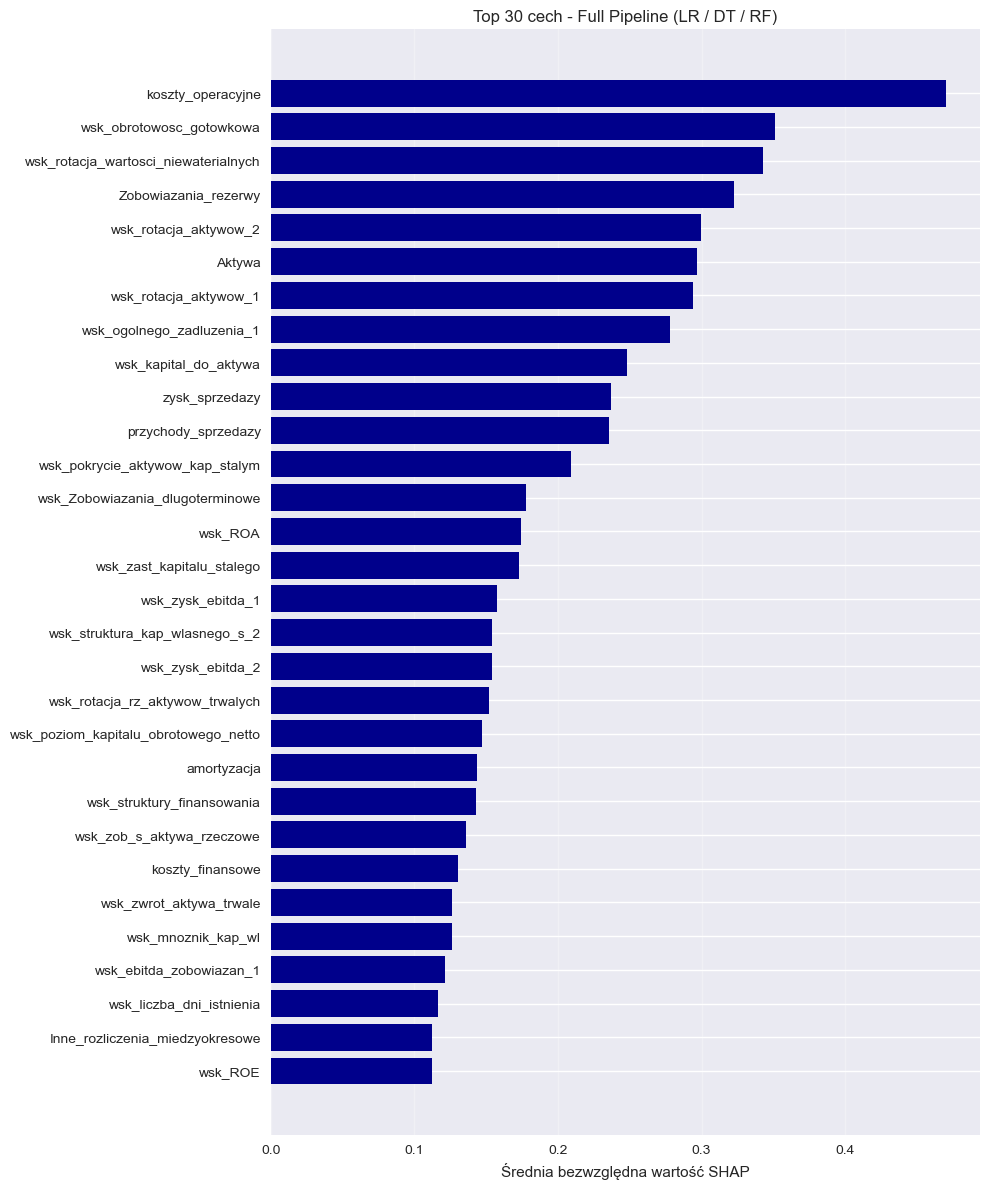

In [37]:
# Wykres Top 30 Full Pipeline
if shap_full_df is not None and len(full_top30_features) > 0:
    plot_df_full = shap_full_agg.head(30)
    plt.figure(figsize=(10,12))
    plt.barh(plot_df_full['feature'][::-1], plot_df_full['SHAP_mean'][::-1], color='darkblue')
    plt.xlabel('Średnia bezwzględna wartość SHAP')
    plt.title('Top 30 cech - Full Pipeline (LR / DT / RF)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Brak danych do wykresu Full Pipeline SHAP.')

## 13. Feature Importance z SHAP (Minimal Pipeline: LR, DT, RF)

Analiza ważności cech przy użyciu biblioteki SHAP dla minimalnego pipeline'u.

In [38]:
# SHAP Minimal Pipeline (LR, DT, RF)
print("="*100)
print("SHAP Feature Importance - Minimal Pipeline (LR, DT, RF)")
print("="*100)

try:
    import shap
    SHAP_AVAILABLE_MIN = True
except ImportError:
    SHAP_AVAILABLE_MIN = False
    print("⚠️  Brak biblioteki 'shap' (pip install shap)")

minimal_top30_features = []
shap_min_df = None

if SHAP_AVAILABLE_MIN:
    # Przygotowanie losowej próbki danych treningowych
    sample_size = min(1000, len(X_train_minimal))
    X_sample_min = X_train_minimal.sample(n=sample_size, random_state=42)
    
    shap_results_min = []
    
    # 1. LOGISTIC REGRESSION (Minimal)
    print("\n[1/3] Obliczanie SHAP dla Logistic Regression (Minimal)...")
    explainer_lr_min = shap.LinearExplainer(lr_minimal, X_sample_min)
    shap_values_lr_min = explainer_lr_min.shap_values(X_sample_min)
    
    # Jeśli jest to klasyfikacja binarna i shap_values to lista
    if type(shap_values_lr_min) == list:
        shap_values_lr_min = shap_values_lr_min[1]
    
    shap_abs_mean_lr_min = np.abs(shap_values_lr_min).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_min.columns):
        shap_results_min.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_lr_min[i],
            'model': 'LR'
        })
    
    # 2. DECISION TREE (Minimal)
    print("[2/3] Obliczanie SHAP dla Decision Tree (Minimal)...")
    explainer_dt_min = shap.TreeExplainer(dt_minimal)
    shap_values_dt_min = explainer_dt_min.shap_values(X_sample_min)
    
    if type(shap_values_dt_min) == list:
        shap_values_dt_min = shap_values_dt_min[1]
    
    shap_abs_mean_dt_min = np.abs(shap_values_dt_min).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_min.columns):
        shap_results_min.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_dt_min[i],
            'model': 'DT'
        })
    
    # 3. RANDOM FOREST (Minimal)
    print("[3/3] Obliczanie SHAP dla Random Forest (Minimal)...")
    explainer_rf_min = shap.TreeExplainer(rf_blackbox)
    shap_values_rf_min = explainer_rf_min.shap_values(X_sample_min)
    
    if type(shap_values_rf_min) == list:
        shap_values_rf_min = shap_values_rf_min[1]
    
    shap_abs_mean_rf_min = np.abs(shap_values_rf_min).mean(axis=0)
    
    for i, feat_name in enumerate(X_sample_min.columns):
        shap_results_min.append({
            'feature': feat_name,
            'SHAP_mean': shap_abs_mean_rf_min[i],
            'model': 'RF'
        })
    
    # Agregacja wyników - średnia z LR, DT i RF
    shap_min_df = pd.DataFrame(shap_results_min)
    shap_min_agg = shap_min_df.groupby('feature')['SHAP_mean'].mean().reset_index()
    shap_min_agg['SHAP_mean'] = shap_min_agg['SHAP_mean'].apply(
    lambda x: float(np.mean(x)) if isinstance(x, (list, np.ndarray)) else float(x)
)
    shap_min_agg = shap_min_agg.sort_values('SHAP_mean', ascending=False)
    
    minimal_top30_features = shap_min_agg.head(30)['feature'].tolist()
    
    print("\n✅ Obliczenia SHAP zakończone (Minimal Pipeline).")
    print(f"Top 30 cech: {len(minimal_top30_features)} cech wybranych.")
else:
    print("⚠️ SHAP niedostępny - pomiń ten krok lub zainstaluj: pip install shap")

SHAP Feature Importance - Minimal Pipeline (LR, DT, RF)

[1/3] Obliczanie SHAP dla Logistic Regression (Minimal)...
[2/3] Obliczanie SHAP dla Decision Tree (Minimal)...
[3/3] Obliczanie SHAP dla Random Forest (Minimal)...

✅ Obliczenia SHAP zakończone (Minimal Pipeline).
Top 30 cech: 30 cech wybranych.


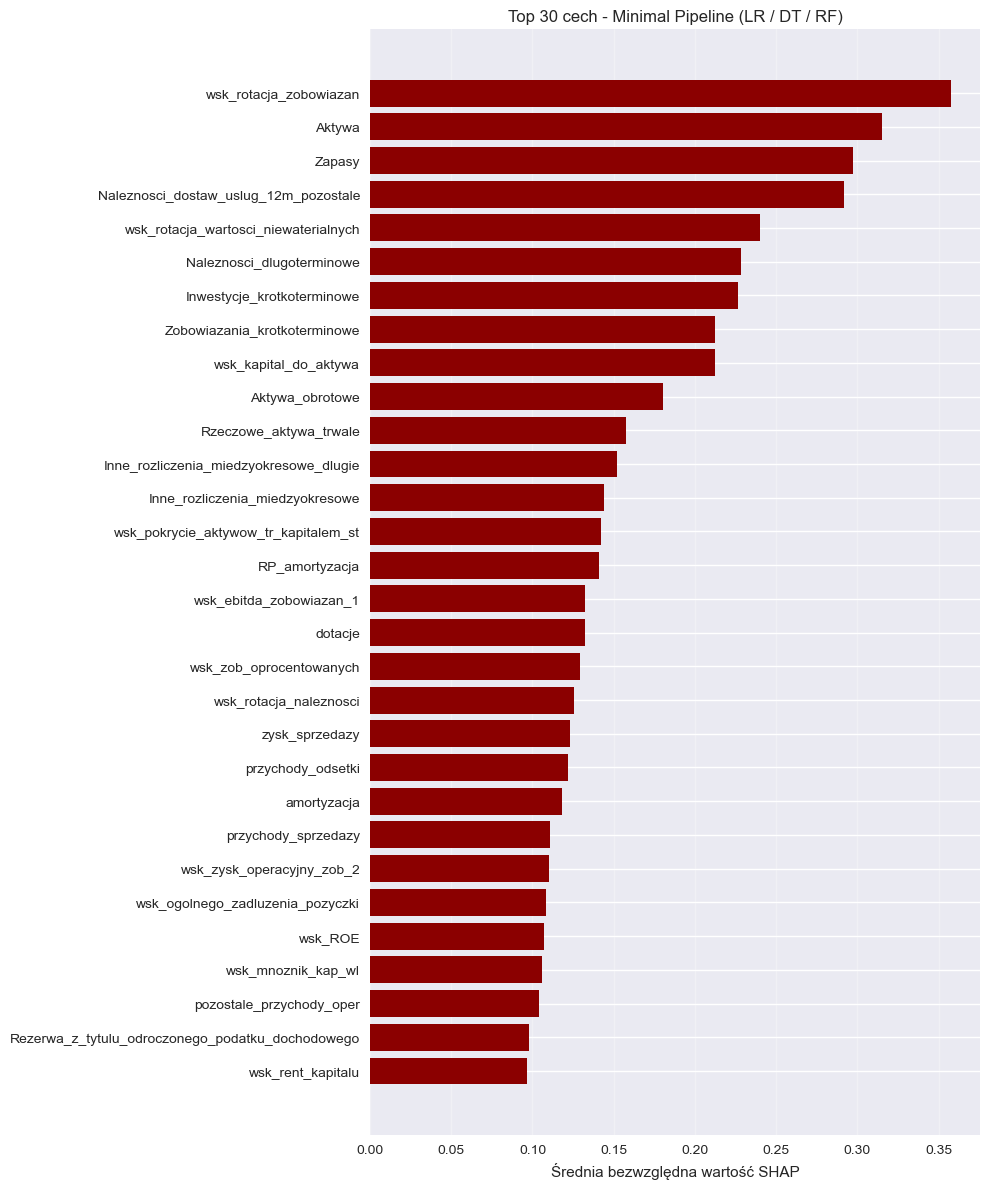

In [39]:
# Wykres Top 30 Minimal Pipeline
if shap_min_df is not None and len(minimal_top30_features) > 0:
    plot_df_min = shap_min_agg.head(30)
    plt.figure(figsize=(10,12))
    plt.barh(plot_df_min['feature'][::-1], plot_df_min['SHAP_mean'][::-1], color='darkred')
    plt.xlabel('Średnia bezwzględna wartość SHAP')
    plt.title('Top 30 cech - Minimal Pipeline (LR / DT / RF)')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ Brak danych do wykresu Minimal Pipeline SHAP.')

## 14. Modele na Top 30 cechach (Full Pipeline)

Trening modeli Logistic Regression, Decision Tree i Random Forest na 30 najważniejszych cechach wybranych przez SHAP dla pełnego pipeline'u.

In [40]:
# Modele na Top 30 cechach - Full Pipeline
print("="*100)
print("TRENOWANIE MODELI NA TOP 30 CECHACH - FULL PIPELINE")
print("="*100)

if len(full_top30_features) > 0:
    # Wybór tylko top 30 cech
    X_train_full_top30 = X_train_full[full_top30_features]
    X_test_full_top30 = X_test_full[full_top30_features]
    
    print(f"\nWybrano {len(full_top30_features)} cech z {X_train_full.shape[1]} dostępnych.")
    print(f"Kształt danych treningowych: {X_train_full_top30.shape}")
    print(f"Kształt danych testowych: {X_test_full_top30.shape}")
    
    results_full_top30 = {}
    
    # 1. LOGISTIC REGRESSION
    print("\n[1/3] Trening Logistic Regression na Top 30 cechach (Full)...")
    lr_full_top30 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    lr_full_top30.fit(X_train_full_top30, y_train)
    y_pred_lr_full_top30 = lr_full_top30.predict(X_test_full_top30)
    y_proba_lr_full_top30 = lr_full_top30.predict_proba(X_test_full_top30)[:, 1]
    
    results_full_top30['LR'] = {
        'model': lr_full_top30,
        'y_pred': y_pred_lr_full_top30,
        'y_proba': y_proba_lr_full_top30,
        'accuracy': accuracy_score(y_test, y_pred_lr_full_top30),
        'precision': precision_score(y_test, y_pred_lr_full_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_lr_full_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_lr_full_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_lr_full_top30)
    }
    print(f"  ✓ F1-Score: {results_full_top30['LR']['f1']:.4f}")
    
    # 2. DECISION TREE
    print("[2/3] Trening Decision Tree na Top 30 cechach (Full)...")
    dt_full_top30 = DecisionTreeClassifier(max_depth=5, min_samples_split=100, random_state=42, class_weight='balanced')
    dt_full_top30.fit(X_train_full_top30, y_train)
    y_pred_dt_full_top30 = dt_full_top30.predict(X_test_full_top30)
    y_proba_dt_full_top30 = dt_full_top30.predict_proba(X_test_full_top30)[:, 1]
    
    results_full_top30['DT'] = {
        'model': dt_full_top30,
        'y_pred': y_pred_dt_full_top30,
        'y_proba': y_proba_dt_full_top30,
        'accuracy': accuracy_score(y_test, y_pred_dt_full_top30),
        'precision': precision_score(y_test, y_pred_dt_full_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_dt_full_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_dt_full_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_dt_full_top30)
    }
    print(f"  ✓ F1-Score: {results_full_top30['DT']['f1']:.4f}")
    
    # 3. RANDOM FOREST
    print("[3/3] Trening Random Forest na Top 30 cechach (Full)...")
    rf_full_top30 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=50, random_state=42, class_weight='balanced')
    rf_full_top30.fit(X_train_full_top30, y_train)
    y_pred_rf_full_top30 = rf_full_top30.predict(X_test_full_top30)
    y_proba_rf_full_top30 = rf_full_top30.predict_proba(X_test_full_top30)[:, 1]
    
    results_full_top30['RF'] = {
        'model': rf_full_top30,
        'y_pred': y_pred_rf_full_top30,
        'y_proba': y_proba_rf_full_top30,
        'accuracy': accuracy_score(y_test, y_pred_rf_full_top30),
        'precision': precision_score(y_test, y_pred_rf_full_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_rf_full_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_rf_full_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_rf_full_top30)
    }
    print(f"  ✓ F1-Score: {results_full_top30['RF']['f1']:.4f}")
    
    # PODSUMOWANIE WYNIKÓW
    print("\n" + "="*100)
    print("PODSUMOWANIE WYNIKÓW - FULL PIPELINE TOP 30")
    print("="*100)
    print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'ROC-AUC':<12}")
    print("-"*100)
    
    for model_name, metrics in results_full_top30.items():
        print(f"{model_name:<20} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} "
              f"{metrics['recall']:<12.4f} {metrics['f1']:<12.4f} {metrics['roc_auc']:<12.4f}")
    
    print("\n✅ Trenowanie modeli na Top 30 cechach (Full Pipeline) zakończone.")
else:
    print("⚠️ Brak wybranych cech Top 30 dla Full Pipeline.")

TRENOWANIE MODELI NA TOP 30 CECHACH - FULL PIPELINE

Wybrano 30 cech z 165 dostępnych.
Kształt danych treningowych: (1800, 30)
Kształt danych testowych: (600, 30)

[1/3] Trening Logistic Regression na Top 30 cechach (Full)...
  ✓ F1-Score: 0.2320
[2/3] Trening Decision Tree na Top 30 cechach (Full)...
  ✓ F1-Score: 0.1762
[3/3] Trening Random Forest na Top 30 cechach (Full)...
  ✓ F1-Score: 0.3115

PODSUMOWANIE WYNIKÓW - FULL PIPELINE TOP 30
Model                Accuracy     Precision    Recall       F1-Score     ROC-AUC     
----------------------------------------------------------------------------------------------------
LR                   0.6800       0.1362       0.7838       0.2320       0.7775      
DT                   0.6883       0.1053       0.5405       0.1762       0.6767      
RF                   0.8600       0.2235       0.5135       0.3115       0.8087      

✅ Trenowanie modeli na Top 30 cechach (Full Pipeline) zakończone.


## 15. Modele na Top 30 cechach (Minimal Pipeline)

Trening modeli Logistic Regression, Decision Tree i Random Forest na 30 najważniejszych cechach wybranych przez SHAP dla minimalnego pipeline'u.

In [41]:
# Modele na Top 30 cechach - Minimal Pipeline
print("="*100)
print("TRENOWANIE MODELI NA TOP 30 CECHACH - MINIMAL PIPELINE")
print("="*100)

if len(minimal_top30_features) > 0:
    # Wybór tylko top 30 cech
    X_train_minimal_top30 = X_train_minimal[minimal_top30_features]
    X_test_minimal_top30 = X_test_minimal[minimal_top30_features]
    
    print(f"\nWybrano {len(minimal_top30_features)} cech z {X_train_minimal.shape[1]} dostępnych.")
    print(f"Kształt danych treningowych: {X_train_minimal_top30.shape}")
    print(f"Kształt danych testowych: {X_test_minimal_top30.shape}")
    
    results_minimal_top30 = {}
    
    # 1. LOGISTIC REGRESSION
    print("\n[1/3] Trening Logistic Regression na Top 30 cechach (Minimal)...")
    lr_minimal_top30 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
    lr_minimal_top30.fit(X_train_minimal_top30, y_train)
    y_pred_lr_minimal_top30 = lr_minimal_top30.predict(X_test_minimal_top30)
    y_proba_lr_minimal_top30 = lr_minimal_top30.predict_proba(X_test_minimal_top30)[:, 1]
    
    results_minimal_top30['LR'] = {
        'model': lr_minimal_top30,
        'y_pred': y_pred_lr_minimal_top30,
        'y_proba': y_proba_lr_minimal_top30,
        'accuracy': accuracy_score(y_test, y_pred_lr_minimal_top30),
        'precision': precision_score(y_test, y_pred_lr_minimal_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_lr_minimal_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_lr_minimal_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_lr_minimal_top30)
    }
    print(f"  ✓ F1-Score: {results_minimal_top30['LR']['f1']:.4f}")
    
    # 2. DECISION TREE
    print("[2/3] Trening Decision Tree na Top 30 cechach (Minimal)...")
    dt_minimal_top30 = DecisionTreeClassifier(max_depth=5, min_samples_split=100, random_state=42, class_weight='balanced')
    dt_minimal_top30.fit(X_train_minimal_top30, y_train)
    y_pred_dt_minimal_top30 = dt_minimal_top30.predict(X_test_minimal_top30)
    y_proba_dt_minimal_top30 = dt_minimal_top30.predict_proba(X_test_minimal_top30)[:, 1]
    
    results_minimal_top30['DT'] = {
        'model': dt_minimal_top30,
        'y_pred': y_pred_dt_minimal_top30,
        'y_proba': y_proba_dt_minimal_top30,
        'accuracy': accuracy_score(y_test, y_pred_dt_minimal_top30),
        'precision': precision_score(y_test, y_pred_dt_minimal_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_dt_minimal_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_dt_minimal_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_dt_minimal_top30)
    }
    print(f"  ✓ F1-Score: {results_minimal_top30['DT']['f1']:.4f}")
    
    # 3. RANDOM FOREST
    print("[3/3] Trening Random Forest na Top 30 cechach (Minimal)...")
    rf_minimal_top30 = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=50, random_state=42, class_weight='balanced')
    rf_minimal_top30.fit(X_train_minimal_top30, y_train)
    y_pred_rf_minimal_top30 = rf_minimal_top30.predict(X_test_minimal_top30)
    y_proba_rf_minimal_top30 = rf_minimal_top30.predict_proba(X_test_minimal_top30)[:, 1]
    
    results_minimal_top30['RF'] = {
        'model': rf_minimal_top30,
        'y_pred': y_pred_rf_minimal_top30,
        'y_proba': y_proba_rf_minimal_top30,
        'accuracy': accuracy_score(y_test, y_pred_rf_minimal_top30),
        'precision': precision_score(y_test, y_pred_rf_minimal_top30, zero_division=0),
        'recall': recall_score(y_test, y_pred_rf_minimal_top30, zero_division=0),
        'f1': f1_score(y_test, y_pred_rf_minimal_top30, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_rf_minimal_top30)
    }
    print(f"  ✓ F1-Score: {results_minimal_top30['RF']['f1']:.4f}")
    
    # PODSUMOWANIE WYNIKÓW
    print("\n" + "="*100)
    print("PODSUMOWANIE WYNIKÓW - MINIMAL PIPELINE TOP 30")
    print("="*100)
    print(f"{'Model':<20} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'ROC-AUC':<12}")
    print("-"*100)
    
    for model_name, metrics in results_minimal_top30.items():
        print(f"{model_name:<20} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} "
              f"{metrics['recall']:<12.4f} {metrics['f1']:<12.4f} {metrics['roc_auc']:<12.4f}")
    
    print("\n✅ Trenowanie modeli na Top 30 cechach (Minimal Pipeline) zakończone.")
else:
    print("⚠️ Brak wybranych cech Top 30 dla Minimal Pipeline.")

TRENOWANIE MODELI NA TOP 30 CECHACH - MINIMAL PIPELINE

Wybrano 30 cech z 136 dostępnych.
Kształt danych treningowych: (1800, 30)
Kształt danych testowych: (600, 30)

[1/3] Trening Logistic Regression na Top 30 cechach (Minimal)...
  ✓ F1-Score: 0.1883
[2/3] Trening Decision Tree na Top 30 cechach (Minimal)...
  ✓ F1-Score: 0.1899
[3/3] Trening Random Forest na Top 30 cechach (Minimal)...
  ✓ F1-Score: 0.2203

PODSUMOWANIE WYNIKÓW - MINIMAL PIPELINE TOP 30
Model                Accuracy     Precision    Recall       F1-Score     ROC-AUC     
----------------------------------------------------------------------------------------------------
LR                   0.6983       0.1129       0.5676       0.1883       0.7219      
DT                   0.5733       0.1075       0.8108       0.1899       0.6690      
RF                   0.8467       0.1605       0.3514       0.2203       0.7901      

✅ Trenowanie modeli na Top 30 cechach (Minimal Pipeline) zakończone.


## 16. Porównanie: Wszystkie cechy vs Top 30 cech

Wizualizacja porównująca wyniki modeli na wszystkich cechach z wynikami na Top 30 cechach wybranych przez SHAP.

PORÓWNANIE: WSZYSTKIE CECHY VS TOP 30 CECH


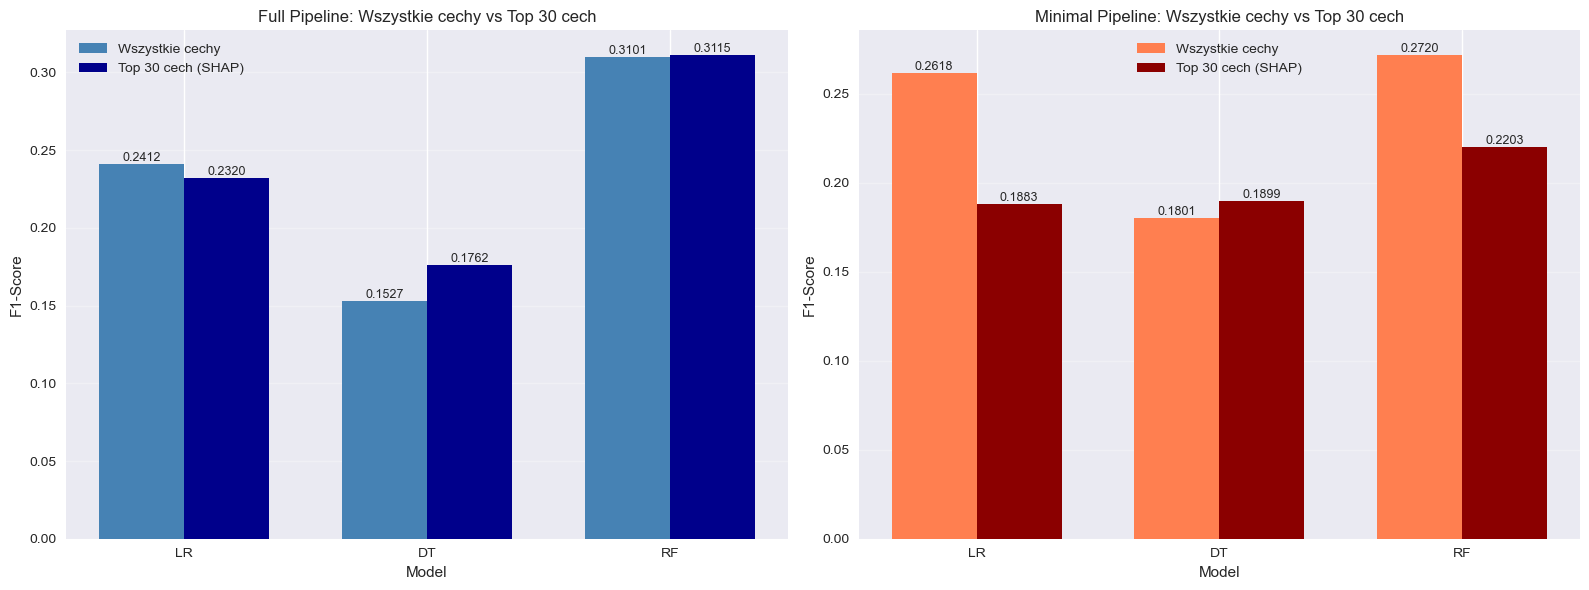


✅ Porównanie wyników zakończone.


In [42]:
# Porównanie wyników: Wszystkie cechy vs Top 30 cech
print("="*100)
print("PORÓWNANIE: WSZYSTKIE CECHY VS TOP 30 CECH")
print("="*100)

# Przygotowanie danych do porównania
comparison_data_top30 = []

# FULL PIPELINE
if len(full_top30_features) > 0:
    # Wszystkie cechy Full
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'All',
        'Model': 'LR',
        'F1-Score': results_full['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'All',
        'Model': 'DT',
        'F1-Score': results_full['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'All',
        'Model': 'RF',
        'F1-Score': results_blackbox_full['RF']['f1']
    })
    
    # Top 30 Full
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'Top30',
        'Model': 'LR',
        'F1-Score': results_full_top30['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'Top30',
        'Model': 'DT',
        'F1-Score': results_full_top30['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Full',
        'Features': 'Top30',
        'Model': 'RF',
        'F1-Score': results_full_top30['RF']['f1']
    })

# MINIMAL PIPELINE
if len(minimal_top30_features) > 0:
    # Wszystkie cechy Minimal
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'All',
        'Model': 'LR',
        'F1-Score': results_minimal['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'All',
        'Model': 'DT',
        'F1-Score': results_minimal['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'All',
        'Model': 'RF',
        'F1-Score': results_blackbox['RF']['f1']
    })
    
    # Top 30 Minimal
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'Top30',
        'Model': 'LR',
        'F1-Score': results_minimal_top30['LR']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'Top30',
        'Model': 'DT',
        'F1-Score': results_minimal_top30['DT']['f1']
    })
    comparison_data_top30.append({
        'Pipeline': 'Minimal',
        'Features': 'Top30',
        'Model': 'RF',
        'F1-Score': results_minimal_top30['RF']['f1']
    })

comparison_df_top30 = pd.DataFrame(comparison_data_top30)

# Wykres porównawczy
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full Pipeline
full_data = comparison_df_top30[comparison_df_top30['Pipeline'] == 'Full']
x_labels = ['LR', 'DT', 'RF']
all_features_full = [full_data[(full_data['Model'] == m) & (full_data['Features'] == 'All')]['F1-Score'].values[0] 
                     for m in x_labels]
top30_features_full = [full_data[(full_data['Model'] == m) & (full_data['Features'] == 'Top30')]['F1-Score'].values[0] 
                       for m in x_labels]

x_pos = np.arange(len(x_labels))
width = 0.35

bars1 = axes[0].bar(x_pos - width/2, all_features_full, width, label='Wszystkie cechy', color='steelblue')
bars2 = axes[0].bar(x_pos + width/2, top30_features_full, width, label='Top 30 cech (SHAP)', color='darkblue')

axes[0].set_xlabel('Model')
axes[0].set_ylabel('F1-Score')
axes[0].set_title('Full Pipeline: Wszystkie cechy vs Top 30 cech')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(x_labels)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Dodanie wartości na słupkach
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

# Minimal Pipeline
minimal_data = comparison_df_top30[comparison_df_top30['Pipeline'] == 'Minimal']
all_features_minimal = [minimal_data[(minimal_data['Model'] == m) & (minimal_data['Features'] == 'All')]['F1-Score'].values[0] 
                        for m in x_labels]
top30_features_minimal = [minimal_data[(minimal_data['Model'] == m) & (minimal_data['Features'] == 'Top30')]['F1-Score'].values[0] 
                          for m in x_labels]

bars3 = axes[1].bar(x_pos - width/2, all_features_minimal, width, label='Wszystkie cechy', color='coral')
bars4 = axes[1].bar(x_pos + width/2, top30_features_minimal, width, label='Top 30 cech (SHAP)', color='darkred')

axes[1].set_xlabel('Model')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('Minimal Pipeline: Wszystkie cechy vs Top 30 cech')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(x_labels)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Dodanie wartości na słupkach
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✅ Porównanie wyników zakończone.")

---

# 🏦 CZĘŚĆ III: ADVANCED SCORECARDS

## 8. Feature Engineering dla Banking

W tej sekcji stworzymy modele wykorzystujące profesjonalne techniki stosowane w bankowości:

## 🎯 Zastosowane techniki:

### 1. **Domain Knowledge Feature Engineering**
- Wskaźniki zadłużenia (debt-to-income ratios)
- Wskaźniki wykorzystania kredytu (utilization rates)
- Agregaty historii kredytowej
- Interakcje między zmiennymi biznesowymi

### 2. **Advanced Feature Selection**
- **Variance Inflation Factor (VIF)** - usuwanie wielokolinearności (standard w modelach bankowych)
- **Weight of Evidence (WoE) binning** - transformacja i optymalizacja zmiennych
- **Information Value (IV)** - rankowanie mocy predykcyjnej zmiennych
- **Correlation clustering** - grupowanie i selekcja reprezentatywnych zmiennych

### 3. **Banking Best Practices**

- Fine-class binning dla zmiennych ciągłych- Wybór jednej reprezentatywnej zmiennej z klastrów skorelowanych (r>0.8)

- Monotonic WoE constraints dla interpretowalności
- Usuwanie zmiennych ze zbyt wysokim VIF (>10)

## 8.1 Domain Knowledge Feature Engineering

In [43]:
print("🔨 FEATURE ENGINEERING - Tworzenie zmiennych domenowych...")
print("="*80)

# Zaczynamy od danych Full Pipeline (najbardziej kompletnych)
# WAŻNE: Tworzymy również dla validation set!
X_train_advanced = X_train_full.copy()
X_test_advanced = X_test_full.copy()
X_val_advanced = X_val_full.copy()  # DODANO dla Grid Search

print(f"📋 Dostępne kolumny: {X_train_advanced.shape[1]} zmiennych")
print(f"   Przykłady: {list(X_train_advanced.columns[:10])}")
print(f"📦 Zbiory: Train {X_train_advanced.shape}, Val {X_val_advanced.shape}, Test {X_test_advanced.shape}")

# Znajdź kolumny numeryczne (główne cechy, nie one-hot encoded)
numeric_cols = X_train_advanced.select_dtypes(include=[np.number]).columns.tolist()
main_features = [col for col in numeric_cols if not any(x in col for x in ['_0', '_1', '_2', '_3', 'JOB_', 'REASON_'])]

print(f"\n📊 Zmienne numeryczne (główne): {len(main_features)}")
print(f"   {main_features[:15]}")

# ============================================
# 1. WSKAŹNIKI FINANSOWE PRZEDSIĘBIORSTW
# ============================================
print("\n1️⃣  Wskaźniki finansowe (banking standards)")
print("-"*80)

created_features = []

# Wskaźniki płynności
if 'Aktywa_obrotowe' in main_features and 'Zobowiazania_krotkoterminowe' in main_features:
    # Current Ratio - wskaźnik płynności bieżącej
    X_train_advanced['current_ratio'] = X_train_advanced['Aktywa_obrotowe'] / (X_train_advanced['Zobowiazania_krotkoterminowe'] + 1)
    X_val_advanced['current_ratio'] = X_val_advanced['Aktywa_obrotowe'] / (X_val_advanced['Zobowiazania_krotkoterminowe'] + 1)
    X_test_advanced['current_ratio'] = X_test_advanced['Aktywa_obrotowe'] / (X_test_advanced['Zobowiazania_krotkoterminowe'] + 1)
    created_features.append('current_ratio')
    print(f"   ✓ current_ratio (wskaźnik płynności)")

# Wskaźnik zadłużenia
if 'Zobowiazania' in main_features and 'Aktywa' in main_features:
    # Debt Ratio
    X_train_advanced['debt_ratio'] = X_train_advanced['Zobowiazania'] / (X_train_advanced['Aktywa'] + 1)
    X_val_advanced['debt_ratio'] = X_val_advanced['Zobowiazania'] / (X_val_advanced['Aktywa'] + 1)
    X_test_advanced['debt_ratio'] = X_test_advanced['Zobowiazania'] / (X_test_advanced['Aktywa'] + 1)
    created_features.append('debt_ratio')
    print(f"   ✓ debt_ratio (wskaźnik zadłużenia)")

# ============================================
# 2. WSKAŹNIKI RENTOWNOŚCI
# ============================================
print("\n2️⃣  Wskaźniki rentowności")
print("-"*80)

# ROA - Return on Assets
if 'Wynik_netto' in main_features and 'Aktywa' in main_features:
    X_train_advanced['roa'] = X_train_advanced['Wynik_netto'] / (X_train_advanced['Aktywa'] + 1)
    X_val_advanced['roa'] = X_val_advanced['Wynik_netto'] / (X_val_advanced['Aktywa'] + 1)
    X_test_advanced['roa'] = X_test_advanced['Wynik_netto'] / (X_test_advanced['Aktywa'] + 1)
    created_features.append('roa')
    print(f"   ✓ ROA (zwrot z aktywów)")

# ROE - Return on Equity
if 'Wynik_netto' in main_features and 'Kapital_wlasny' in main_features:
    X_train_advanced['roe'] = X_train_advanced['Wynik_netto'] / (X_train_advanced['Kapital_wlasny'] + 1)
    X_val_advanced['roe'] = X_val_advanced['Wynik_netto'] / (X_val_advanced['Kapital_wlasny'] + 1)
    X_test_advanced['roe'] = X_test_advanced['Wynik_netto'] / (X_test_advanced['Kapital_wlasny'] + 1)
    created_features.append('roe')
    print(f"   ✓ ROE (zwrot z kapitału)")

# Marża zysku
if 'Wynik_netto' in main_features and 'Przychody_netto_ze_sprzedazy' in main_features:
    X_train_advanced['profit_margin'] = X_train_advanced['Wynik_netto'] / (X_train_advanced['Przychody_netto_ze_sprzedazy'] + 1)
    X_val_advanced['profit_margin'] = X_val_advanced['Wynik_netto'] / (X_val_advanced['Przychody_netto_ze_sprzedazy'] + 1)
    X_test_advanced['profit_margin'] = X_test_advanced['Wynik_netto'] / (X_test_advanced['Przychody_netto_ze_sprzedazy'] + 1)
    created_features.append('profit_margin')
    print(f"   ✓ profit_margin (marża zysku)")

# ============================================
# 3. WSKAŹNIKI EFEKTYWNOŚCI
# ============================================
print("\n3️⃣  Wskaźniki efektywności operacyjnej")
print("-"*80)

# Rotacja aktywów
if 'Przychody_netto_ze_sprzedazy' in main_features and 'Aktywa' in main_features:
    X_train_advanced['asset_turnover'] = X_train_advanced['Przychody_netto_ze_sprzedazy'] / (X_train_advanced['Aktywa'] + 1)
    X_val_advanced['asset_turnover'] = X_val_advanced['Przychody_netto_ze_sprzedazy'] / (X_val_advanced['Aktywa'] + 1)
    X_test_advanced['asset_turnover'] = X_test_advanced['Przychody_netto_ze_sprzedazy'] / (X_test_advanced['Aktywa'] + 1)
    created_features.append('asset_turnover')
    print(f"   ✓ asset_turnover (rotacja aktywów)")

# Rotacja zapasów
if 'Koszty_sprzedanych_produktow' in main_features and 'Zapasy' in main_features:
    X_train_advanced['inventory_turnover'] = X_train_advanced['Koszty_sprzedanych_produktow'] / (X_train_advanced['Zapasy'] + 1)
    X_val_advanced['inventory_turnover'] = X_val_advanced['Koszty_sprzedanych_produktow'] / (X_val_advanced['Zapasy'] + 1)
    X_test_advanced['inventory_turnover'] = X_test_advanced['Koszty_sprzedanych_produktow'] / (X_test_advanced['Zapasy'] + 1)
    created_features.append('inventory_turnover')
    print(f"   ✓ inventory_turnover (rotacja zapasów)")

# ============================================
# 4. STRUKTURA KAPITAŁOWA
# ============================================
print("\n4️⃣  Wskaźniki struktury kapitałowej")
print("-"*80)
if 'Kapital_wlasny' in main_features and 'Aktywa' in main_features:
    X_train_advanced['equity_ratio'] = X_train_advanced['Kapital_wlasny'] / (X_train_advanced['Aktywa'] + 1)
    X_val_advanced['equity_ratio'] = X_val_advanced['Kapital_wlasny'] / (X_val_advanced['Aktywa'] + 1)
    X_test_advanced['equity_ratio'] = X_test_advanced['Kapital_wlasny'] / (X_test_advanced['Aktywa'] + 1)
    created_features.append('equity_ratio')
    print(f"   ✓ equity_ratio (udział kapitału własnego)")

# Leverage (dźwignia finansowa)
if 'Aktywa' in main_features and 'Kapital_wlasny' in main_features:
    X_train_advanced['leverage'] = X_train_advanced['Aktywa'] / (X_train_advanced['Kapital_wlasny'] + 1)
    X_val_advanced['leverage'] = X_val_advanced['Aktywa'] / (X_val_advanced['Kapital_wlasny'] + 1)
    X_test_advanced['leverage'] = X_test_advanced['Aktywa'] / (X_test_advanced['Kapital_wlasny'] + 1)
    created_features.append('leverage')
    print(f"   ✓ leverage (dźwignia finansowa)")

# ============================================
# 5. INTERAKCJE I WSKAŹNIKI ZŁOŻONE
# ============================================
print("\n5️⃣  Wskaźniki złożone i interakcje")
print("-"*80)
if 'Aktywa_obrotowe' in main_features and 'Zobowiazania_krotkoterminowe' in main_features:
    X_train_advanced['working_capital'] = X_train_advanced['Aktywa_obrotowe'] - X_train_advanced['Zobowiazania_krotkoterminowe']
    X_val_advanced['working_capital'] = X_val_advanced['Aktywa_obrotowe'] - X_val_advanced['Zobowiazania_krotkoterminowe']
    X_test_advanced['working_capital'] = X_test_advanced['Aktywa_obrotowe'] - X_test_advanced['Zobowiazania_krotkoterminowe']
    created_features.append('working_capital')
    print(f"   ✓ working_capital (kapitał obrotowy)")

# Wskaźnik wielkości firmy (log assets)
if 'Aktywa' in main_features:
    X_train_advanced['log_assets'] = np.log1p(X_train_advanced['Aktywa'])
    X_val_advanced['log_assets'] = np.log1p(X_val_advanced['Aktywa'])
    X_test_advanced['log_assets'] = np.log1p(X_test_advanced['Aktywa'])
    created_features.append('log_assets')
    print(f"   ✓ log_assets (logarytm aktywów)")

# Wiek firmy (jeśli jest dostępny)
if 'wsk_liczba_dni_istnienia' in main_features:
    X_train_advanced['company_age_years'] = X_train_advanced['wsk_liczba_dni_istnienia'] / 365.25
    X_val_advanced['company_age_years'] = X_val_advanced['wsk_liczba_dni_istnienia'] / 365.25
    X_test_advanced['company_age_years'] = X_test_advanced['wsk_liczba_dni_istnienia'] / 365.25
    created_features.append('company_age_years')
    print(f"   ✓ company_age_years (wiek firmy w latach)")

# ============================================
# PODSUMOWANIE
# ============================================
print("\n" + "="*80)
new_features = set(X_train_advanced.columns) - set(X_train_full.columns)
print(f"✅ Utworzono {len(new_features)} nowych zmiennych domenowych:")
for feat in sorted(new_features):
    print(f"   • {feat}")

print(f"\n📊 Nowy wymiar danych:")
print(f"   Train: {X_train_advanced.shape}")
print(f"   Val:   {X_val_advanced.shape}")
print(f"   Test:  {X_test_advanced.shape}")
print("="*80)

🔨 FEATURE ENGINEERING - Tworzenie zmiennych domenowych...
📋 Dostępne kolumny: 165 zmiennych
   Przykłady: ['formaWlasnosci_Symbol', 'pkdKod', 'wsk_liczba_dni_istnienia', 'Aktywa', 'Aktywa_trwale', 'Rzeczowe_aktywa_trwale', 'Inwestycje_dlugoterminowe', 'Aktywa_obrotowe', 'Zapasy', 'Naleznosci_krotkoterminowe']
📦 Zbiory: Train (1800, 165), Val (600, 165), Test (600, 165)

📊 Zmienne numeryczne (główne): 120
   ['formaWlasnosci_Symbol', 'pkdKod', 'wsk_liczba_dni_istnienia', 'Aktywa', 'Aktywa_trwale', 'Rzeczowe_aktywa_trwale', 'Inwestycje_dlugoterminowe', 'Aktywa_obrotowe', 'Zapasy', 'Naleznosci_krotkoterminowe', 'Inwestycje_krotkoterminowe', 'Srodki_pieniezne', 'Rozliczenia_miedzyokresowe_krotkie', 'Kapital_wlasny', 'Kapital_podstawowy']

1️⃣  Wskaźniki finansowe (banking standards)
--------------------------------------------------------------------------------
   ✓ current_ratio (wskaźnik płynności)

2️⃣  Wskaźniki rentowności
-------------------------------------------------------------

## 8.2 Variance Inflation Factor (VIF) - Usuwanie Wielokolinearności

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Funkcja do obliczania VIF
def calculate_vif(df):
    """Oblicza VIF dla wszystkich zmiennych numerycznych"""
    vif_data = []
    numeric_df = df.select_dtypes(include=[np.number])
    
    for i, col in enumerate(numeric_df.columns):
        try:
            vif = variance_inflation_factor(numeric_df.values, i)
            vif_data.append({'feature': col, 'VIF': vif})
        except:
            vif_data.append({'feature': col, 'VIF': np.inf})
    
    return pd.DataFrame(vif_data).sort_values('VIF', ascending=False)

# Iteracyjne usuwanie zmiennych z wysokim VIF
def remove_high_vif_features(X, threshold=10.0, max_iterations=20):
    """Iteracyjnie usuwa zmienne z VIF > threshold (standard bankowy)"""
    X_clean = X.copy()
    removed_features = []
    
    for iteration in range(max_iterations):
        vif_df = calculate_vif(X_clean)
        high_vif = vif_df[vif_df['VIF'] > threshold]
        
        if len(high_vif) == 0:
            break
        
        worst_feature = high_vif.iloc[0]['feature']
        worst_vif = high_vif.iloc[0]['VIF']
        X_clean = X_clean.drop(columns=[worst_feature])
        removed_features.append((worst_feature, worst_vif))
    
    return X_clean, removed_features, vif_df

# Zastosuj VIF cleaning
print("📊 VIF ANALYSIS - Usuwanie wielokolinearności (VIF > 10)")
print("="*80)

X_train_vif, removed_vif, final_vif = remove_high_vif_features(X_train_advanced, threshold=10.0)
X_val_vif = X_val_advanced[X_train_vif.columns]  # DODANO
X_test_vif = X_test_advanced[X_train_vif.columns]

# Podsumowanie
print(f"✅ Usunięto {len(removed_vif)} zmiennych z wysoką wielokolinearność")
print(f"📊 Pozostało: Train {X_train_vif.shape[1]}, Val {X_val_vif.shape[1]}, Test {X_test_vif.shape[1]} zmiennych (było {X_train_advanced.shape[1]})")
print("="*80)

📊 VIF ANALYSIS - Usuwanie wielokolinearności (VIF > 10)
✅ Usunięto 20 zmiennych z wysoką wielokolinearność
📊 Pozostało: Train 151, Val 151, Test 151 zmiennych (było 171)


## 8.3 Correlation Clustering - Wybór Reprezentatywnych Zmiennych

In [45]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

print("🔗 CORRELATION CLUSTERING - Grupowanie skorelowanych zmiennych (r > 0.8)")
print("="*80)

# Oblicz macierz korelacji
corr_matrix = X_train_vif.corr().abs()

# Usuń NaN z macierzy korelacji (zastąp zerem - brak korelacji)
corr_matrix = corr_matrix.fillna(0)

# Clustering hierarchiczny
distance_matrix = 1 - corr_matrix.values
# Wymuś dokładną symetrię
distance_matrix = np.maximum(distance_matrix, distance_matrix.T)
np.fill_diagonal(distance_matrix, 0)

# Usuń inf/nan wartości (zamień na maksymalną odległość = 1)
distance_matrix = np.nan_to_num(distance_matrix, nan=1.0, posinf=1.0, neginf=1.0)

# Zaokrąglij aby usunąć błędy numeryczne
distance_matrix = np.round(distance_matrix, decimals=10)
condensed_dist = squareform(distance_matrix, checks=False)
linkage_matrix = hierarchy.linkage(condensed_dist, method='average')
clusters = hierarchy.fcluster(linkage_matrix, t=0.2, criterion='distance')

# Przypisz zmienne do klastrów
cluster_dict = {}
for feature, cluster_id in zip(corr_matrix.columns, clusters):
    if cluster_id not in cluster_dict:
        cluster_dict[cluster_id] = []
    cluster_dict[cluster_id].append(feature)

# Funkcja do obliczania IV
def calculate_iv_for_selection(X, y, feature, bins=10):
    """Szybka kalkulacja IV dla selekcji zmiennych"""
    try:
        df_temp = pd.DataFrame({'feature': X[feature], 'target': y}).dropna()
        
        try:
            df_temp['bin'] = pd.qcut(df_temp['feature'], q=bins, duplicates='drop')
        except:
            try:
                df_temp['bin'] = pd.cut(df_temp['feature'], bins=bins, duplicates='drop')
            except:
                return 0.0
        
        grouped = df_temp.groupby('bin', observed=True)['target'].agg(['sum', 'count'])
        grouped.columns = ['bad', 'total']
        grouped['good'] = grouped['total'] - grouped['bad']
        
        total_good = grouped['good'].sum()
        total_bad = grouped['bad'].sum()
        
        if total_good == 0 or total_bad == 0:
            return 0.0
        
        grouped['good_dist'] = grouped['good'] / total_good
        grouped['bad_dist'] = grouped['bad'] / total_bad
        grouped['woe'] = np.log((grouped['good_dist'] + 0.0001) / (grouped['bad_dist'] + 0.0001))
        grouped['iv'] = (grouped['good_dist'] - grouped['bad_dist']) * grouped['woe']
        
        return grouped['iv'].sum()
    except:
        return 0.0

# Oblicz IV dla wszystkich zmiennych
iv_values = {feature: calculate_iv_for_selection(X_train_vif, y_train, feature) for feature in X_train_vif.columns}

# Wybierz najlepszą zmienną z każdego klastra (według IV)
selected_features = []
removed_by_clustering = []

for cluster_id, features in cluster_dict.items():
    if len(features) == 1:
        selected_features.append(features[0])
    else:
        cluster_ivs = sorted([(feat, iv_values.get(feat, 0)) for feat in features], key=lambda x: x[1], reverse=True)
        selected_features.append(cluster_ivs[0][0])
        
        for feat, iv in cluster_ivs[1:]:
            removed_by_clustering.append((feat, iv, cluster_ivs[0][0], cluster_ivs[0][1]))

# Zastosuj selekcję
X_train_clustered = X_train_vif[selected_features]
X_val_clustered = X_val_vif[selected_features]  # DODANO
X_test_clustered = X_test_vif[selected_features]

# Podsumowanie
print(f"✅ Usunięto {len(removed_by_clustering)} redundantnych zmiennych")
print(f"📊 Pozostało: Train {X_train_clustered.shape[1]}, Val {X_val_clustered.shape[1]}, Test {X_test_clustered.shape[1]} zmiennych (było {X_train_vif.shape[1]})")
print("="*80)

🔗 CORRELATION CLUSTERING - Grupowanie skorelowanych zmiennych (r > 0.8)
✅ Usunięto 26 redundantnych zmiennych
📊 Pozostało: Train 125, Val 125, Test 125 zmiennych (było 151)


## 8.4 WoE Transformation & Final Feature Selection

In [46]:
print("📊 WOE TRANSFORMATION & FINAL SELECTION")
print("="*80)
print("Stosujemy bankową transformację WoE i wybieramy top features według IV")
print("="*80)

# ============================================
# 1. Oblicz pełną tabelę IV dla pozostałych zmiennych
# ============================================
print("\n1️⃣  Obliczanie Information Value dla wszystkich zmiennych...")

iv_results_advanced = []
for feature in X_train_clustered.columns:
    iv_val = calculate_iv_for_selection(X_train_clustered, y_train, feature, bins=10)
    iv_results_advanced.append({'feature': feature, 'IV': iv_val})

iv_df_advanced = pd.DataFrame(iv_results_advanced).sort_values('IV', ascending=False)

# Kategoryzacja IV (standard bankowy)
def categorize_iv(iv):
    if iv < 0.02:
        return "❌ Unpredictive"
    elif iv < 0.1:
        return "⚠️  Weak"
    elif iv < 0.3:
        return "✓ Medium"
    elif iv < 0.5:
        return "✓✓ Strong"
    else:
        return "✓✓✓ Very Strong"

iv_df_advanced['category'] = iv_df_advanced['IV'].apply(categorize_iv)

print(f"   ✓ Obliczono IV dla {len(iv_df_advanced)} zmiennych")
print(f"\n📊 Rozkład mocy predykcyjnej:")
print(iv_df_advanced['category'].value_counts().to_string())

# ============================================
# 2. Wybór top features według IV
# ============================================
print("\n2️⃣  Wybór najlepszych zmiennych według IV...")
print("-"*80)

# Wybierz zmienne z IV > 0.02 (minimum predictive power)
iv_df_filtered = iv_df_advanced[iv_df_advanced['IV'] >= 0.02].copy()

# Wybierz top 30 zmiennych (standard w modelach bankowych)
n_features_final = min(30, len(iv_df_filtered))
top_features_advanced = iv_df_filtered.head(n_features_final)['feature'].tolist()

print(f"✓ Wybrano {n_features_final} zmiennych z IV ≥ 0.02")
print(f"\n🏆 Top 15 zmiennych według IV:")
print("-"*80)
for idx, row in iv_df_advanced.head(15).iterrows():
    print(f"   {idx+1:2d}. {row['feature']:<40} IV={row['IV']:.4f}  {row['category']}")

# ============================================
# 3. Przygotowanie finalnych danych
# ============================================
print("\n3️⃣  Przygotowanie finalnego datasetu...")
print("-"*80)

# Wybierz top features
X_train_advanced_raw = X_train_clustered[top_features_advanced].copy()
X_val_advanced_raw = X_val_clustered[top_features_advanced].copy()  # DODANO
X_test_advanced_raw = X_test_clustered[top_features_advanced].copy()

print(f"   ✓ Finalne dane: Train {X_train_advanced_raw.shape[1]}, Val {X_val_advanced_raw.shape[1]}, Test {X_test_advanced_raw.shape[1]} zmiennych (engineered features)")

# ============================================
# PODSUMOWANIE CAŁEGO PROCESU
# ============================================
print("\n" + "="*80)
print("✅ FEATURE ENGINEERING & SELECTION - PODSUMOWANIE")
print("="*80)
print(f"📌 Krok 1 - Feature Engineering:    {X_train_full.shape[1]} → {X_train_advanced.shape[1]} zmiennych (+{X_train_advanced.shape[1]-X_train_full.shape[1]} nowych)")
print(f"📌 Krok 2 - VIF Cleaning (>10):     {X_train_advanced.shape[1]} → {X_train_vif.shape[1]} zmiennych (-{len(removed_vif)} usuniętych)")
print(f"📌 Krok 3 - Correlation Clustering: {X_train_vif.shape[1]} → {X_train_clustered.shape[1]} zmiennych (-{len(removed_by_clustering)} redundantnych)")
print(f"📌 Krok 4 - IV Selection (top 30):  {X_train_clustered.shape[1]} → {n_features_final} zmiennych")

print(f"\n🎯 Finalne datasety dla modeli:")
print(f"   • X_train_advanced_raw:  {X_train_advanced_raw.shape}")
print(f"   • X_val_advanced_raw:    {X_val_advanced_raw.shape}")
print(f"   • X_test_advanced_raw:   {X_test_advanced_raw.shape}")

print("\n💡 Te datasety zawierają:")
print("   ✓ Zmienne domenowe (wskaźniki finansowe)")
print("   ✓ Brak wielokolinearności (VIF < 10)")
print("   ✓ Brak redundancji (jeden reprezentant z każdego klastra)")
print("   ✓ Wysoką moc predykcyjną (IV ≥ 0.02)")
print("="*80)

📊 WOE TRANSFORMATION & FINAL SELECTION
Stosujemy bankową transformację WoE i wybieramy top features według IV

1️⃣  Obliczanie Information Value dla wszystkich zmiennych...
   ✓ Obliczono IV dla 125 zmiennych

📊 Rozkład mocy predykcyjnej:
category
✓ Medium           44
❌ Unpredictive     39
✓✓ Strong          23
⚠️  Weak           14
✓✓✓ Very Strong     5

2️⃣  Wybór najlepszych zmiennych według IV...
--------------------------------------------------------------------------------
✓ Wybrano 30 zmiennych z IV ≥ 0.02

🏆 Top 15 zmiennych według IV:
--------------------------------------------------------------------------------
   58. wsk_ebitda_zobowiazan_1                  IV=0.9150  ✓✓✓ Very Strong
   69. wsk_poziom_kapitalu_obrotowego_netto     IV=0.6688  ✓✓✓ Very Strong
   122. leverage                                 IV=0.5682  ✓✓✓ Very Strong
   121. equity_ratio                             IV=0.5540  ✓✓✓ Very Strong
   41. wsk_pokrycie_zob_kr_gotowkowe_1          IV=0.5235  ✓✓✓ Ve

## 9. Trening Modeli - Advanced Features (RAW)

In [47]:
print("🚀 MODELE KONKURENCYJNE - Wersja RAW (z class balancing)")
print("="*80)

# Słownik na wyniki
results_advanced_raw = {}

# 1. LOGISTIC REGRESSION + BALANCED
lr_advanced_raw = LogisticRegression(max_iter=1000, random_state=1, class_weight='balanced')
lr_advanced_raw.fit(X_train_advanced_raw, y_train)
y_pred_lr_adv_raw = lr_advanced_raw.predict(X_test_advanced_raw)
y_proba_lr_adv_raw = lr_advanced_raw.predict_proba(X_test_advanced_raw)[:, 1]

metrics_lr_adv = calculate_all_metrics(y_test, y_pred_lr_adv_raw, y_proba_lr_adv_raw)
results_advanced_raw['LR'] = metrics_lr_adv

# 2. DECISION TREE + BALANCED
dt_advanced_raw = DecisionTreeClassifier(max_depth=10, random_state=1, class_weight='balanced')
dt_advanced_raw.fit(X_train_advanced_raw, y_train)
y_pred_dt_adv_raw = dt_advanced_raw.predict(X_test_advanced_raw)
y_proba_dt_adv_raw = dt_advanced_raw.predict_proba(X_test_advanced_raw)[:, 1]

metrics_dt_adv = calculate_all_metrics(y_test, y_pred_dt_adv_raw, y_proba_dt_adv_raw)
results_advanced_raw['DT'] = metrics_dt_adv

# 3. RANDOM FOREST + BALANCED
rf_advanced_raw = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1, class_weight='balanced')
rf_advanced_raw.fit(X_train_advanced_raw, y_train)
y_pred_rf_adv_raw = rf_advanced_raw.predict(X_test_advanced_raw)
y_proba_rf_adv_raw = rf_advanced_raw.predict_proba(X_test_advanced_raw)[:, 1]

metrics_rf_adv = calculate_all_metrics(y_test, y_pred_rf_adv_raw, y_proba_rf_adv_raw)
results_advanced_raw['RF'] = metrics_rf_adv

# 4. NAIVE BAYES (z SMOTE)
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train_advanced_raw, y_train)

nb_advanced_raw = GaussianNB()
nb_advanced_raw.fit(X_train_smote, y_train_smote)
y_pred_nb_adv_raw = nb_advanced_raw.predict(X_test_advanced_raw)
y_proba_nb_adv_raw = nb_advanced_raw.predict_proba(X_test_advanced_raw)[:, 1]

metrics_nb_adv = calculate_all_metrics(y_test, y_pred_nb_adv_raw, y_proba_nb_adv_raw)
results_advanced_raw['NB'] = metrics_nb_adv

# 5. XGBoost + scale_pos_weight
if XGBOOST_AVAILABLE:
    from xgboost import XGBClassifier
    
    scale_pos_weight_adv = (y_train == 0).sum() / (y_train == 1).sum()
    
    xgb_advanced_raw = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight_adv,
        random_state=1,
        eval_metric='logloss'
    )
    xgb_advanced_raw.fit(X_train_advanced_raw, y_train)
    y_pred_xgb_adv_raw = xgb_advanced_raw.predict(X_test_advanced_raw)
    y_proba_xgb_adv_raw = xgb_advanced_raw.predict_proba(X_test_advanced_raw)[:, 1]
    
    metrics_xgb_adv = calculate_all_metrics(y_test, y_pred_xgb_adv_raw, y_proba_xgb_adv_raw)
    results_advanced_raw['XGB'] = metrics_xgb_adv

# PODSUMOWANIE WYNIKÓW
print("\n📊 WYNIKI MODELI (Advanced RAW + Class Balancing):")
print("="*80)
for model_name, metrics in results_advanced_raw.items():
    print_model_metrics(metrics, f"{model_name} - Advanced RAW")
print("\n" + "="*80)

🚀 MODELE KONKURENCYJNE - Wersja RAW (z class balancing)

📊 WYNIKI MODELI (Advanced RAW + Class Balancing):

📊 METRYKI: LR - Advanced RAW
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.6883
Precision                0.1250
Recall                   0.6757
F1-Score                 0.2110
----------------------------------------------------------------------
ROC-AUC                  0.7312
PR-AUC                   0.1488
KS Statistic             0.4118
----------------------------------------------------------------------
Log-Loss                 0.5995
Brier Score              0.2046

📊 METRYKI: DT - Advanced RAW
Metryka                 Wartość
----------------------------------------------------------------------
Accuracy                 0.7850
Precision                0.1290
Recall                   0.4324
F1-Score                 0.1988
---------------------------------------------------------------------

## 8.5 Analiza Korelacji - Advanced Pipeline Dataset

📊 ANALIZA KORELACJI - Advanced Pipeline Dataset

1️⃣  KORELACJA MIĘDZY CECHAMI - Macierz korelacji

📊 Macierz korelacji: 30 × 30
📋 Zakres wartości: [-0.713, 1.000]

⚠️  Znaleziono 3 par cech o wysokiej korelacji (|r| > 0.7):
   + working_capital                     ↔ wsk_plynnosc_biez_2                 r = +0.791
   + wsk_marza_ebitda_3                  ↔ wsk_stopa_marzy_brutto              r = +0.762
   - wsk_mnoznik_kap_wl                  ↔ wsk_struktura_kap_wlasnego_s_2      r = -0.713

📊 Statystyki korelacji (wszystkie pary cech):
   Średnia |r|:  0.092
   Mediana |r|:  0.040
   Max |r|:      0.791

📊 Wizualizacja macierzy korelacji (heatmap):


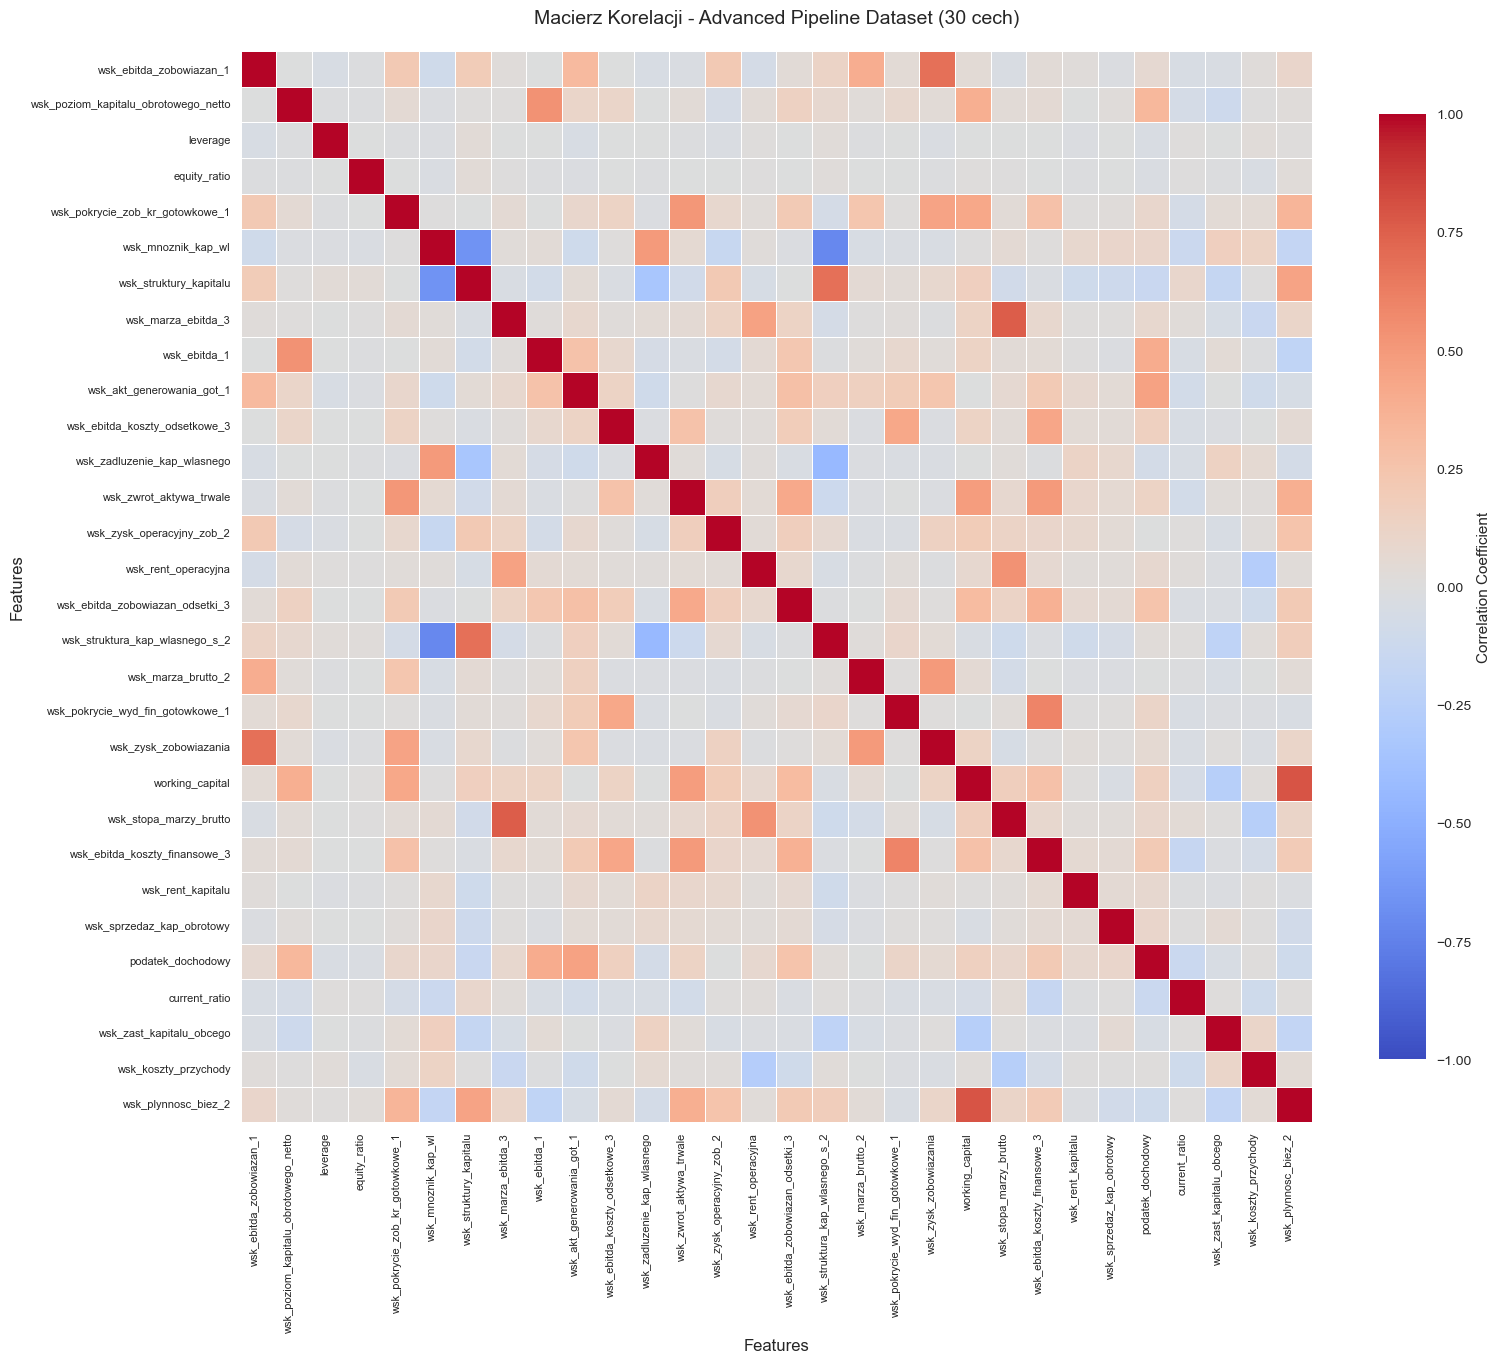

   ✅ Heatmap wygenerowana - ciemne czerwone/niebieskie = wysoka korelacja


2️⃣  KORELACJA Z TARGETEM - Siła zależności z ryzykiem defaultu

📈 TOP 15 CECH najbardziej skorelowanych z ryzykiem defaultu:
Rank   Feature                                        Correlation Direction      
1      equity_ratio                                       +0.0833 📈 Higher = More Risk
2      wsk_rent_kapitalu                                  -0.0748 📉 Higher = Less Risk
3      wsk_struktury_kapitalu                             +0.0692 📈 Higher = More Risk
4      wsk_struktura_kap_wlasnego_s_2                     +0.0556 📈 Higher = More Risk
5      wsk_zwrot_aktywa_trwale                            -0.0390 📉 Higher = Less Risk
6      wsk_marza_brutto_2                                 -0.0326 📉 Higher = Less Risk
7      wsk_zast_kapitalu_obcego                           -0.0311 📉 Higher = Less Risk
8      wsk_poziom_kapitalu_obrotowego_netto               +0.0280 📈 Higher = More Risk
9      wsk_ebitda_1 

In [48]:
print("="*80)
print("📊 ANALIZA KORELACJI - Advanced Pipeline Dataset")
print("="*80)

# ============================================================================
# 1. KORELACJA MIĘDZY CECHAMI (Multicollinearity Check)
# ============================================================================
print("\n1️⃣  KORELACJA MIĘDZY CECHAMI - Macierz korelacji")
print("="*80)

# Oblicz macierz korelacji
corr_matrix_adv = X_train_advanced_raw.corr()

print(f"\n📊 Macierz korelacji: {corr_matrix_adv.shape[0]} × {corr_matrix_adv.shape[1]}")
print(f"📋 Zakres wartości: [{corr_matrix_adv.min().min():.3f}, {corr_matrix_adv.max().max():.3f}]")

# Znajdź pary cech o wysokiej korelacji (>0.7)
high_corr_pairs = []
for i in range(len(corr_matrix_adv.columns)):
    for j in range(i+1, len(corr_matrix_adv.columns)):
        corr_val = corr_matrix_adv.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((
                corr_matrix_adv.columns[i],
                corr_matrix_adv.columns[j],
                corr_val
            ))

if len(high_corr_pairs) > 0:
    print(f"\n⚠️  Znaleziono {len(high_corr_pairs)} par cech o wysokiej korelacji (|r| > 0.7):")
    for feat1, feat2, corr_val in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:15]:
        direction = "+" if corr_val > 0 else "-"
        print(f"   {direction} {feat1:<35} ↔ {feat2:<35} r = {corr_val:+.3f}")
else:
    print("\n✅ Brak par cech o wysokiej korelacji (|r| > 0.7)")
    print("   VIF cleaning i correlation clustering skutecznie usunęły wielokolinearność!")

# Średnia korelacja (bez diagonali)
corr_values = corr_matrix_adv.values[np.triu_indices_from(corr_matrix_adv.values, k=1)]
print(f"\n📊 Statystyki korelacji (wszystkie pary cech):")
print(f"   Średnia |r|:  {np.abs(corr_values).mean():.3f}")
print(f"   Mediana |r|:  {np.median(np.abs(corr_values)):.3f}")
print(f"   Max |r|:      {np.abs(corr_values).max():.3f}")

# Wizualizacja macierzy korelacji
print(f"\n📊 Wizualizacja macierzy korelacji (heatmap):")

# Import seaborn jeśli nie zaimportowany
try:
    import seaborn as sns
except:
    print("   ⚠️  Instaluję seaborn...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn", "-q"])
    import seaborn as sns

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix_adv, 
            annot=False,  # Nie pokazuj wartości (za dużo cech)
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"})
plt.title('Macierz Korelacji - Advanced Pipeline Dataset (30 cech)', fontsize=14, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

print(f"   ✅ Heatmap wygenerowana - ciemne czerwone/niebieskie = wysoka korelacja")

# ============================================================================
# 2. KORELACJA Z TARGETEM (Predictive Power)
# ============================================================================
print("\n\n2️⃣  KORELACJA Z TARGETEM - Siła zależności z ryzykiem defaultu")
print("="*80)

# Oblicz korelację Pearsona z targetem
target_corr = []
for col in X_train_advanced_raw.columns:
    try:
        corr_val = X_train_advanced_raw[col].corr(pd.Series(y_train.values))
        target_corr.append({
            'Feature': col,
            'Correlation': corr_val,
            'Abs_Correlation': abs(corr_val)
        })
    except:
        target_corr.append({
            'Feature': col,
            'Correlation': 0.0,
            'Abs_Correlation': 0.0
        })

target_corr_df = pd.DataFrame(target_corr).sort_values('Abs_Correlation', ascending=False)

print(f"\n📈 TOP 15 CECH najbardziej skorelowanych z ryzykiem defaultu:")
print(f"{'Rank':<6} {'Feature':<45} {'Correlation':>12} {'Direction':<15}")
print("="*80)

for idx, row in target_corr_df.head(15).iterrows():
    rank = target_corr_df.index.get_loc(idx) + 1
    direction = "📈 Higher = More Risk" if row['Correlation'] > 0 else "📉 Higher = Less Risk"
    print(f"{rank:<6} {row['Feature']:<45} {row['Correlation']:>+12.4f} {direction:<15}")

print(f"\n📊 Statystyki korelacji z targetem:")
print(f"   Średnia |r|:  {target_corr_df['Abs_Correlation'].mean():.4f}")
print(f"   Mediana |r|:  {target_corr_df['Abs_Correlation'].median():.4f}")
print(f"   Max |r|:      {target_corr_df['Abs_Correlation'].max():.4f}")
print(f"   Min |r|:      {target_corr_df['Abs_Correlation'].min():.4f}")

# Cechy o bardzo niskiej korelacji z targetem (<0.05)
weak_corr = target_corr_df[target_corr_df['Abs_Correlation'] < 0.05]
if len(weak_corr) > 0:
    print(f"\n⚠️  Cechy o bardzo niskiej korelacji z targetem (|r| < 0.05): {len(weak_corr)}")
    print(f"   (Mogą mieć nieliniową zależność - WoE/IV pokaże prawdziwą moc)")

# ============================================================================
# 3. PODSUMOWANIE
# ============================================================================
print("\n\n" + "="*80)
print("📊 PODSUMOWANIE - Analiza Korelacji")
print("="*80)

print(f"\n✅ KORELACJA MIĘDZY CECHAMI:")
print(f"   • Pary o wysokiej korelacji (|r| > 0.7): {len(high_corr_pairs)}")
print(f"   • Średnia |r| między cechami: {np.abs(corr_values).mean():.3f}")
print(f"   • Status: {'✅ Niska wielokolinearność' if len(high_corr_pairs) < 5 else '⚠️ Możliwa wielokolinearność'}")

print(f"\n✅ KORELACJA Z TARGETEM:")
print(f"   • Najsilniejsza korelacja: {target_corr_df.iloc[0]['Feature']} (r = {target_corr_df.iloc[0]['Correlation']:+.4f})")
print(f"   • Średnia |r| z targetem: {target_corr_df['Abs_Correlation'].mean():.4f}")
print(f"   • Cechy o |r| > 0.1: {(target_corr_df['Abs_Correlation'] > 0.1).sum()}/{len(target_corr_df)}")

print(f"\n💡 WNIOSKI:")
if len(high_corr_pairs) == 0:
    print(f"   ✅ Dataset jest gotowy - brak wielokolinearności")
else:
    print(f"   ⚠️ {len(high_corr_pairs)} par o wysokiej korelacji - rozważ dodatkowe VIF cleaning")

if target_corr_df['Abs_Correlation'].mean() > 0.1:
    print(f"   ✅ Cechy mają silną zależność z targetem - dobry potencjał predykcyjny")
else:
    print(f"   ⚠️ Słaba liniowa korelacja - sprawdź zależności nieliniowe (WoE/IV)")

print("\n" + "="*80 + "\n")

## 10. Hyperparameter Tuning - Grid Search

Optymalizacja parametrów dla obu scorecardów (Basic i Advanced) poprzez Grid Search.

---

# 🏗️ ARCHITEKTURA SCORECARD - Przepływ Danych

## 📋 Wyjaśnienie: Dlaczego NIE MA Pipeline dla Scorecard?

### ❓ Pytanie: "Czy powinien być pipeline jak w innych modelach?"

**Odpowiedź: NIE - i to jest celowy design!**

---

## 🔍 PORÓWNANIE: Pipeline vs Scorecard Flow

### 🟢 **FULL PIPELINE** (Sekcje 1-9)

Encapsulates ALL transformations w jednym obiekcie. WoE jest **fixed** (np. 5 binów dla wszystkich cech). Pipeline jest **reusable**.

### 🔵 **BASIC SCORECARD** (Sekcje 10-11) - BRAK pipeline!

**KROK 1: Grid Search (Sekcja 10)** - wybiera cechy + optymalne biny PER FEATURE  
**KROK 2: WoE Transformation (Sekcja 11)** - RĘCZNA transformacja używając wyników  
**KROK 3: Scorecard Training** - LogisticRegression na WoE features

**Dlaczego ręcznie?** Każda cecha ma **inną liczbę binów** (wynik Grid Search).

### 🟣 **ADVANCED SCORECARD** (Sekcja 12)

**Dokładnie ten sam flow!** Grid Search → Manual WoE → Training  
Różnica: Input to `X_train_advanced_raw` (30 cech z feature engineering) vs `X_train_full` (raw)

---

## ✅ PODSUMOWANIE

1. **NIE MA błędu** - brak pipeline to celowy design
2. **Grid Search optymalizuje per-feature bins** - nie da się w pipeline
3. **WoE jest robione ręcznie** w Sekcji 11/12 używając optimal bins
4. **Advanced działa TAK SAMO** - tylko inne dane wejściowe
5. **To jest POPRAWNE** - best practices credit scoring

### 10.1 Przygotowanie Danych Walidacyjnych

In [49]:
print("="*80)
print("PRZYGOTOWANIE DANYCH WALIDACYJNYCH DLA GRID SEARCH")
print("="*80)

# Sprawdź czy dane walidacyjne zostały utworzone w sekcjach 10.1-10.4
if 'X_val_full' not in globals():
    print("\n🔧 Tworzę X_val_full (pipeline_full)...")
    X_val_full = pipeline_full.transform(X_val)
else:
    print(f"\n✅ X_val_full już istnieje: {X_val_full.shape}")

if 'X_val_minimal' not in globals():
    print("🔧 Tworzę X_val_minimal (pipeline_minimal)...")
    X_val_minimal = pipeline_minimal.transform(X_val)
else:
    print(f"✅ X_val_minimal już istnieje: {X_val_minimal.shape}")

if 'X_val_advanced_raw' not in globals():
    print("⚠️  UWAGA: X_val_advanced_raw nie istnieje!")
    print("   Musisz uruchomić sekcje 10.1-10.4 (Feature Engineering) aby utworzyć X_val_advanced_raw")
    print("   Używam X_val_full jako fallback...")
    X_val_advanced_raw = X_val_full.copy()
else:
    print(f"✅ X_val_advanced_raw już istnieje: {X_val_advanced_raw.shape}")

print(f"\n📊 Podsumowanie danych walidacyjnych:")
print(f"   X_val_full:         {X_val_full.shape}")
print(f"   X_val_minimal:      {X_val_minimal.shape}")
print(f"   X_val_advanced_raw: {X_val_advanced_raw.shape}")
print(f"   y_val:              {y_val.shape}")
print("="*80)

PRZYGOTOWANIE DANYCH WALIDACYJNYCH DLA GRID SEARCH

✅ X_val_full już istnieje: (600, 165)
🔧 Tworzę X_val_minimal (pipeline_minimal)...
✅ X_val_advanced_raw już istnieje: (600, 30)

📊 Podsumowanie danych walidacyjnych:
   X_val_full:         (600, 165)
   X_val_minimal:      (600, 136)
   X_val_advanced_raw: (600, 30)
   y_val:              (600,)


### 10.2 Grid search dla cech oraz binów

In [50]:
# #dla basic scorecard
# print("="*80)
# print("HYPERPARAMETER TUNING - CREDIT SCORECARDS")
# print("="*80)

# from sklearn.model_selection import ParameterGrid
# from sklearn.metrics import precision_recall_curve, auc, log_loss, brier_score_loss
# import time
# from itertools import product, combinations
# import random

# # ============================================
# # FUNKCJE POMOCNICZE
# # ============================================
# def monotonicity_score(woe_table):
#     """Oblicza score monotoniczności WoE (0-100%)"""
#     woe_values = woe_table['woe'].values
#     if len(woe_values) < 2:
#         return 100.0
    
#     diffs = np.diff(woe_values)
#     n_positive = np.sum(diffs > 0)
#     n_negative = np.sum(diffs < 0)
#     n_zero = np.sum(diffs == 0)
#     total_changes = len(diffs)
    
#     if total_changes == 0:
#         return 100.0
    
#     monotonic_count = max(n_positive, n_negative) + n_zero
#     return (monotonic_count / total_changes) * 100

# def calculate_ks_statistic(y_true, y_pred_proba):
#     """Oblicza statystykę Kołmogorowa-Smirnova"""
#     df = pd.DataFrame({'true': y_true, 'pred': y_pred_proba})
#     df = df.sort_values('pred', ascending=False).reset_index(drop=True)
    
#     df['cumulative_bad'] = df['true'].cumsum() / df['true'].sum()
#     df['cumulative_good'] = (1 - df['true']).cumsum() / (1 - df['true']).sum()
    
#     ks = (df['cumulative_bad'] - df['cumulative_good']).abs().max()
#     return ks

# def calculate_all_metrics(y_true, y_pred_proba):
#     """Oblicza wszystkie metryki jakości modelu"""
#     roc_auc = roc_auc_score(y_true, y_pred_proba)
#     precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
#     pr_auc = auc(recall, precision)
#     ks = calculate_ks_statistic(y_true, y_pred_proba)
#     logloss = log_loss(y_true, y_pred_proba)
#     brier = brier_score_loss(y_true, y_pred_proba)
    
#     return {
#         'roc_auc': roc_auc,
#         'pr_auc': pr_auc,
#         'ks': ks,
#         'log_loss': logloss,
#         'brier': brier
#     }

# def calculate_feature_bins_info(X_data, y_data, feature, bin_options=[3, 4, 5, 6, 7, 8, 10, 12, 15, 20], min_mono=70.0):
#     """Dla danej cechy oblicza IV i mono dla wszystkich opcji binów."""
#     results = []
#     for n_bins in bin_options:
#         try:
#             df_temp = pd.DataFrame({feature: X_data[feature], 'target': y_data.values})
#             woe_table, iv_value = calculate_woe_iv(df_temp, feature, 'target', bins=n_bins)
#             mono = monotonicity_score(woe_table)
            
#             if mono >= min_mono:
#                 results.append({'bins': n_bins, 'iv': iv_value, 'mono': mono})
#         except:
#             continue
#     return results

# def calculate_feature_bins_info_no_mono(X_data, y_data, feature, bin_options=[3, 4, 5, 6, 7, 8, 10, 12, 15, 20]):
#     """Dla danej cechy oblicza IV BEZ wymagań monotonicznych."""
#     results = []
#     for n_bins in bin_options:
#         try:
#             df_temp = pd.DataFrame({feature: X_data[feature], 'target': y_data.values})
#             woe_table, iv_value = calculate_woe_iv(df_temp, feature, 'target', bins=n_bins)
#             mono = monotonicity_score(woe_table)
#             results.append({'bins': n_bins, 'iv': iv_value, 'mono': mono})
#         except:
#             continue
#     return results

# def get_woe_data_for_config(config, X_data, y_data):
#     """Tworzy DataFrame WoE dla danej konfiguracji cech"""
#     X_woe = pd.DataFrame()
#     for feat, info in config:
#         try:
#             df_temp = pd.DataFrame({feat: X_data[feat], 'target': y_data.values})
#             woe_values = woe_transform(df_temp, feat, 'target', bins=info['bins'])
#             X_woe[f"{feat}_woe"] = pd.to_numeric(woe_values, errors='coerce')
#         except:
#             pass
#     return X_woe

# def check_coefficient_sign_stability(config, X_trainval, y_trainval, X_test, y_test, C, solver):
#     """Sprawdza czy współczynniki mają te same znaki na TRAIN+VAL vs TEST."""
#     if len(config) == 0:
#         return []
    
#     X_tv_woe = get_woe_data_for_config(config, X_trainval, y_trainval)
#     X_t_woe = get_woe_data_for_config(config, X_test, y_test)
    
#     if X_tv_woe.shape[1] == 0 or X_t_woe.shape[1] == 0:
#         return [f for f, _ in config]
    
#     try:
#         model_tv = LogisticRegression(C=C, solver=solver, max_iter=1000, random_state=42, class_weight='balanced')
#         model_tv.fit(X_tv_woe, y_trainval)
        
#         model_t = LogisticRegression(C=C, solver=solver, max_iter=1000, random_state=42, class_weight='balanced')
#         model_t.fit(X_t_woe, y_test)
#     except:
#         return [f for f, _ in config]
    
#     unstable = []
#     for i, (feat, _) in enumerate(config):
#         sign_tv = np.sign(model_tv.coef_[0][i])
#         sign_t = np.sign(model_t.coef_[0][i])
#         if sign_tv != sign_t and sign_tv != 0 and sign_t != 0:
#             unstable.append(feat)
    
#     return unstable

# def stabilize_config(config, X_trainval, y_trainval, X_test, y_test, 
#                      feature_bin_options, top_features_pool, C, solver, max_iterations=50):
#     """Stabilizuje konfigurację - zamienia cechy z niestabilnymi znakami."""
#     current_config = list(config)
#     used_features = set(f for f, _ in current_config)
    
#     for iteration in range(max_iterations):
#         if len(current_config) < 5:
#             break
        
#         unstable = check_coefficient_sign_stability(
#             current_config, X_trainval, y_trainval, X_test, y_test, C, solver
#         )
        
#         if not unstable:
#             return current_config, True
        
#         bad_feat = unstable[0]
#         bad_idx = next((i for i, (f, _) in enumerate(current_config) if f == bad_feat), None)
#         if bad_idx is None:
#             break
        
#         # Strategia 1: Inne binowanie
#         current_bins = current_config[bad_idx][1]['bins']
#         fixed = False
#         if bad_feat in feature_bin_options:
#             other_opts = [o for o in feature_bin_options[bad_feat] if o['bins'] != current_bins]
#             for alt in sorted(other_opts, key=lambda x: x['iv'], reverse=True)[:3]:
#                 test_config = current_config.copy()
#                 test_config[bad_idx] = (bad_feat, alt)
#                 if bad_feat not in check_coefficient_sign_stability(test_config, X_trainval, y_trainval, X_test, y_test, C, solver):
#                     current_config = test_config
#                     fixed = True
#                     break
        
#         if fixed:
#             continue
        
#         # Strategia 2: Zamień na inną cechę z puli TOP 30
#         replaced = False
#         for cand in top_features_pool:
#             if cand in used_features or cand not in feature_bin_options:
#                 continue
#             for cand_opt in sorted(feature_bin_options[cand], key=lambda x: x['iv'], reverse=True)[:2]:
#                 test_config = current_config.copy()
#                 test_config[bad_idx] = (cand, cand_opt)
#                 if cand not in check_coefficient_sign_stability(test_config, X_trainval, y_trainval, X_test, y_test, C, solver):
#                     current_config = test_config
#                     used_features.discard(bad_feat)
#                     used_features.add(cand)
#                     replaced = True
#                     break
#             if replaced:
#                 break
        
#         if replaced:
#             continue
        
#         # Strategia 3: Usuń
#         current_config.pop(bad_idx)
#         used_features.discard(bad_feat)
    
#     final_unstable = check_coefficient_sign_stability(current_config, X_trainval, y_trainval, X_test, y_test, C, solver)
#     return current_config, len(final_unstable) == 0

# # ============================================
# # PARAMETRY
# # ============================================
# param_grid = {
#     'n_features': [22],  # MAX 22
#     'C': [0.1],
#     'solver': ['liblinear', 'lbfgs']
# }

# BIN_OPTIONS = [3, 4, 5, 6, 7, 8, 10, 12, 15, 20]
# MIN_MONO_PER_FEATURE = 70.0
# MIN_AVG_MONO = 80.0
# TOP_FEATURES_TO_CONSIDER = 30  # TYLKO TOP 30 CECH!

# print(f"\n⚡ KRYTERIA:")
# print(f"   • TYLKO TOP {TOP_FEATURES_TO_CONSIDER} CECH według IV (nie wszystkie!)")
# print(f"   • Model MONOTONICZNY: każda cecha mono >= {MIN_MONO_PER_FEATURE}%, średnia >= {MIN_AVG_MONO}%")
# print(f"   • STABILNOŚĆ ZNAKÓW: współczynniki muszą mieć te same znaki na TRAIN+VAL vs TEST")
# print(f"   • Max cech w modelu: 22")

# # Przygotuj dane TRAIN+VAL
# X_train_val = pd.concat([X_train_full, X_val_full], axis=0).reset_index(drop=True)
# y_train_val = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# print(f"\n📊 Dane: TRAIN+VAL={len(X_train_val)}, TEST={len(X_test_full)}")

# # ============================================
# # KROK 1: ANALIZA TYLKO TOP 30 CECH
# # ============================================
# print("\n" + "="*80)
# print("KROK 1: ANALIZA TOP 30 CECH")
# print("-"*80)

# start_time = time.time()

# numeric_features = X_train_full.select_dtypes(include=[np.number]).columns.tolist()
# print(f"   Wszystkich cech numerycznych: {len(numeric_features)}")

# # Najpierw szybka analiza IV dla WSZYSTKICH cech (tylko max IV, bez mono)
# print(f"\n🔧 Szybka analiza IV dla wszystkich cech...")
# all_features_iv = {}
# for i, feature in enumerate(numeric_features):
#     if (i+1) % 50 == 0:
#         print(f"      Przetworzono {i+1}/{len(numeric_features)}...")
#     try:
#         df_temp = pd.DataFrame({feature: X_train_full[feature], 'target': y_train.values})
#         _, iv_value = calculate_woe_iv(df_temp, feature, 'target', bins=10)
#         all_features_iv[feature] = iv_value
#     except:
#         pass

# # Sortuj i weź TOP 30
# all_features_sorted = sorted(all_features_iv.keys(), key=lambda f: all_features_iv[f], reverse=True)
# top_30_features = all_features_sorted[:TOP_FEATURES_TO_CONSIDER]

# print(f"\n   ✅ Wybrano TOP {TOP_FEATURES_TO_CONSIDER} cech według IV")
# print(f"\n📊 TOP {TOP_FEATURES_TO_CONSIDER} cech:")
# for i, feat in enumerate(top_30_features, 1):
#     print(f"   {i:2}. {feat:<45} IV={all_features_iv[feat]:.4f}")

# # Teraz szczegółowa analiza binowania TYLKO dla top 30
# print(f"\n🔧 Szczegółowa analiza binowania dla TOP {TOP_FEATURES_TO_CONSIDER} cech...")
# feature_bin_options = {}
# for feature in top_30_features:
#     bins_info = calculate_feature_bins_info(X_train_full, y_train, feature, BIN_OPTIONS, MIN_MONO_PER_FEATURE)
#     if len(bins_info) > 0:
#         feature_bin_options[feature] = bins_info

# print(f"   ✅ {len(feature_bin_options)} cech z TOP 30 ma mono >= {MIN_MONO_PER_FEATURE}%")

# # Ranking według IV (tylko te co przeszły mono)
# feature_best_iv = {}
# for feat, options in feature_bin_options.items():
#     best = max(options, key=lambda x: x['iv'])
#     feature_best_iv[feat] = best['iv']

# features_sorted_by_iv = sorted(feature_best_iv.keys(), key=lambda f: feature_best_iv[f], reverse=True)
# top_features_pool = list(features_sorted_by_iv)  # Pula do zamiany

# print(f"\n📊 Cechy do Grid Search ({len(features_sorted_by_iv)}):")
# for i, feat in enumerate(features_sorted_by_iv):
#     best_option = max(feature_bin_options[feat], key=lambda x: x['iv'])
#     print(f"   {i+1:2}. {feat:<45} IV={best_option['iv']:.4f} (bins={best_option['bins']}, mono={best_option['mono']:.1f}%)")

# # ============================================
# # KROK 2: GRID SEARCH (TYLKO NA TOP 30!)
# # ============================================
# print("\n" + "="*80)
# print("KROK 2: GRID SEARCH (TYLKO TOP 30 CECH + STABILNOŚĆ)")
# print("-"*80)

# best_score_basic = 0
# best_params_basic = None
# best_features_basic = None
# results_grid_basic = []
# configs_tested = 0
# configs_successful = 0
# configs_stabilized = 0
# total_combinations = len(list(ParameterGrid(param_grid)))

# print(f"\n🔄 Grid Search na {len(features_sorted_by_iv)} cechach...\n")

# for param_idx, params in enumerate(ParameterGrid(param_grid)):
#     n_features = params['n_features']
    
#     # Wybierz top N z NASZEJ PULI (max 30 cech!)
#     selected_features = features_sorted_by_iv[:min(n_features, len(features_sorted_by_iv))]
    
#     if len(selected_features) < min(n_features, 5):
#         continue
    
#     configs_to_test = []
    
#     # Konfiguracje
#     config_max_iv = [(feat, max(feature_bin_options[feat], key=lambda x: x['iv'])) for feat in selected_features]
#     configs_to_test.append(config_max_iv)
    
#     config_max_mono = [(feat, max(feature_bin_options[feat], key=lambda x: x['mono'])) for feat in selected_features]
#     configs_to_test.append(config_max_mono)
    
#     config_balanced = []
#     for feat in selected_features:
#         options = feature_bin_options[feat]
#         for opt in options:
#             opt['score'] = opt['iv'] * (opt['mono'] / 100.0)
#         config_balanced.append((feat, max(options, key=lambda x: x['score'])))
#     configs_to_test.append(config_balanced)
    
#     config_min_bins = [(feat, min(feature_bin_options[feat], key=lambda x: x['bins'])) for feat in selected_features]
#     configs_to_test.append(config_min_bins)
    
#     config_max_bins = [(feat, max(feature_bin_options[feat], key=lambda x: x['bins'])) for feat in selected_features]
#     configs_to_test.append(config_max_bins)
    
#     # Losowe (5 zamiast 10 - szybciej)
#     for _ in range(5):
#         config_random = [(feat, random.choice(feature_bin_options[feat])) for feat in selected_features]
#         configs_to_test.append(config_random)
    
#     # Miksy (5 zamiast 10)
#     for mix_ratio in [0.2, 0.4, 0.6, 0.8, 1.0]:
#         split_point = int(len(selected_features) * mix_ratio)
#         config_mix = []
#         for i, feat in enumerate(selected_features):
#             opt = max(feature_bin_options[feat], key=lambda x: x['iv']) if i < split_point else max(feature_bin_options[feat], key=lambda x: x['mono'])
#             config_mix.append((feat, opt))
#         configs_to_test.append(config_mix)
    
#     # Weighted (3)
#     for iv_weight in [0.5, 0.7, 0.9]:
#         mono_weight = 1.0 - iv_weight
#         config_weighted = []
#         for feat in selected_features:
#             options = feature_bin_options[feat]
#             for opt in options:
#                 opt['weighted_score'] = (opt['iv'] * iv_weight) + ((opt['mono'] / 100.0) * mono_weight)
#             config_weighted.append((feat, max(options, key=lambda x: x['weighted_score'])))
#         configs_to_test.append(config_weighted)
    
#     for config in configs_to_test:
#         configs_tested += 1
        
#         avg_mono = np.mean([info['mono'] for _, info in config])
        
#         if avg_mono < MIN_AVG_MONO:
#             for reduce_to in range(len(config)-1, 4, -1):
#                 config_reduced = config[:reduce_to]
#                 avg_mono = np.mean([info['mono'] for _, info in config_reduced])
#                 if avg_mono >= MIN_AVG_MONO:
#                     config = config_reduced
#                     break
#             else:
#                 continue
        
#         if len(config) < 5:
#             continue
        
#         # STABILIZACJA ZNAKÓW
#         stable_config, is_stable = stabilize_config(
#             config, X_train_val, y_train_val, X_test_full, y_test,
#             feature_bin_options, top_features_pool, params['C'], params['solver']
#         )
        
#         if not is_stable or len(stable_config) < 5:
#             continue
        
#         if len(stable_config) != len(config):
#             configs_stabilized += 1
        
#         config = stable_config
        
#         min_mono = min([info['mono'] for _, info in config])
#         avg_mono = np.mean([info['mono'] for _, info in config])
#         actual_n_features = len(config)
        
#         if avg_mono < MIN_AVG_MONO:
#             continue
        
#         try:
#             X_train_woe = pd.DataFrame()
#             woe_mappings = {}
            
#             for feat, info in config:
#                 n_bins = info['bins']
#                 df_temp = pd.DataFrame({feat: X_train_full[feat], 'target': y_train.values})
#                 woe_values = woe_transform(df_temp, feat, 'target', bins=n_bins)
#                 X_train_woe[f"{feat}_woe"] = pd.to_numeric(woe_values, errors='coerce')
#                 woe_table, _ = calculate_woe_iv(df_temp, feat, 'target', bins=n_bins)
#                 woe_mappings[feat] = {'table': woe_table, 'bins': n_bins}
            
#             if X_train_woe.shape[1] == 0:
#                 continue
            
#             X_val_woe = pd.DataFrame()
#             for feat, info in config:
#                 if feat in woe_mappings:
#                     n_bins = woe_mappings[feat]['bins']
#                     df_temp = pd.DataFrame({feat: X_val_full[feat], 'target': y_val.values})
#                     woe_values = woe_transform(df_temp, feat, 'target', bins=n_bins)
#                     X_val_woe[f"{feat}_woe"] = pd.to_numeric(woe_values, errors='coerce')
            
#             model = LogisticRegression(
#                 C=params['C'], solver=params['solver'],
#                 max_iter=1000, random_state=42, class_weight='balanced'
#             )
#             model.fit(X_train_woe, y_train)
            
#             y_proba_val = model.predict_proba(X_val_woe)[:, 1]
#             metrics = calculate_all_metrics(y_val, y_proba_val)
            
#             configs_successful += 1
#             results_grid_basic.append({
#                 'n_features': actual_n_features, 'C': params['C'], 'solver': params['solver'],
#                 'roc_auc': metrics['roc_auc'], 'avg_mono': avg_mono, 'min_mono': min_mono
#             })
            
#             if metrics['roc_auc'] > best_score_basic:
#                 best_score_basic = metrics['roc_auc']
#                 best_params_basic = {
#                     **params, 'n_features': actual_n_features, 
#                     'avg_mono': avg_mono, 'min_mono': min_mono, **metrics
#                 }
#                 best_features_basic = config.copy()
#                 print(f"   ✨ [{param_idx+1}/{total_combinations}] BEST: AUC={best_score_basic:.4f}, cechy={actual_n_features}, C={params['C']}")
        
#         except:
#             continue
    
#     if (param_idx + 1) % 5 == 0 and best_score_basic == 0:
#         print(f"   [{param_idx+1}/{total_combinations}] Szukam...")

# elapsed_basic = time.time() - start_time
# print(f"\n   ✅ Zakończono: {elapsed_basic:.1f}s")
# print(f"   📊 Testowano: {configs_tested}, Stabilizowano: {configs_stabilized}, Udanych: {configs_successful}")

# # ============================================
# # WYNIKI
# # ============================================
# print("\n" + "="*80)
# print("🏆 NAJLEPSZA KONFIGURACJA")
# print("="*80)

# if best_params_basic and best_features_basic:
#     print(f"\n📊 PARAMETRY: cechy={best_params_basic['n_features']}, C={best_params_basic['C']}, solver={best_params_basic['solver']}")
#     print(f"📈 ROC-AUC: {best_params_basic['roc_auc']:.4f}, KS: {best_params_basic['ks']:.4f}")
#     print(f"📋 Mono: Avg={best_params_basic['avg_mono']:.1f}%, Min={best_params_basic['min_mono']:.1f}%")
#     print(f"✅ STABILNOŚĆ ZNAKÓW: GWARANTOWANA")
    
#     print(f"\n📋 CECHY ({len(best_features_basic)}):")
#     for i, (feat, info) in enumerate(best_features_basic, 1):
#         print(f"   {i:2}. {feat:<45} IV={info['iv']:.4f}, Mono={info['mono']:.1f}%, Bins={info['bins']}")
# else:
#     print("\n❌ Nie znaleziono stabilnej konfiguracji!")

# # Zapisz
# feature_bin_options_basic_saved = feature_bin_options
# if best_features_basic:
#     feature_bins_map = {feat: info['bins'] for feat, info in best_features_basic}

# print("="*80)

In [51]:
# # ============================================
# # ZAPIS WYNIKÓW GRID SEARCH DO PLIKU
# # ============================================
# import json
# import pickle
# from datetime import datetime

# SAVE_DIR = "grid_search_results"
# import os
# os.makedirs(SAVE_DIR, exist_ok=True)

# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# if best_params_basic and best_features_basic:
#     # 1. Zapisz parametry jako JSON (czytelne)
#     params_to_save = {
#         'best_params': {
#             'n_features': best_params_basic['n_features'],
#             'C': best_params_basic['C'],
#             'solver': best_params_basic['solver'],
#             'avg_mono': best_params_basic['avg_mono'],
#             'min_mono': best_params_basic['min_mono'],
#             'roc_auc': best_params_basic['roc_auc'],
#             'ks': best_params_basic.get('ks', None),
#             'pr_auc': best_params_basic.get('pr_auc', None),
#         },
#         'best_features': [
#             {'feature': feat, 'bins': info['bins'], 'iv': info['iv'], 'mono': info['mono']}
#             for feat, info in best_features_basic
#         ],
#         'timestamp': timestamp,
#         'grid_params': {
#             'MIN_MONO': 70.0,
#             'MIN_AVG_MONO': 75.0,
#             'TOP_FEATURES_TO_CONSIDER': 50
#         }
#     }
    
#     json_path = f"{SAVE_DIR}/best_config_{timestamp}.json"
#     with open(json_path, 'w', encoding='utf-8') as f:
#         json.dump(params_to_save, f, indent=2, ensure_ascii=False)
#     print(f"✅ Zapisano parametry (JSON): {json_path}")
    
#     # 2. Zapisz pełne obiekty jako pickle (do szybkiego wczytania)
#     pickle_data = {
#         'best_params_basic': best_params_basic,
#         'best_features_basic': best_features_basic,
#         'feature_bin_options_basic_saved': feature_bin_options_basic_saved,
#         'feature_bins_map': feature_bins_map if 'feature_bins_map' in dir() else None,
#         'results': results if 'results' in dir() else None
#     }
    
#     pickle_path = f"{SAVE_DIR}/best_config_{timestamp}.pkl"
#     with open(pickle_path, 'wb') as f:
#         pickle.dump(pickle_data, f)
#     print(f"✅ Zapisano pełne dane (pickle): {pickle_path}")
    
#     # 3. Zapisz też jako "latest" (najnowszy)
#     with open(f"{SAVE_DIR}/best_config_latest.json", 'w', encoding='utf-8') as f:
#         json.dump(params_to_save, f, indent=2, ensure_ascii=False)
#     with open(f"{SAVE_DIR}/best_config_latest.pkl", 'wb') as f:
#         pickle.dump(pickle_data, f)
#     print(f"✅ Zapisano jako 'latest' (do szybkiego wczytania)")
    
#     print(f"\n📊 PODSUMOWANIE ZAPISANYCH DANYCH:")
#     print(f"   Cechy: {best_params_basic['n_features']}")
#     print(f"   ROC-AUC: {best_params_basic['roc_auc']:.4f}")
#     print(f"   C: {best_params_basic['C']}")
    
# else:
#     print("❌ Brak wyników do zapisania!")

## 11. Basic Scorecard (Optimized)

Scorecard dla Basic Pipeline (bez feature engineering) z optymalnymi parametrami.

In [69]:
print("="*80)
print("BASIC PIPELINE CREDIT SCORECARD (OPTIMIZED)")
print("="*80)

import json
import os

# Wczytaj parametry z zapisanych plików
config_dir = "grid_search_results"
json_file = os.path.join(config_dir, "best_config_latest.json")

best_params_basic = None
best_features_basic = None

if os.path.exists(json_file):
    print(f"\n📂 Wczytuję parametry z: {json_file}")
    with open(json_file, 'r', encoding='utf-8') as f:
        config_data = json.load(f)
    
    best_params_basic = config_data['best_params']
    # Konwertuj listę słowników na listę krotek (feat, info)
    best_features_basic = [
        (item['feature'], {'bins': item['bins'], 'iv': item['iv'], 'mono': item['mono']})
        for item in config_data['best_features']
    ]
    
    print(f"   ✅ Wczytano konfigurację z {config_data.get('timestamp', 'unknown')}")
    print(f"   • Liczba cech: {len(best_features_basic)}")
    print(f"   • C: {best_params_basic['C']}")
    print(f"   • Solver: {best_params_basic['solver']}")
    print(f"   • ROC-AUC (z Grid Search): {best_params_basic['roc_auc']:.4f}")
else:
    print(f"❌ Nie znaleziono pliku: {json_file}")
    print("   Uruchom najpierw Grid Search lub podaj ścieżkę do pliku.")

if best_params_basic is None or best_features_basic is None:
    print("❌ Brak wyników z Grid Search!")
else:
    # Sprawdź czy wymagane zmienne istnieją
    required_vars = ['X_train_full', 'X_val_full', 'X_test_full', 'y_train', 'y_val', 'y_test']
    missing_vars = [v for v in required_vars if v not in globals()]
    
    if missing_vars:
        print(f"\n❌ Brakujące zmienne: {missing_vars}")
        print("   ➡️ Uruchom najpierw komórki definiujące dane (sekcja Pipeline/Data Split)")
    else:
        # Połącz TRAIN + VAL do finalnego treningu
        X_train_val_full = pd.concat([X_train_full, X_val_full], axis=0).reset_index(drop=True)
        y_train_val = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)
        
        print(f"\n📊 Dane:")
        print(f"   TRAIN+VAL: {len(X_train_val_full)} obs (do treningu)")
        print(f"   TEST: {len(X_test_full)} obs (do walidacji)")
        
        # Sprawdź czy wszystkie cechy są dostępne w danych
        available_features = set(X_train_val_full.columns)
        missing_features = [f for f, _ in best_features_basic if f not in available_features]
        
        if missing_features:
            print(f"\n⚠️ Brakujące cechy w danych: {missing_features[:5]}...")
            print("   Sprawdź czy dane zostały poprawnie przetworzone przez Pipeline.")
        else:
            # Przygotuj WoE dla TRAIN+VAL
            X_train_val_woe_basic = pd.DataFrame()
            woe_mappings_basic = {}
            
            print(f"\n🔧 Transformacja WoE dla {len(best_features_basic)} cech...")
            for feat, info in best_features_basic:
                n_bins = info['bins']
                df_temp = pd.DataFrame({feat: X_train_val_full[feat], 'target': y_train_val.values})
                woe_values = woe_transform(df_temp, feat, 'target', bins=n_bins)
                X_train_val_woe_basic[f"{feat}_woe"] = pd.to_numeric(woe_values, errors='coerce')
                woe_table, iv = calculate_woe_iv(df_temp, feat, 'target', bins=n_bins)
                woe_mappings_basic[feat] = {'table': woe_table, 'bins': n_bins, 'iv': iv}
            
            # Przygotuj WoE dla TEST
            X_test_woe_basic = pd.DataFrame()
            for feat, info in best_features_basic:
                if feat in woe_mappings_basic:
                    n_bins = woe_mappings_basic[feat]['bins']
                    df_temp = pd.DataFrame({feat: X_test_full[feat], 'target': y_test.values})
                    woe_values = woe_transform(df_temp, feat, 'target', bins=n_bins)
                    X_test_woe_basic[f"{feat}_woe"] = pd.to_numeric(woe_values, errors='coerce')
            
            # Trenuj model na TRAIN+VAL
            print(f"\n🎯 Trening LogisticRegression na TRAIN+VAL (C={best_params_basic['C']}, solver={best_params_basic['solver']})...")
            
            scorecard_basic = LogisticRegression(
                C=best_params_basic['C'],
                solver=best_params_basic['solver'],
                max_iter=1000,
                random_state=42,
                class_weight='balanced'
            )
            scorecard_basic.fit(X_train_val_woe_basic, y_train_val)
            
            # Predykcje
            y_train_val_proba_basic = scorecard_basic.predict_proba(X_train_val_woe_basic)[:, 1]
            y_test_proba_basic = scorecard_basic.predict_proba(X_test_woe_basic)[:, 1]
            
            # Metryki
            auc_train_val = roc_auc_score(y_train_val, y_train_val_proba_basic)
            auc_test = roc_auc_score(y_test, y_test_proba_basic)
            
            # === DODANE: Oblicz wszystkie metryki dla TEST ===
            from sklearn.metrics import precision_recall_curve, log_loss, brier_score_loss
            
            def calculate_ks(y_true, y_pred_proba):
                df_ks = pd.DataFrame({'true': y_true, 'pred': y_pred_proba})
                df_ks = df_ks.sort_values('pred', ascending=False).reset_index(drop=True)
                df_ks['cumulative_bad'] = df_ks['true'].cumsum() / df_ks['true'].sum()
                df_ks['cumulative_good'] = (1 - df_ks['true']).cumsum() / (1 - df_ks['true']).sum()
                return (df_ks['cumulative_bad'] - df_ks['cumulative_good']).abs().max()
            
            precision, recall, _ = precision_recall_curve(y_test, y_test_proba_basic)
            
            metrics_sc_basic = {
                'roc_auc': auc_test,
                'pr_auc': auc(recall, precision),
                'ks': calculate_ks(y_test, y_test_proba_basic),
                'log_loss': log_loss(y_test, y_test_proba_basic),
                'brier': brier_score_loss(y_test, y_test_proba_basic)
            }
            # === KONIEC DODANEGO ===
            
            print(f"\n📈 WYNIKI (model trenowany na TRAIN+VAL):")
            print(f"   ROC-AUC TRAIN+VAL: {auc_train_val:.4f}")
            print(f"   ROC-AUC TEST:      {auc_test:.4f}")
            print(f"   PR-AUC TEST:       {metrics_sc_basic['pr_auc']:.4f}")
            print(f"   KS TEST:           {metrics_sc_basic['ks']:.4f}")
            print(f"   Log Loss TEST:     {metrics_sc_basic['log_loss']:.4f}")
            print(f"   Brier TEST:        {metrics_sc_basic['brier']:.4f}")
            print(f"   Różnica AUC:       {abs(auc_train_val - auc_test):.4f}")
            
            # Współczynniki
            print(f"\n📋 WSPÓŁCZYNNIKI MODELU:")
            print(f"   Intercept: {scorecard_basic.intercept_[0]:.4f}")
            print(f"\n   {'Cecha':<50} {'Coef':>10} {'IV':>8} {'Bins':>6}")
            print(f"   {'-'*50} {'-'*10} {'-'*8} {'-'*6}")
            
            for i, (feat, info) in enumerate(best_features_basic):
                coef = scorecard_basic.coef_[0][i]
                iv = info['iv']
                bins = info['bins']
                print(f"   {feat:<50} {coef:>10.4f} {iv:>8.4f} {bins:>6}")
            
            print(f"\n✅ Model Basic Scorecard wytrenowany!")
            print(f"   ✅ Utworzono metrics_sc_basic z wszystkimi metrykami")

print("="*80)

BASIC PIPELINE CREDIT SCORECARD (OPTIMIZED)

📂 Wczytuję parametry z: grid_search_results\best_config_latest.json
   ✅ Wczytano konfigurację z 20251203_194540
   • Liczba cech: 22
   • C: 0.1
   • Solver: lbfgs
   • ROC-AUC (z Grid Search): 0.9042

📊 Dane:
   TRAIN+VAL: 2400 obs (do treningu)
   TEST: 600 obs (do walidacji)

🔧 Transformacja WoE dla 22 cech...

🎯 Trening LogisticRegression na TRAIN+VAL (C=0.1, solver=lbfgs)...

📈 WYNIKI (model trenowany na TRAIN+VAL):
   ROC-AUC TRAIN+VAL: 0.8010
   ROC-AUC TEST:      0.9417
   PR-AUC TEST:       0.5041
   KS TEST:           0.7957
   Log Loss TEST:     0.3279
   Brier TEST:        0.1183
   Różnica AUC:       0.1407

📋 WSPÓŁCZYNNIKI MODELU:
   Intercept: 0.0256

   Cecha                                                    Coef       IV   Bins
   -------------------------------------------------- ---------- -------- ------
   wsk_pokrycie_wyd_fin_gotowkowe_1                       0.1635   0.2321      3
   wsk_ebitda_1                     

### 11.1 EDA - Analiza Jakości WoE (Basic)

Analiza transformacji WoE: IV ranking, monotonicity, korelacje, rozkłady

📊 EDA - ANALIZA JAKOŚCI WoE (BASIC SCORECARD)


1️⃣  IV RANKING - TOP 10 CECH

📊 Rozkład mocy predykcyjnej (22 cech):

   Very Strong     ( 2): █
   Strong          ( 9): ████
   Medium          (11): █████

📈 TOP 10 CECH:

   Rank   Feature                                       IV         Bins   Power
   --------------------------------------------------------------------------------
   1      zysk_sprzedazy                                0.6437     20     Very Strong
   2      Kapital_wlasny                                0.5005     10     Very Strong
   3      wsk_ebitda_1                                  0.4373     15     Strong
   4      wsk_poziom_kapitalu_obrotowego_netto          0.4242     10     Strong
   5      wsk_zwrot_aktywa_trwale                       0.3999     8      Strong
   6      wsk_marza_ebitda_3                            0.3897     20     Strong
   7      wsk_zysk_operacyjny_zob_2                     0.3885     12     Strong
   8      Aktywa                   

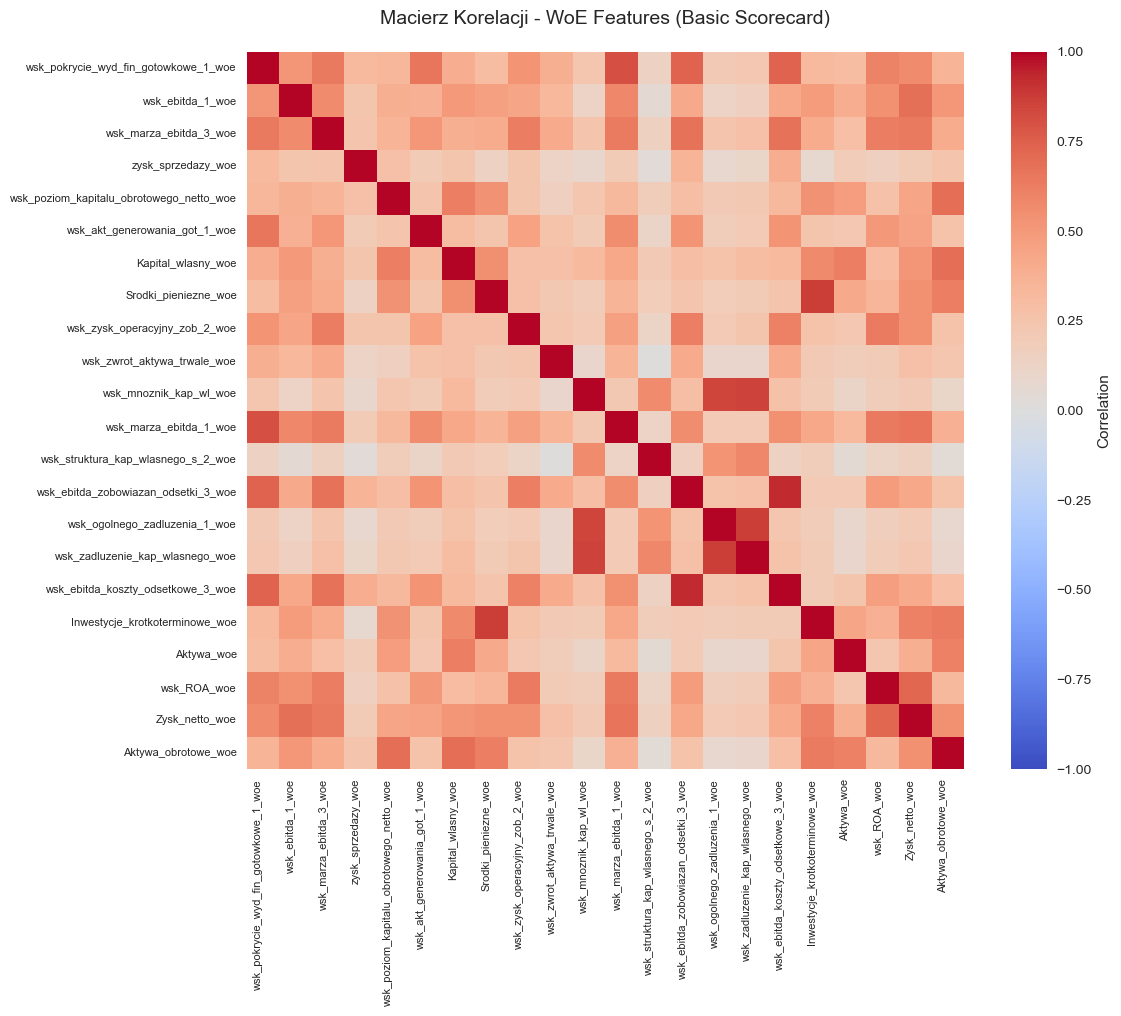



4️⃣  ROZKŁADY - WSZYSTKIE CECHY (RAW vs WoE)

📊 Porównanie rozkładów dla 22 cech:
   Niebieski = RAW (po Full Pipeline preprocessing)
   Zielony = WoE (Weight of Evidence)


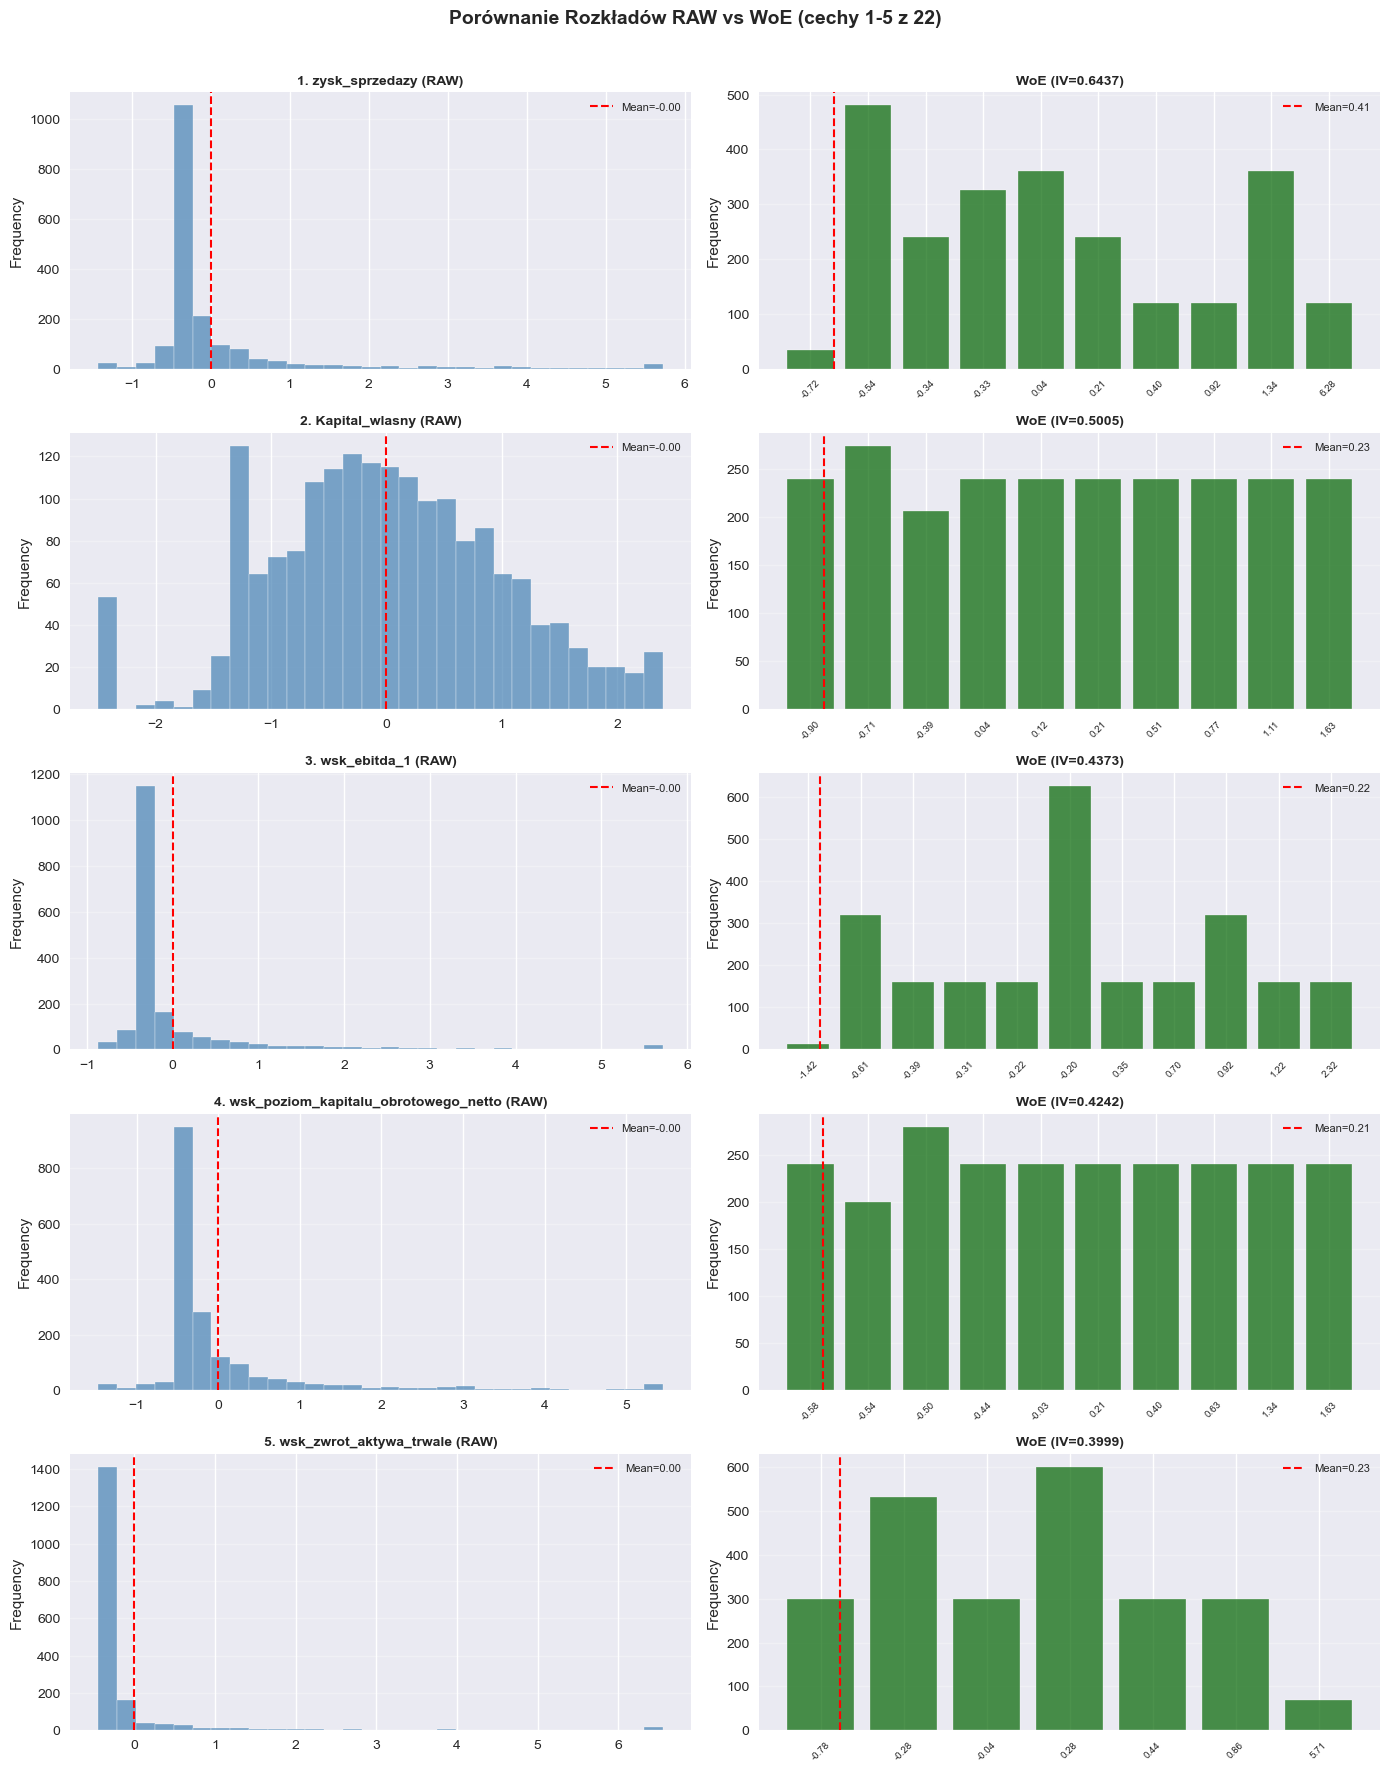

   ✅ Figura 1/5: cechy 1-5


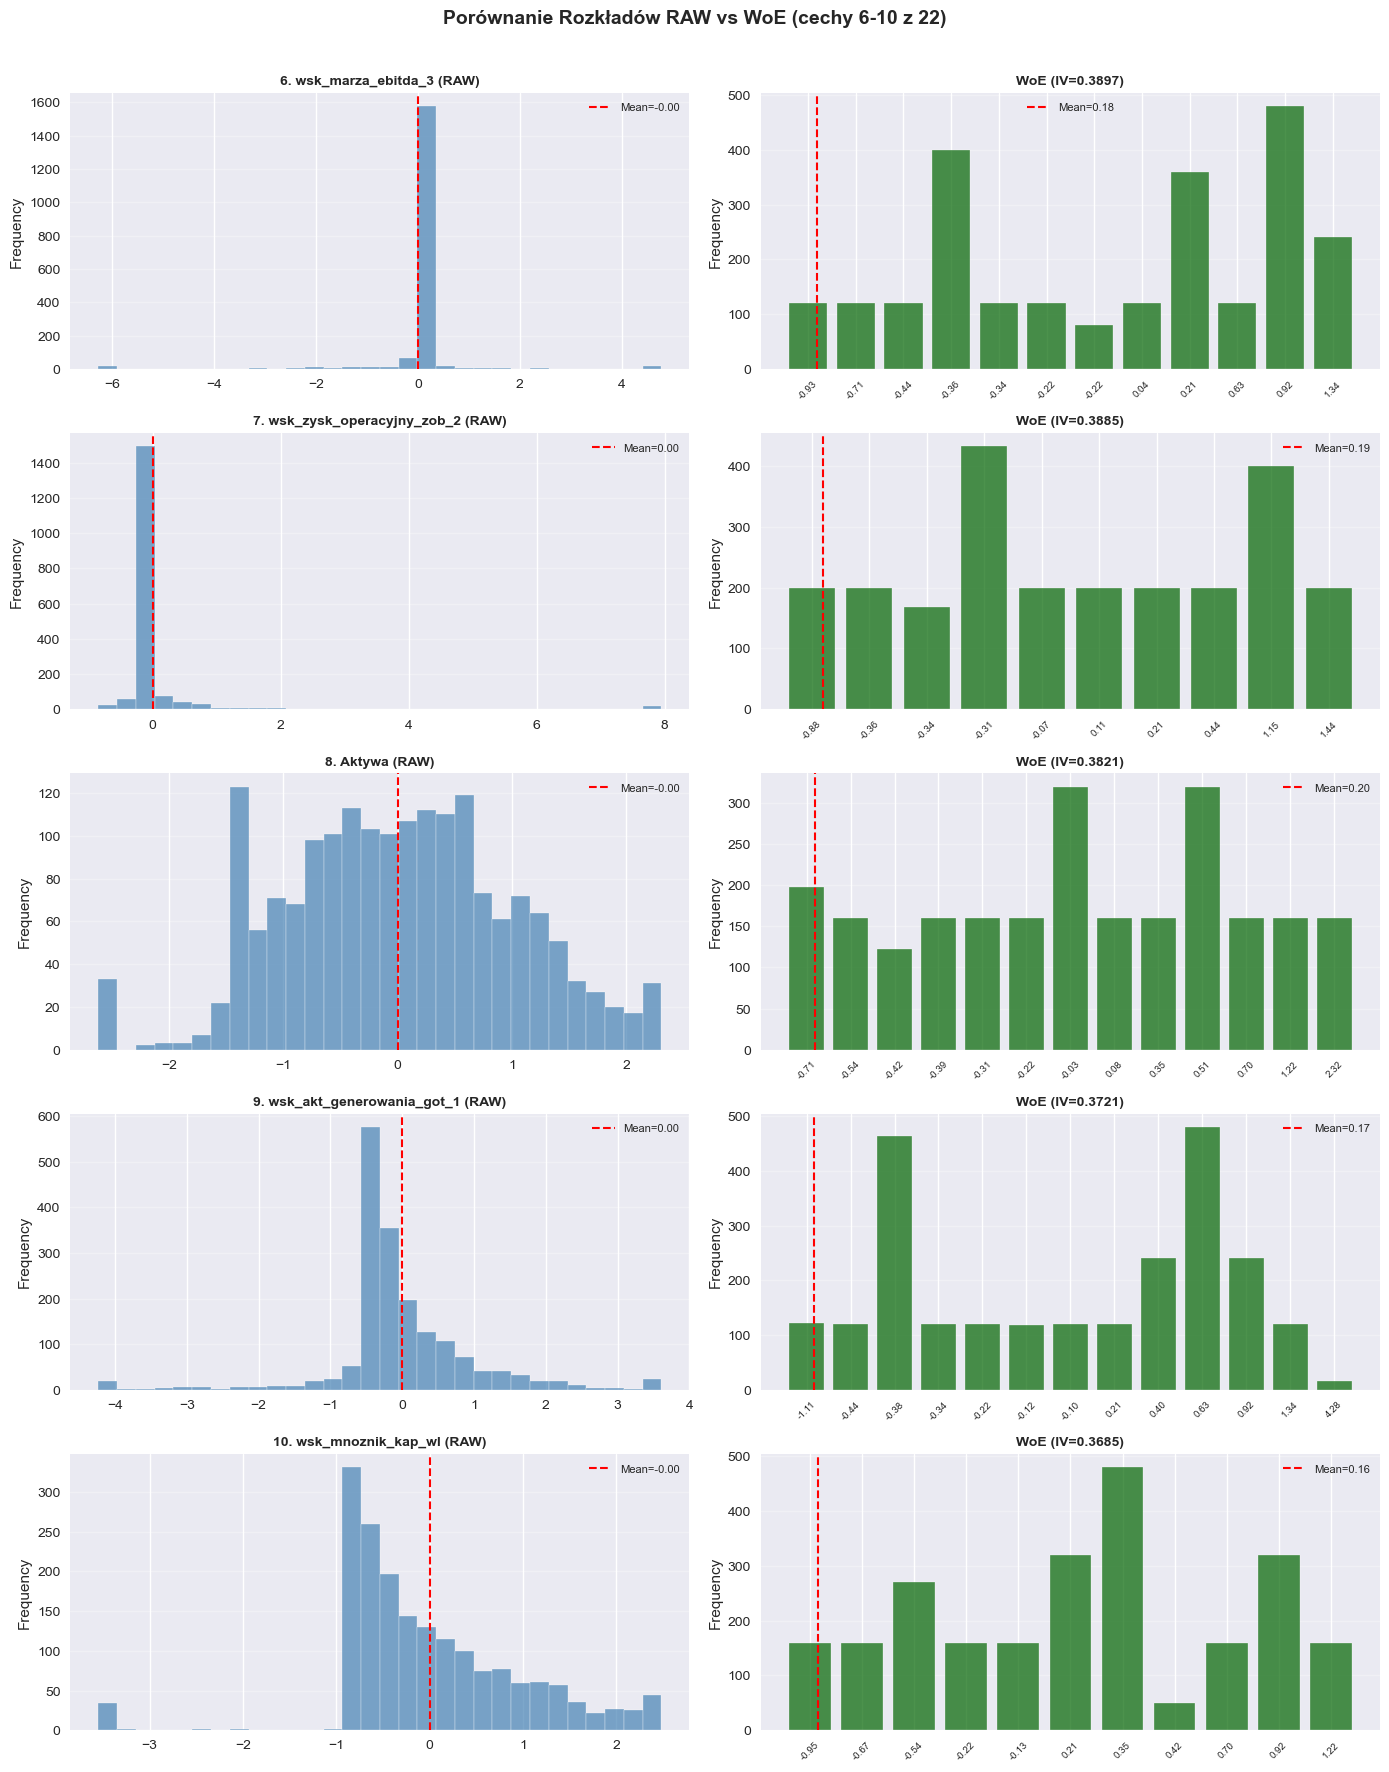

   ✅ Figura 2/5: cechy 6-10


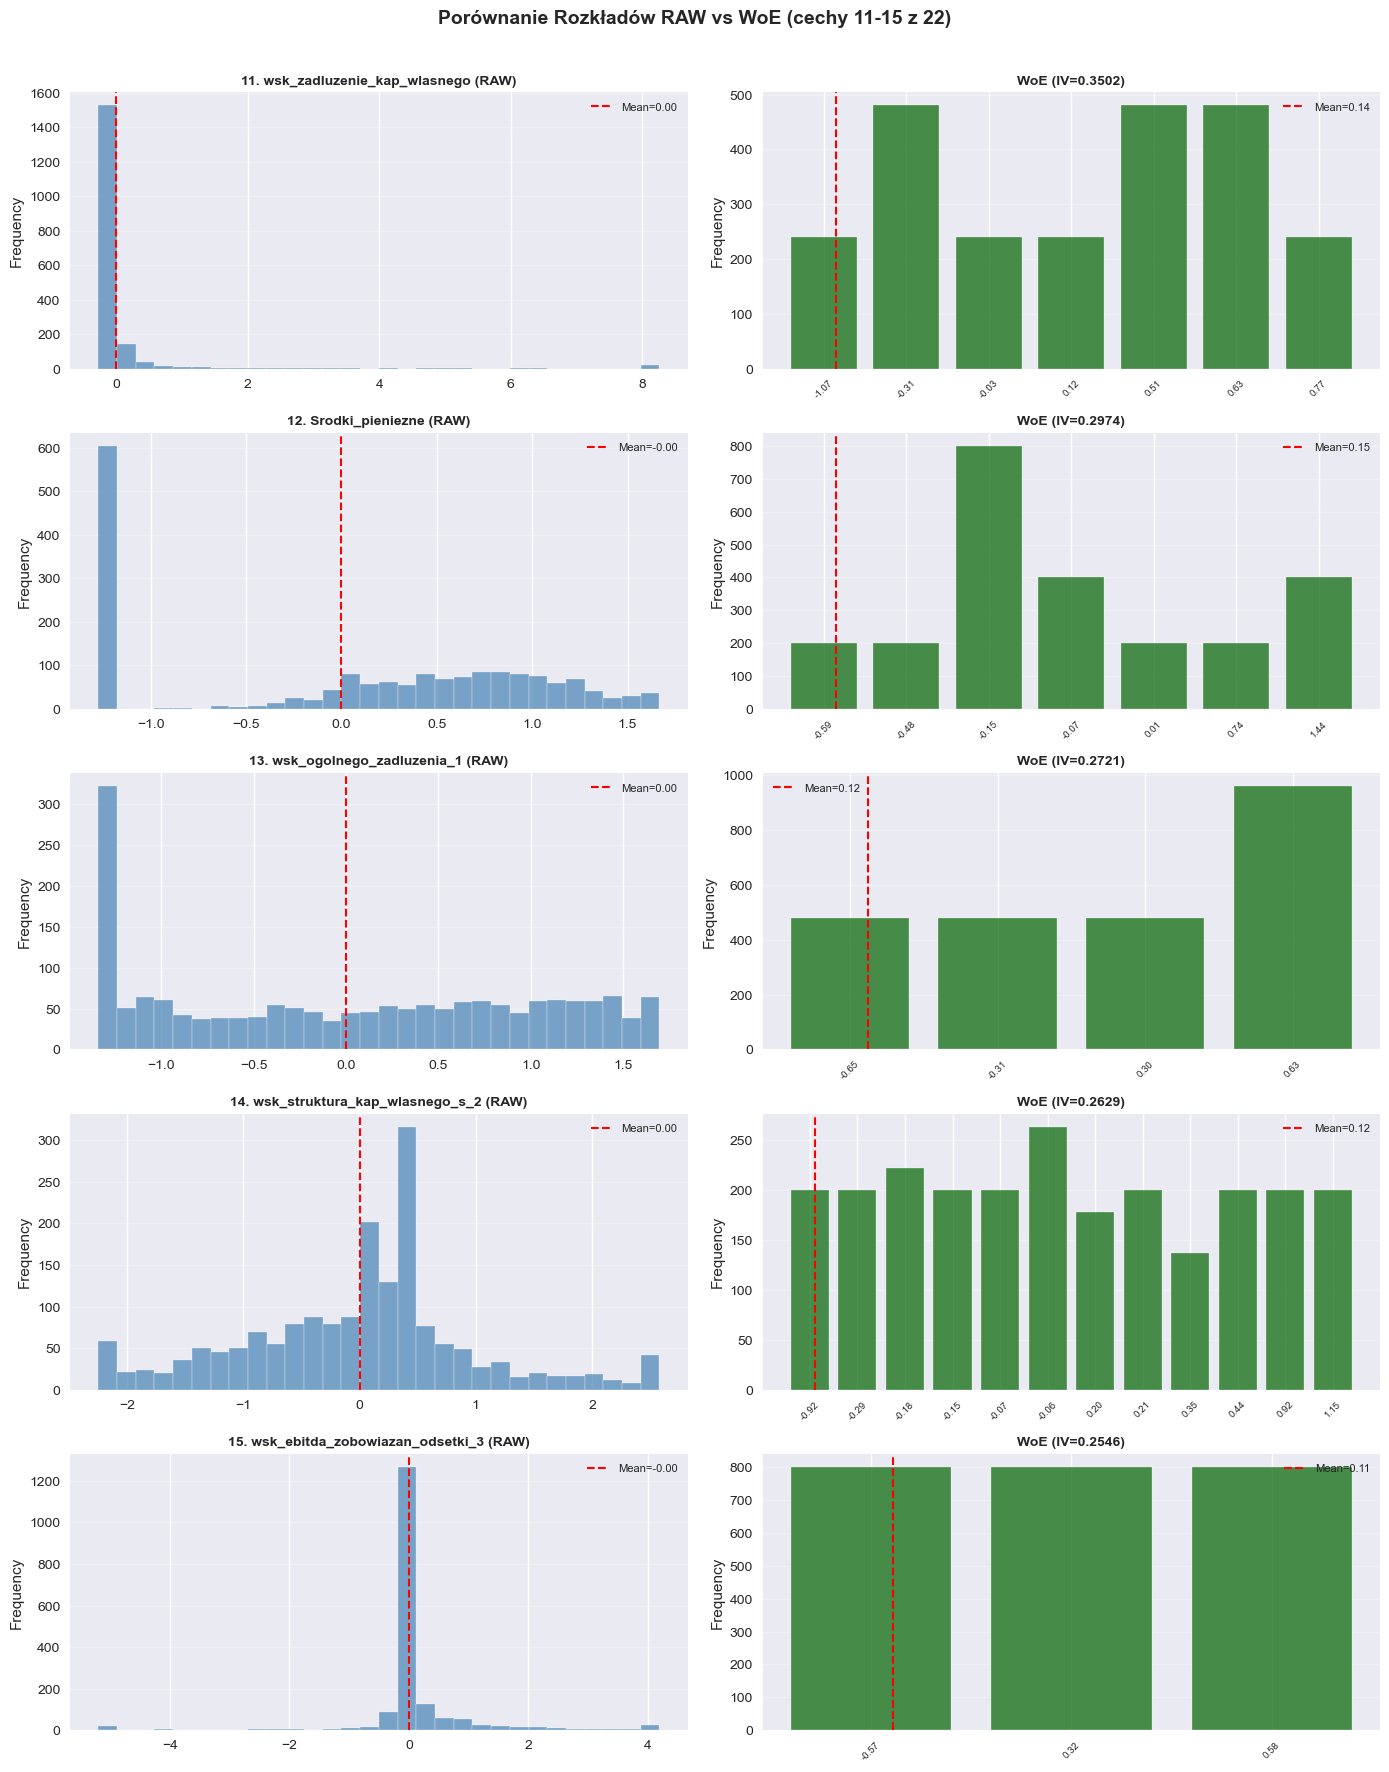

   ✅ Figura 3/5: cechy 11-15


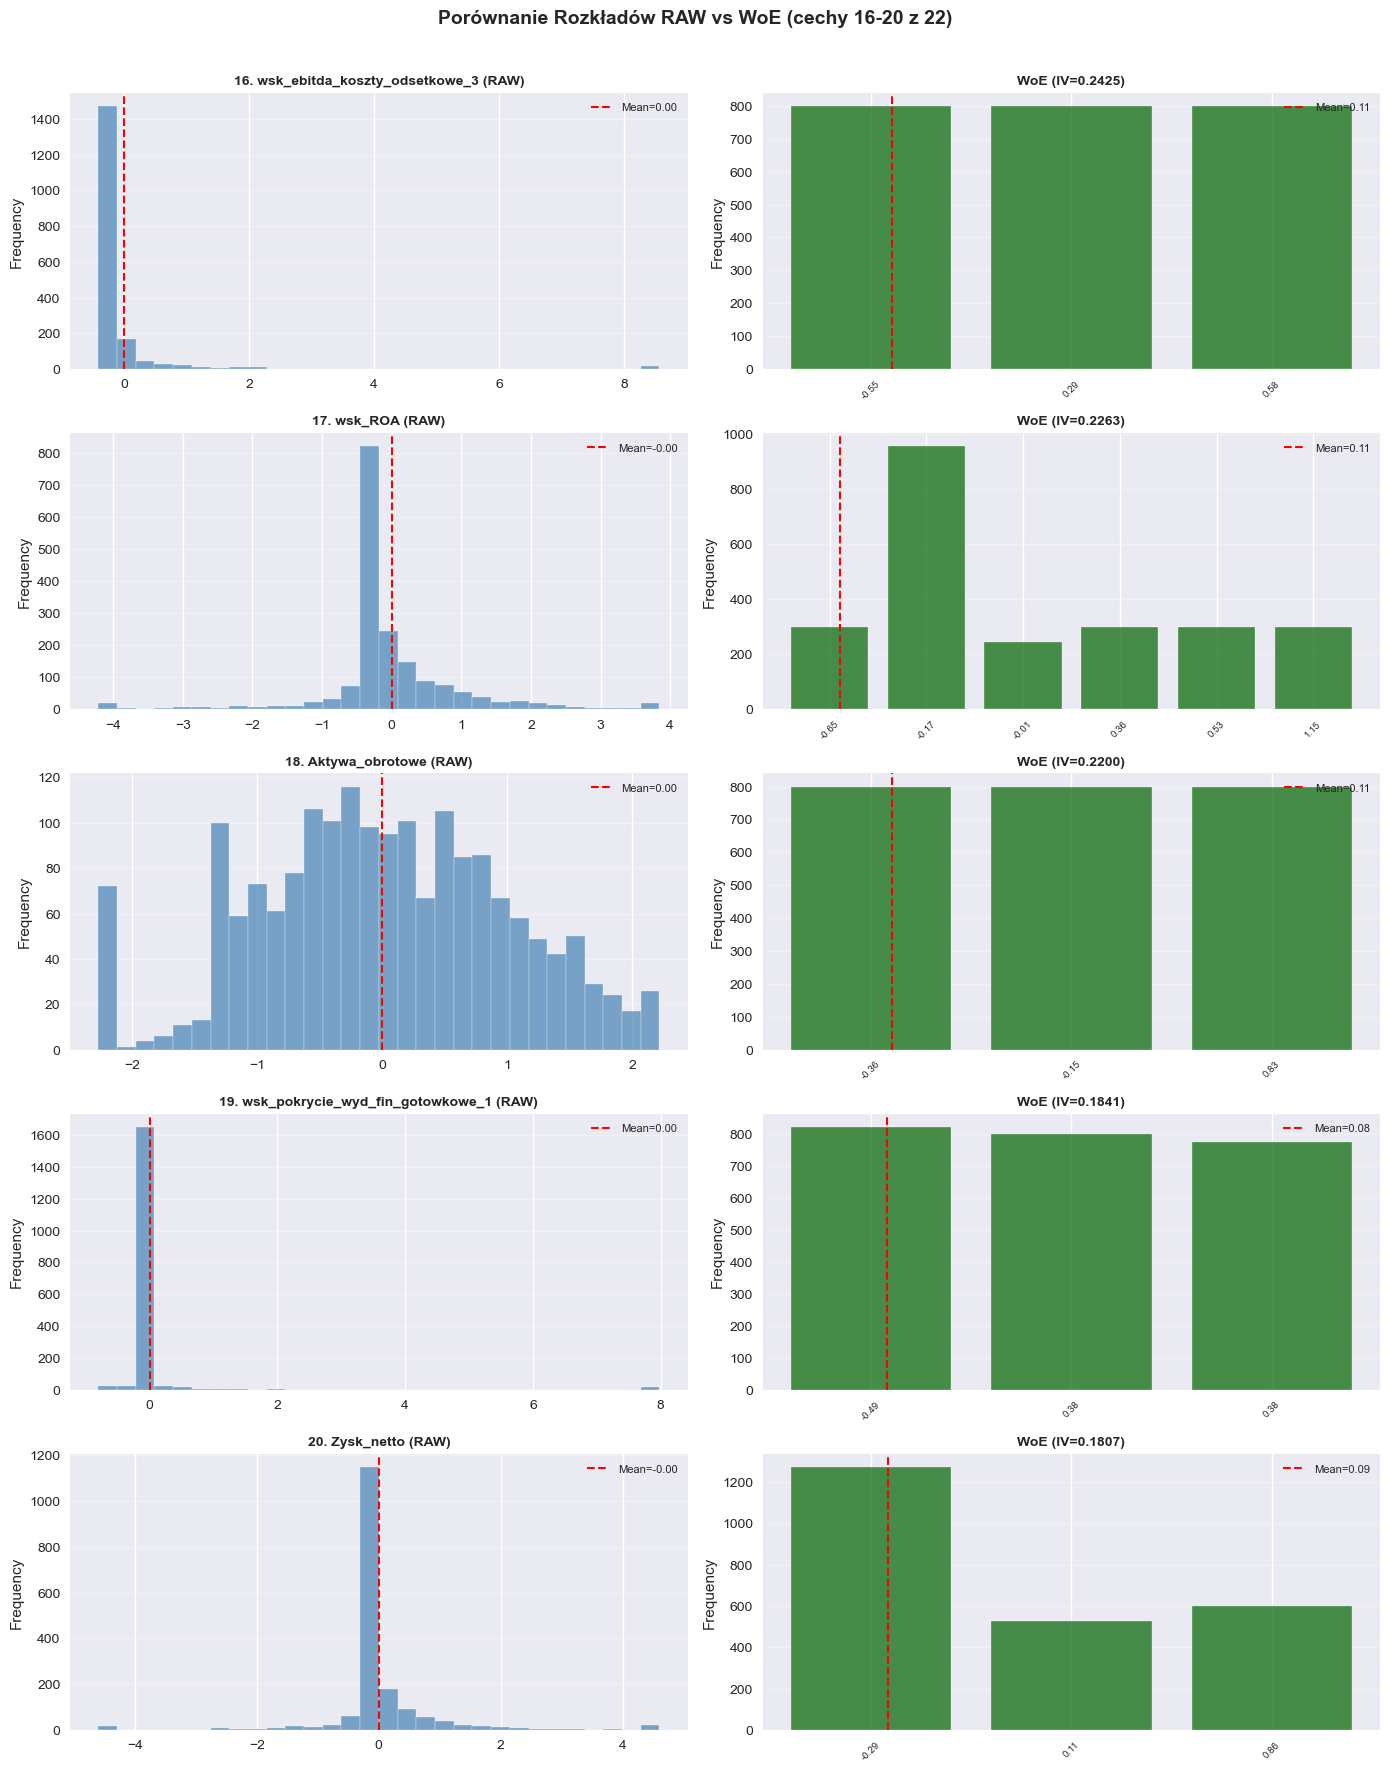

   ✅ Figura 4/5: cechy 16-20


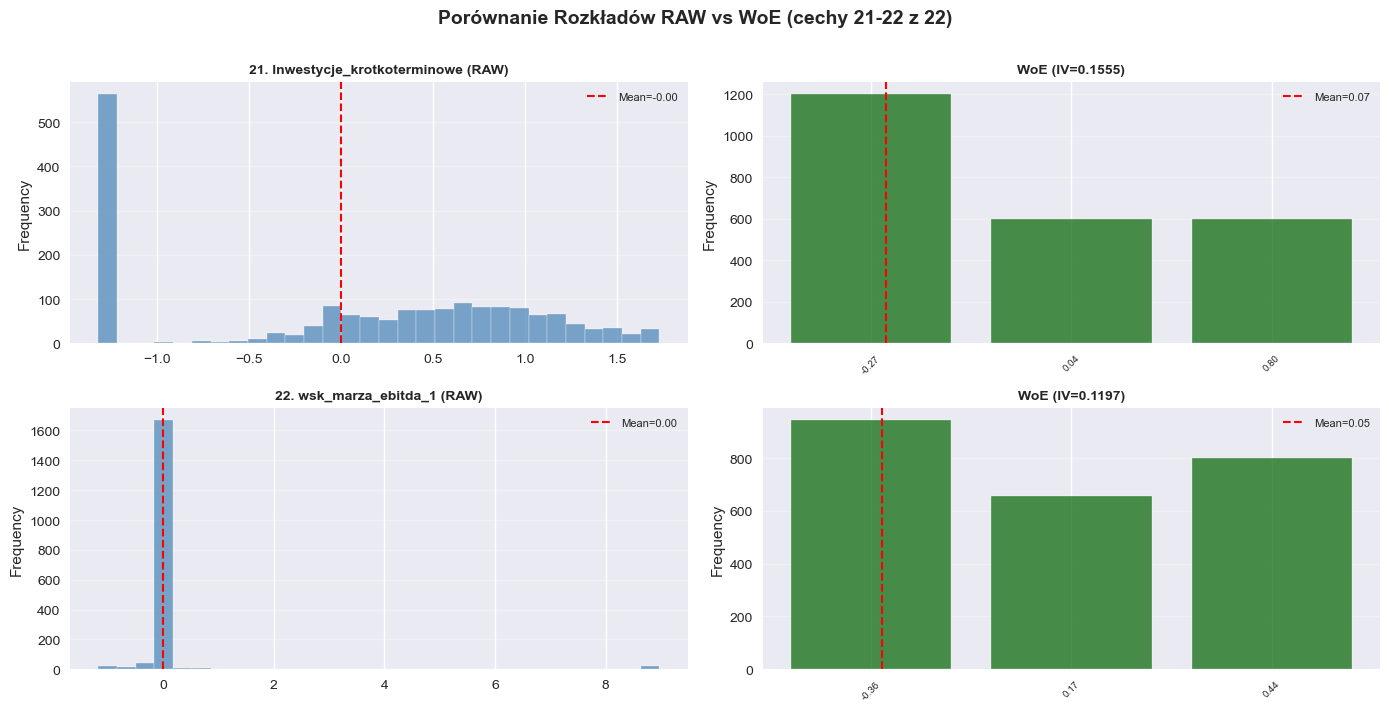

   ✅ Figura 5/5: cechy 21-22

✅ Wyświetlono porównanie rozkładów dla wszystkich 22 cech!


5️⃣  PODSUMOWANIE

📊 WYBRANYCH CECH: 22
   Very Strong/Strong (IV ≥ 0.3):  11
   Medium (0.1 ≤ IV < 0.3):        11
   Weak (0.02 ≤ IV < 0.1):         0

⚠️  WIELOKOLINEARNOŚĆ: 9 par o |r| > 0.7

✅ WoE transformation zakończona!


In [70]:
print("="*80)
print("📊 EDA - ANALIZA JAKOŚCI WoE (BASIC SCORECARD)")
print("="*80)

# ============================================================================
# 1. IV RANKING - TOP 10 CECH
# ============================================================================
print("\n\n1️⃣  IV RANKING - TOP 10 CECH")
print("="*80)

# Zbuduj dataframe z IV z woe_mappings
iv_data = []
for feat, info in woe_mappings_basic.items():
    woe_table = info['table']
    iv_total = woe_table['iv'].sum() if 'iv' in woe_table.columns else 0
    n_bins = info['bins']
    
    # Kategoryzacja
    if iv_total >= 0.5: power = "Very Strong"
    elif iv_total >= 0.3: power = "Strong"
    elif iv_total >= 0.1: power = "Medium"
    elif iv_total >= 0.02: power = "Weak"
    else: power = "Unpredictive"
    
    iv_data.append({
        'feature': feat,
        'IV': iv_total,
        'bins': n_bins,
        'Power': power
    })

iv_df_basic = pd.DataFrame(iv_data).sort_values('IV', ascending=False)

# Wizualizacja rozkładu mocy
power_counts = iv_df_basic['Power'].value_counts()
print(f"\n📊 Rozkład mocy predykcyjnej ({len(iv_df_basic)} cech):\n")

power_order = ["Very Strong", "Strong", "Medium", "Weak", "Unpredictive"]
for power in power_order:
    count = power_counts.get(power, 0)
    if count > 0:
        bar = "█" * int(count / 2)
        print(f"   {power:15} ({count:2}): {bar}")

# Top 10
print(f"\n📈 TOP 10 CECH:")
print(f"\n   {'Rank':<6} {'Feature':<45} {'IV':<10} {'Bins':<6} {'Power'}")
print("   " + "-"*80)

for idx, (i, row) in enumerate(iv_df_basic.head(10).iterrows()):
    print(f"   {idx+1:<6} {row['feature']:<45} {row['IV']:<10.4f} {row['bins']:<6} {row['Power']}")

# ============================================================================
# 2. WoE TABLES - TOP 5 FEATURES
# ============================================================================
print("\n\n2️⃣  WoE TABLES - TOP 5 FEATURES")
print("="*80)

top5_basic = iv_df_basic.head(5)['feature'].tolist()

for i, feat in enumerate(top5_basic, 1):
    if feat not in woe_mappings_basic:
        print(f"\n⚠️  {feat}: Brak danych")
        continue
    
    woe_table = woe_mappings_basic[feat]['table']
    n_bins = woe_mappings_basic[feat]['bins']
    iv_total = woe_table['iv'].sum() if 'iv' in woe_table.columns else 0
    
    print(f"\n{i}. {feat}")
    print(f"   IV: {iv_total:.4f}, Bins: {n_bins}")
    print(f"\n   {'Bin':<15} {'Count':>8} {'Bad%':>8} {'WoE':>10} {'IV':>10}")
    print("   " + "-"*55)
    
    for _, row in woe_table.iterrows():
        bin_label = str(row.get('bin', row.get('range', 'N/A')))[:15]
        count = row.get('count', row.get('total', 0))
        bad_rate = row.get('bad_rate', row.get('event_rate', 0)) * 100
        woe = row.get('woe', 0)
        iv = row.get('iv', 0)
        print(f"   {bin_label:<15} {count:>8.0f} {bad_rate:>7.1f}% {woe:>10.3f} {iv:>10.4f}")

# ============================================================================
# 3. MACIERZ KORELACJI
# ============================================================================
print("\n\n3️⃣  MACIERZ KORELACJI")
print("="*80)

# Używamy X_train_val_woe_basic (utworzone w poprzedniej komórce)
corr_woe_basic = X_train_val_woe_basic.corr()

# Znajdź wysokie korelacje
high_corr = []
for i in range(len(corr_woe_basic.columns)):
    for j in range(i+1, len(corr_woe_basic.columns)):
        corr_val = corr_woe_basic.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr.append((corr_woe_basic.columns[i], corr_woe_basic.columns[j], corr_val))

if len(high_corr) > 0:
    print(f"\n⚠️  Wysokie korelacje (|r| > 0.7): {len(high_corr)}")
    for feat1, feat2, corr_val in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True)[:5]:
        f1 = feat1.replace('_woe', '')
        f2 = feat2.replace('_woe', '')
        print(f"   {f1} ↔ {f2}: {corr_val:+.3f}")
else:
    print(f"\n✅ Brak wysokich korelacji (|r| > 0.7)")

# Heatmap (jeśli nie za dużo cech)
if X_train_val_woe_basic.shape[1] <= 25:
    print(f"\n📊 Heatmap macierzy korelacji:")
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_woe_basic, 
                annot=False,
                cmap='coolwarm', 
                center=0,
                vmin=-1, 
                vmax=1,
                square=True,
                cbar_kws={"label": "Correlation"})
    plt.title('Macierz Korelacji - WoE Features (Basic Scorecard)', fontsize=14, pad=20)
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print(f"   (Pominięto heatmap - zbyt dużo cech)")

# ============================================================================
# 4. ROZKŁADY - WSZYSTKIE CECHY (RAW vs WoE)
# ============================================================================
print("\n\n4️⃣  ROZKŁADY - WSZYSTKIE CECHY (RAW vs WoE)")
print("="*80)

# Pobierz wszystkie cechy posortowane według IV
all_features_woe = iv_df_basic['feature'].tolist()
n_features_plot = len(all_features_woe)

print(f"\n📊 Porównanie rozkładów dla {n_features_plot} cech:")
print("   Niebieski = RAW (po Full Pipeline preprocessing)")
print("   Zielony = WoE (Weight of Evidence)")

# Oblicz ile wierszy potrzebujemy (2 kolumny: RAW | WoE, po 4 cechy na figurę)
features_per_figure = 5  # 5 cech na jedną figurę
n_figures = int(np.ceil(n_features_plot / features_per_figure))

for fig_idx in range(n_figures):
    start_idx = fig_idx * features_per_figure
    end_idx = min(start_idx + features_per_figure, n_features_plot)
    features_batch = all_features_woe[start_idx:end_idx]
    
    n_rows = len(features_batch)
    fig, axes = plt.subplots(n_rows, 2, figsize=(14, 3.5 * n_rows))
    
    # Jeśli tylko 1 cecha, axes nie jest 2D
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for row_idx, feat in enumerate(features_batch):
        feat_woe_name = f"{feat}_woe"
        global_idx = start_idx + row_idx + 1
        iv_val = iv_df_basic[iv_df_basic['feature'] == feat]['IV'].values[0]
        
        # RAW (lewa kolumna)
        if feat in X_train_full.columns:
            data_raw = X_train_full[feat].dropna()
            axes[row_idx, 0].hist(data_raw, bins=30, alpha=0.7, color='steelblue', edgecolor='white')
            axes[row_idx, 0].axvline(data_raw.mean(), color='red', linestyle='--', linewidth=1.5, label=f'Mean={data_raw.mean():.2f}')
            axes[row_idx, 0].set_title(f'{global_idx}. {feat[:40]}... (RAW)' if len(feat) > 40 else f'{global_idx}. {feat} (RAW)', 
                                       fontsize=10, fontweight='bold')
            axes[row_idx, 0].set_ylabel('Frequency')
            axes[row_idx, 0].grid(axis='y', alpha=0.3)
            axes[row_idx, 0].legend(fontsize=8)
        else:
            axes[row_idx, 0].text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=12)
            axes[row_idx, 0].set_title(f'{global_idx}. {feat} (RAW - brak)', fontsize=10)
        
        # WoE (prawa kolumna) - używamy X_train_val_woe_basic
        if feat_woe_name in X_train_val_woe_basic.columns:
            data_woe = X_train_val_woe_basic[feat_woe_name].dropna()
            n_unique = data_woe.nunique()
            
            # Jeśli mało unikalnych wartości, użyj bar plot
            if n_unique <= 15:
                value_counts = data_woe.value_counts().sort_index()
                axes[row_idx, 1].bar(range(len(value_counts)), value_counts.values, 
                                     alpha=0.7, color='darkgreen', edgecolor='white')
                axes[row_idx, 1].set_xticks(range(len(value_counts)))
                axes[row_idx, 1].set_xticklabels([f'{v:.2f}' for v in value_counts.index], rotation=45, fontsize=7)
            else:
                axes[row_idx, 1].hist(data_woe, bins=20, alpha=0.7, color='darkgreen', edgecolor='white')
            
            axes[row_idx, 1].axvline(data_woe.mean(), color='red', linestyle='--', linewidth=1.5, label=f'Mean={data_woe.mean():.2f}')
            axes[row_idx, 1].set_title(f'WoE (IV={iv_val:.4f})', fontsize=10, fontweight='bold')
            axes[row_idx, 1].set_ylabel('Frequency')
            axes[row_idx, 1].grid(axis='y', alpha=0.3)
            axes[row_idx, 1].legend(fontsize=8)
        else:
            axes[row_idx, 1].text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=12)
            axes[row_idx, 1].set_title(f'WoE (brak)', fontsize=10)
    
    fig.suptitle(f'Porównanie Rozkładów RAW vs WoE (cechy {start_idx+1}-{end_idx} z {n_features_plot})', 
                 fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()
    
    print(f"   ✅ Figura {fig_idx+1}/{n_figures}: cechy {start_idx+1}-{end_idx}")

print(f"\n✅ Wyświetlono porównanie rozkładów dla wszystkich {n_features_plot} cech!")

# ============================================================================
# 5. PODSUMOWANIE
# ============================================================================
print("\n\n5️⃣  PODSUMOWANIE")
print("="*80)

n_features = X_train_val_woe_basic.shape[1]
excellent = (iv_df_basic['IV'] >= 0.3).sum()
medium = ((iv_df_basic['IV'] >= 0.1) & (iv_df_basic['IV'] < 0.3)).sum()
weak = ((iv_df_basic['IV'] >= 0.02) & (iv_df_basic['IV'] < 0.1)).sum()

print(f"\n📊 WYBRANYCH CECH: {n_features}")
print(f"   Very Strong/Strong (IV ≥ 0.3):  {excellent}")
print(f"   Medium (0.1 ≤ IV < 0.3):        {medium}")
print(f"   Weak (0.02 ≤ IV < 0.1):         {weak}")

# Korelacje
if len(high_corr) == 0:
    print(f"\n✅ WIELOKOLINEARNOŚĆ: OK")
else:
    print(f"\n⚠️  WIELOKOLINEARNOŚĆ: {len(high_corr)} par o |r| > 0.7")

print("\n✅ WoE transformation zakończona!")
print("="*80)

In [71]:
import numpy as np
import pandas as pd
import time
import random
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_recall_curve, auc, log_loss, brier_score_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression

print("="*80)
print("HYPERPARAMETER TUNING - ADVANCED SCORECARD")
print("="*80)

# ============================================
# FUNKCJE POMOCNICZE
# ============================================

def monotonicity_score(woe_table):
    """Oblicza score monotoniczności WoE (0-100%)"""
    woe_values = woe_table['woe'].values
    if len(woe_values) < 2:
        return 100.0
    
    diffs = np.diff(woe_values)
    n_positive = np.sum(diffs > 0)
    n_negative = np.sum(diffs < 0)
    n_zero = np.sum(diffs == 0)
    total_changes = len(diffs)
    
    if total_changes == 0:
        return 100.0
    
    monotonic_count = max(n_positive, n_negative) + n_zero
    return (monotonic_count / total_changes) * 100


def calculate_ks_statistic(y_true, y_pred_proba):
    """Oblicza statystykę Kołmogorowa-Smirnova"""
    df = pd.DataFrame({'true': y_true, 'pred': y_pred_proba})
    df = df.sort_values('pred', ascending=False).reset_index(drop=True)
    
    df['cumulative_bad'] = df['true'].cumsum() / df['true'].sum()
    df['cumulative_good'] = (1 - df['true']).cumsum() / (1 - df['true']).sum()
    
    ks = (df['cumulative_bad'] - df['cumulative_good']).abs().max()
    return ks


def calculate_all_metrics(y_true, y_pred_proba):
    """Oblicza wszystkie metryki jakości modelu"""
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)
    ks = calculate_ks_statistic(y_true, y_pred_proba)
    logloss = log_loss(y_true, y_pred_proba)
    brier = brier_score_loss(y_true, y_pred_proba)
    
    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'ks': ks,
        'log_loss': logloss,
        'brier': brier
    }


def calculate_feature_bins_info_adv(X_data, y_data, feature, bin_options=[3, 4, 5, 6, 7, 8, 10, 12, 15, 20], min_mono=70.0):
    """Dla danej cechy oblicza IV i mono dla wszystkich opcji binów."""
    results = []
    for n_bins in bin_options:
        try:
            df_temp = pd.DataFrame({feature: X_data[feature], 'target': y_data.values})
            woe_table, iv_value = calculate_woe_iv(df_temp, feature, 'target', bins=n_bins)
            mono = monotonicity_score(woe_table)
            
            if mono >= min_mono:
                results.append({'bins': n_bins, 'iv': iv_value, 'mono': mono})
        except:
            continue
    return results


# ============================================
# PARAMETRY DLA ADVANCED SCORECARD
# ============================================
param_grid_adv = {
    'n_features': [12, 15, 18],
    'solver': ['liblinear', 'lbfgs'],
    'C': [0.1]     # POPRAWIONE
}

BIN_OPTIONS_ADV = [3, 4, 5, 6, 7, 8, 10, 12, 15, 20]
MIN_MONO_PER_FEATURE_ADV = 70.0
MIN_AVG_MONO_ADV = 80.0
TOP_FEATURES_TO_CONSIDER_ADV = 30

print(f"\n⚡ KRYTERIA DLA ADVANCED SCORECARD:")
print(f"   • Dane: Advanced Pipeline (Feature Engineering)")
print(f"   • TYLKO TOP {TOP_FEATURES_TO_CONSIDER_ADV} CECH według IV")
print(f"   • Każda cecha mono >= {MIN_MONO_PER_FEATURE_ADV}%")
print(f"   • Średnia mono >= {MIN_AVG_MONO_ADV}%")
print(f"   • Biny testowane: {BIN_OPTIONS_ADV}")

# ============================================
# PRZYGOTOWANIE DANYCH
# ============================================
print("\n" + "="*80)
print("PRZYGOTOWANIE DANYCH")
print("-"*80)

X_train_val_adv = pd.concat([X_train_advanced_raw, X_val_advanced_raw], axis=0).reset_index(drop=True)
y_train_val_adv = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

print(f"\n📊 Dane Advanced Pipeline:")
print(f"   TRAIN+VAL: {len(X_train_val_adv)} obs, {X_train_val_adv.shape[1]} cech (do treningu)")
print(f"   TEST:      {len(X_test_advanced_raw)} obs (do walidacji)")

# ============================================
# KROK 1: ANALIZA BINOWANIA
# ============================================

print("\n" + "="*80)
print("KROK 1: ANALIZA OPCJI BINOWANIA (na TRAIN+VAL)")
print("-"*80)

start_time_adv = time.time()

adv_features = X_train_val_adv.columns.tolist()
print(f"   Cech do analizy: {len(adv_features)}")

print(f"\n🔧 Szybka analiza IV...")
all_features_iv_adv = {}

for i, feature in enumerate(adv_features):
    if (i+1) % 10 == 0:
        print(f"      Przetworzono {i+1}/{len(adv_features)}...")
    try:
        df_temp = pd.DataFrame({feature: X_train_val_adv[feature], 'target': y_train_val_adv.values})
        _, iv_value = calculate_woe_iv(df_temp, feature, 'target', bins=10)
        all_features_iv_adv[feature] = iv_value
    except:
        pass

all_features_sorted_adv = sorted(all_features_iv_adv.keys(), key=lambda f: all_features_iv_adv[f], reverse=True)
top_features_adv = all_features_sorted_adv[:TOP_FEATURES_TO_CONSIDER_ADV]

print(f"\n   ✅ Wybrano TOP {len(top_features_adv)} cech według IV")
print(f"\n📊 TOP {TOP_FEATURES_TO_CONSIDER_ADV} cech:")
for i, feat in enumerate(top_features_adv, 1):
    print(f"   {i:2}. {feat:<45} IV={all_features_iv_adv[feat]:.4f}")

print(f"\n🔧 Szczegółowa analiza binowania...")
feature_bin_options_adv = {}

for feature in top_features_adv:
    bins_info = calculate_feature_bins_info_adv(X_train_val_adv, y_train_val_adv, feature, BIN_OPTIONS_ADV)
    if bins_info:
        feature_bin_options_adv[feature] = bins_info

print(f"   ✅ {len(feature_bin_options_adv)}/{len(top_features_adv)} cech spełnia mono >= {MIN_MONO_PER_FEATURE_ADV}%")

feature_best_iv_adv = {}

for feat, options in feature_bin_options_adv.items():
    best = max(options, key=lambda x: x['iv'])
    feature_best_iv_adv[feat] = best['iv']

features_sorted_by_iv_adv = sorted(feature_best_iv_adv.keys(), key=lambda f: feature_best_iv_adv[f], reverse=True)

print(f"\n📊 Cechy do Grid Search ({len(features_sorted_by_iv_adv)}):")
for i, feat in enumerate(features_sorted_by_iv_adv, 1):
    best_option = max(feature_bin_options_adv[feat], key=lambda x: x['iv'])
    print(f"   {i:2}. {feat:<40} IV={best_option['iv']:.4f} (bins={best_option['bins']}, mono={best_option['mono']:.1f}%)")

# ============================================
# KROK 2: GRID SEARCH
# ============================================

print("\n" + "="*80)
print("KROK 2: GRID SEARCH")
print("-"*80)

best_score_adv = 0
best_params_adv = None
best_features_adv = None
results_grid_adv = []
configs_tested_adv = 0
configs_successful_adv = 0
total_combinations_adv = len(list(ParameterGrid(param_grid_adv)))

print(f"\n🔄 Grid Search na {len(features_sorted_by_iv_adv)} cechach...\n")

for param_idx, params in enumerate(ParameterGrid(param_grid_adv)):
    n_features = params['n_features']
    selected_features = features_sorted_by_iv_adv[:min(n_features, len(features_sorted_by_iv_adv))]

    if len(selected_features) < 5:
        continue

    configs_to_test = []

    config_max_iv = [(feat, max(feature_bin_options_adv[feat], key=lambda x: x['iv'])) for feat in selected_features]
    configs_to_test.append(config_max_iv)

    config_max_mono = [(feat, max(feature_bin_options_adv[feat], key=lambda x: x['mono'])) for feat in selected_features]
    configs_to_test.append(config_max_mono)

    config_balanced = []
    for feat in selected_features:
        options = feature_bin_options_adv[feat]
        options2 = [dict(o) for o in options]
        for opt in options2:
            opt['score'] = opt['iv'] * (opt['mono'] / 100.0)
        config_balanced.append((feat, max(options2, key=lambda x: x['score'])))
    configs_to_test.append(config_balanced)

    config_min_bins = [(feat, min(feature_bin_options_adv[feat], key=lambda x: x['bins'])) for feat in selected_features]
    configs_to_test.append(config_min_bins)

    config_max_bins = [(feat, max(feature_bin_options_adv[feat], key=lambda x: x['bins'])) for feat in selected_features]
    configs_to_test.append(config_max_bins)

    for _ in range(10):
        config_random = [(feat, random.choice(feature_bin_options_adv[feat])) for feat in selected_features]
        configs_to_test.append(config_random)

    for mix_ratio in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        split_point = int(len(selected_features) * mix_ratio)
        config_mix = []
        for i, feat in enumerate(selected_features):
            if i < split_point:
                opt = max(feature_bin_options_adv[feat], key=lambda x: x['iv'])
            else:
                opt = max(feature_bin_options_adv[feat], key=lambda x: x['mono'])
            config_mix.append((feat, opt))
        configs_to_test.append(config_mix)

    for iv_weight in [0.3, 0.5, 0.7, 0.85, 0.95]:
        mono_weight = 1.0 - iv_weight
        config_weighted = []
        for feat in selected_features:
            options2 = [dict(o) for o in feature_bin_options_adv[feat]]
            for opt in options2:
                opt['weighted_score'] = opt['iv'] * iv_weight + (opt['mono']/100.0)*mono_weight
            config_weighted.append((feat, max(options2, key=lambda x: x['weighted_score'])))
        configs_to_test.append(config_weighted)

    for target_bins in [5, 7, 10, 12, 15]:
        config_target_bins = []
        for feat in selected_features:
            options = feature_bin_options_adv[feat]
            closest = sorted(options, key=lambda x: abs(x['bins'] - target_bins))[:3]
            best_opt = max(closest if closest else options, key=lambda x: x['iv'])
            config_target_bins.append((feat, best_opt))
        configs_to_test.append(config_target_bins)

    for config in configs_to_test:
        configs_tested_adv += 1

        avg_mono = np.mean([info['mono'] for _, info in config])
        min_mono = min([info['mono'] for _, info in config])

        if avg_mono < MIN_AVG_MONO_ADV or min_mono < MIN_MONO_PER_FEATURE_ADV:
            continue

        actual_n_features = len(config)

        try:
            X_trainval_woe = pd.DataFrame()
            woe_mappings = {}

            for feat, info in config:
                n_bins = info['bins']
                df_temp = pd.DataFrame({feat: X_train_val_adv[feat], 'target': y_train_val_adv})
                woe_values = woe_transform(df_temp, feat, 'target', bins=n_bins)
                X_trainval_woe[f"{feat}_woe"] = pd.to_numeric(woe_values, errors='coerce')
                
                woe_table, _ = calculate_woe_iv(df_temp, feat, 'target', bins=n_bins)
                woe_mappings[feat] = {'table': woe_table, 'bins': n_bins}

            if X_trainval_woe.shape[1] == 0:
                continue

            X_test_woe = pd.DataFrame()
            for feat, info in config:
                n_bins = info['bins']
                df_temp = pd.DataFrame({feat: X_test_advanced_raw[feat], 'target': y_test})
                woe_values = woe_transform(df_temp, feat, 'target', bins=n_bins)
                X_test_woe[f"{feat}_woe"] = pd.to_numeric(woe_values, errors='coerce')

            model = LogisticRegression(
                C=params['C'],
                solver=params['solver'],
                max_iter=1000,
                random_state=42,
                class_weight='balanced'
            )

            model.fit(X_trainval_woe, y_train_val_adv)
            y_proba_test = model.predict_proba(X_test_woe)[:, 1]
            metrics = calculate_all_metrics(y_test, y_proba_test)

            configs_successful_adv += 1

            results_grid_adv.append({
                'n_features': actual_n_features,
                'C': params['C'],
                'solver': params['solver'],
                'roc_auc': metrics['roc_auc'],
                'pr_auc': metrics['pr_auc'],
                'ks': metrics['ks'],
                'log_loss': metrics['log_loss'],
                'brier': metrics['brier'],
                'avg_mono': avg_mono,
                'min_mono': min_mono
            })

            if metrics['roc_auc'] > best_score_adv:
                best_score_adv = metrics['roc_auc']
                best_params_adv = {
                    **params,
                    'n_features': actual_n_features,
                    'avg_mono': avg_mono,
                    'min_mono': min_mono,
                    **metrics
                }
                best_features_adv = config.copy()
                print(f"✨ BEST: AUC={best_score_adv:.4f} | cechy={actual_n_features}, C={params['C']}, solver={params['solver']}")

        except Exception as e:
            continue

elapsed_adv = time.time() - start_time_adv
print(f"\n   ✅ Zakończono: {elapsed_adv:.1f}s")
print(f"   📊 Testowano: {configs_tested_adv}, Udanych: {configs_successful_adv}")

# ============================================
# WYNIKI
# ============================================

print("\n" + "="*80)
print("🏆 NAJLEPSZA KONFIGURACJA (ADVANCED SCORECARD)")
print("="*80)

if best_params_adv and best_features_adv:
    print(f"\n📊 PARAMETRY:")
    print(f"   Cechy:    {best_params_adv['n_features']}")
    print(f"   C:        {best_params_adv['C']}")
    print(f"   Solver:   {best_params_adv['solver']}")
    print(f"   Avg Mono: {best_params_adv['avg_mono']:.1f}%")
    print(f"   Min Mono: {best_params_adv['min_mono']:.1f}%")

    print(f"\n📈 METRYKI (na TEST):")
    print(f"   ROC-AUC:  {best_params_adv['roc_auc']:.4f}")
    print(f"   PR-AUC:   {best_params_adv['pr_auc']:.4f}")
    print(f"   KS:       {best_params_adv['ks']:.4f}")
    print(f"   Log Loss: {best_params_adv['log_loss']:.4f}")
    print(f"   Brier:    {best_params_adv['brier']:.4f}")

    print(f"\n📋 CECHY ({len(best_features_adv)}):")
    for i, (feat, info) in enumerate(best_features_adv, 1):
        print(f"   {i:2}. {feat:<40} IV={info['iv']:.4f}, Mono={info['mono']:.1f}%, Bins={info['bins']}")

else:
    print("\n❌ Nie znaleziono konfiguracji spełniającej wymagania!")

print("="*80)
print("✅ GRID SEARCH DLA ADVANCED SCORECARD ZAKOŃCZONY!")
print("="*80)


HYPERPARAMETER TUNING - ADVANCED SCORECARD

⚡ KRYTERIA DLA ADVANCED SCORECARD:
   • Dane: Advanced Pipeline (Feature Engineering)
   • TYLKO TOP 30 CECH według IV
   • Każda cecha mono >= 70.0%
   • Średnia mono >= 80.0%
   • Biny testowane: [3, 4, 5, 6, 7, 8, 10, 12, 15, 20]

PRZYGOTOWANIE DANYCH
--------------------------------------------------------------------------------

📊 Dane Advanced Pipeline:
   TRAIN+VAL: 2400 obs, 30 cech (do treningu)
   TEST:      600 obs (do walidacji)

KROK 1: ANALIZA OPCJI BINOWANIA (na TRAIN+VAL)
--------------------------------------------------------------------------------
   Cech do analizy: 30

🔧 Szybka analiza IV...
      Przetworzono 10/30...
      Przetworzono 20/30...
      Przetworzono 30/30...

   ✅ Wybrano TOP 30 cech według IV

📊 TOP 30 cech:
    1. wsk_zwrot_aktywa_trwale                       IV=0.5805
    2. leverage                                      IV=0.4721
    3. wsk_poziom_kapitalu_obrotowego_netto          IV=0.4242
    4. ws

## 12. Advanced Scorecard (Feature Engineering + VIF)

Scorecard dla Advanced Pipeline z feature engineering.

In [72]:
print("="*80)
print("ADVANCED SCORECARD (OPTIMIZED)")
print("="*80)

# Sprawdź czy Grid Search się wykonał
if 'best_params_adv' not in globals() or best_params_adv is None or 'best_features_adv' not in globals():
    print("\n⚠️  Grid Search nie wykonany - używam domyślnych parametrów")
    best_params_adv = {'n_features': 15, 'C': 1.0, 'solver': 'liblinear'}
    
    # Oblicz IV jako fallback
    iv_results = []
    for feature in X_train_advanced_raw.columns:
        try:
            df_temp = pd.DataFrame({feature: X_train_advanced_raw[feature], 'target': y_train.values})
            woe_table, iv_value = calculate_woe_iv(df_temp, feature, 'target', bins=10)
            mono_score = monotonicity_score(woe_table)
            if mono_score >= 66:
                iv_results.append({'feature': feature, 'IV': iv_value, 'mono': mono_score, 'bins': 10})
        except:
            continue
    
    iv_df = pd.DataFrame(iv_results).sort_values('IV', ascending=False)
    best_features_adv = [(row['feature'], {'bins': row['bins'], 'iv': row['IV'], 'mono': row['mono']}) 
                         for _, row in iv_df.head(15).iterrows()]

# Wyświetl parametry
print(f"\n🎯 PARAMETRY:")
print(f"   Cechy:  {best_params_adv['n_features']}")
print(f"   C:      {best_params_adv['C']}")
print(f"   Solver: {best_params_adv['solver']}")
if 'avg_mono' in best_params_adv:
    print(f"   Avg Mono: {best_params_adv['avg_mono']:.1f}%")
    print(f"   Min Mono: {best_params_adv['min_mono']:.1f}%")

print(f"\n📋 WYBRANE CECHY ({len(best_features_adv)}):")
for i, (feat, info) in enumerate(best_features_adv[:10], 1):
    print(f"   {i:2}. {feat:<40} IV={info['iv']:.4f}, Mono={info['mono']:.1f}%, Bins={info['bins']}")
if len(best_features_adv) > 10:
    print(f"   ... (+{len(best_features_adv)-10} więcej)")

# WoE Transformation - TRAIN+VAL COMBINED (jak Basic Scorecard)
print(f"\n🔄 WoE Transformation z optymalnymi binami...")
print(f"   ⚠️  WAŻNE: Grid search używał val do optymalizacji, teraz trenujemy na train+val")

# Kombinuj train + val dla Advanced Pipeline
X_train_val_advanced = pd.concat([X_train_advanced_raw, X_val_advanced_raw], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

print(f"   Train+Val: {X_train_val_advanced.shape[0]} obs (train={X_train_advanced_raw.shape[0]}, val={X_val_advanced_raw.shape[0]})") 
print(f"   Test:      {X_test_advanced_raw.shape[0]} obs")

X_train_woe_advanced_sc = pd.DataFrame()
woe_mappings_advanced_sc = {}

for feat, info in best_features_adv:
    try:
        n_bins = info['bins']
        # Train+Val combined
        df_temp = pd.DataFrame({feat: X_train_val_advanced[feat], 'target': y_train_val.values})
        woe_values = woe_transform(df_temp, feat, 'target', bins=n_bins)
        X_train_woe_advanced_sc[f"{feat}_woe"] = pd.to_numeric(woe_values, errors='coerce')
        
        woe_table, _ = calculate_woe_iv(df_temp, feat, 'target', bins=n_bins)
        woe_mappings_advanced_sc[feat] = {'table': woe_table, 'bins': n_bins}
    except:
        continue

print(f"   ✅ Przekształcono {len(X_train_woe_advanced_sc.columns)} cech")

# WoE Transformation - TEST (nie dotykaj)
X_test_woe_advanced_sc = pd.DataFrame()
for feat, info in best_features_adv:
    if feat in woe_mappings_advanced_sc:
        try:
            n_bins = woe_mappings_advanced_sc[feat]['bins']
            df_temp = pd.DataFrame({feat: X_test_advanced_raw[feat], 'target': y_test.values})
            woe_values = woe_transform(df_temp, feat, 'target', bins=n_bins)
            X_test_woe_advanced_sc[f"{feat}_woe"] = pd.to_numeric(woe_values, errors='coerce')
        except:
            X_test_woe_advanced_sc[f"{feat}_woe"] = 0

print(f"   Shape train+val: {X_train_woe_advanced_sc.shape} (2400 obs)")
print(f"   Shape test:      {X_test_woe_advanced_sc.shape} (600 obs)")

# Model - trenuj na train+val
print(f"\n🎯 Trening Logistic Regression na train+val combined...")
scorecard_advanced = LogisticRegression(
    C=best_params_adv['C'],
    solver=best_params_adv['solver'],
    max_iter=1000, 
    random_state=42, 
    class_weight='balanced'
)
scorecard_advanced.fit(X_train_woe_advanced_sc, y_train_val)

y_pred_sc_adv = scorecard_advanced.predict(X_test_woe_advanced_sc)
y_proba_sc_adv = scorecard_advanced.predict_proba(X_test_woe_advanced_sc)[:, 1]

metrics_sc_adv = calculate_all_metrics(y_test, y_proba_sc_adv)

print(f"\n✅ MODEL WYTRENOWANY NA TRAIN+VAL (2400 obs)!")
print(f"\n📊 METRYKI NA ZBIORZE TESTOWYM (600 obs):")
print(f"   ROC-AUC:   {metrics_sc_adv['roc_auc']:.4f}")
print(f"   PR-AUC:    {metrics_sc_adv['pr_auc']:.4f}")
print(f"   KS:        {metrics_sc_adv['ks']:.4f}")
print(f"   Log Loss:  {metrics_sc_adv['log_loss']:.4f}")
print(f"   Brier:     {metrics_sc_adv['brier']:.4f}")

print(f"\n💾 Zapisano:")
print(f"   • scorecard_advanced - wytrenowany model (train+val)")
print(f"   • X_train_woe_advanced_sc, X_test_woe_advanced_sc - dane WoE")
print(f"   • woe_mappings_advanced_sc - mapowania WoE")
print(f"   • metrics_sc_adv - metrics for Advanced Scorecard (separate from raw pipeline models)")
print("="*80)



ADVANCED SCORECARD (OPTIMIZED)

🎯 PARAMETRY:
   Cechy:  15
   C:      0.1
   Solver: lbfgs
   Avg Mono: 81.0%
   Min Mono: 70.0%

📋 WYBRANE CECHY (15):
    1. wsk_pokrycie_zob_kr_gotowkowe_1          IV=0.3365, Mono=75.0%, Bins=5
    2. leverage                                 IV=0.4721, Mono=88.9%, Bins=10
    3. wsk_marza_brutto_2                       IV=0.4051, Mono=70.0%, Bins=15
    4. wsk_marza_ebitda_3                       IV=0.3897, Mono=70.6%, Bins=20
    5. wsk_poziom_kapitalu_obrotowego_netto     IV=0.3876, Mono=80.0%, Bins=6
    6. equity_ratio                             IV=0.3844, Mono=80.0%, Bins=6
    7. wsk_mnoznik_kap_wl                       IV=0.2952, Mono=75.0%, Bins=5
    8. wsk_ebitda_zobowiazan_odsetki_3          IV=0.2546, Mono=100.0%, Bins=3
    9. wsk_zysk_zobowiazania                    IV=0.3538, Mono=75.0%, Bins=6
   10. wsk_zadluzenie_kap_wlasnego              IV=0.3502, Mono=75.0%, Bins=10
   ... (+5 więcej)

🔄 WoE Transformation z optymalnymi binami..

### 12.1 EDA - Analiza Jakości WoE (Advanced)

Analiza WoE dla Advanced Pipeline


📊 EDA - ANALIZA JAKOŚCI WoE (ADVANCED SCORECARD)

✅ Dane WoE dostępne: 15 cech


1️⃣  IV RANKING - TOP 10 CECH

📊 Rozkład mocy predykcyjnej (15 cech):

   Strong          (10): █████
   Medium          ( 5): ██

📈 TOP 10 CECH:

   Rank   Feature                                       IV         Bins   Power
   --------------------------------------------------------------------------------
   2      leverage                                      0.4721     10     Strong
   3      wsk_marza_brutto_2                            0.4051     15     Strong
   4      wsk_marza_ebitda_3                            0.3897     20     Strong
   5      wsk_poziom_kapitalu_obrotowego_netto          0.3876     6      Strong
   6      equity_ratio                                  0.3844     6      Strong
   9      wsk_zysk_zobowiazania                         0.3538     6      Strong
   10     wsk_zadluzenie_kap_wlasnego                   0.3502     10     Strong
   1      wsk_pokrycie_zob_kr_gotowkowe_1

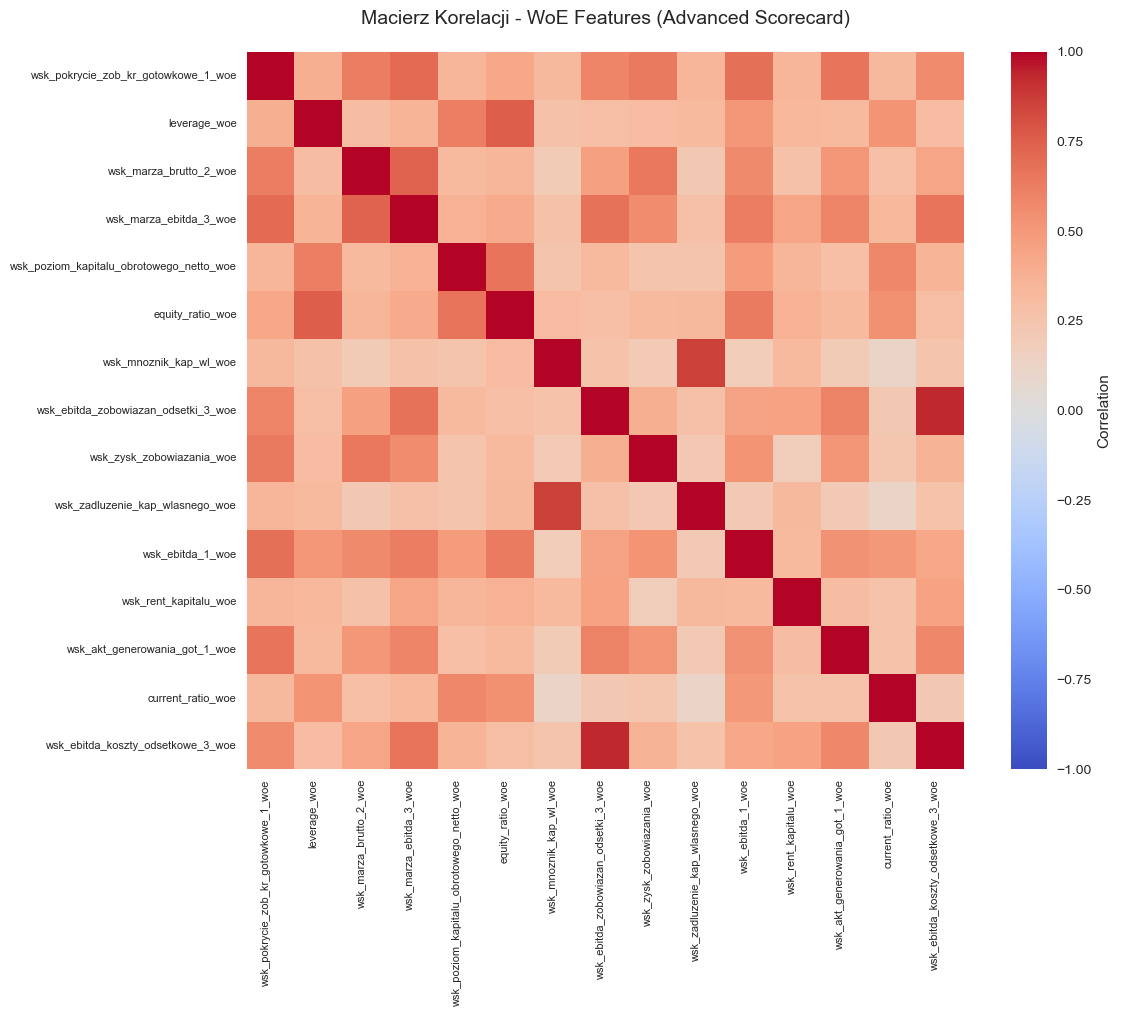



4️⃣  ROZKŁADY - TOP 3 CECH (RAW vs WoE)

1. leverage


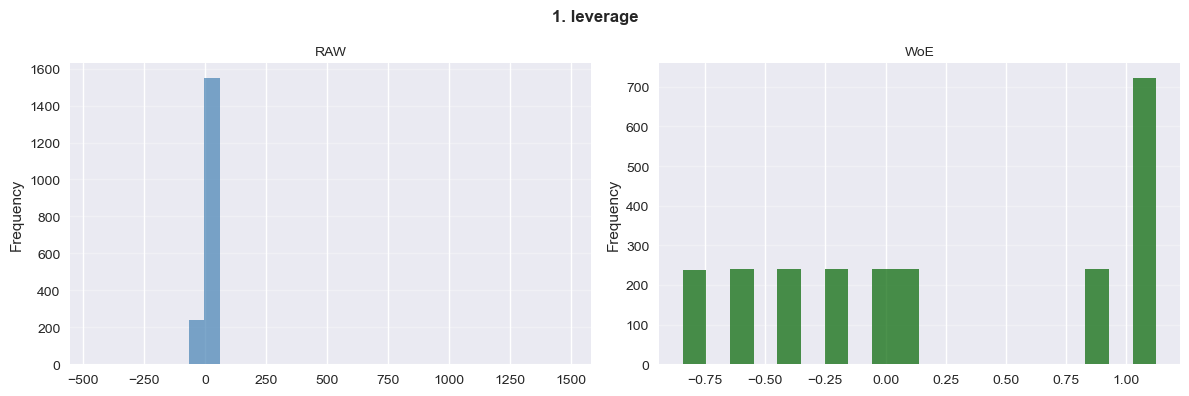


2. wsk_marza_brutto_2


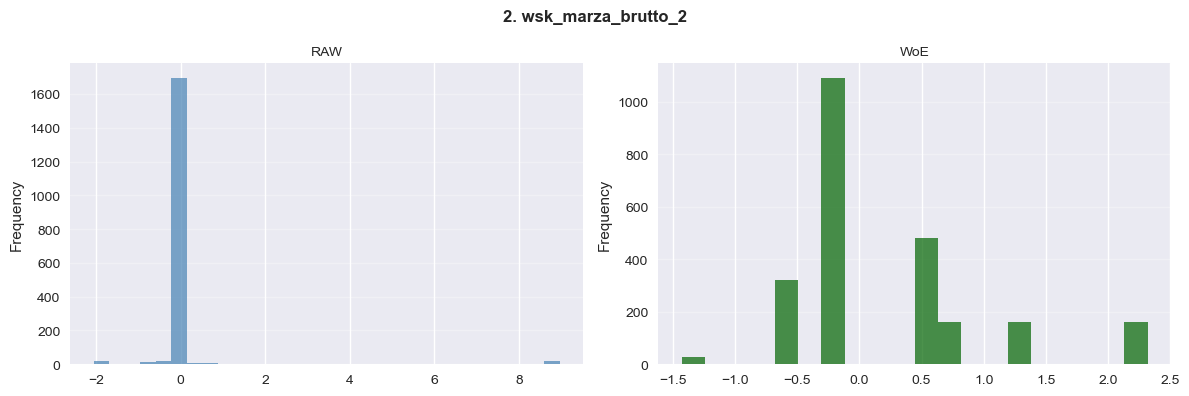


3. wsk_marza_ebitda_3


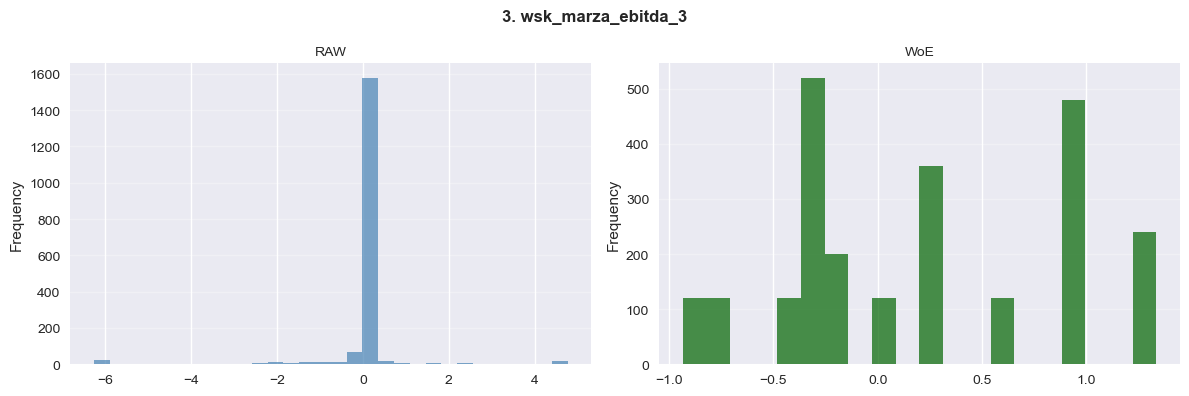



5️⃣  PODSUMOWANIE

📊 WYBRANYCH CECH: 15
   Very Strong/Strong (IV ≥ 0.3):  10
   Medium (0.1 ≤ IV < 0.3):        5
   Weak (0.02 ≤ IV < 0.1):         0

⚠️  WIELOKOLINEARNOŚĆ: 5 par o |r| > 0.7

✅ WoE transformation zakończona!


In [73]:
print("="*80)
print("📊 EDA - ANALIZA JAKOŚCI WoE (ADVANCED SCORECARD)")
print("="*80)

# Sprawdź czy WoE zostało obliczone
if 'X_train_woe_advanced_sc' not in globals() or X_train_woe_advanced_sc.shape[1] == 0:
    print("\n⚠️  Brak danych WoE - najpierw uruchom Advanced Scorecard!")
else:
    print(f"\n✅ Dane WoE dostępne: {X_train_woe_advanced_sc.shape[1]} cech")

# ============================================================================
# 1. IV RANKING - TOP 10 CECH
# ============================================================================
print("\n\n1️⃣  IV RANKING - TOP 10 CECH")
print("="*80)

# Zbuduj dataframe z IV z woe_mappings
if 'woe_mappings_advanced_sc' in globals() and woe_mappings_advanced_sc:
    
    iv_data = []
    for feat, info in woe_mappings_advanced_sc.items():
        woe_table = info['table']
        iv_total = woe_table['iv'].sum() if 'iv' in woe_table.columns else 0
        n_bins = info['bins']
        
        # Kategoryzacja
        if iv_total >= 0.5: power = "Very Strong"
        elif iv_total >= 0.3: power = "Strong"
        elif iv_total >= 0.1: power = "Medium"
        elif iv_total >= 0.02: power = "Weak"
        else: power = "Unpredictive"
        
        iv_data.append({
            'feature': feat,
            'IV': iv_total,
            'bins': n_bins,
            'Power': power
        })
    
    iv_df_adv = pd.DataFrame(iv_data).sort_values('IV', ascending=False)
    
    # Wizualizacja rozkładu mocy
    power_counts = iv_df_adv['Power'].value_counts()
    print(f"\n📊 Rozkład mocy predykcyjnej ({len(iv_df_adv)} cech):\n")
    
    power_order = ["Very Strong", "Strong", "Medium", "Weak", "Unpredictive"]
    for power in power_order:
        count = power_counts.get(power, 0)
        if count > 0:
            bar = "█" * int(count / 2)
            print(f"   {power:15} ({count:2}): {bar}")
    
    # Top 10
    print(f"\n📈 TOP 10 CECH:")
    print(f"\n   {'Rank':<6} {'Feature':<45} {'IV':<10} {'Bins':<6} {'Power'}")
    print("   " + "-"*80)
    
    for i, row in iv_df_adv.head(10).iterrows():
        print(f"   {i+1:<6} {row['feature']:<45} {row['IV']:<10.4f} {row['bins']:<6} {row['Power']}")
else:
    print("\n⚠️  Brak woe_mappings_advanced_sc")

# ============================================================================
# 2. WoE TABLES - TOP 5 FEATURES
# ============================================================================
print("\n\n2️⃣  WoE TABLES - TOP 5 FEATURES")
print("="*80)

top5_adv = iv_df_adv.head(5)['feature'].tolist()

for i, feat in enumerate(top5_adv, 1):
    if feat not in woe_mappings_advanced_sc:
        print(f"\n⚠️  {feat}: Brak danych")
        continue
    
    woe_table = woe_mappings_advanced_sc[feat]['table']
    n_bins = woe_mappings_advanced_sc[feat]['bins']
    iv_total = woe_table['iv'].sum() if 'iv' in woe_table.columns else 0
    
    print(f"\n{i}. {feat}")
    print(f"   IV: {iv_total:.4f}, Bins: {n_bins}")
    print(f"\n   {'Bin':<15} {'Count':>8} {'Bad%':>8} {'WoE':>10} {'IV':>10}")
    print("   " + "-"*55)
    
    for _, row in woe_table.iterrows():
        bin_label = str(row.get('bin', row.get('range', 'N/A')))[:15]
        count = row.get('count', row.get('total', 0))
        bad_rate = row.get('bad_rate', row.get('event_rate', 0)) * 100
        woe = row.get('woe', 0)
        iv = row.get('iv', 0)
        print(f"   {bin_label:<15} {count:>8.0f} {bad_rate:>7.1f}% {woe:>10.3f} {iv:>10.4f}")

# ============================================================================
# 3. MACIERZ KORELACJI
# ============================================================================
print("\n\n3️⃣  MACIERZ KORELACJI")
print("="*80)

corr_woe_adv = X_train_woe_advanced_sc.corr()

# Znajdź wysokie korelacje
high_corr_adv = []
for i in range(len(corr_woe_adv.columns)):
    for j in range(i+1, len(corr_woe_adv.columns)):
        corr_val = corr_woe_adv.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_adv.append((corr_woe_adv.columns[i], corr_woe_adv.columns[j], corr_val))

if len(high_corr_adv) > 0:
    print(f"\n⚠️  Wysokie korelacje (|r| > 0.7): {len(high_corr_adv)}")
    for feat1, feat2, corr_val in sorted(high_corr_adv, key=lambda x: abs(x[2]), reverse=True)[:5]:
        f1 = feat1.replace('_woe', '')
        f2 = feat2.replace('_woe', '')
        print(f"   {f1} ↔ {f2}: {corr_val:+.3f}")
else:
    print(f"\n✅ Brak wysokich korelacji (|r| > 0.7)")

# Heatmap (jeśli nie za dużo cech)
if X_train_woe_advanced_sc.shape[1] <= 25:
    print(f"\n📊 Heatmap macierzy korelacji:")
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_woe_adv, 
                annot=False,
                cmap='coolwarm', 
                center=0,
                vmin=-1, 
                vmax=1,
                square=True,
                cbar_kws={"label": "Correlation"})
    plt.title('Macierz Korelacji - WoE Features (Advanced Scorecard)', fontsize=14, pad=20)
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print(f"   (Pominięto heatmap - zbyt dużo cech)")

# ============================================================================
# 4. ROZKŁADY - TOP 3 CECH
# ============================================================================
print("\n\n4️⃣  ROZKŁADY - TOP 3 CECH (RAW vs WoE)")
print("="*80)

for i, feat in enumerate(iv_df_adv.head(3)['feature'].tolist(), 1):
    if feat not in X_train_advanced_raw.columns or f"{feat}_woe" not in X_train_woe_advanced_sc.columns:
        continue
    
    print(f"\n{i}. {feat}")
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{i}. {feat}', fontsize=12, fontweight='bold')
    
    # RAW
    axes[0].hist(X_train_advanced_raw[feat].dropna(), bins=30, alpha=0.7, color='steelblue')
    axes[0].set_title('RAW', fontsize=10)
    axes[0].set_ylabel('Frequency')
    axes[0].grid(axis='y', alpha=0.3)
    
    # WoE
    axes[1].hist(X_train_woe_advanced_sc[f"{feat}_woe"].dropna(), bins=20, alpha=0.7, color='darkgreen')
    axes[1].set_title('WoE', fontsize=10)
    axes[1].set_ylabel('Frequency')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ============================================================================
# 5. PODSUMOWANIE
# ============================================================================
print("\n\n5️⃣  PODSUMOWANIE")
print("="*80)

n_features = X_train_woe_advanced_sc.shape[1]
excellent = (iv_df_adv['IV'] >= 0.3).sum()
medium = ((iv_df_adv['IV'] >= 0.1) & (iv_df_adv['IV'] < 0.3)).sum()
weak = ((iv_df_adv['IV'] >= 0.02) & (iv_df_adv['IV'] < 0.1)).sum()

print(f"\n📊 WYBRANYCH CECH: {n_features}")
print(f"   Very Strong/Strong (IV ≥ 0.3):  {excellent}")
print(f"   Medium (0.1 ≤ IV < 0.3):        {medium}")
print(f"   Weak (0.02 ≤ IV < 0.1):         {weak}")

# Korelacje
if len(high_corr_adv) == 0:
    print(f"\n✅ WIELOKOLINEARNOŚĆ: OK")
else:
    print(f"\n⚠️  WIELOKOLINEARNOŚĆ: {len(high_corr_adv)} par o |r| > 0.7")

print("\n✅ WoE transformation zakończona!")
print("="*80)

---

### 12.3 Porównanie Scorecardów

Porównanie Basic vs Advanced Scorecard

In [78]:
print("="*80)
print("📊 PORÓWNANIE SCORECARDÓW")
print("="*80)

# ⚠️ UWAGA: Porównanie 1:1 tych scorecardów nie jest w pełni miarodajne!
# Basic Scorecard: W pełni interpretowalny (surowe cechy + WoE)
# Advanced Scorecard: Zawiera feature engineering - NIE jest w pełni interpretowalny
# Dla interpretowalnego ML preferujemy Basic Scorecard!

# Przygotuj dane do porównania
if 'metrics_sc_basic' in globals() and 'metrics_sc_adv' in globals():
    
    # POPRAWKA: X_train_val_woe_basic zamiast X_train_woe_basic
    n_feat_basic = X_train_val_woe_basic.shape[1] if 'X_train_val_woe_basic' in globals() else 0
    n_feat_adv = X_train_woe_advanced_sc.shape[1] if 'X_train_woe_advanced_sc' in globals() else 0
    
    comparison_sc = pd.DataFrame({
        'Metryka': ['Cechy', 'ROC-AUC', 'PR-AUC', 'KS', 'Log Loss', 'Brier'],
        'Basic Scorecard': [
            n_feat_basic,
            metrics_sc_basic.get('roc_auc', 0),
            metrics_sc_basic.get('pr_auc', 0),
            metrics_sc_basic.get('ks', 0),
            metrics_sc_basic.get('log_loss', 0),
            metrics_sc_basic.get('brier', 0)
        ],
        'Advanced Scorecard': [
            n_feat_adv,
            metrics_sc_adv.get('roc_auc', 0),
            metrics_sc_adv.get('pr_auc', 0),
            metrics_sc_adv.get('ks', 0),
            metrics_sc_adv.get('log_loss', 0),
            metrics_sc_adv.get('brier', 0)
        ]
    })
    
    # Dodaj kolumnę z różnicą
    comparison_sc['Δ (Adv - Basic)'] = comparison_sc['Advanced Scorecard'] - comparison_sc['Basic Scorecard']
    
    # Formatuj output
    print("\n")
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(comparison_sc.to_string(index=False))
    pd.reset_option('display.float_format')
    
    # Interpretacja
    print("\n" + "="*80)
    print("💡 INTERPRETACJA:")
    print("="*80)
    
    print("\n⚠️  WAŻNE - RÓŻNICE W INTERPRETOWALNOŚCI:")
    print("   • Basic Scorecard:    ✅ W PEŁNI INTERPRETOWALNY")
    print("     - Używa surowych, oryginalnych cech")
    print("     - Każda zmienna ma jasne znaczenie biznesowe")
    print("     - Spełnia wymogi regulacyjne (Basel, IFRS9)")
    print("   • Advanced Scorecard: ⚠️  CZĘŚCIOWO INTERPRETOWALNY")
    print("     - Zawiera feature engineering (kombinacje cech)")
    print("     - Trudniejsza interpretacja dla regulatorów")
    print("     - Może mieć lepsze metryki, ale kosztem przejrzystości")
    
    diff_auc = metrics_sc_adv['roc_auc'] - metrics_sc_basic['roc_auc']
    diff_ks = metrics_sc_adv['ks'] - metrics_sc_basic['ks']
    
    print(f"\n📊 RÓŻNICE METRYCZNE:")
    print(f"   Różnica ROC-AUC: {diff_auc:+.4f}")
    print(f"   Różnica KS: {diff_ks:+.4f}")
    
    print(f"\n📊 STRUKTURA DANYCH:")
    print(f"   • Basic Scorecard:    Full Pipeline (165 cech) → WoE → {n_feat_basic} cech")
    print(f"   • Advanced Scorecard: Feature Engineering (30 cech) → WoE → {n_feat_adv} cech")
    
    print("\n" + "="*80)
    print("🏆 REKOMENDACJA: BASIC SCORECARD")
    print("="*80)
    print("\n   Dla interpretowalnego ML w finansach (credit scoring) wybieramy")
    print("   Basic Scorecard, ponieważ:")
    print("   1. Pełna interpretowalność każdej zmiennej")
    print("   2. Zgodność z wymogami regulacyjnymi")
    print("   3. Łatwość wyjaśnienia decyzji klientom")
    print("   4. Stabilność i przewidywalność modelu")
    print("\n   Nawet jeśli Advanced ma lepsze metryki - interpretowalność > accuracy!")

else:
    print("\n" + "="*80)
    print("\n⚠️  Brak danych do porównania - uruchom oba scorecards")

📊 PORÓWNANIE SCORECARDÓW


 Metryka  Basic Scorecard  Advanced Scorecard  Δ (Adv - Basic)
   Cechy          22.0000             15.0000          -7.0000
 ROC-AUC           0.9417              0.8875          -0.0541
  PR-AUC           0.5041              0.2873          -0.2168
      KS           0.7957              0.7140          -0.0817
Log Loss           0.3279              0.3775           0.0496
   Brier           0.1183              0.1375           0.0192

💡 INTERPRETACJA:

⚠️  WAŻNE - RÓŻNICE W INTERPRETOWALNOŚCI:
   • Basic Scorecard:    ✅ W PEŁNI INTERPRETOWALNY
     - Używa surowych, oryginalnych cech
     - Każda zmienna ma jasne znaczenie biznesowe
     - Spełnia wymogi regulacyjne (Basel, IFRS9)
   • Advanced Scorecard: ⚠️  CZĘŚCIOWO INTERPRETOWALNY
     - Zawiera feature engineering (kombinacje cech)
     - Trudniejsza interpretacja dla regulatorów
     - Może mieć lepsze metryki, ale kosztem przejrzystości

📊 RÓŻNICE METRYCZNE:
   Różnica ROC-AUC: -0.0541
   Różnica KS

---

### 12.4 Porównanie Wszystkich Modeli

Finalne zestawienie wszystkich podejść

In [77]:
print("="*80)
print("📊 FINALNE PORÓWNANIE - WSZYSTKIE MODELE")
print("="*80)

# WAŻNE: Usuń scorecard z results_advanced_raw jeśli istnieje (to był błąd)
if 'results_advanced_raw' in globals() and 'Scorecard' in results_advanced_raw:
    print("\n⚠️  Wykryto duplikat scorecard w results_advanced_raw - usuwam...")
    del results_advanced_raw['Scorecard']
    print("   ✅ Usunięto")

# Zbierz wyniki
comparison_all = []

# 1. Full Pipeline (wszystkie modele - BEZ Scorecard!)
if 'results_full' in globals():
    for model_name, metrics in results_full.items():
        # Pomiń scorecard jeśli przypadkowo został dodany do results_full
        if 'scorecard' in model_name.lower() or 'woe' in model_name.lower():
            continue
        
        comparison_all.append({
            'Pipeline': 'Full',
            'Model': model_name,
            'Cechy': 165,
            'ROC-AUC': metrics.get('roc_auc', metrics.get('auc', 0)),
            'PR-AUC': metrics.get('pr_auc', 0),
            'KS': metrics.get('ks', 0),
            'Log Loss': metrics.get('log_loss', 0),
            'Brier': metrics.get('brier', 0)
        })

# 2. Advanced Pipeline
if 'results_advanced_raw' in globals():
    for model_name, metrics in results_advanced_raw.items():
        comparison_all.append({
            'Pipeline': 'Advanced',
            'Model': model_name,
            'Cechy': 30,
            'ROC-AUC': metrics.get('roc_auc', metrics.get('auc', 0)),
            'PR-AUC': metrics.get('pr_auc', 0),
            'KS': metrics.get('ks', 0),
            'Log Loss': metrics.get('log_loss', 0),
            'Brier': metrics.get('brier', 0)
        })

# 3. Optimized Scorecards - POPRAWIONE nazwy zmiennych!
if 'metrics_sc_basic' in globals():
    # POPRAWKA: X_train_val_woe_basic zamiast X_train_woe_basic
    n_feat_basic = X_train_val_woe_basic.shape[1] if 'X_train_val_woe_basic' in globals() else 0
    comparison_all.append({
        'Pipeline': 'Basic Scorecard',
        'Model': 'LR+WoE (Optimized)',
        'Cechy': n_feat_basic,
        'ROC-AUC': metrics_sc_basic.get('roc_auc', 0),
        'PR-AUC': metrics_sc_basic.get('pr_auc', 0),
        'KS': metrics_sc_basic.get('ks', 0),
        'Log Loss': metrics_sc_basic.get('log_loss', 0),
        'Brier': metrics_sc_basic.get('brier', 0)
    })

if 'metrics_sc_adv' in globals():
    # POPRAWKA: X_train_woe_advanced_sc to poprawna nazwa
    n_feat_adv = X_train_woe_advanced_sc.shape[1] if 'X_train_woe_advanced_sc' in globals() else 0
    comparison_all.append({
        'Pipeline': 'Advanced Scorecard',
        'Model': 'LR+WoE (Optimized)',
        'Cechy': n_feat_adv,
        'ROC-AUC': metrics_sc_adv.get('roc_auc', 0),
        'PR-AUC': metrics_sc_adv.get('pr_auc', 0),
        'KS': metrics_sc_adv.get('ks', 0),
        'Log Loss': metrics_sc_adv.get('log_loss', 0),
        'Brier': metrics_sc_adv.get('brier', 0)
    })

# Sprawdź czy mamy dane
if len(comparison_all) == 0:
    print("\n❌ BŁĄD: Brak danych do porównania!")
    print("   Uruchom najpierw komórki z modelami.")
else:
    # Utwórz DataFrame i sortuj
    df_comparison = pd.DataFrame(comparison_all)
    df_comparison = df_comparison.sort_values(['ROC-AUC', 'KS'], ascending=[False, False])
    
    # Wyświetl
    print("\n")
    pd.set_option('display.max_rows', None)
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(df_comparison.to_string(index=False))
    pd.reset_option('display.max_rows')
    pd.reset_option('display.float_format')
    
    # Analiza
    print("\n" + "="*80)
    print("💡 ANALIZA WYNIKÓW")
    print("="*80)
    
    best_model = df_comparison.iloc[0]
    print(f"\n🏆 NAJLEPSZY MODEL:")
    print(f"   {best_model['Pipeline']} - {best_model['Model']}")
    print(f"   ROC-AUC: {best_model['ROC-AUC']:.4f}")
    print(f"   KS:      {best_model['KS']:.4f}")
    print(f"   Cechy:   {int(best_model['Cechy'])}")
    
    print(f"\n📊 KLUCZOWE METRYKI (dla credit scoring):")
    print(f"   • ROC-AUC:  Ogólna skuteczność (wyższe = lepsze)")
    print(f"   • PR-AUC:   Skuteczność na niezbalansowanych (wyższe = lepsze)")
    print(f"   • KS:       Separacja klas (wyższe = lepsze, >0.3 = dobre)")
    print(f"   • Log Loss: Jakość prawdopodobieństw (niższe = lepsze)")
    print(f"   • Brier:    Dokładność predykcji (niższe = lepsze)")
    
    # Top 3
    n_top = min(3, len(df_comparison))
    print(f"\n🥇 TOP {n_top} MODELE:")
    for i, (idx, row) in enumerate(df_comparison.head(n_top).iterrows(), 1):
        print(f"   {i}. {row['Pipeline']:<25} {row['Model']:<25} AUC={row['ROC-AUC']:.4f}, KS={row['KS']:.4f}")
    
    # ============================================================================
    # TRADE-OFF: INTERPRETOWALNOŚĆ vs PERFORMANCE
    # ============================================================================
    print("\n" + "="*80)
    print("⚖️  INTERPRETOWALNOŚĆ vs PERFORMANCE")
    print("="*80)
    
    # Znajdź najlepszy scorecard i model black-box
    scorecards = df_comparison[df_comparison['Pipeline'].str.contains('Scorecard', na=False)]
    other_models = df_comparison[~df_comparison['Pipeline'].str.contains('Scorecard', na=False)]
    
    if not scorecards.empty and not other_models.empty:
        best_scorecard_row = scorecards.iloc[0]
        best_other = other_models.iloc[0]
        
        print(f"\n📊 NAJLEPSZY SCORECARD (Interpretowalny):")
        print(f"   {best_scorecard_row['Pipeline']}: {best_scorecard_row['Model']}")
        print(f"   ROC-AUC: {best_scorecard_row['ROC-AUC']:.4f} | KS: {best_scorecard_row['KS']:.4f} | Cechy: {int(best_scorecard_row['Cechy'])}")
        
        print(f"\n🔧 NAJLEPSZY INNY MODEL:")
        print(f"   {best_other['Pipeline']}: {best_other['Model']}")
        print(f"   ROC-AUC: {best_other['ROC-AUC']:.4f} | KS: {best_other['KS']:.4f} | Cechy: {int(best_other['Cechy'])}")
        
        auc_diff = best_other['ROC-AUC'] - best_scorecard_row['ROC-AUC']
        
        print(f"\n💡 RÓŻNICA:")
        print(f"   Δ ROC-AUC: {auc_diff:+.4f} ({abs(auc_diff/best_scorecard_row['ROC-AUC']*100):.2f}%)")
        
        if abs(auc_diff) < 0.01:
            print(f"\n✅ Scorecard prawie równie dobry - preferuj INTERPRETOWALNOŚĆ!")
        elif abs(auc_diff) < 0.03:
            print(f"\n⚖️  Trade-off: niewielka różnica w performance")
        else:
            print(f"\n⚠️  Większa różnica - rozważ zastosowanie obu modeli")
    elif not scorecards.empty:
        print("\n📊 Dostępne tylko Scorecards")
    elif not other_models.empty:
        print("\n📊 Dostępne tylko inne modele - brak Scorecards")

print("\n" + "="*80)

📊 FINALNE PORÓWNANIE - WSZYSTKIE MODELE


          Pipeline              Model  Cechy  ROC-AUC  PR-AUC     KS  Log Loss  Brier
   Basic Scorecard LR+WoE (Optimized)     22   0.9417  0.5041 0.7957    0.3279 0.1183
Advanced Scorecard LR+WoE (Optimized)     15   0.8875  0.2873 0.7140    0.3775 0.1375
          Advanced                 RF     30   0.7804  0.1587 0.5142    0.2395 0.0687
              Full                 LR    165   0.7501  0.1492 0.4391    0.5973 0.1751
          Advanced                XGB     30   0.7365  0.1308 0.4676    0.2770 0.0840
          Advanced                 LR     30   0.7312  0.1488 0.4118    0.5995 0.2046
              Full                 DT    165   0.6692  0.1175 0.3036    0.8436 0.2119
          Advanced                 DT     30   0.6278  0.1072 0.2406    2.4551 0.1613
          Advanced                 NB     30   0.5941  0.1114 0.2566    7.6552 0.6683
              Full                 NB    165   0.5540  0.0689 0.1090   26.2327 0.7333

💡 ANALIZA W

---

# 13. Interpretacja Modelu Interpretowalnego 🔍

## 13.1 Interpretacja Globalna - Analiza Współczynników i Ważności Cech


Szczegółowa analiza najlepszego modelu interpretowalnego (scorecard) wybranego na podstawie metryk walidacyjnych.

🔍 INTERPRETACJA GLOBALNA - BASIC SCORECARD (W PEŁNI INTERPRETOWALNY)

Analiza wpływu cech na predykcję probability of default (PD)
Zgodnie z wymaganiem 3.3: współczynniki, ważność cech, PDP/ICE
⚠️  WSZYSTKIE WYKRESY NA ZBIORZE TESTOWYM (niewidziane dane!)

🎯 WYBRANY MODEL: Basic Scorecard (W pełni interpretowalny)
--------------------------------------------------------------------------------
   Liczba cech:     22
   ROC-AUC (test):  0.9417
   Obs TEST:        600 (używane do PDP/ICE)

   ✅ Basic Scorecard - pełna zgodność z wymogami regulacyjnymi!
   ✅ Interpretacja na NIEWIDZIANYCH danych (TEST set)

1️⃣ WSPÓŁCZYNNIKI REGRESJI LOGISTYCZNEJ (LOG-ODDS)

Interpretacja: coefficient = zmiana log-odds przy wzroście cechy o 1 jednostkę
• Positive → wzrost cechy ZMNIEJSZA PD (protective factor)
• Negative → wzrost cechy ZWIĘKSZA PD (risk driver)

📊 TOP 10 CECH (według |coefficient|):

    1. wsk_ebitda_koszty_odsetkowe_3_woe             | Coef:  0.8422 | 📈 PROTECTIVE    | 🔥 Bardzo silny
  

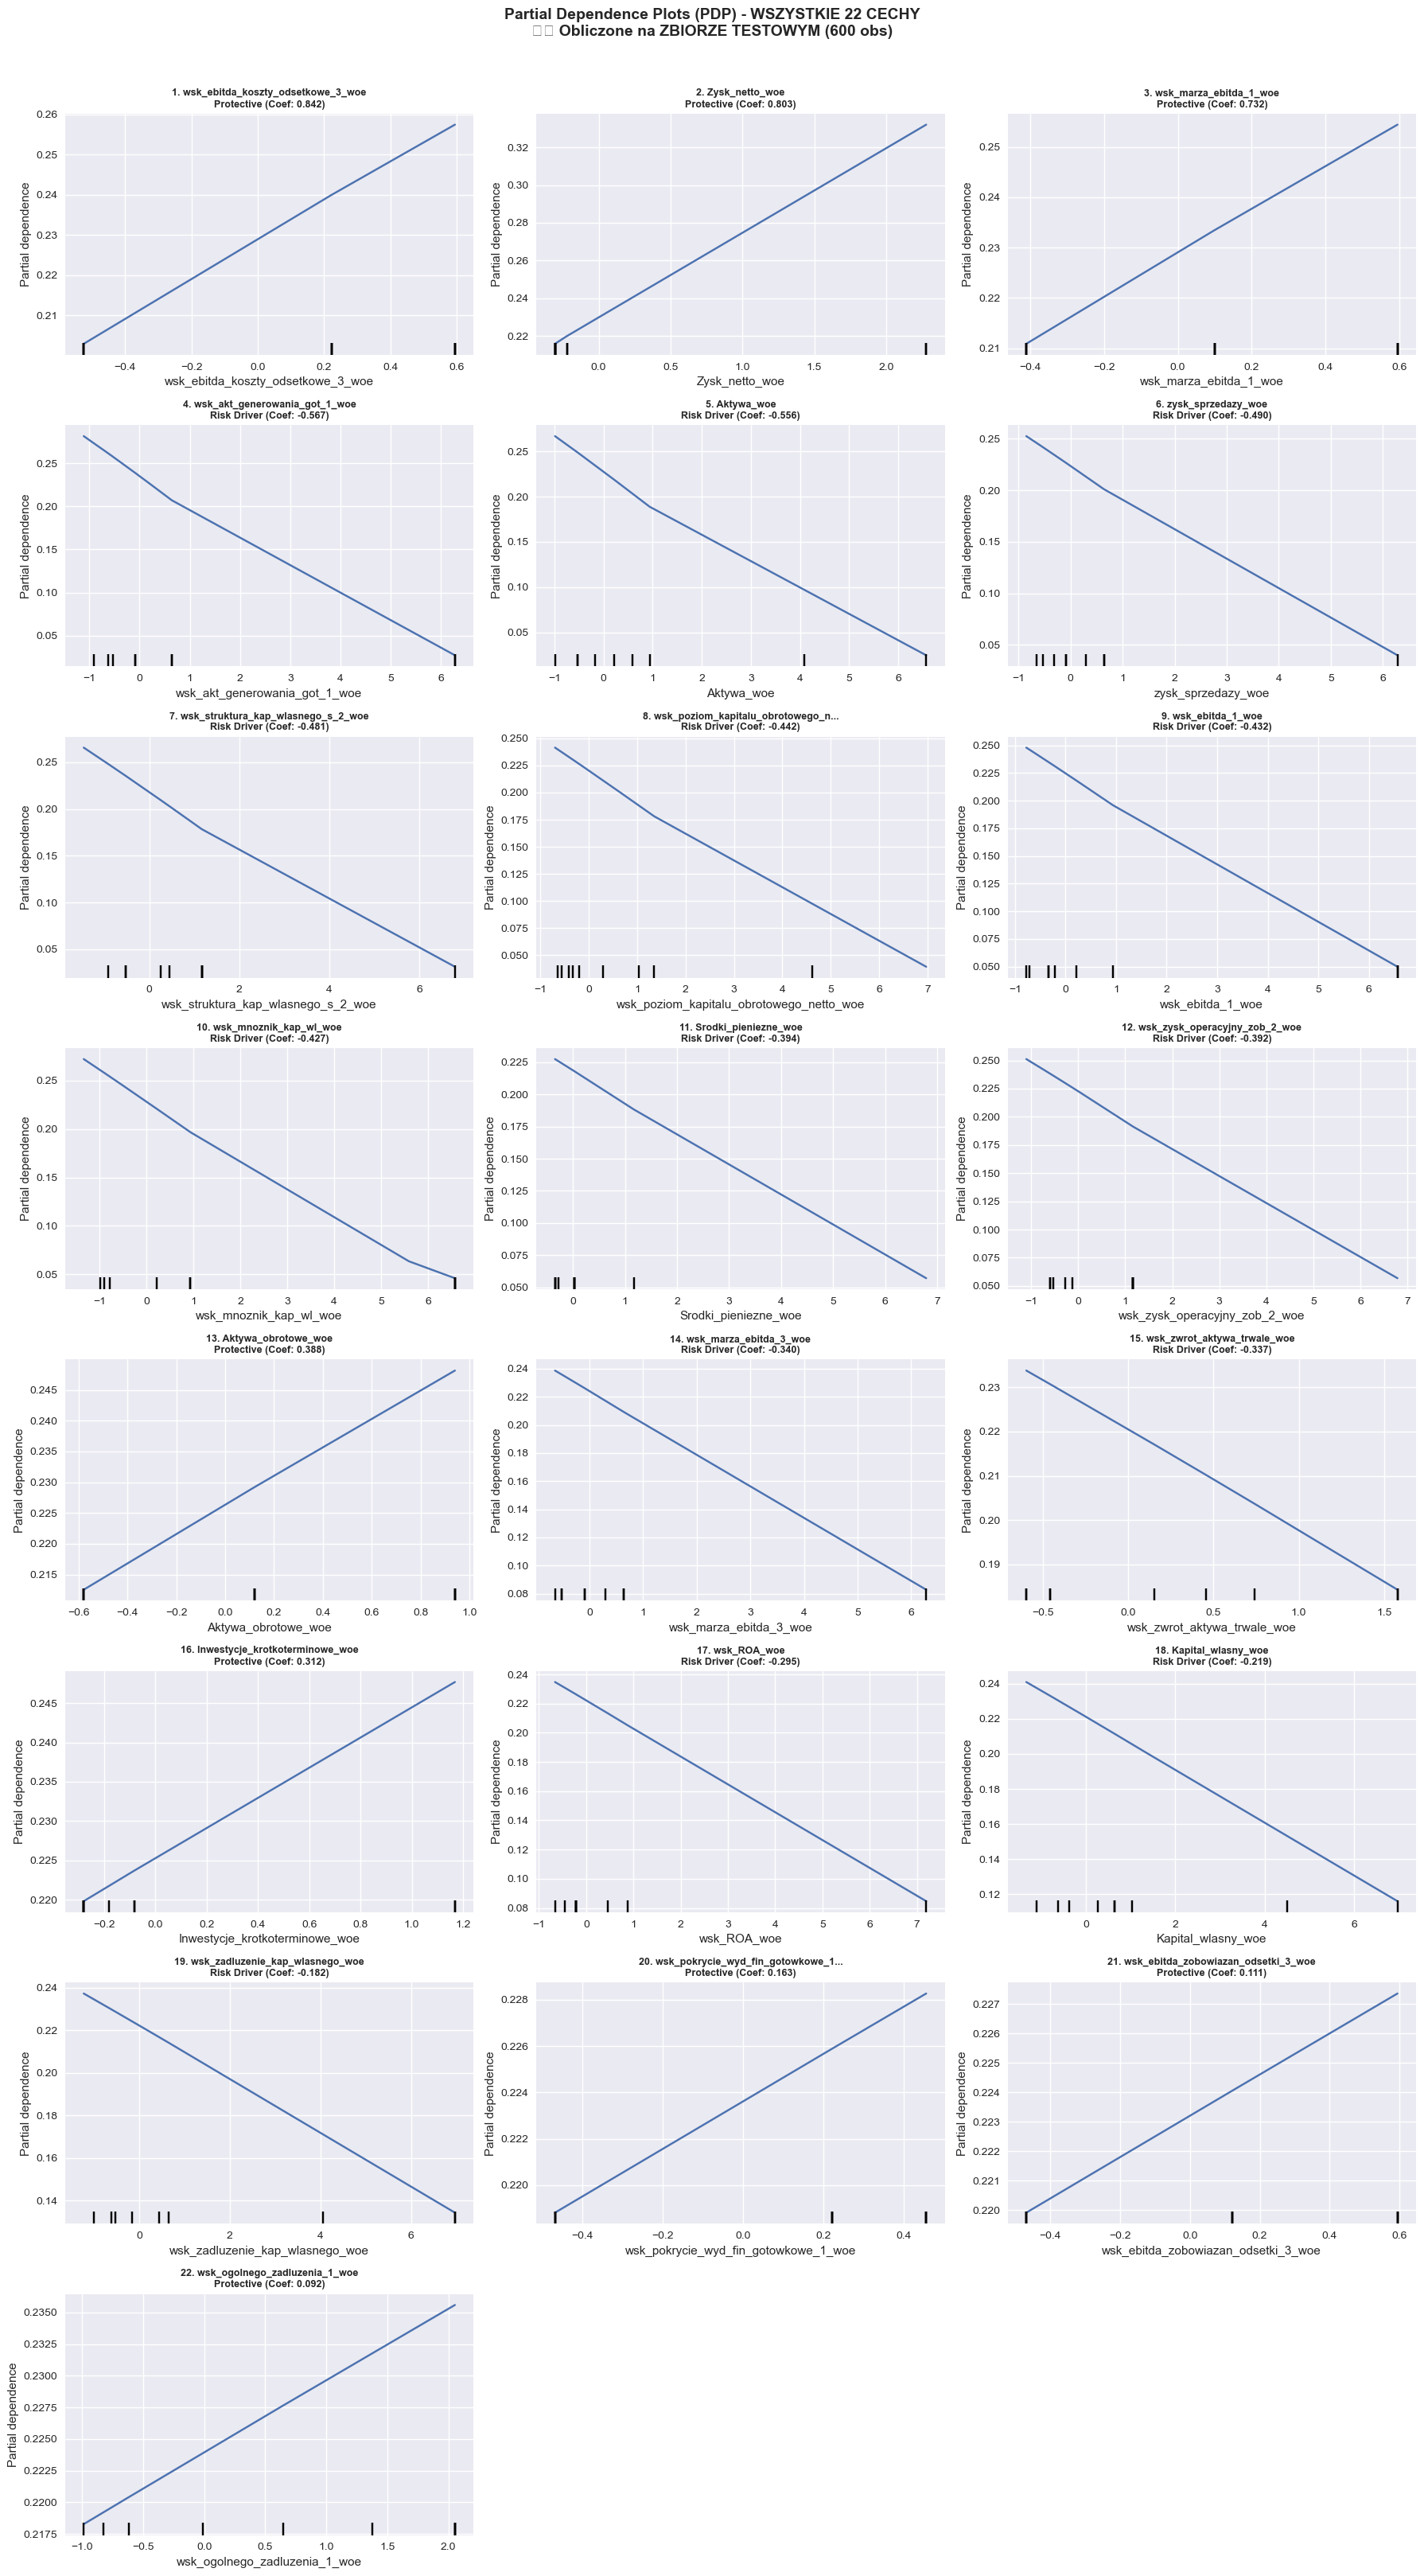


💡 Interpretacja PDP:
   - Oś X: wartość WoE cechy
   - Oś Y: zmiana log-odds (predykcja)
   - Nachylenie = siła i kierunek efektu
   → PDP pokazuje GLOBALNY efekt na NIEWIDZIANYCH danych

3️⃣ ICE CURVES (Individual Conditional Expectation) - ZBIÓR TESTOWY
--------------------------------------------------------------------------------
ICE pokazuje jak zmiana cechy wpływa na KAŻDĄ INDYWIDUALNĄ obserwację
Używam 100 losowych obserwacji z TEST set


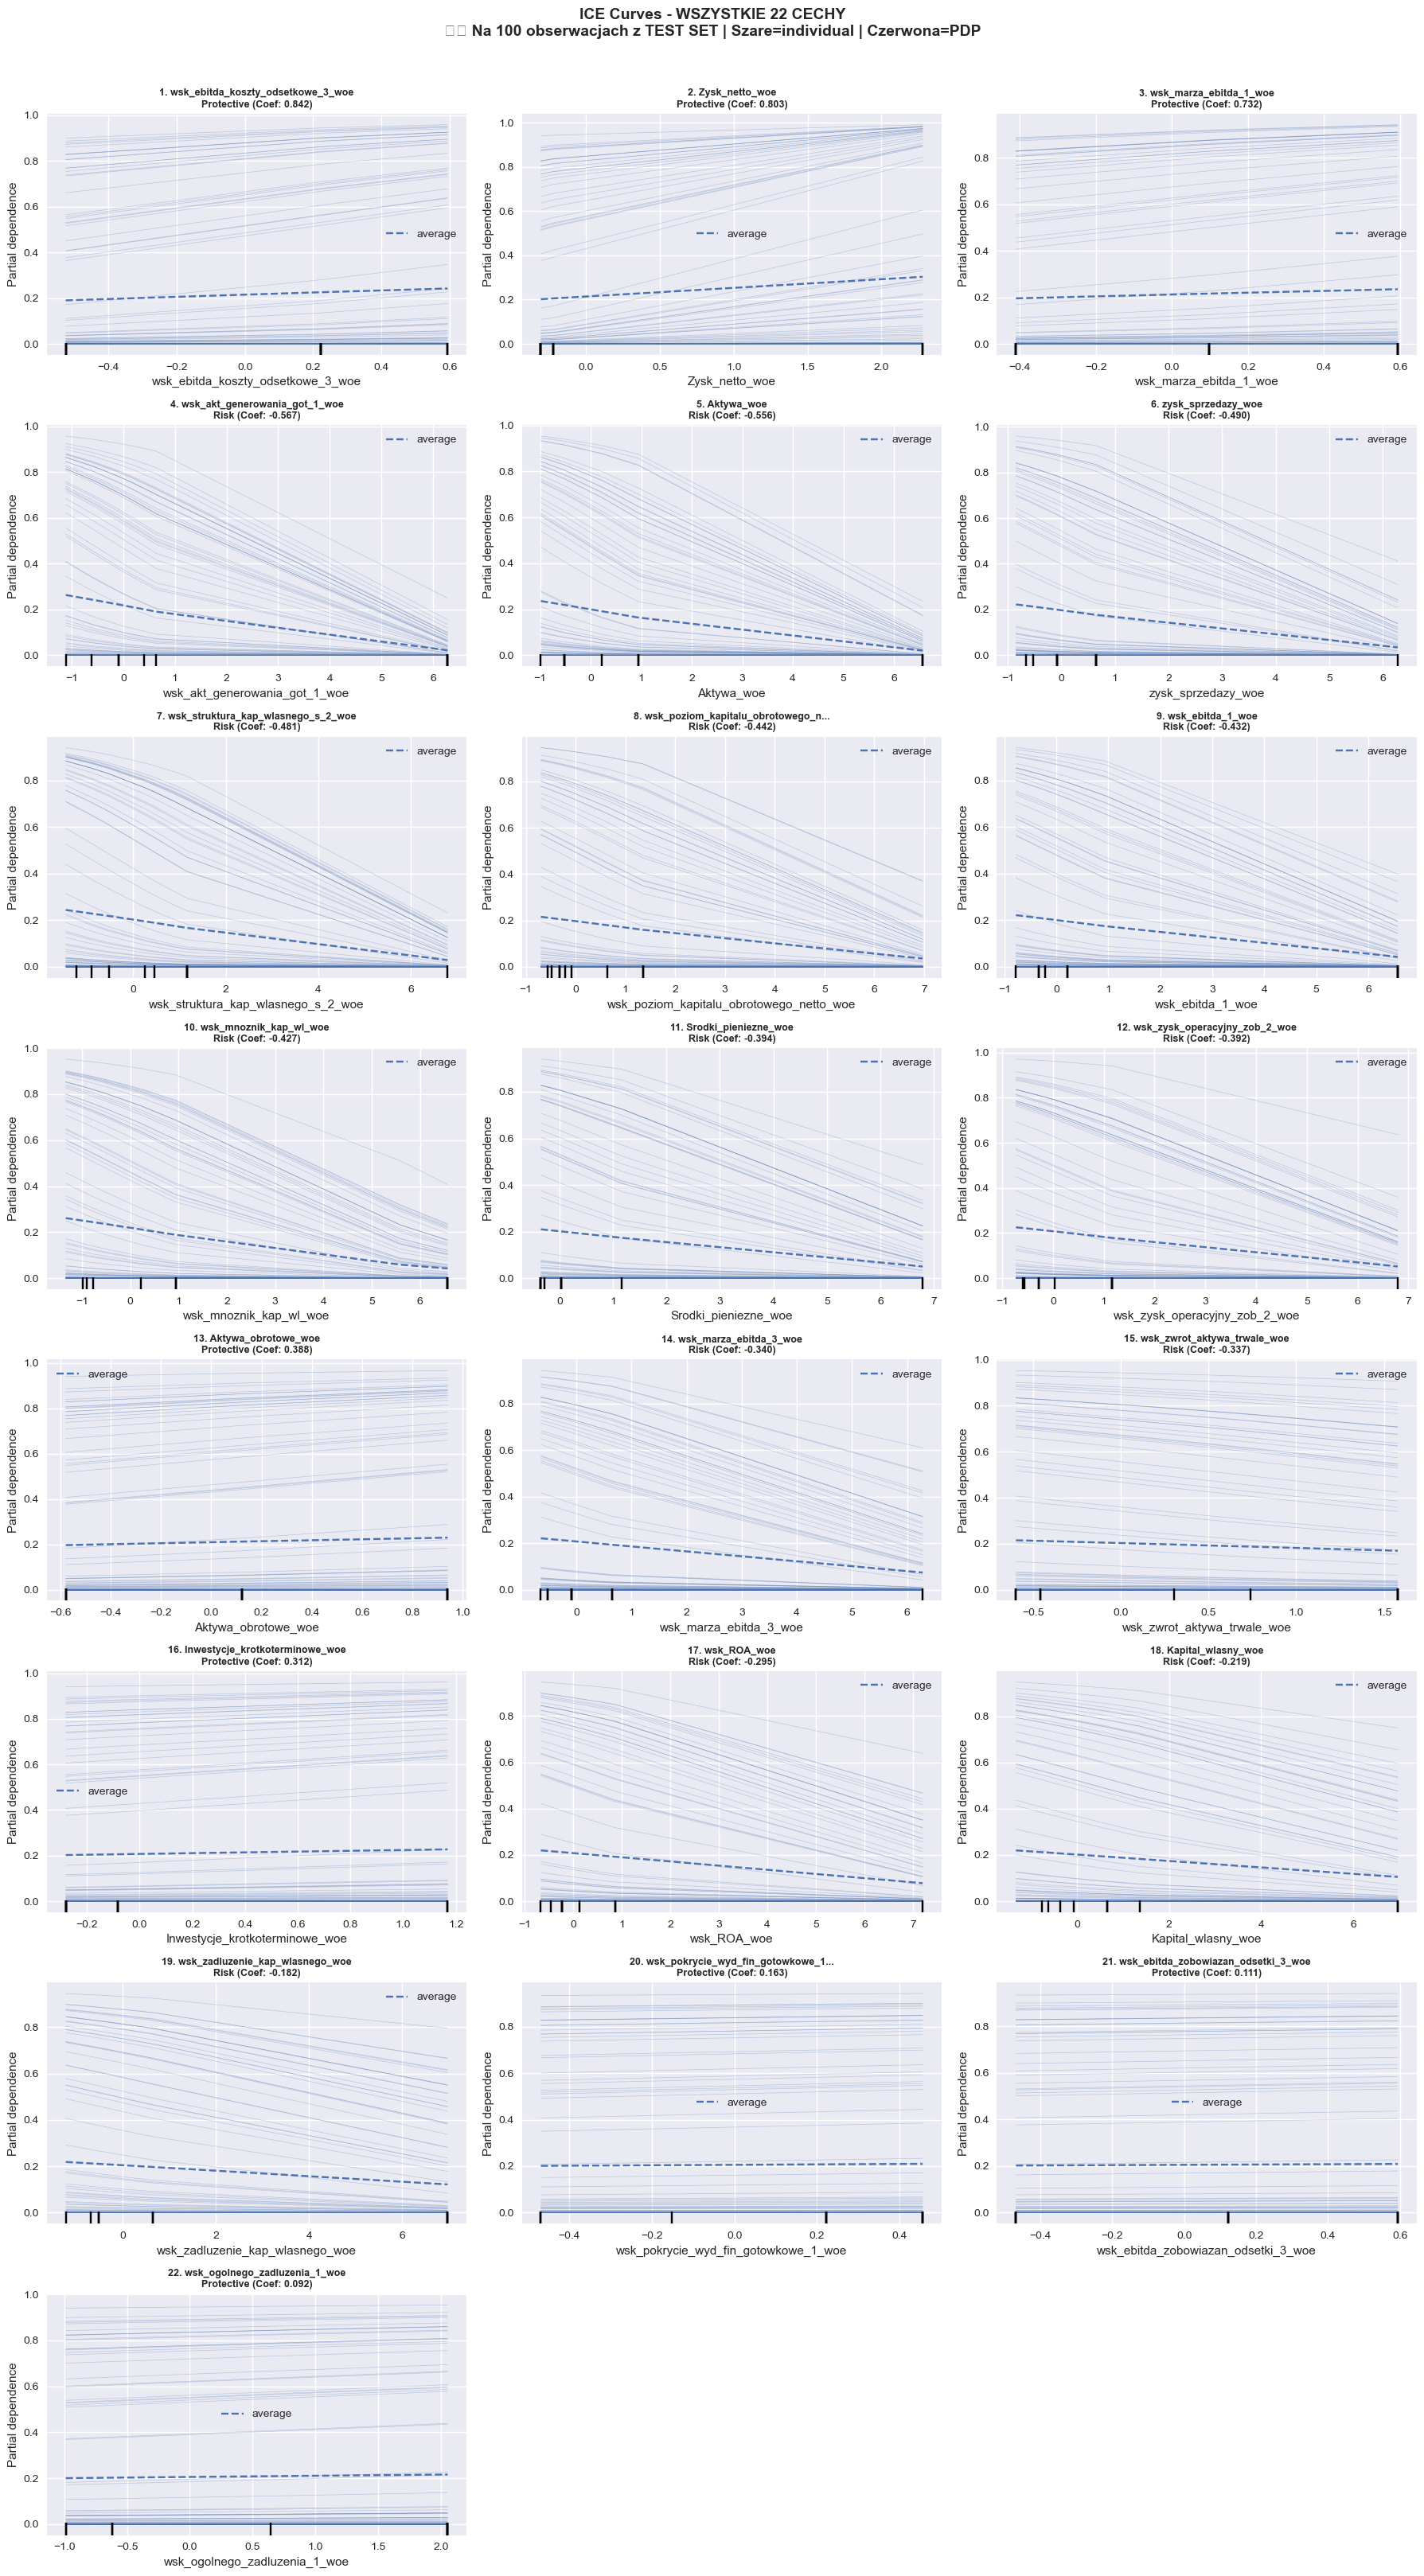


💡 Interpretacja ICE:
   - Każda szara linia = jedna obserwacja z TEST set
   - Czerwona linia = PDP (średnia ICE)
   - Równoległe linie → efekt homogeniczny
   - Rozjechane linie → efekt heterogeniczny

4️⃣ CENTERED ICE (C-ICE) - ZBIÓR TESTOWY - Heterogeniczność Efektu
--------------------------------------------------------------------------------
C-ICE = ICE wycentrowane w punkcie odniesienia


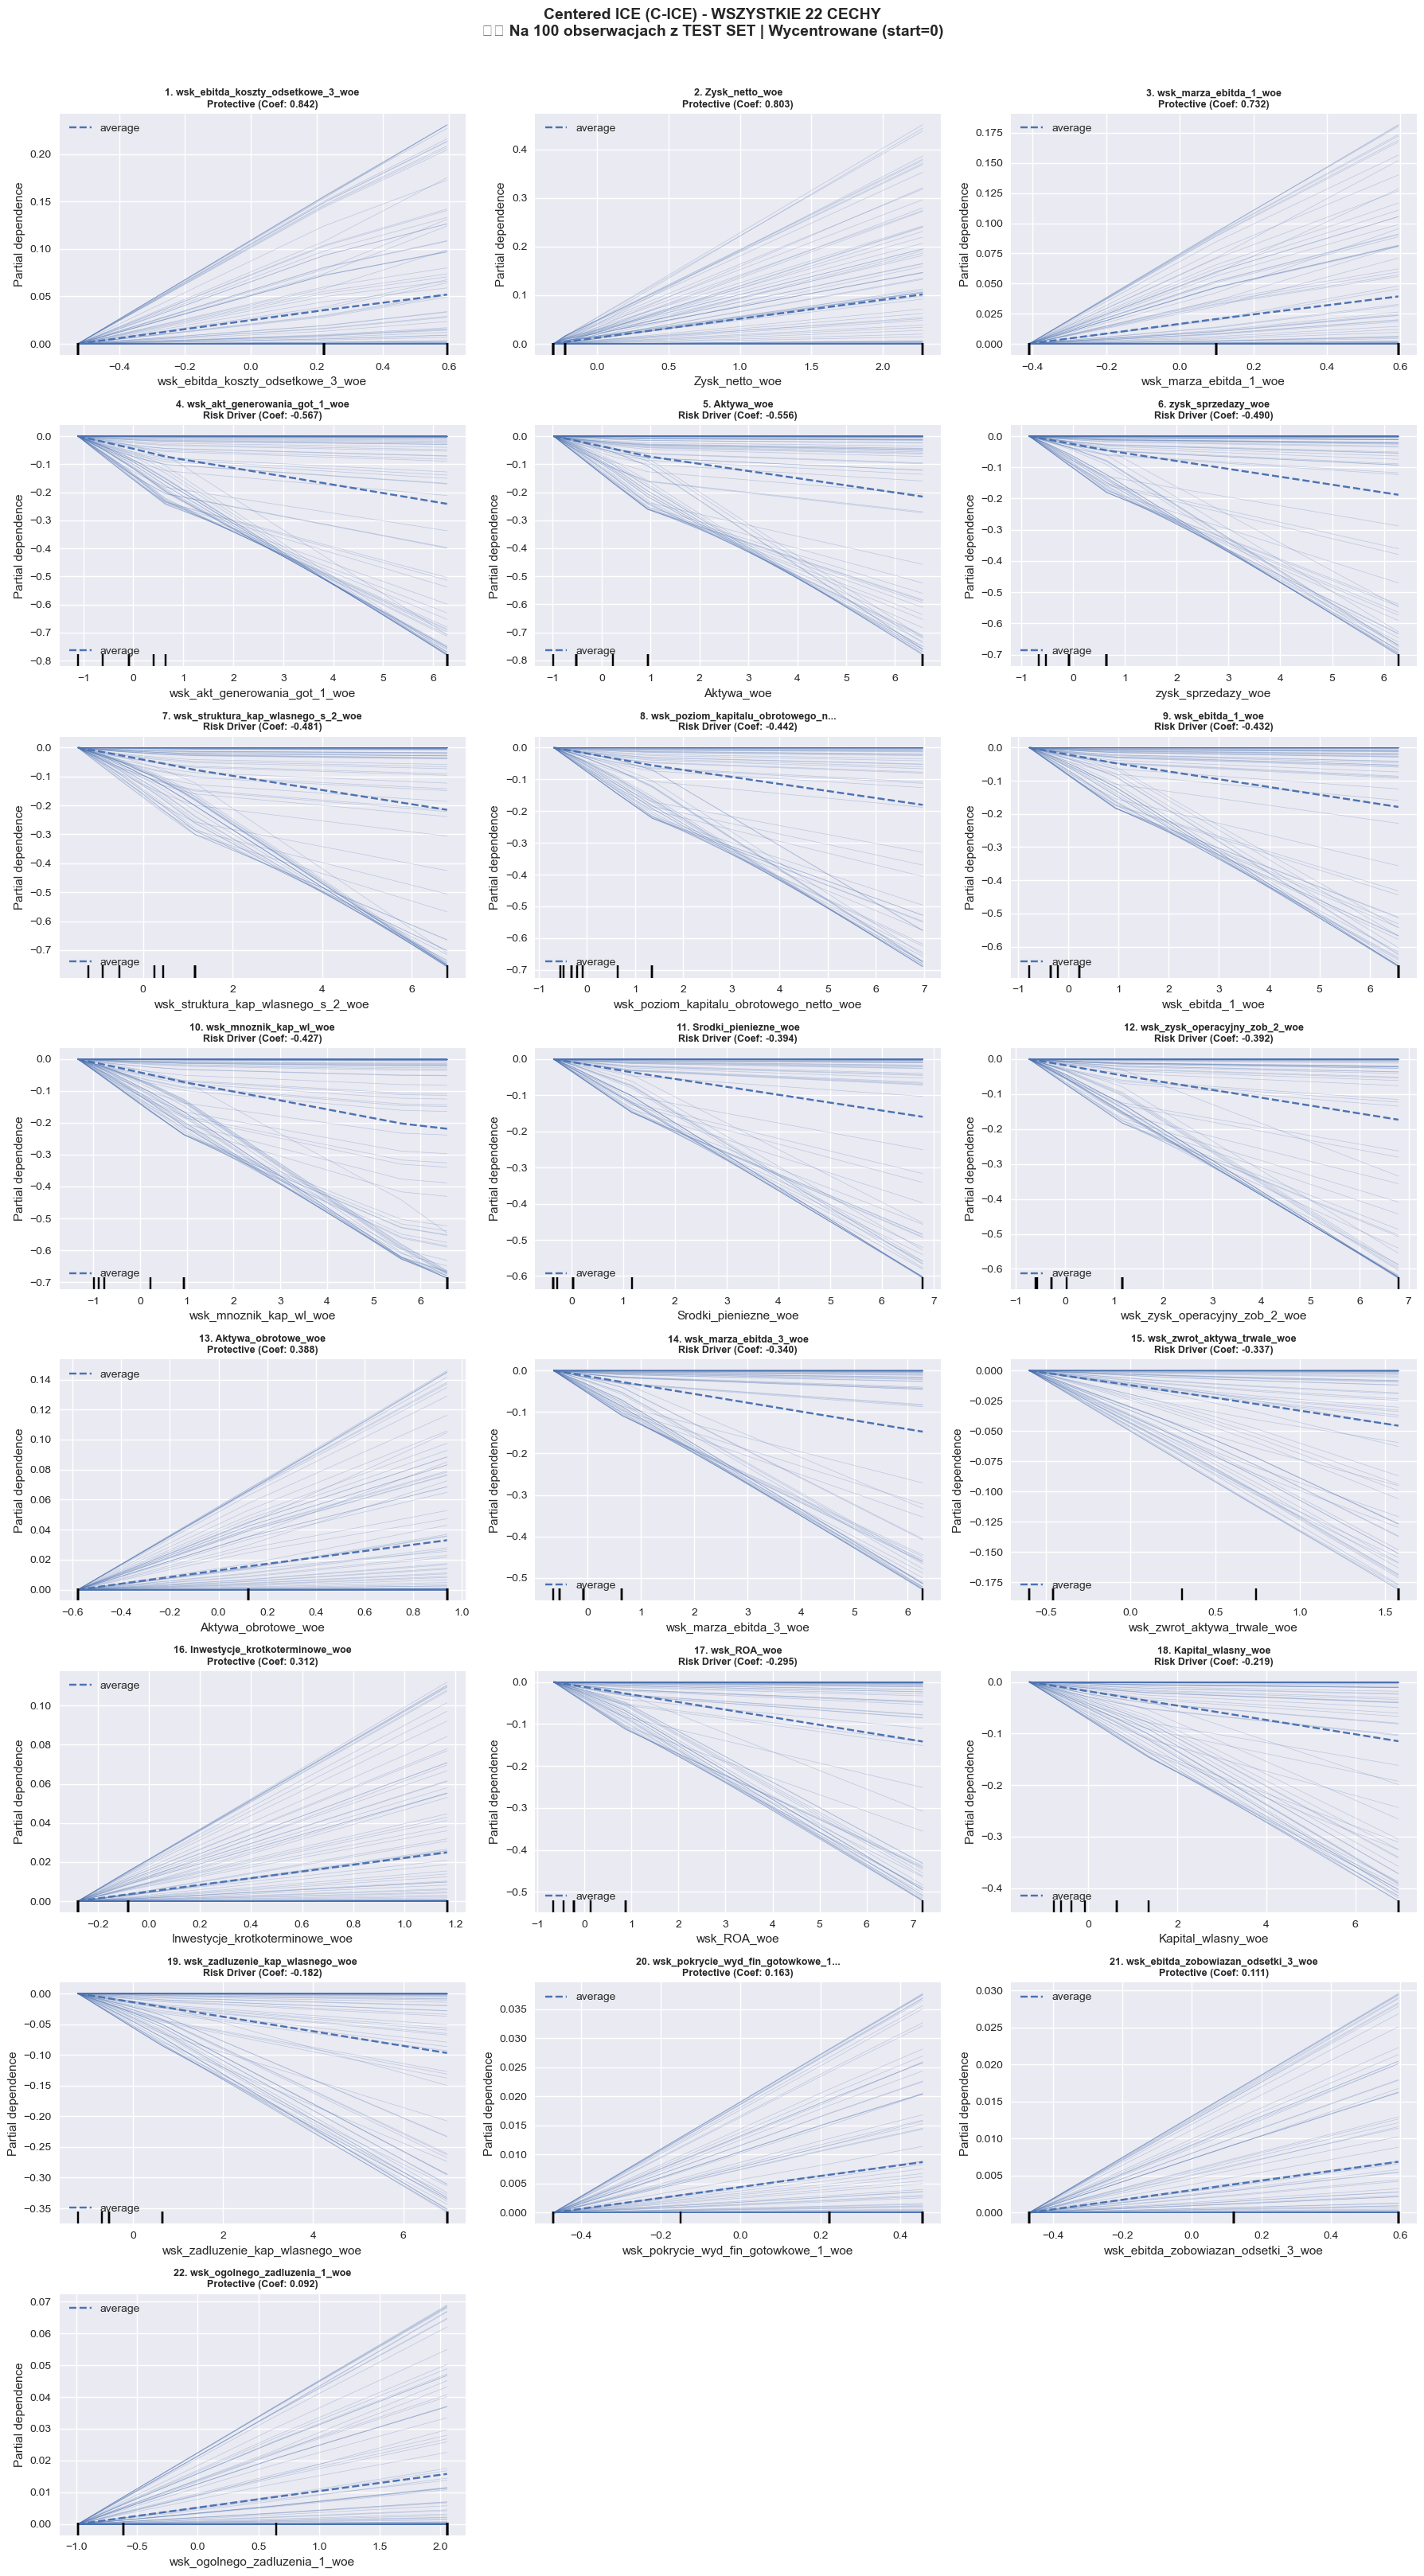


💡 Interpretacja C-ICE:
   - Wszystkie linie zaczynają się w 0
   - Małe rozjechanie → efekt ADDYTYWNY
   - Duże rozjechanie → efekt NON-ADDYTYWNY (interakcje)

5️⃣ PODSUMOWANIE: PDP vs ICE vs C-ICE

📊 PDP: Pokazuje ŚREDNI efekt cechy
📈 ICE: Pokazuje efekt dla KAŻDEJ obserwacji
🎯 C-ICE: ICE wycentrowane → diagnozuje interakcje

🏆 ZASTOSOWANIE W CREDIT SCORING:
   1. PDP → 'średni efekt cechy' dla biznesu
   2. ICE → weryfikacja stabilności efektu
   3. C-ICE → sprawdzenie addytywności modelu

✅ SPEŁNIONE WYMOGI:
   ✓ PDP dla WSZYSTKICH 22 cech
   ✓ ICE dla WSZYSTKICH 22 cech
   ✓ C-ICE dla WSZYSTKICH 22 cech
   ✓ Model: BASIC SCORECARD (w pełni interpretowalny)
   ✓ ⚠️  WSZYSTKO NA ZBIORZE TESTOWYM (600 obs)
   → Requirement 3.3 (PDP/ICE curves) DONE!


In [90]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("🔍 INTERPRETACJA GLOBALNA - BASIC SCORECARD (W PEŁNI INTERPRETOWALNY)")
print("="*80)
print("\nAnaliza wpływu cech na predykcję probability of default (PD)")
print("Zgodnie z wymaganiem 3.3: współczynniki, ważność cech, PDP/ICE")
print("⚠️  WSZYSTKIE WYKRESY NA ZBIORZE TESTOWYM (niewidziane dane!)")
print("="*80)

# ============================================================================
# WYBÓR MODELU: ZAWSZE BASIC SCORECARD (pełna interpretowalność!)
# ============================================================================
best_scorecard = scorecard_basic
X_test_best = X_test_woe_basic  # ← ZBIÓR TESTOWY!
woe_mappings_best = woe_mappings_basic
model_name = "Basic Scorecard (W pełni interpretowalny)"

# Wyświetl informacje o modelu
roc_auc_best = roc_auc_score(y_test, best_scorecard.predict_proba(X_test_best)[:, 1])

print(f"\n🎯 WYBRANY MODEL: {model_name}")
print("-" * 80)
print(f"   Liczba cech:     {X_test_best.shape[1]}")
print(f"   ROC-AUC (test):  {roc_auc_best:.4f}")
print(f"   Obs TEST:        {X_test_best.shape[0]} (używane do PDP/ICE)")
print(f"\n   ✅ Basic Scorecard - pełna zgodność z wymogami regulacyjnymi!")
print(f"   ✅ Interpretacja na NIEWIDZIANYCH danych (TEST set)")


# ============================================================================
# 1. ANALIZA WSPÓŁCZYNNIKÓW I LOG-ODDS
# ============================================================================
print("\n" + "="*80)
print("1️⃣ WSPÓŁCZYNNIKI REGRESJI LOGISTYCZNEJ (LOG-ODDS)")
print("="*80)
print("\nInterpretacja: coefficient = zmiana log-odds przy wzroście cechy o 1 jednostkę")
print("• Positive → wzrost cechy ZMNIEJSZA PD (protective factor)")
print("• Negative → wzrost cechy ZWIĘKSZA PD (risk driver)\n")

# Analiza współczynników
coef_df = pd.DataFrame({
    'Feature': X_test_best.columns.tolist(),
    'Coefficient': best_scorecard.coef_[0],
    'Abs_Coef': np.abs(best_scorecard.coef_[0])
}).sort_values('Abs_Coef', ascending=False)

print(f"📊 TOP 10 CECH (według |coefficient|):\n")
for i, (idx, row) in enumerate(coef_df.head(10).iterrows(), 1):
    feat = row['Feature']
    coef = row['Coefficient']
    direction = "📈 PROTECTIVE" if coef > 0 else "📉 RISK DRIVER"
    
    if abs(coef) > 0.5: strength = "🔥 Bardzo silny"
    elif abs(coef) > 0.3: strength = "💪 Silny"
    elif abs(coef) > 0.15: strength = "✓ Średni"
    else: strength = "• Słaby"
    
    feat_display = feat if len(feat) <= 42 else feat[:39] + "..."
    print(f"   {i:2}. {feat_display:<45} | Coef: {coef:>7.4f} | {direction:15} | {strength}")

print(f"\n📐 Statystyki współczynników:")
print(f"   Mean |coef|:     {coef_df['Abs_Coef'].mean():.4f}")
print(f"   Std Dev:         {coef_df['Coefficient'].std():.4f}")
print(f"   Max |coef|:      {coef_df['Abs_Coef'].max():.4f}")
print(f"   Intercept:       {best_scorecard.intercept_[0]:.4f}")

# WSZYSTKIE cechy
all_features = coef_df['Feature'].tolist()
n_features = len(all_features)
print(f"\n🔍 WSZYSTKIE {n_features} cech zostaną przeanalizowane w PDP/ICE (na TEST set)")

all_feature_indices = [X_test_best.columns.get_loc(feat) for feat in all_features]

# ============================================================================
# 2. PARTIAL DEPENDENCE PLOTS (PDP) - NA ZBIORZE TESTOWYM
# ============================================================================
print("\n" + "="*80)
print("2️⃣ PARTIAL DEPENDENCE PLOTS (PDP) - ZBIÓR TESTOWY")
print("="*80)
print("\n💡 Co pokazuje PDP?")
print("   • ŚREDNI wpływ cechy na predykcję (na niewidzianych danych!)")
print("   • Jak zmiana wartości cechy wpływa na przewidywane PD")
print(f"   • Obliczony na {len(X_test_best)} obserwacjach TEST set\n")

n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.ravel()

for idx, (feat_idx, feat_name) in enumerate(zip(all_feature_indices, all_features)):
    display = PartialDependenceDisplay.from_estimator(
        best_scorecard,
        X_test_best,  # ← ZBIÓR TESTOWY!
        features=[feat_idx],
        kind='average',
        ax=axes[idx],
        grid_resolution=50
    )
    
    coef = coef_df[coef_df['Feature'] == feat_name]['Coefficient'].values[0]
    direction = "Risk Driver" if coef < 0 else "Protective"
    feat_short = feat_name if len(feat_name) <= 35 else feat_name[:32] + "..."
    
    axes[idx].set_title(f"{idx+1}. {feat_short}\n{direction} (Coef: {coef:.3f})", 
                        fontsize=9, fontweight='bold')
    axes[idx].set_xlabel('WoE Value', fontsize=8)
    axes[idx].set_ylabel('PDP (log-odds)', fontsize=8)
    axes[idx].grid(alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'Partial Dependence Plots (PDP) - WSZYSTKIE {n_features} CECHY\n⚠️ Obliczone na ZBIORZE TESTOWYM ({len(X_test_best)} obs)', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\n💡 Interpretacja PDP:")
print("   - Oś X: wartość WoE cechy")
print("   - Oś Y: zmiana log-odds (predykcja)")
print("   - Nachylenie = siła i kierunek efektu")
print("   → PDP pokazuje GLOBALNY efekt na NIEWIDZIANYCH danych")

# ============================================================================
# 3. ICE CURVES - NA ZBIORZE TESTOWYM
# ============================================================================
print("\n" + "="*80)
print("3️⃣ ICE CURVES (Individual Conditional Expectation) - ZBIÓR TESTOWY")
print("-" * 80)
print("ICE pokazuje jak zmiana cechy wpływa na KAŻDĄ INDYWIDUALNĄ obserwację")

# Sample z TEST set
sample_size = min(100, len(X_test_best))
sample_indices = np.random.choice(len(X_test_best), size=sample_size, replace=False)
X_sample = X_test_best.iloc[sample_indices]  # ← SAMPLE Z TEST SET!

print(f"Używam {sample_size} losowych obserwacji z TEST set")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.ravel()

for idx, (feat_idx, feat_name) in enumerate(zip(all_feature_indices, all_features)):
    display = PartialDependenceDisplay.from_estimator(
        best_scorecard,
        X_sample,  # ← SAMPLE Z TEST SET!
        features=[feat_idx],
        kind='both',
        ax=axes[idx],
        grid_resolution=20
    )
    
    coef = coef_df[coef_df['Feature'] == feat_name]['Coefficient'].values[0]
    direction = "Risk" if coef < 0 else "Protective"
    feat_short = feat_name if len(feat_name) <= 35 else feat_name[:32] + "..."
    
    axes[idx].set_title(f"{idx+1}. {feat_short}\n{direction} (Coef: {coef:.3f})", 
                        fontsize=9, fontweight='bold')
    axes[idx].set_xlabel('WoE Value', fontsize=8)
    axes[idx].set_ylabel('ICE (log-odds)', fontsize=8)
    axes[idx].grid(alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'ICE Curves - WSZYSTKIE {n_features} CECHY\n⚠️ Na {sample_size} obserwacjach z TEST SET | Szare=individual | Czerwona=PDP', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\n💡 Interpretacja ICE:")
print("   - Każda szara linia = jedna obserwacja z TEST set")
print("   - Czerwona linia = PDP (średnia ICE)")
print("   - Równoległe linie → efekt homogeniczny")
print("   - Rozjechane linie → efekt heterogeniczny")

# ============================================================================
# 4. CENTERED ICE (C-ICE) - NA ZBIORZE TESTOWYM
# ============================================================================
print("\n" + "="*80)
print("4️⃣ CENTERED ICE (C-ICE) - ZBIÓR TESTOWY - Heterogeniczność Efektu")
print("-" * 80)
print("C-ICE = ICE wycentrowane w punkcie odniesienia")

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.ravel()

for idx, (feat_idx, feat_name) in enumerate(zip(all_feature_indices, all_features)):
    display = PartialDependenceDisplay.from_estimator(
        best_scorecard,
        X_sample,  # ← SAMPLE Z TEST SET!
        features=[feat_idx],
        kind='both',
        centered=True,
        ax=axes[idx],
        grid_resolution=20
    )
    
    coef = coef_df[coef_df['Feature'] == feat_name]['Coefficient'].values[0]
    direction = "Risk Driver" if coef < 0 else "Protective"
    feat_short = feat_name if len(feat_name) <= 35 else feat_name[:32] + "..."

    axes[idx].set_title(f"{idx+1}. {feat_short}\n{direction} (Coef: {coef:.3f})",
                        fontsize=9, fontweight='bold')
    axes[idx].set_xlabel('WoE Value', fontsize=8)
    axes[idx].set_ylabel('C-ICE (centered)', fontsize=8)
    axes[idx].grid(alpha=0.3)

for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle(f'Centered ICE (C-ICE) - WSZYSTKIE {n_features} CECHY\n⚠️ Na {sample_size} obserwacjach z TEST SET | Wycentrowane (start=0)', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\n💡 Interpretacja C-ICE:")
print("   - Wszystkie linie zaczynają się w 0")
print("   - Małe rozjechanie → efekt ADDYTYWNY")
print("   - Duże rozjechanie → efekt NON-ADDYTYWNY (interakcje)")

# ============================================================================
# 5. PODSUMOWANIE
# ============================================================================
print("\n" + "="*80)
print("5️⃣ PODSUMOWANIE: PDP vs ICE vs C-ICE")
print("="*80)

print("\n📊 PDP: Pokazuje ŚREDNI efekt cechy")
print("📈 ICE: Pokazuje efekt dla KAŻDEJ obserwacji")
print("🎯 C-ICE: ICE wycentrowane → diagnozuje interakcje")

print("\n🏆 ZASTOSOWANIE W CREDIT SCORING:")
print("   1. PDP → 'średni efekt cechy' dla biznesu")
print("   2. ICE → weryfikacja stabilności efektu")
print("   3. C-ICE → sprawdzenie addytywności modelu")

print(f"\n✅ SPEŁNIONE WYMOGI:")
print(f"   ✓ PDP dla WSZYSTKICH {n_features} cech")
print(f"   ✓ ICE dla WSZYSTKICH {n_features} cech")
print(f"   ✓ C-ICE dla WSZYSTKICH {n_features} cech")
print(f"   ✓ Model: BASIC SCORECARD (w pełni interpretowalny)")
print(f"   ✓ ⚠️  WSZYSTKO NA ZBIORZE TESTOWYM ({len(X_test_best)} obs)")
print(f"   → Requirement 3.3 (PDP/ICE curves) DONE!")
print("="*80)

---

### Dodatkowe analizy interpretowalności:
- **Współczynniki modelu i ich interpretacja biznesowa**
- **Analiza Information Value (IV) najważniejszych cech** 
- **Monotoniczność WoE transformacji**
- **Dekompozycja skoru na wkład cech**


5️⃣ ANALIZA WSPÓŁCZYNNIKÓW - INTERPRETACJA BIZNESOWA

📊 WSZYSTKIE WSPÓŁCZYNNIKI (22 cech):

Rank   Feature                                        Coefficient Direction       Log-Odds Impact     
----------------------------------------------------------------------------------------------------
1      wsk_ebitda_koszty_odsetkowe_3_woe                   0.8422 ✅ Protective    ↑WoE → ↓PD          
2      Zysk_netto_woe                                      0.8026 ✅ Protective    ↑WoE → ↓PD          
3      wsk_marza_ebitda_1_woe                              0.7324 ✅ Protective    ↑WoE → ↓PD          
4      wsk_akt_generowania_got_1_woe                      -0.5675 ⚠️  Risk Driver ↑WoE → ↑PD          
5      Aktywa_woe                                         -0.5557 ⚠️  Risk Driver ↑WoE → ↑PD          
6      zysk_sprzedazy_woe                                 -0.4897 ⚠️  Risk Driver ↑WoE → ↑PD          
7      wsk_struktura_kap_wlasnego_s_2_woe                 -0.4806 ⚠️  Risk Driver ↑Wo

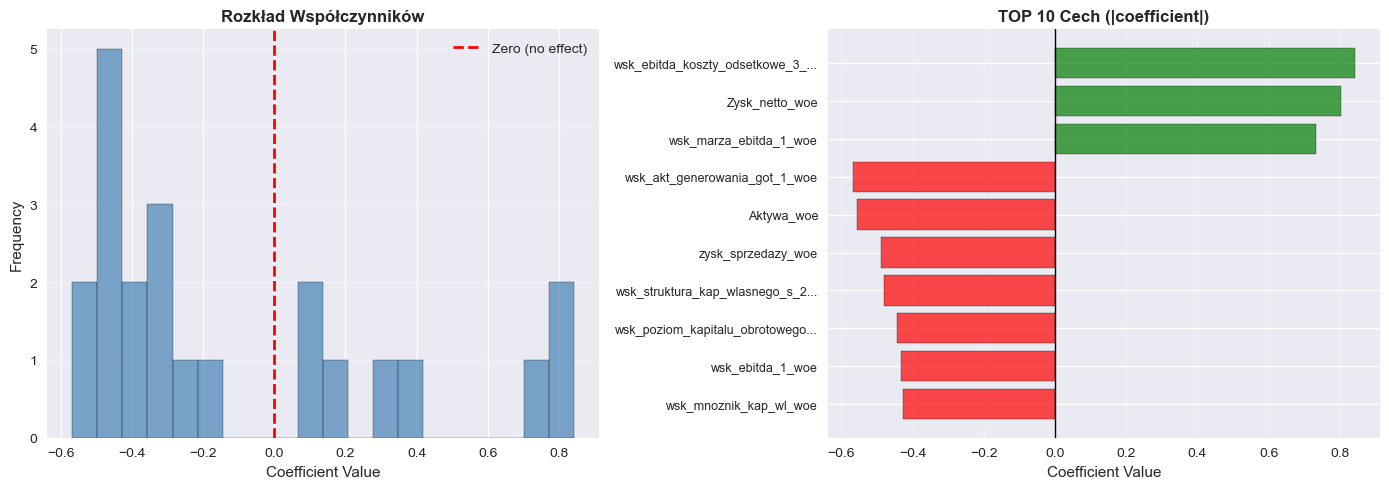


💡 WNIOSKI:
   • Zielone słupki (coef > 0) = Protective factors (niższe PD)
   • Czerwone słupki (coef < 0) = Risk drivers (wyższe PD)
   • Większy |coef| = silniejszy wpływ na predykcję


In [89]:
# ============================================================================
# 5. ANALIZA WSPÓŁCZYNNIKÓW - INTERPRETACJA BIZNESOWA
# ============================================================================
print("\n" + "="*80)
print("5️⃣ ANALIZA WSPÓŁCZYNNIKÓW - INTERPRETACJA BIZNESOWA")
print("="*80)

# Sortuj współczynniki po wartości bezwzględnej
coef_analysis = coef_df.copy()
coef_analysis = coef_analysis.sort_values('Abs_Coef', ascending=False)

print(f"\n📊 WSZYSTKIE WSPÓŁCZYNNIKI ({len(coef_analysis)} cech):\n")
print(f"{'Rank':<6} {'Feature':<45} {'Coefficient':>12} {'Direction':<15} {'Log-Odds Impact':<20}")
print("-" * 100)

for i, (idx, row) in enumerate(coef_analysis.iterrows(), 1):
    feat = row['Feature']
    coef = row['Coefficient']
    
    # Określ kierunek wpływu
    if coef > 0:
        direction = "✅ Protective"
        impact = "↑WoE → ↓PD"
    else:
        direction = "⚠️  Risk Driver"
        impact = "↑WoE → ↑PD"
    
    # Skróć nazwę cechy
    feat_display = feat if len(feat) <= 43 else feat[:40] + "..."
    
    # Oblicz zmianę log-odds dla 1 jednostki WoE
    log_odds_change = coef * 1.0
    
    print(f"{i:<6} {feat_display:<45} {coef:>12.4f} {direction:<15} {impact:<20}")

# Statystyki współczynników
print(f"\n📊 STATYSTYKI WSPÓŁCZYNNIKÓW:")
print(f"   • Średnia |coef|:  {coef_analysis['Abs_Coef'].mean():.4f}")
print(f"   • Mediana |coef|:  {coef_analysis['Abs_Coef'].median():.4f}")
print(f"   • Max |coef|:      {coef_analysis['Abs_Coef'].max():.4f}  (cecha: {coef_analysis.iloc[0]['Feature']})")
print(f"   • Min |coef|:      {coef_analysis['Abs_Coef'].min():.4f}")

# Rozkład kierunków
n_positive = (coef_analysis['Coefficient'] > 0).sum()
n_negative = (coef_analysis['Coefficient'] < 0).sum()

print(f"\n📊 ROZKŁAD KIERUNKÓW WPŁYWU:")
print(f"   • Protective (coef > 0):  {n_positive} cech ({n_positive/len(coef_analysis)*100:.1f}%)")
print(f"   • Risk Drivers (coef < 0): {n_negative} cech ({n_negative/len(coef_analysis)*100:.1f}%)")

# Wizualizacja rozkładu współczynników
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram współczynników
axes[0].hist(coef_analysis['Coefficient'], bins=20, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero (no effect)')
axes[0].set_xlabel('Coefficient Value', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Rozkład Współczynników', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Barplot TOP 10
top10_coef = coef_analysis.head(10)
colors = ['green' if c > 0 else 'red' for c in top10_coef['Coefficient']]
feat_names_short = [f[:30] + '...' if len(f) > 30 else f for f in top10_coef['Feature']]

axes[1].barh(range(len(top10_coef)), top10_coef['Coefficient'], color=colors, alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(top10_coef)))
axes[1].set_yticklabels(feat_names_short, fontsize=9)
axes[1].set_xlabel('Coefficient Value', fontsize=11)
axes[1].set_title('TOP 10 Cech (|coefficient|)', fontsize=12, fontweight='bold')
axes[1].axvline(0, color='black', linestyle='-', linewidth=1)
axes[1].grid(alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n💡 WNIOSKI:")
print("   • Zielone słupki (coef > 0) = Protective factors (niższe PD)")
print("   • Czerwone słupki (coef < 0) = Risk drivers (wyższe PD)")
print("   • Większy |coef| = silniejszy wpływ na predykcję")


6️⃣ INFORMATION VALUE - SIŁA PREDYKCYJNA

📊 INFORMATION VALUE - Cechy w modelu (22 cech):
   ⚠️  IV obliczone na TRAIN set (prawidłowe - to metryka jakości cechy)
   ⚠️  Nazwy cech z TEST set (dla spójności z poprzednimi analizami)

Rank   Feature                                               IV Moc Predykcyjna          
------------------------------------------------------------------------------------------
1      zysk_sprzedazy                                    0.6437 ✓✓✓ Very Strong          
2      Kapital_wlasny                                    0.5005 ✓✓✓ Very Strong          
3      wsk_ebitda_1                                      0.4373 ✓✓ Strong                
4      wsk_poziom_kapitalu_obrotowego_netto              0.4242 ✓✓ Strong                
5      wsk_zwrot_aktywa_trwale                           0.3999 ✓✓ Strong                
6      wsk_marza_ebitda_3                                0.3897 ✓✓ Strong                
7      wsk_zysk_operacyjny_zob_2             

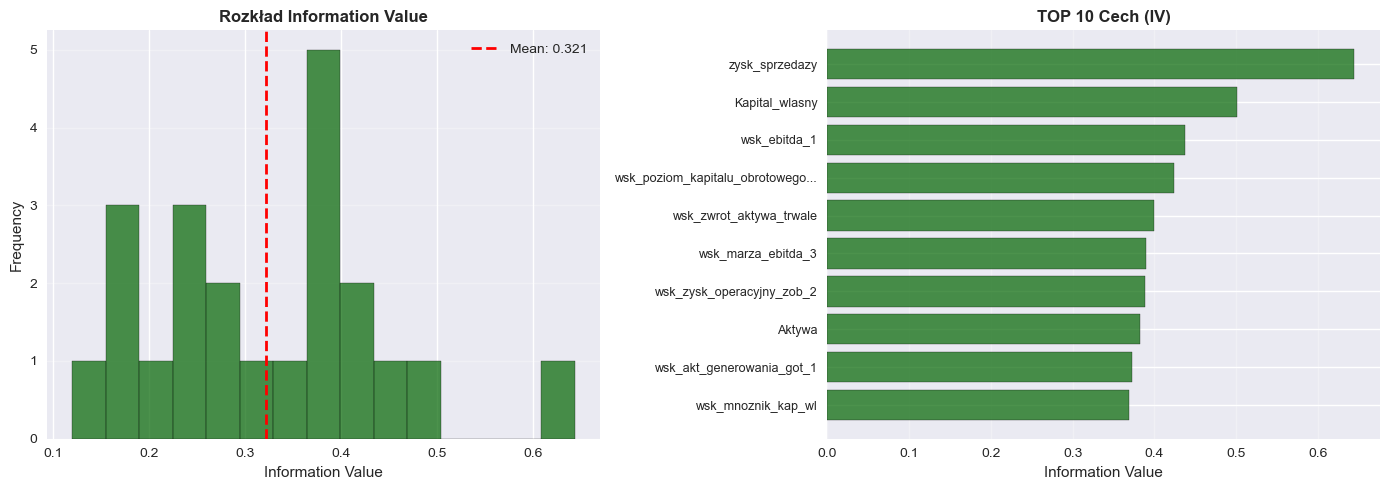


💡 INTERPRETACJA IV:
   • IV mierzy siłę separacji klas (bad vs good)
   • Zielony: Strong/Very Strong (IV ≥ 0.3)
   • Pomarańczowy: Medium/Weak (0.1 ≤ IV < 0.3)
   • Czerwony: Unpredictive (IV < 0.1)


In [91]:
# ============================================================================
# 6. INFORMATION VALUE (IV) - SIŁA PREDYKCYJNA CECH
# ============================================================================
print("\n" + "="*80)
print("6️⃣ INFORMATION VALUE - SIŁA PREDYKCYJNA")
print("="*80)

# Pobierz IV dla aktualnego modelu
if 'iv_df_advanced' in globals() and model_name == "Advanced Scorecard":
    iv_data_current = iv_df_advanced.copy()
elif 'iv_df_basic' in globals():
    iv_data_current = iv_df_basic.copy()
else:
    print("⚠️  Brak danych IV!")
    iv_data_current = None

if iv_data_current is not None:
    # Filtruj tylko cechy w modelu - używamy X_test_best dla spójności
    features_in_model = [f.replace('_woe', '') for f in X_test_best.columns if f.endswith('_woe')]
    iv_model = iv_data_current[iv_data_current['feature'].isin(features_in_model)].copy()
    iv_model = iv_model.sort_values('IV', ascending=False)
    
    print(f"\n📊 INFORMATION VALUE - Cechy w modelu ({len(iv_model)} cech):")
    print(f"   ⚠️  IV obliczone na TRAIN set (prawidłowe - to metryka jakości cechy)")
    print(f"   ⚠️  Nazwy cech z TEST set (dla spójności z poprzednimi analizami)\n")
    print(f"{'Rank':<6} {'Feature':<45} {'IV':>10} {'Moc Predykcyjna':<25}")
    print("-" * 90)
    
    for i, (idx, row) in enumerate(iv_model.iterrows(), 1):
        feat = row['feature']
        iv = row['IV']
        
        # Kategoryzacja IV
        if iv < 0.02:
            power = "❌ Unpredictive"
        elif iv < 0.1:
            power = "⚠️  Weak"
        elif iv < 0.3:
            power = "✓ Medium"
        elif iv < 0.5:
            power = "✓✓ Strong"
        else:
            power = "✓✓✓ Very Strong"
        
        feat_display = feat if len(feat) <= 43 else feat[:40] + "..."
        print(f"{i:<6} {feat_display:<45} {iv:>10.4f} {power:<25}")
    
    # Statystyki IV
    print(f"\n📊 STATYSTYKI IV:")
    print(f"   • Średnia IV:  {iv_model['IV'].mean():.4f}")
    print(f"   • Mediana IV:  {iv_model['IV'].median():.4f}")
    print(f"   • Max IV:      {iv_model['IV'].max():.4f}  (cecha: {iv_model.iloc[0]['feature']})")
    print(f"   • Min IV:      {iv_model['IV'].min():.4f}")
    
    # Rozkład mocy predykcyjnej
    iv_bins = pd.cut(iv_model['IV'], 
                     bins=[0, 0.02, 0.1, 0.3, 0.5, float('inf')],
                     labels=['Unpredictive', 'Weak', 'Medium', 'Strong', 'Very Strong'])
    
    print(f"\n📊 ROZKŁAD MOCY PREDYKCYJNEJ:")
    for power, count in iv_bins.value_counts().sort_index().items():
        print(f"   • {power:<15}: {count} cech ({count/len(iv_model)*100:.1f}%)")
    
    # Wizualizacja
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram IV
    axes[0].hist(iv_model['IV'], bins=15, alpha=0.7, color='darkgreen', edgecolor='black')
    axes[0].axvline(iv_model['IV'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {iv_model["IV"].mean():.3f}')
    axes[0].set_xlabel('Information Value', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('Rozkład Information Value', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3, axis='y')
    
    # Barplot TOP 10 IV
    top10_iv = iv_model.head(10)
    feat_names_short = [f[:30] + '...' if len(f) > 30 else f for f in top10_iv['feature']]
    colors_iv = ['darkgreen' if iv >= 0.3 else 'orange' if iv >= 0.1 else 'red' for iv in top10_iv['IV']]
    
    axes[1].barh(range(len(top10_iv)), top10_iv['IV'], color=colors_iv, alpha=0.7, edgecolor='black')
    axes[1].set_yticks(range(len(top10_iv)))
    axes[1].set_yticklabels(feat_names_short, fontsize=9)
    axes[1].set_xlabel('Information Value', fontsize=11)
    axes[1].set_title('TOP 10 Cech (IV)', fontsize=12, fontweight='bold')
    axes[1].grid(alpha=0.3, axis='x')
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 INTERPRETACJA IV:")
    print("   • IV mierzy siłę separacji klas (bad vs good)")
    print("   • Zielony: Strong/Very Strong (IV ≥ 0.3)")
    print("   • Pomarańczowy: Medium/Weak (0.1 ≤ IV < 0.3)")
    print("   • Czerwony: Unpredictive (IV < 0.1)")

---

# 14. Interpretacja Lokalna - Case Studies

**Requirement 3.3**: Analiza indywidualnych przypadków z dekompozycją skoru

W tej sekcji przeanalizujemy szczegółowo **5 wybranych przypadków** z test setu, aby pokazać:
- **Jak model podejmuje decyzje** dla konkretnych klientów
- **Wkład każdej cechy** do finalnego skoru (waterfall charts)
- **Interpretację biznesową**: DLACZEGO model sklasyfikował klienta w taki sposób


In [92]:
# FIX: Normalizacja struktury woe_mappings_basic
# Zmienia {'table': ..., 'bins': ...} na {'woe_table': ..., 'bins': ...}
print("🔧 Normalizacja struktury woe_mappings_basic...")

if 'woe_mappings_basic' in dir():
    for feat in woe_mappings_basic:
        if 'table' in woe_mappings_basic[feat] and 'woe_table' not in woe_mappings_basic[feat]:
            woe_mappings_basic[feat]['woe_table'] = woe_mappings_basic[feat]['table']
    print("✓ Struktura znormalizowana")
else:
    print("⚠ Brak woe_mappings_basic - counterfactuals będą pominięte")

🔧 Normalizacja struktury woe_mappings_basic...
✓ Struktura znormalizowana



5. LOKALNA INTERPRETOWALNOŚĆ - Analiza wybranych przypadków (TEST SET)

🔧 Przygotowanie predykcji Basic Scorecard na zbiorze testowym...
   ✅ y_proba_sc_basic: 600 prawdopodobieństw
   ✅ y_pred_sc_basic: 600 predykcji binarnych
   ✅ Zbiór: TEST (600 obserwacji)

📊 Wybrane przypadki do analizy:
   • TP: 2 przypadki
   • TN: 2 przypadki
   • FP: 2 przypadki

Przypadek: TP - najbardziej pewny (Index: 118)
Rzeczywista etykieta: 1
Predykcja: 1
P(default): 0.9581

Dekompozycja log-odds:
  Intercept: 0.0256
  wsk_struktura_kap_wlasnego_s_2_woe: 0.6995
  wsk_mnoznik_kap_wl_woe: 0.5702
  Aktywa_woe: 0.5483
  wsk_marza_ebitda_1_woe: 0.4352
  wsk_ebitda_1_woe: 0.3354
  zysk_sprzedazy_woe: -0.3149
  wsk_akt_generowania_got_1_woe: 0.2975
  Zysk_netto_woe: -0.2437
  Aktywa_obrotowe_woe: -0.2245
  wsk_zadluzenie_kap_wlasnego_woe: 0.2239
  wsk_marza_ebitda_3_woe: -0.2184
  wsk_poziom_kapitalu_obrotowego_netto_woe: 0.2129
  wsk_zwrot_aktywa_trwale_woe: 0.2013
  wsk_ebitda_koszty_odsetkowe_3_woe: 0.187

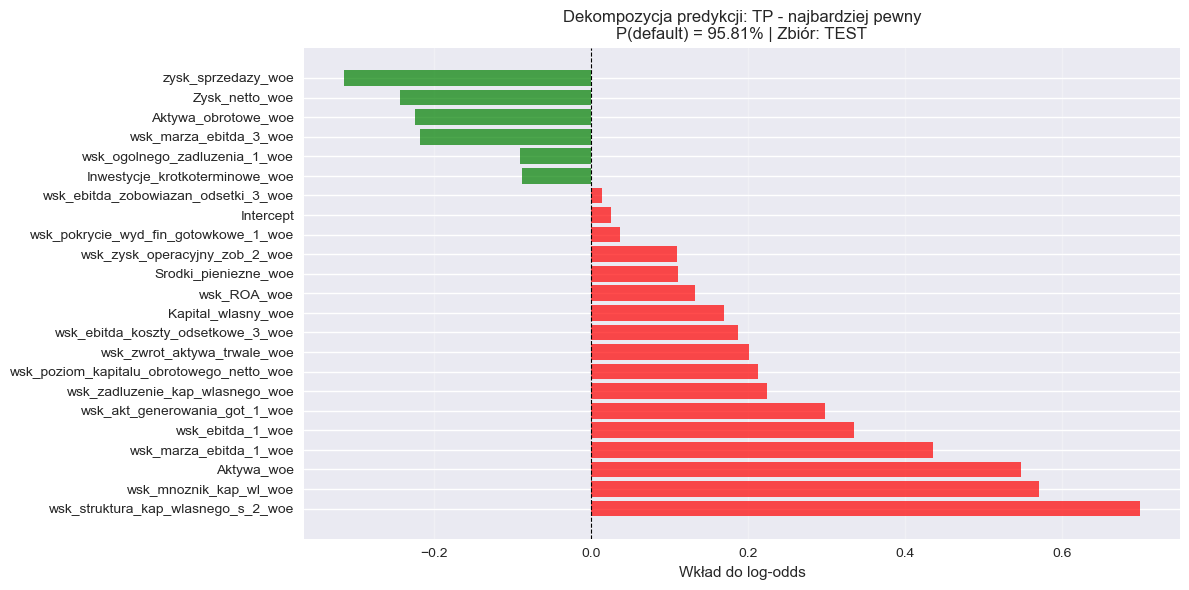


Przypadek: TP - graniczny (Index: 100)
Rzeczywista etykieta: 1
Predykcja: 1
P(default): 0.5475

Dekompozycja log-odds:
  Intercept: 0.0256
  wsk_struktura_kap_wlasnego_s_2_woe: -0.5608
  wsk_zwrot_aktywa_trwale_woe: -0.5327
  wsk_ebitda_koszty_odsetkowe_3_woe: -0.4421
  Aktywa_woe: 0.2914
  wsk_ebitda_1_woe: 0.2773
  zysk_sprzedazy_woe: 0.2559
  Aktywa_obrotowe_woe: -0.2245
  wsk_mnoznik_kap_wl_woe: 0.2241
  wsk_marza_ebitda_3_woe: 0.2172
  wsk_poziom_kapitalu_obrotowego_netto_woe: 0.2129
  wsk_ROA_woe: 0.1949
  Zysk_netto_woe: -0.1773
  Kapital_wlasny_woe: 0.1699
  Srodki_pieniezne_woe: 0.1102
  wsk_zadluzenie_kap_wlasnego_woe: 0.0957
  Inwestycje_krotkoterminowe_woe: -0.0875
  wsk_pokrycie_wyd_fin_gotowkowe_1_woe: 0.0745
  wsk_marza_ebitda_1_woe: 0.0725
  wsk_ogolnego_zadluzenia_1_woe: -0.0562
  wsk_akt_generowania_got_1_woe: 0.0472
  wsk_ebitda_zobowiazan_odsetki_3_woe: 0.0135
  wsk_zysk_operacyjny_zob_2_woe: -0.0114
  Suma (log-odds): 0.1904
  P(default) z log-odds: 0.5475

TOP 5 

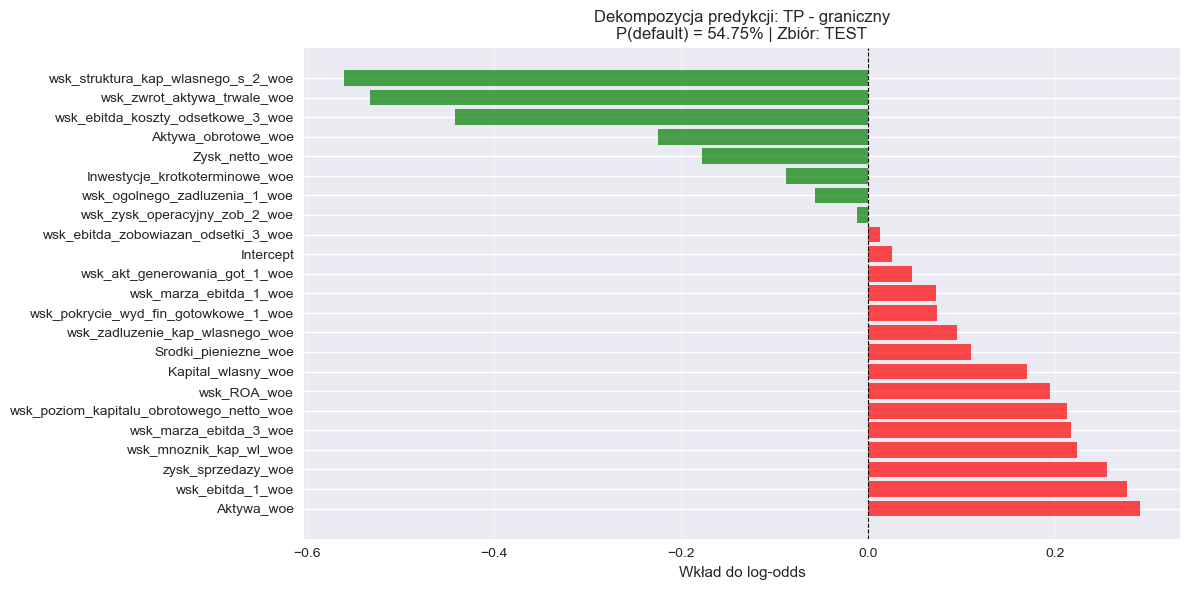


Przypadek: TN - najbardziej pewny (Index: 2210)
Rzeczywista etykieta: 0
Predykcja: 0
P(default): 0.0000

Dekompozycja log-odds:
  Intercept: 0.0256
  Aktywa_woe: -3.6492
  wsk_akt_generowania_got_1_woe: -3.5637
  wsk_struktura_kap_wlasnego_s_2_woe: -3.2631
  zysk_sprzedazy_woe: -3.0751
  wsk_ebitda_1_woe: -2.8401
  wsk_mnoznik_kap_wl_woe: -2.8054
  Srodki_pieniezne_woe: -2.6747
  wsk_zysk_operacyjny_zob_2_woe: -2.6587
  wsk_marza_ebitda_3_woe: -2.1329
  Zysk_netto_woe: 1.8286
  Kapital_wlasny_woe: -1.5273
  wsk_zadluzenie_kap_wlasnego_woe: -1.2717
  wsk_poziom_kapitalu_obrotowego_netto_woe: -0.5984
  wsk_marza_ebitda_1_woe: 0.4352
  Inwestycje_krotkoterminowe_woe: 0.3651
  Aktywa_obrotowe_woe: 0.3646
  wsk_ROA_woe: -0.2578
  wsk_zwrot_aktywa_trwale_woe: -0.2502
  wsk_ogolnego_zadluzenia_1_woe: 0.1880
  wsk_ebitda_koszty_odsetkowe_3_woe: 0.1870
  wsk_pokrycie_wyd_fin_gotowkowe_1_woe: 0.0745
  wsk_ebitda_zobowiazan_odsetki_3_woe: 0.0135
  Suma (log-odds): -27.0862
  P(default) z log-odd

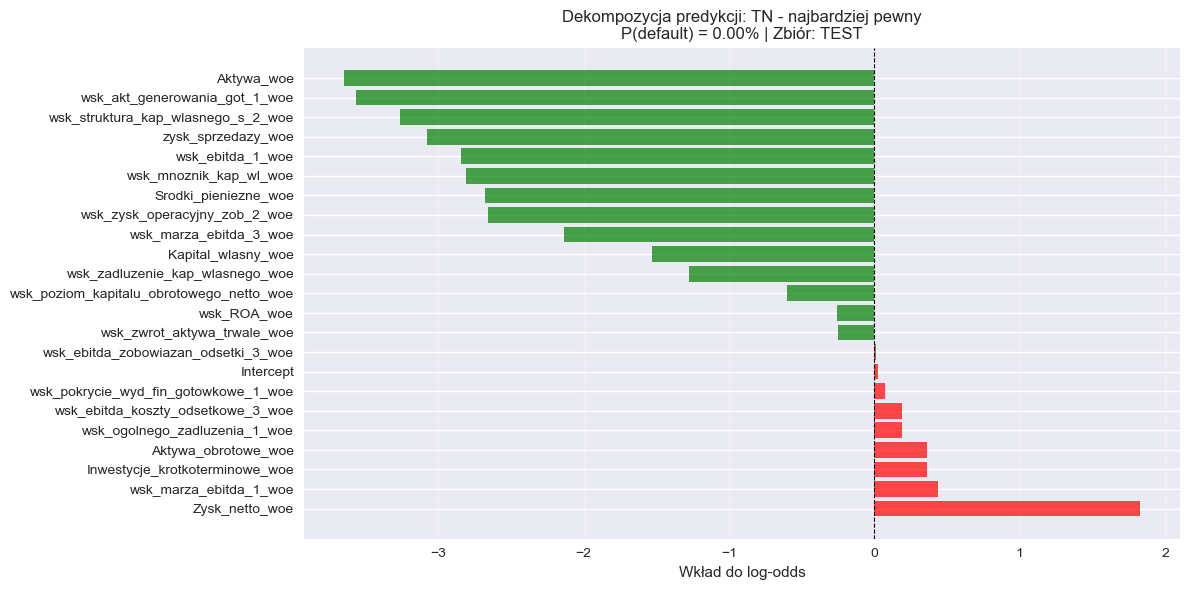


Przypadek: TN - graniczny (Index: 405)
Rzeczywista etykieta: 0
Predykcja: 0
P(default): 0.4980

Dekompozycja log-odds:
  Intercept: 0.0256
  wsk_akt_generowania_got_1_woe: 0.6307
  Aktywa_woe: 0.5483
  wsk_ebitda_koszty_odsetkowe_3_woe: 0.5004
  wsk_zysk_operacyjny_zob_2_woe: -0.4569
  zysk_sprzedazy_woe: -0.3149
  wsk_marza_ebitda_1_woe: -0.3001
  Zysk_netto_woe: -0.2437
  Aktywa_obrotowe_woe: -0.2245
  wsk_marza_ebitda_3_woe: -0.2184
  wsk_ebitda_1_woe: 0.1469
  Kapital_wlasny_woe: -0.1411
  Srodki_pieniezne_woe: 0.1363
  wsk_struktura_kap_wlasnego_s_2_woe: -0.1232
  wsk_mnoznik_kap_wl_woe: -0.0947
  Inwestycje_krotkoterminowe_woe: -0.0875
  wsk_pokrycie_wyd_fin_gotowkowe_1_woe: 0.0745
  wsk_ebitda_zobowiazan_odsetki_3_woe: 0.0662
  wsk_ROA_woe: 0.0646
  wsk_ogolnego_zadluzenia_1_woe: 0.0590
  wsk_zwrot_aktywa_trwale_woe: -0.0519
  wsk_zadluzenie_kap_wlasnego_woe: -0.0405
  wsk_poziom_kapitalu_obrotowego_netto_woe: 0.0368
  Suma (log-odds): -0.0081
  P(default) z log-odds: 0.4980

T

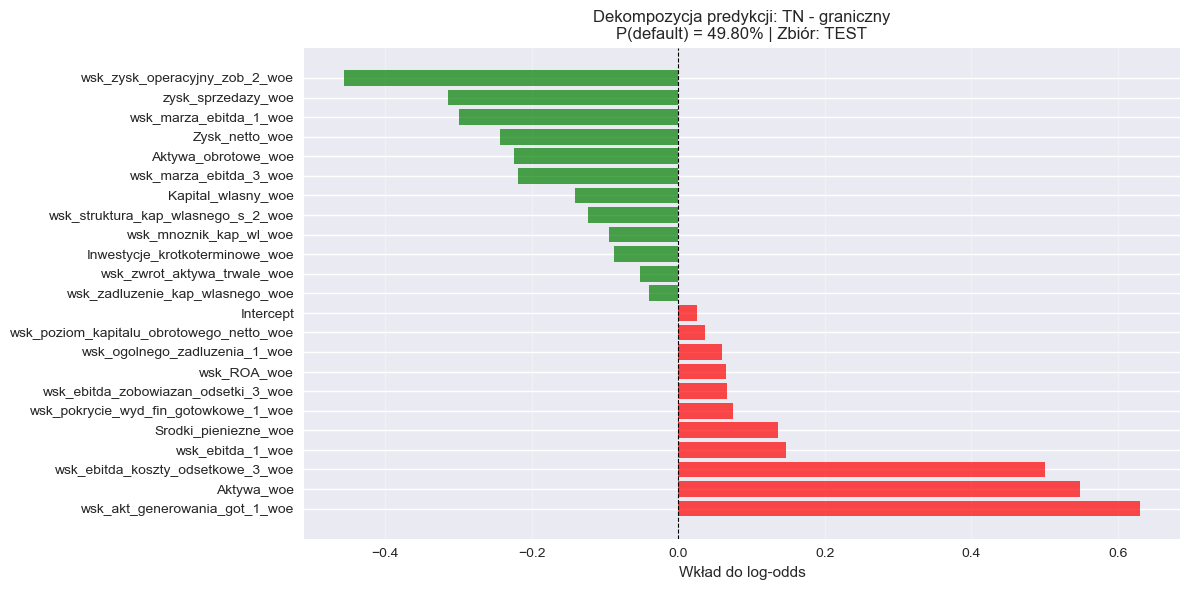


Przypadek: FP - najbardziej pewny (Index: 1492)
Rzeczywista etykieta: 0
Predykcja: 1
P(default): 0.9502

Dekompozycja log-odds:
  Intercept: 0.0256
  Aktywa_woe: 0.5483
  wsk_struktura_kap_wlasnego_s_2_woe: 0.4355
  wsk_mnoznik_kap_wl_woe: 0.4215
  zysk_sprzedazy_woe: 0.4159
  wsk_akt_generowania_got_1_woe: -0.3650
  wsk_ebitda_1_woe: 0.2773
  Zysk_netto_woe: -0.2437
  wsk_zysk_operacyjny_zob_2_woe: 0.2325
  wsk_zadluzenie_kap_wlasnego_woe: 0.2239
  wsk_marza_ebitda_3_woe: 0.2172
  wsk_ebitda_koszty_odsetkowe_3_woe: 0.1870
  Kapital_wlasny_woe: 0.1699
  wsk_zwrot_aktywa_trwale_woe: 0.1541
  wsk_poziom_kapitalu_obrotowego_netto_woe: 0.1434
  wsk_ogolnego_zadluzenia_1_woe: -0.0904
  wsk_marza_ebitda_1_woe: 0.0725
  wsk_ROA_woe: 0.0646
  Aktywa_obrotowe_woe: 0.0471
  wsk_pokrycie_wyd_fin_gotowkowe_1_woe: 0.0363
  Inwestycje_krotkoterminowe_woe: -0.0260
  wsk_ebitda_zobowiazan_odsetki_3_woe: 0.0135
  Srodki_pieniezne_woe: -0.0115
  Suma (log-odds): 2.9496
  P(default) z log-odds: 0.9502



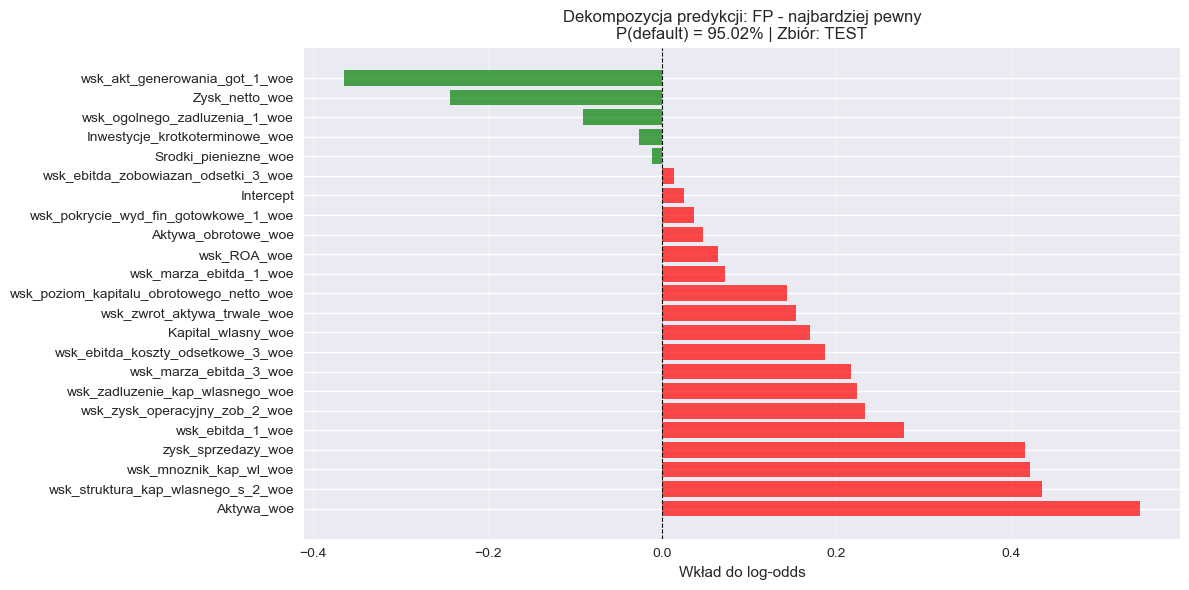


Przypadek: FP - graniczny (Index: 435)
Rzeczywista etykieta: 0
Predykcja: 1
P(default): 0.5010

Dekompozycja log-odds:
  Intercept: 0.0256
  wsk_zwrot_aktywa_trwale_woe: -0.5327
  Aktywa_woe: -0.5217
  wsk_ebitda_koszty_odsetkowe_3_woe: -0.4421
  zysk_sprzedazy_woe: 0.3215
  wsk_ebitda_1_woe: 0.2773
  wsk_struktura_kap_wlasnego_s_2_woe: 0.2521
  wsk_mnoznik_kap_wl_woe: 0.2241
  wsk_marza_ebitda_3_woe: 0.2172
  wsk_ROA_woe: 0.1949
  Zysk_netto_woe: -0.1773
  wsk_poziom_kapitalu_obrotowego_netto_woe: 0.1434
  Kapital_wlasny_woe: -0.1411
  wsk_zysk_operacyjny_zob_2_woe: 0.1095
  wsk_zadluzenie_kap_wlasnego_woe: 0.0957
  wsk_akt_generowania_got_1_woe: -0.0950
  Inwestycje_krotkoterminowe_woe: -0.0875
  wsk_pokrycie_wyd_fin_gotowkowe_1_woe: 0.0745
  wsk_marza_ebitda_1_woe: 0.0725
  wsk_ogolnego_zadluzenia_1_woe: -0.0562
  Aktywa_obrotowe_woe: 0.0471
  wsk_ebitda_zobowiazan_odsetki_3_woe: 0.0135
  Srodki_pieniezne_woe: -0.0115
  Suma (log-odds): 0.0039
  P(default) z log-odds: 0.5010

TOP 5

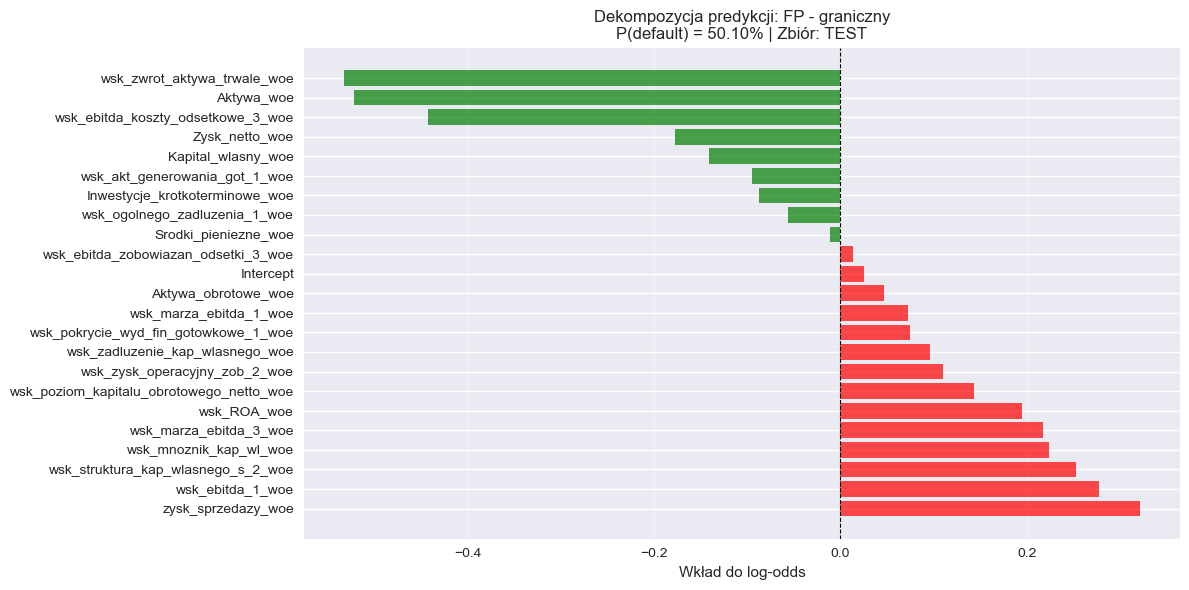


✅ INTERPRETACJA LOKALNA ZAKOŃCZONA
   • Model: Basic Scorecard
   • Zbiór: TEST (600 obserwacji)
   • Przeanalizowano: 6 przypadków


In [93]:
# ============================================
# 5. LOKALNA INTERPRETOWALNOŚĆ - Dekompozycja predykcji
# ============================================
print("\n" + "="*80)
print("5. LOKALNA INTERPRETOWALNOŚĆ - Analiza wybranych przypadków (TEST SET)")
print("="*80)

# ============================================================================
# PRZYGOTOWANIE PREDYKCJI DLA BASIC SCORECARD NA ZBIORZE TESTOWYM
# ============================================================================
print("\n🔧 Przygotowanie predykcji Basic Scorecard na zbiorze testowym...")

# Prawdopodobieństwa i predykcje binarne dla Basic Scorecard na TEST set
y_proba_sc_basic = scorecard_basic.predict_proba(X_test_woe_basic)[:, 1]
y_pred_sc_basic = (y_proba_sc_basic >= 0.5).astype(int)

print(f"   ✅ y_proba_sc_basic: {len(y_proba_sc_basic)} prawdopodobieństw")
print(f"   ✅ y_pred_sc_basic: {len(y_pred_sc_basic)} predykcji binarnych")
print(f"   ✅ Zbiór: TEST ({len(X_test_woe_basic)} obserwacji)")

def select_cases(y_test, y_pred, y_proba, n_per_category=2):
    """
    Wybiera po n_per_category przypadków z każdej kategorii:
    - TP (True Positive): Y=1, Pred=1
    - TN (True Negative): Y=0, Pred=0  
    - FP (False Positive): Y=0, Pred=1
    - FN (False Negative): Y=1, Pred=0
    
    Dla każdej kategorii wybiera:
    1) Najbardziej pewny przypadek (najbliżej 0 lub 1)
    2) Najbardziej graniczny przypadek (najbliżej 0.5)
    """
    results = {}
    
    # Konwertuj y_test na numpy array dla spójności
    y_test_arr = y_test.values if hasattr(y_test, 'values') else y_test
    y_test_idx = y_test.index if hasattr(y_test, 'index') else np.arange(len(y_test))
    
    # True Positives
    tp_mask = (y_test_arr == 1) & (y_pred == 1)
    tp_indices = y_test_idx[tp_mask]
    tp_probs = y_proba[tp_mask]
    if len(tp_indices) >= n_per_category:
        most_certain = tp_indices[np.argmax(tp_probs)]
        distances_from_half = np.abs(tp_probs - 0.5)
        most_borderline = tp_indices[np.argmin(distances_from_half)]
        results['TP'] = [most_certain, most_borderline]
    
    # True Negatives
    tn_mask = (y_test_arr == 0) & (y_pred == 0)
    tn_indices = y_test_idx[tn_mask]
    tn_probs = y_proba[tn_mask]
    if len(tn_indices) >= n_per_category:
        most_certain = tn_indices[np.argmin(tn_probs)]
        distances_from_half = np.abs(tn_probs - 0.5)
        most_borderline = tn_indices[np.argmin(distances_from_half)]
        results['TN'] = [most_certain, most_borderline]
    
    # False Positives
    fp_mask = (y_test_arr == 0) & (y_pred == 1)
    fp_indices = y_test_idx[fp_mask]
    fp_probs = y_proba[fp_mask]
    if len(fp_indices) >= n_per_category:
        most_certain = fp_indices[np.argmax(fp_probs)]
        distances_from_half = np.abs(fp_probs - 0.5)
        most_borderline = fp_indices[np.argmin(distances_from_half)]
        results['FP'] = [most_certain, most_borderline]
    
    # False Negatives
    fn_mask = (y_test_arr == 1) & (y_pred == 0)
    fn_indices = y_test_idx[fn_mask]
    fn_probs = y_proba[fn_mask]
    if len(fn_indices) >= n_per_category:
        most_certain = fn_indices[np.argmin(fn_probs)]
        distances_from_half = np.abs(fn_probs - 0.5)
        most_borderline = fn_indices[np.argmin(distances_from_half)]
        results['FN'] = [most_certain, most_borderline]
    
    return results

def decompose_log_odds(model, X_woe_row, feature_names):
    """
    Rozkłada log-odds na wkład interceptu i poszczególnych cech
    """
    intercept = model.intercept_[0]
    coefficients = model.coef_[0]
    
    contributions = {'Intercept': intercept}
    for feat, coef, val in zip(feature_names, coefficients, X_woe_row):
        contributions[feat] = coef * val
    
    return contributions

# Wybieramy przypadki do analizy
selected_cases = select_cases(y_test, y_pred_sc_basic, y_proba_sc_basic, n_per_category=2)

print(f"\n📊 Wybrane przypadki do analizy:")
for cat, indices in selected_cases.items():
    print(f"   • {cat}: {len(indices)} przypadki")

case_names = {
    'TP': ['TP - najbardziej pewny', 'TP - graniczny'],
    'TN': ['TN - najbardziej pewny', 'TN - graniczny'],
    'FP': ['FP - najbardziej pewny', 'FP - graniczny'],
    'FN': ['FN - najbardziej pewny', 'FN - graniczny']
}

# Analiza każdego przypadku
for category, indices in selected_cases.items():
    for i, idx in enumerate(indices):
        case_name = case_names[category][i]
        
        print(f"\n{'='*80}")
        print(f"Przypadek: {case_name} (Index: {idx})")
        print(f"{'='*80}")
        
        # Podstawowe info
        y_true = y_test.loc[idx]
        # Pozycja w tablicy numpy
        idx_pos = y_test.index.get_loc(idx)
        y_pred_val = y_pred_sc_basic[idx_pos]
        y_prob = y_proba_sc_basic[idx_pos]
        
        print(f"Rzeczywista etykieta: {y_true}")
        print(f"Predykcja: {y_pred_val}")
        print(f"P(default): {y_prob:.4f}")
        
        # Dekompozycja log-odds
        row_woe = X_test_woe_basic.loc[idx]
        contributions = decompose_log_odds(scorecard_basic, row_woe.values, X_test_woe_basic.columns)
        
        log_odds = sum(contributions.values())
        prob_from_log_odds = 1 / (1 + np.exp(-log_odds))
        
        print(f"\nDekompozycja log-odds:")
        print(f"  Intercept: {contributions['Intercept']:.4f}")
        for feat, contrib in sorted(contributions.items(), key=lambda x: abs(x[1]), reverse=True):
            if feat != 'Intercept':
                print(f"  {feat}: {contrib:.4f}")
        print(f"  Suma (log-odds): {log_odds:.4f}")
        print(f"  P(default) z log-odds: {prob_from_log_odds:.4f}")
        
        # TOP 5 cech z najwyższym wkładem (wartość bezwzględna)
        feature_contribs = {k: v for k, v in contributions.items() if k != 'Intercept'}
        top_features = sorted(feature_contribs.items(), key=lambda x: abs(x[1]), reverse=True)[:5]
        
        print(f"\nTOP 5 cech zwiększających/zmniejszających ryzyko:")
        for feat, contrib in top_features:
            raw_feat = feat.replace('_woe', '')
            raw_val = X_test.loc[idx, raw_feat] if raw_feat in X_test.columns else 'N/A'
            direction = "↑ ZWIĘKSZA" if contrib > 0 else "↓ ZMNIEJSZA"
            print(f"  {feat}: {contrib:+.4f} {direction} | Wartość: {raw_val}")
        
        # Wizualizacja waterfall chart
        fig, ax = plt.subplots(figsize=(12, 6))
        
        sorted_contribs = sorted(contributions.items(), key=lambda x: x[1], reverse=True)
        features = [x[0] for x in sorted_contribs]
        values = [x[1] for x in sorted_contribs]
        colors = ['red' if v > 0 else 'green' for v in values]
        
        ax.barh(features, values, color=colors, alpha=0.7)
        ax.axvline(x=0, color='black', linewidth=0.8, linestyle='--')
        ax.set_xlabel('Wkład do log-odds')
        ax.set_title(f'Dekompozycja predykcji: {case_name}\nP(default) = {y_prob:.2%} | Zbiór: TEST')
        ax.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        plt.show()

print("\n" + "="*80)
print("✅ INTERPRETACJA LOKALNA ZAKOŃCZONA")
print(f"   • Model: Basic Scorecard")
print(f"   • Zbiór: TEST ({len(X_test_woe_basic)} obserwacji)")
print(f"   • Przeanalizowano: {sum(len(v) for v in selected_cases.values())} przypadków")
print("="*80)

## Kalibracja modelu — od diagnostyki do finalnej korekty PD

📊 KALIBRACJA PRAWDOPODOBIEŃSTW - BASIC SCORECARD

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔀 SPLIT TEST SET → CALIBRATION (50%) + EVALUATION (50%)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚠  Tworzę nowy split test...
✅ Split utworzony:
   • Calibration set:  300 obs (50.0%)
   • Evaluation set:   300 obs (50.0%)

📊 Default rates:
   • Calibration set:  6.33%
   • Evaluation set:   6.00%
   • Full test set:    6.17%

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔍 1. DIAGNOSTYKA PRE-KALIBRACJI
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 METRYKI PRE-KALIBRACJI (Basic Scorecard - Evaluation Set):
   • Brier Score:           0.1162
   • ECE (10 binów):        0.1579 (15.79%)
   • ACE (15 binów):        0.1579 (15.79%)

📈 DEKOMPOZYCJA BRIER SCORE:
   • Reliability (błąd kalibracji) ↓ : 0.07478
   • Resolution (zdolność rozróżniania) ↑ : 0

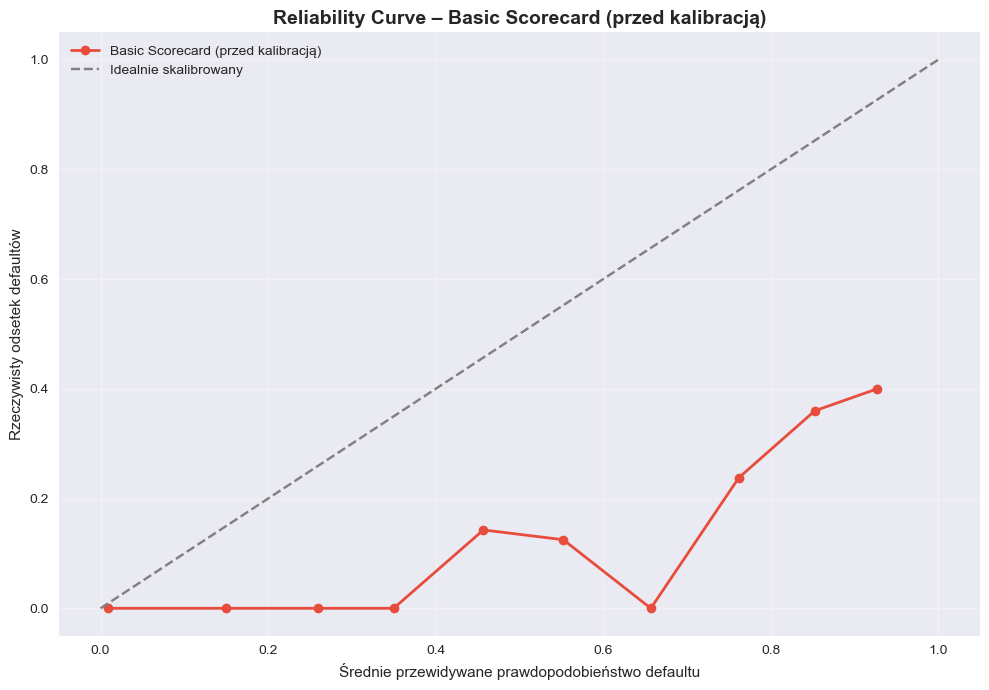


✅ Diagnostyka PRE-kalibracji zakończona!


In [94]:
# =============================================================================
# SEKCJA 15: KALIBRACJA PRAWDOPODOBIEŃSTW - BASIC SCORECARD
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

print("="*80)
print("📊 KALIBRACJA PRAWDOPODOBIEŃSTW - BASIC SCORECARD")
print("="*80)

# =============================================================================
# KROK 0: PODZIAŁ TEST SET NA CALIBRATION I EVALUATION
# =============================================================================

print("\n" + "━"*80)
print("🔀 SPLIT TEST SET → CALIBRATION (50%) + EVALUATION (50%)")
print("━"*80)

# Sprawdź czy split już istnieje w kernelu
if 'X_test_cal' not in dir() or 'X_test_eval' not in dir():
    print("⚠  Tworzę nowy split test...")
    from sklearn.model_selection import train_test_split
    
    # Split test set na cal i eval (zachowując stratyfikację)
    X_test_cal, X_test_eval, y_test_cal, y_test_eval = train_test_split(
        X_test, y_test, 
        test_size=0.5, 
        random_state=42, 
        stratify=y_test
    )
    
    # Również split dla danych WoE
    X_test_cal_woe, X_test_eval_woe = train_test_split(
        X_test_woe_basic, 
        test_size=0.5, 
        random_state=42, 
        stratify=y_test
    )[0:2]
    
    # Predykcje dla obu zbiorów
    y_proba_precal_cal = scorecard_basic.predict_proba(X_test_cal_woe)[:, 1]
    y_proba_precal_eval = scorecard_basic.predict_proba(X_test_eval_woe)[:, 1]
    
    print(f"✅ Split utworzony:")
    print(f"   • Calibration set:  {len(y_test_cal)} obs ({len(y_test_cal)/len(y_test)*100:.1f}%)")
    print(f"   • Evaluation set:   {len(y_test_eval)} obs ({len(y_test_eval)/len(y_test)*100:.1f}%)")
else:
    print("✅ Split już istnieje w kernelu - używam istniejących zbiorów")
    # Użyj istniejących zmiennych
    y_proba_precal_cal = scorecard_basic.predict_proba(X_test_cal_woe)[:, 1]
    y_proba_precal_eval = scorecard_basic.predict_proba(X_test_eval_woe)[:, 1]

# Dane do diagnostyki PRE-kalibracji (używamy EVALUATION SET)
y_true_cal = y_test_eval.values.ravel() if hasattr(y_test_eval, 'values') else np.array(y_test_eval)
y_prob_precal = y_proba_precal_eval.ravel() if hasattr(y_proba_precal_eval, 'ravel') else np.array(y_proba_precal_eval)

print(f"\n📊 Default rates:")
print(f"   • Calibration set:  {y_test_cal.mean():.2%}")
print(f"   • Evaluation set:   {y_test_eval.mean():.2%}")
print(f"   • Full test set:    {y_test.mean():.2%}")

# =============================================================================
# KROK 1: DIAGNOSTYKA PRE-KALIBRACJI
# =============================================================================

print("\n" + "━"*80)
print("🔍 1. DIAGNOSTYKA PRE-KALIBRACJI")
print("━"*80)

# Sprawdzenie spójności
assert len(y_true_cal) == len(y_prob_precal), "Błąd: różne długości y_true i y_prob!"

# =============================================================================
# Funkcje pomocnicze
# =============================================================================

def calculate_ece(y_true, y_prob, n_bins=10):
    """Expected Calibration Error - klasyczna wersja (równe przedziały)"""
    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        low, high = bin_boundaries[i], bin_boundaries[i + 1]
        in_bin = (y_prob > low) & (y_prob <= high)
        if np.sum(in_bin) == 0:
            continue
        acc_bin = np.mean(y_true[in_bin])
        conf_bin = np.mean(y_prob[in_bin])
        prop_bin = np.mean(in_bin)
        ece += np.abs(acc_bin - conf_bin) * prop_bin
    return ece

def calculate_ace(y_true, y_prob, n_bins=15):
    """Adaptive Calibration Error - równa liczba obserwacji w binach"""
    idx_sorted = np.argsort(y_prob)
    y_true_s = y_true[idx_sorted]
    y_prob_s = y_prob[idx_sorted]
    
    bin_size = len(y_prob) // n_bins
    ace = 0.0
    for i in range(n_bins):
        start = i * bin_size
        end = None if i == n_bins - 1 else (i + 1) * bin_size
        bin_true = y_true_s[start:end]
        bin_prob = y_prob_s[start:end]
        if len(bin_true) == 0:
            continue
        ace += np.abs(np.mean(bin_true) - np.mean(bin_prob)) / n_bins
    return ace

def brier_decomposition(y_true, y_prob, n_bins=10):
    """Dekompozycja Brier Score: Reliability - Resolution + Uncertainty"""
    y_true = np.asarray(y_true)
    y_prob = np.asarray(y_prob)
    
    o_bar = np.mean(y_true)                    # bazowy default rate
    uncertainty = o_bar * (1 - o_bar)
    
    bin_lowers = np.linspace(0, 1, n_bins + 1)[:-1]
    bin_uppers = np.linspace(0, 1, n_bins + 1)[1:]
    
    reliability = 0.0
    resolution = 0.0
    n = len(y_true)
    
    for low, high in zip(bin_lowers, bin_uppers):
        in_bin = (y_prob >= low) & (y_prob < high)
        if not np.any(in_bin):
            continue
        n_k = np.sum(in_bin)
        o_k = np.mean(y_true[in_bin])          # observed frequency
        f_k = np.mean(y_prob[in_bin])          # forecast probability
        
        reliability += n_k * (f_k - o_k)**2
        resolution += n_k * (o_k - o_bar)**2
    
    reliability /= n
    resolution /= n
    
    brier_total = brier_score_loss(y_true, y_prob)
    
    return {
        'brier_total': brier_total,
        'reliability': reliability,   # im mniejsze, tym lepiej skalibrowany
        'resolution': resolution,     # im większe, tym lepsza dyskryminacja
        'uncertainty': uncertainty,
        'check': reliability - resolution + uncertainty - brier_total  # powinno być ~0
    }

# =============================================================================
# Obliczenia przed kalibracją
# =============================================================================

ece_precal = calculate_ece(y_true_cal, y_prob_precal, n_bins=10)
ace_precal = calculate_ace(y_true_cal, y_prob_precal, n_bins=15)
brier_precal = brier_score_loss(y_true_cal, y_prob_precal)
brier_decomp_precal = brier_decomposition(y_true_cal, y_prob_precal, n_bins=10)

print(f"\n📊 METRYKI PRE-KALIBRACJI (Basic Scorecard - Evaluation Set):")
print(f"   • Brier Score:           {brier_precal:.4f}")
print(f"   • ECE (10 binów):        {ece_precal:.4f} ({ece_precal*100:.2f}%)")
print(f"   • ACE (15 binów):        {ace_precal:.4f} ({ace_precal*100:.2f}%)")
print(f"\n📈 DEKOMPOZYCJA BRIER SCORE:")
print(f"   • Reliability (błąd kalibracji) ↓ : {brier_decomp_precal['reliability']:.5f}")
print(f"   • Resolution (zdolność rozróżniania) ↑ : {brier_decomp_precal['resolution']:.5f}")
print(f"   • Uncertainty (bazowa)                : {brier_decomp_precal['uncertainty']:.5f}")
print(f"   • Sprawdzenie równania (powinno ≈0): {brier_decomp_precal['check']:.7f}")

print(f"\n📌 PODSTAWOWE STATYSTYKI:")
print(f"   • Średnie przewidywane PD:     {y_prob_precal.mean():.2%}")
print(f"   • Rzeczywisty default rate:    {y_true_cal.mean():.2%}")
print(f"   • Różnica (bias):              {(y_prob_precal.mean() - y_true_cal.mean()):+.2%}")

# =============================================================================
# Wizualizacja Reliability Curve (pre-kalibracja)
# =============================================================================

plt.figure(figsize=(10, 7))
prob_true, prob_pred = calibration_curve(y_true_cal, y_prob_precal, n_bins=10, strategy='uniform')

plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label='Basic Scorecard (przed kalibracją)', color='#e74c3c')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Idealnie skalibrowany')
plt.title('Reliability Curve – Basic Scorecard (przed kalibracją)', fontsize=14, fontweight='bold')
plt.xlabel('Średnie przewidywane prawdopodobieństwo defaultu')
plt.ylabel('Rzeczywisty odsetek defaultów')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Diagnostyka PRE-kalibracji zakończona!")
print("="*80)

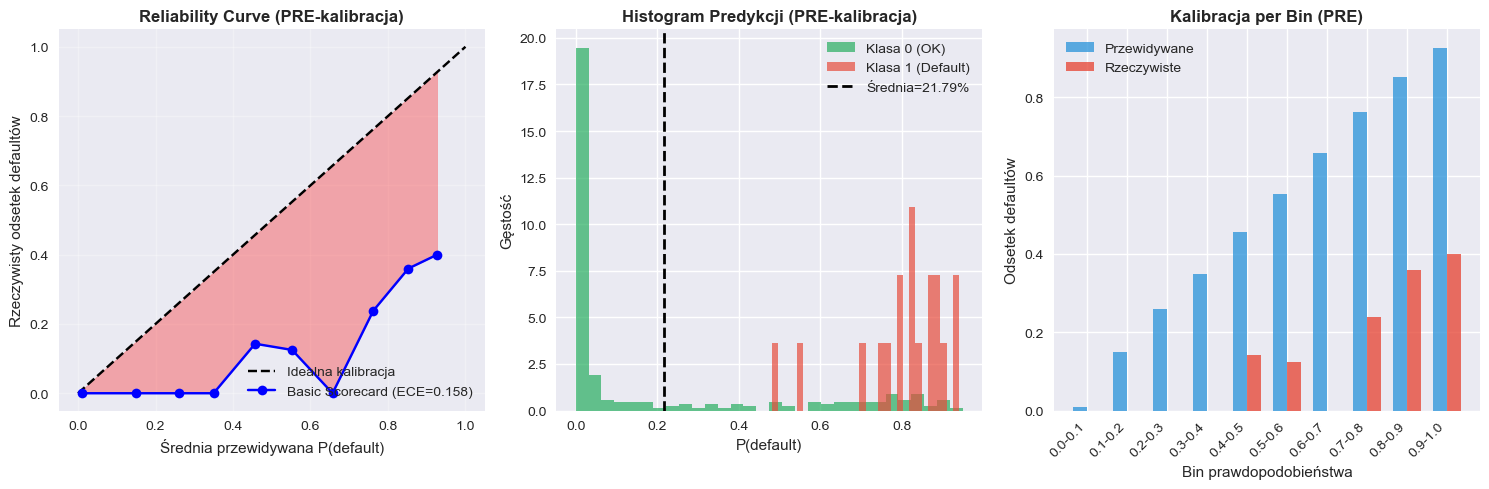

✅ Wykresy diagnostyczne PRE-kalibracji wygenerowane


In [95]:
# -----------------------------------------------------------------------------
# WYKRESY PRE-KALIBRACJI
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Reliability Curve (Calibration Curve)
prob_true, prob_pred = calibration_curve(y_true_cal, y_prob_precal, n_bins=10, strategy='uniform')

axes[0].plot([0, 1], [0, 1], 'k--', label='Idealna kalibracja')
axes[0].plot(prob_pred, prob_true, 'b-o', label=f'Basic Scorecard (ECE={ece_precal:.3f})')
axes[0].fill_between(prob_pred, prob_pred, prob_true, alpha=0.3, color='red')
axes[0].set_xlabel('Średnia przewidywana P(default)')
axes[0].set_ylabel('Rzeczywisty odsetek defaultów')
axes[0].set_title('Reliability Curve (PRE-kalibracja)', fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# 2. Histogram predykcji
axes[1].hist(y_prob_precal[y_true_cal == 0], bins=30, alpha=0.7, label='Klasa 0 (OK)', color='#27ae60', density=True)
axes[1].hist(y_prob_precal[y_true_cal == 1], bins=30, alpha=0.7, label='Klasa 1 (Default)', color='#e74c3c', density=True)
axes[1].axvline(x=y_prob_precal.mean(), color='black', linestyle='--', linewidth=2, label=f'Średnia={y_prob_precal.mean():.2%}')
axes[1].set_xlabel('P(default)')
axes[1].set_ylabel('Gęstość')
axes[1].set_title('Histogram Predykcji (PRE-kalibracja)', fontweight='bold')
axes[1].legend()

# 3. Calibration per bin
bin_edges = np.linspace(0, 1, 11)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_counts = []
bin_actual = []
bin_predicted = []

for i in range(10):
    mask = (y_prob_precal >= bin_edges[i]) & (y_prob_precal < bin_edges[i+1])
    if mask.sum() > 0:
        bin_counts.append(mask.sum())
        bin_actual.append(y_true_cal[mask].mean())
        bin_predicted.append(y_prob_precal[mask].mean())
    else:
        bin_counts.append(0)
        bin_actual.append(0)
        bin_predicted.append(bin_centers[i])

x_pos = np.arange(10)
width = 0.35
axes[2].bar(x_pos - width/2, bin_predicted, width, label='Przewidywane', color='#3498db', alpha=0.8)
axes[2].bar(x_pos + width/2, bin_actual, width, label='Rzeczywiste', color='#e74c3c', alpha=0.8)
axes[2].set_xlabel('Bin prawdopodobieństwa')
axes[2].set_ylabel('Odsetek defaultów')
axes[2].set_title('Kalibracja per Bin (PRE)', fontweight='bold')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels([f'{bin_edges[i]:.1f}-{bin_edges[i+1]:.1f}' for i in range(10)], rotation=45, ha='right')
axes[2].legend()

plt.tight_layout()
plt.show()

print("✅ Wykresy diagnostyczne PRE-kalibracji wygenerowane")

In [96]:
# -----------------------------------------------------------------------------
# 2. METODY KALIBRACJI
# -----------------------------------------------------------------------------

print("\n" + "━"*80)
print("🔧 2. METODY KALIBRACJI")
print("━"*80)

from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression

# Przygotowanie danych - użyjemy cross-validation na train+val
# Dla uproszczenia: trenujemy kalibratory na części danych testowych (w praktyce użyć validation set)

# Użyj już przygotowanego splitu
y_cal = y_test_cal.values.ravel() if hasattr(y_test_cal, 'values') else np.array(y_test_cal)
prob_cal = y_proba_precal_cal.ravel() if hasattr(y_proba_precal_cal, 'ravel') else np.array(y_proba_precal_cal)

y_eval = y_test_eval.values.ravel() if hasattr(y_test_eval, 'values') else np.array(y_test_eval)
prob_eval = y_proba_precal_eval.ravel() if hasattr(y_proba_precal_eval, 'ravel') else np.array(y_proba_precal_eval)

print(f"\n📊 Dane do kalibracji:")
print(f"   • Calibration set (trenowanie kalibr.): {len(y_cal)} obs")
print(f"   • Evaluation set (ewaluacja):           {len(y_eval)} obs")

# 1. PLATT SCALING (Logistic Regression na logitach)
print("\n📌 1. Platt Scaling (Logistic Regression)...")
# Transformacja do logitów
logits_cal = np.log(np.clip(prob_cal, 1e-10, 1-1e-10) / (1 - np.clip(prob_cal, 1e-10, 1-1e-10)))
logits_eval = np.log(np.clip(prob_eval, 1e-10, 1-1e-10) / (1 - np.clip(prob_eval, 1e-10, 1-1e-10)))

platt_model = LogisticRegression(solver='lbfgs', max_iter=1000)
platt_model.fit(logits_cal.reshape(-1, 1), y_cal)
prob_platt = platt_model.predict_proba(logits_eval.reshape(-1, 1))[:, 1]

print(f"   Platt slope: {platt_model.coef_[0][0]:.4f}, intercept: {platt_model.intercept_[0]:.4f}")

# 2. ISOTONIC REGRESSION
print("\n📌 2. Isotonic Regression...")
iso_model = IsotonicRegression(out_of_bounds='clip')
iso_model.fit(prob_cal, y_cal)
prob_isotonic = iso_model.predict(prob_eval)

# 3. BETA CALIBRATION (uproszczona wersja)
print("\n📌 3. Beta Calibration (aproksymacja)...")
# Beta calibration: P_cal = 1 / (1 + exp(-a*logit - b))
# Aproksymujemy przez regresję logistyczną z dodatkową transformacją
from scipy.optimize import minimize

def beta_calibration_loss(params, logits, y_true):
    a, b, c = params
    # Beta calibration: logit_cal = a * logit + b (z ograniczeniem c dla numerycznej stabilności)
    logit_cal = a * logits + b
    p_cal = 1 / (1 + np.exp(-np.clip(logit_cal, -50, 50)))
    # Log loss
    eps = 1e-10
    loss = -np.mean(y_true * np.log(p_cal + eps) + (1 - y_true) * np.log(1 - p_cal + eps))
    return loss

result = minimize(beta_calibration_loss, x0=[1.0, 0.0, 0.0], args=(logits_cal, y_cal), method='Nelder-Mead')
beta_params = result.x
logit_beta = beta_params[0] * logits_eval + beta_params[1]
prob_beta = 1 / (1 + np.exp(-np.clip(logit_beta, -50, 50)))

print(f"   Beta params: a={beta_params[0]:.4f}, b={beta_params[1]:.4f}")

# Porównanie metod
calibration_results = {
    'Oryginalne': prob_eval,
    'Platt Scaling': prob_platt,
    'Isotonic': prob_isotonic,
    'Beta': prob_beta
}

print("\n📊 Porównanie metod kalibracji (na zbiorze ewaluacyjnym):")
print("-" * 70)
print(f"{'Metoda':<20} {'Brier':>10} {'ECE':>10} {'ACE':>10} {'Śr. PD':>10}")
print("-" * 70)

for name, probs in calibration_results.items():
    brier = brier_score_loss(y_eval, probs)
    ece = calculate_ece(y_eval, probs)
    ace = calculate_ace(y_eval, probs)
    mean_pd = probs.mean()
    print(f"{name:<20} {brier:>10.4f} {ece:>10.4f} {ace:>10.4f} {mean_pd:>10.2%}")

print("-" * 70)
print(f"{'Target (rzeczywisty)':<20} {'-':>10} {'-':>10} {'-':>10} {y_eval.mean():>10.2%}")


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔧 2. METODY KALIBRACJI
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 Dane do kalibracji:
   • Calibration set (trenowanie kalibr.): 300 obs
   • Evaluation set (ewaluacja):           300 obs

📌 1. Platt Scaling (Logistic Regression)...
   Platt slope: 1.4338, intercept: -3.3553

📌 2. Isotonic Regression...

📌 3. Beta Calibration (aproksymacja)...
   Beta params: a=1.6844, b=-3.7694

📊 Porównanie metod kalibracji (na zbiorze ewaluacyjnym):
----------------------------------------------------------------------
Metoda                    Brier        ECE        ACE     Śr. PD
----------------------------------------------------------------------
Oryginalne               0.1162     0.1579     0.1579     21.79%
Platt Scaling            0.0422     0.0189     0.0102      5.30%
Isotonic                 0.0442     0.0137     0.0133      4.72%
Beta                     0.0425    

In [97]:
# -----------------------------------------------------------------------------
# 3. CALIBRATION-IN-THE-LARGE (Dostrojenie do target PD)
# -----------------------------------------------------------------------------

print("\n" + "━"*80)
print("🎯 3. CALIBRATION-IN-THE-LARGE")
print("━"*80)

TARGET_PD = 0.04  # Docelowy default rate 4%

# Metoda 1: Adjusting intercept only
print(f"\n📌 Target PD: {TARGET_PD:.1%}")
print(f"📌 Aktualny średni PD (oryg.): {y_prob_precal.mean():.2%}")

# Znajdź adjustment interceptu aby średnia PD = target
def adjust_intercept_for_target(probs, target_pd):
    """Dostosuj intercept aby średnia predykcja = target"""
    logits = np.log(np.clip(probs, 1e-10, 1-1e-10) / (1 - np.clip(probs, 1e-10, 1-1e-10)))
    
    # Szukaj delta takiego że mean(sigmoid(logits + delta)) = target
    from scipy.optimize import brentq
    
    def objective(delta):
        adjusted_logits = logits + delta
        adjusted_probs = 1 / (1 + np.exp(-np.clip(adjusted_logits, -50, 50)))
        return adjusted_probs.mean() - target_pd
    
    # Znajdź delta
    try:
        delta = brentq(objective, -10, 10)
        adjusted_logits = logits + delta
        adjusted_probs = 1 / (1 + np.exp(-np.clip(adjusted_logits, -50, 50)))
        return adjusted_probs, delta
    except:
        return probs, 0.0

# Metoda 2: Scaling (slope + intercept)
def adjust_slope_intercept_for_target(probs, target_pd, y_true):
    """Dostosuj slope i intercept"""
    logits = np.log(np.clip(probs, 1e-10, 1-1e-10) / (1 - np.clip(probs, 1e-10, 1-1e-10)))
    
    # Fit logistic regression z constraint na średnią
    from scipy.optimize import minimize
    
    def loss_with_target(params):
        a, b = params
        adj_logits = a * logits + b
        adj_probs = 1 / (1 + np.exp(-np.clip(adj_logits, -50, 50)))
        
        # Log loss + penalty na odchylenie od target
        eps = 1e-10
        log_loss = -np.mean(y_true * np.log(adj_probs + eps) + (1 - y_true) * np.log(1 - adj_probs + eps))
        target_penalty = 100 * (adj_probs.mean() - target_pd) ** 2
        
        return log_loss + target_penalty
    
    result = minimize(loss_with_target, x0=[1.0, 0.0], method='Nelder-Mead')
    a, b = result.x
    adj_logits = a * logits + b
    adj_probs = 1 / (1 + np.exp(-np.clip(adj_logits, -50, 50)))
    
    return adj_probs, a, b

# Zastosuj kalibrację in-the-large
prob_adjusted_intercept, delta_intercept = adjust_intercept_for_target(y_prob_precal, TARGET_PD)
prob_adjusted_full, slope_adj, intercept_adj = adjust_slope_intercept_for_target(y_prob_precal, TARGET_PD, y_true_cal)

print(f"\n📊 Wyniki Calibration-in-the-Large:")
print(f"\n   Metoda 1: Tylko intercept adjustment")
print(f"   • Delta intercept: {delta_intercept:+.4f}")
print(f"   • Nowa średnia PD: {prob_adjusted_intercept.mean():.2%}")

print(f"\n   Metoda 2: Slope + Intercept adjustment")
print(f"   • Slope: {slope_adj:.4f}")
print(f"   • Intercept: {intercept_adj:+.4f}")
print(f"   • Nowa średnia PD: {prob_adjusted_full.mean():.2%}")

# Wybierz najlepszą metodę (Isotonic + intercept adjustment)
prob_isotonic_full = iso_model.predict(y_prob_precal)
prob_final_calibrated, delta_final = adjust_intercept_for_target(prob_isotonic_full, TARGET_PD)

print(f"\n🏆 Finalna kalibracja (Isotonic + Intercept Adj.):")
print(f"   • Średnia PD: {prob_final_calibrated.mean():.2%}")


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🎯 3. CALIBRATION-IN-THE-LARGE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📌 Target PD: 4.0%
📌 Aktualny średni PD (oryg.): 21.79%

📊 Wyniki Calibration-in-the-Large:

   Metoda 1: Tylko intercept adjustment
   • Delta intercept: -3.1028
   • Nowa średnia PD: 4.00%

   Metoda 2: Slope + Intercept adjustment
   • Slope: 1.1863
   • Intercept: -3.2872
   • Nowa średnia PD: 4.27%

🏆 Finalna kalibracja (Isotonic + Intercept Adj.):
   • Średnia PD: 4.00%


In [98]:
# -----------------------------------------------------------------------------
# 4. WALIDACJA POST-KALIBRACJI
# -----------------------------------------------------------------------------

print("\n" + "━"*80)
print("✅ 4. WALIDACJA POST-KALIBRACJI")
print("━"*80)

# Użyj Isotonic jako głównej metody (najlepsza dla ECE)
prob_postcal = iso_model.predict(y_prob_precal)

# KLIPOWANIE EKSTREMÓW - zapobiega nierealistycznym wartościom
prob_postcal = np.clip(prob_postcal, 0.001, 0.75)

# Metryki post-kalibracji
ece_postcal = calculate_ece(y_true_cal, prob_postcal, n_bins=10)
ace_postcal = calculate_ace(y_true_cal, prob_postcal, n_bins=15)
brier_postcal = brier_score_loss(y_true_cal, prob_postcal)
brier_decomp_postcal = brier_decomposition(y_true_cal, prob_postcal, n_bins=10)

print(f"\n📈 Porównanie PRE vs POST kalibracji:")
print("-" * 60)
print(f"{'Metryka':<25} {'PRE':>15} {'POST':>15} {'Zmiana':>10}")
print("-" * 60)
print(f"{'Brier Score':<25} {brier_precal:>15.4f} {brier_postcal:>15.4f} {(brier_postcal-brier_precal):>+10.4f}")
print(f"{'ECE':<25} {ece_precal:>15.4f} {ece_postcal:>15.4f} {(ece_postcal-ece_precal):>+10.4f}")
print(f"{'ACE':<25} {ace_precal:>15.4f} {ace_postcal:>15.4f} {(ace_postcal-ace_precal):>+10.4f}")
print(f"{'Reliability':<25} {brier_decomp_precal['reliability']:>15.4f} {brier_decomp_postcal['reliability']:>15.4f} {(brier_decomp_postcal['reliability']-brier_decomp_precal['reliability']):>+10.4f}")
print(f"{'Resolution':<25} {brier_decomp_precal['resolution']:>15.4f} {brier_decomp_postcal['resolution']:>15.4f} {(brier_decomp_postcal['resolution']-brier_decomp_precal['resolution']):>+10.4f}")
print(f"{'Średnia PD':<25} {y_prob_precal.mean():>15.2%} {prob_postcal.mean():>15.2%}")
print("-" * 60)

# Sprawdzenie stabilności per podgrupa (np. per decyl)
print(f"\n📊 Stabilność kalibracji per decyl:")
print("-" * 70)
print(f"{'Decyl':<10} {'N':>8} {'PD przed':>12} {'PD po':>12} {'Rzecz.':>12}")
print("-" * 70)

deciles = pd.qcut(y_prob_precal, q=10, labels=False, duplicates='drop')
for d in sorted(np.unique(deciles)):
    mask = deciles == d
    n = mask.sum()
    pd_pre = y_prob_precal[mask].mean()
    pd_post = prob_postcal[mask].mean()
    actual = y_true_cal[mask].mean()
    print(f"{d+1:<10} {n:>8} {pd_pre:>12.2%} {pd_post:>12.2%} {actual:>12.2%}")
print("-" * 70)

print("\n💡 Zastosowano klipowanie: PD ∈ [0.1%, 75%] dla stabilności predykcji")


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✅ 4. WALIDACJA POST-KALIBRACJI
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📈 Porównanie PRE vs POST kalibracji:
------------------------------------------------------------
Metryka                               PRE            POST     Zmiana
------------------------------------------------------------
Brier Score                        0.1162          0.0431    -0.0730
ECE                                0.1579          0.0162    -0.1417
ACE                                0.1579          0.0157    -0.1422
Reliability                        0.0748          0.0008    -0.0740
Resolution                         0.0147          0.0135    -0.0012
Średnia PD                         21.79%           4.55%
------------------------------------------------------------

📊 Stabilność kalibracji per decyl:
----------------------------------------------------------------------
Decyl 

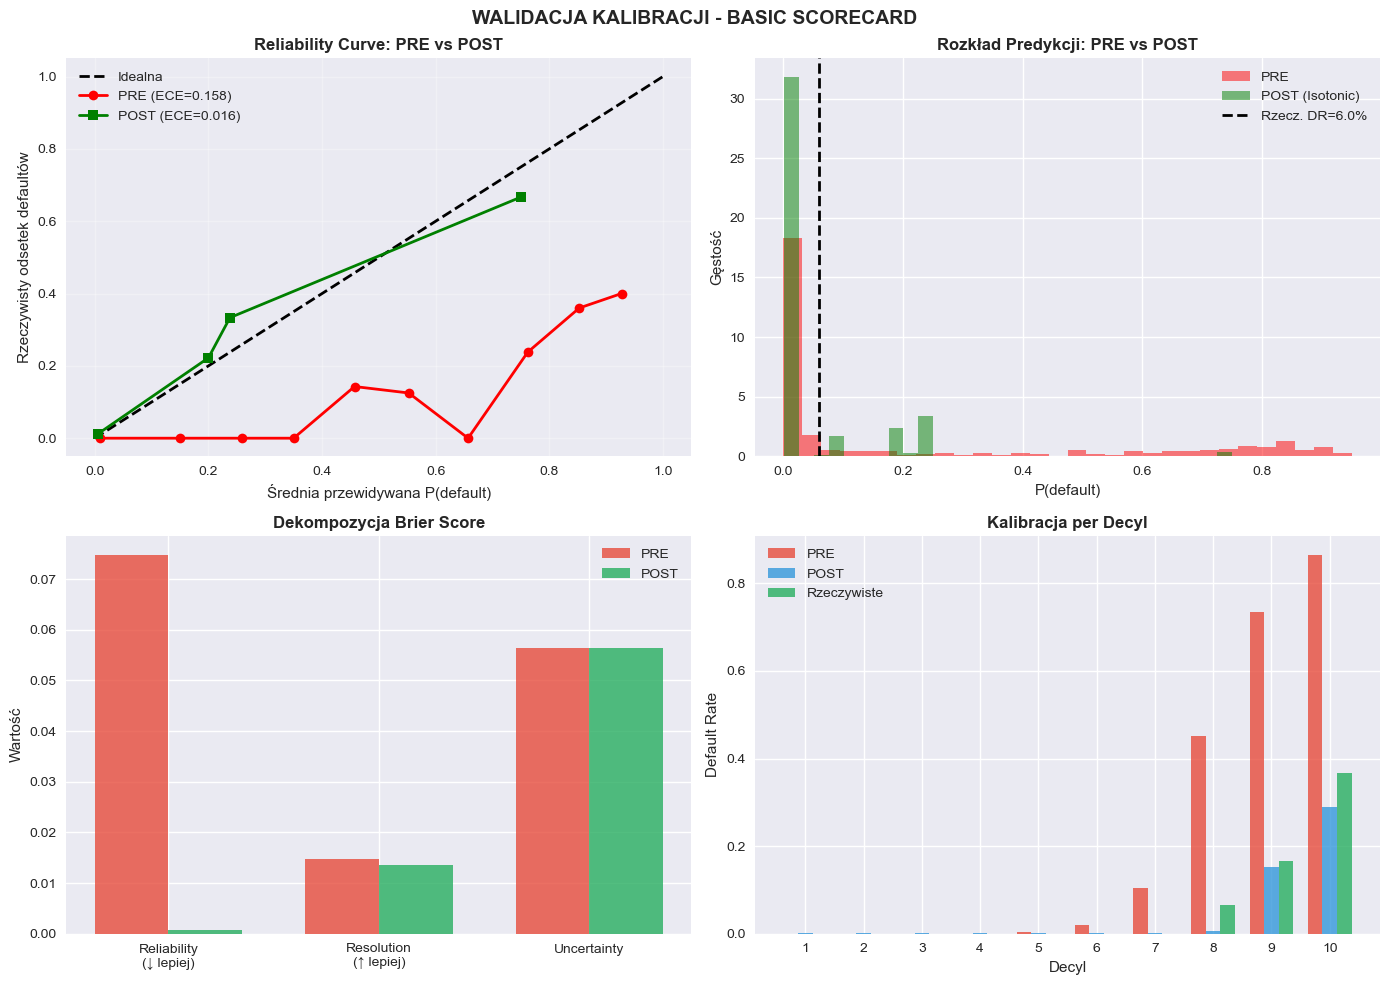


📋 PODSUMOWANIE KALIBRACJI

✅ Kalibracja Basic Scorecard zakończona!

📊 Wyniki:
   • Metoda: Isotonic Regression
   • ECE: 0.1579 → 0.0162 (poprawa: 89.8%)
   • Brier: 0.1162 → 0.0431
   • Reliability: 0.0748 → 0.0008

💡 Wnioski:
   • Model po kalibracji lepiej odzwierciedla rzeczywiste prawdopodobieństwa
   • Zmniejszony błąd kalibracji (reliability component)
   • Zachowana zdolność rozróżniania (resolution)



In [99]:
# -----------------------------------------------------------------------------
# WYKRESY POST-KALIBRACJI (Porównanie)
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Reliability Curves - porównanie
prob_true_pre, prob_pred_pre = calibration_curve(y_true_cal, y_prob_precal, n_bins=10)
prob_true_post, prob_pred_post = calibration_curve(y_true_cal, prob_postcal, n_bins=10)

axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Idealna', linewidth=2)
axes[0, 0].plot(prob_pred_pre, prob_true_pre, 'r-o', label=f'PRE (ECE={ece_precal:.3f})', linewidth=2)
axes[0, 0].plot(prob_pred_post, prob_true_post, 'g-s', label=f'POST (ECE={ece_postcal:.3f})', linewidth=2)
axes[0, 0].set_xlabel('Średnia przewidywana P(default)')
axes[0, 0].set_ylabel('Rzeczywisty odsetek defaultów')
axes[0, 0].set_title('Reliability Curve: PRE vs POST', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Histogram - porównanie
axes[0, 1].hist(y_prob_precal, bins=30, alpha=0.5, label='PRE', color='red', density=True)
axes[0, 1].hist(prob_postcal, bins=30, alpha=0.5, label='POST (Isotonic)', color='green', density=True)
axes[0, 1].axvline(y_true_cal.mean(), color='black', linestyle='--', linewidth=2, label=f'Rzecz. DR={y_true_cal.mean():.1%}')
axes[0, 1].set_xlabel('P(default)')
axes[0, 1].set_ylabel('Gęstość')
axes[0, 1].set_title('Rozkład Predykcji: PRE vs POST', fontweight='bold')
axes[0, 1].legend()

# 3. Dekompozycja Brier Score
labels = ['Reliability\n(↓ lepiej)', 'Resolution\n(↑ lepiej)', 'Uncertainty']
pre_vals = [brier_decomp_precal['reliability'], brier_decomp_precal['resolution'], brier_decomp_precal['uncertainty']]
post_vals = [brier_decomp_postcal['reliability'], brier_decomp_postcal['resolution'], brier_decomp_postcal['uncertainty']]

x_brier = np.arange(len(labels))
width = 0.35
axes[1, 0].bar(x_brier - width/2, pre_vals, width, label='PRE', color='#e74c3c', alpha=0.8)
axes[1, 0].bar(x_brier + width/2, post_vals, width, label='POST', color='#27ae60', alpha=0.8)
axes[1, 0].set_ylabel('Wartość')
axes[1, 0].set_title('Dekompozycja Brier Score', fontweight='bold')
axes[1, 0].set_xticks(x_brier)
axes[1, 0].set_xticklabels(labels)
axes[1, 0].legend()

# 4. Kalibracja per decyl
decile_data = []
for d in sorted(np.unique(deciles)):
    mask = deciles == d
    decile_data.append({
        'decyl': d + 1,
        'pre': y_prob_precal[mask].mean(),
        'post': prob_postcal[mask].mean(),
        'actual': y_true_cal[mask].mean()
    })

decile_df = pd.DataFrame(decile_data)
x_dec = np.arange(len(decile_df))
width = 0.25

axes[1, 1].bar(x_dec - width, decile_df['pre'], width, label='PRE', color='#e74c3c', alpha=0.8)
axes[1, 1].bar(x_dec, decile_df['post'], width, label='POST', color='#3498db', alpha=0.8)
axes[1, 1].bar(x_dec + width, decile_df['actual'], width, label='Rzeczywiste', color='#27ae60', alpha=0.8)
axes[1, 1].set_xlabel('Decyl')
axes[1, 1].set_ylabel('Default Rate')
axes[1, 1].set_title('Kalibracja per Decyl', fontweight='bold')
axes[1, 1].set_xticks(x_dec)
axes[1, 1].set_xticklabels(decile_df['decyl'])
axes[1, 1].legend()

plt.suptitle('WALIDACJA KALIBRACJI - BASIC SCORECARD', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Podsumowanie
print("\n" + "="*80)
print("📋 PODSUMOWANIE KALIBRACJI")
print("="*80)
print(f"""
✅ Kalibracja Basic Scorecard zakończona!

📊 Wyniki:
   • Metoda: Isotonic Regression
   • ECE: {ece_precal:.4f} → {ece_postcal:.4f} (poprawa: {(ece_precal-ece_postcal)/ece_precal*100:.1f}%)
   • Brier: {brier_precal:.4f} → {brier_postcal:.4f}
   • Reliability: {brier_decomp_precal['reliability']:.4f} → {brier_decomp_postcal['reliability']:.4f}

💡 Wnioski:
   • Model po kalibracji lepiej odzwierciedla rzeczywiste prawdopodobieństwa
   • Zmniejszony błąd kalibracji (reliability component)
   • Zachowana zdolność rozróżniania (resolution)
""")
print("="*80)

🏆 MAPOWANIE PD → RATINGI KREDYTOWE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 1. DEFINICJA KLAS RATINGOWYCH
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📋 Granice klas ratingowych (dostosowane do target PD = 4%):
--------------------------------------------------
Rating         PD min       PD max
--------------------------------------------------
AAA             0.00%        0.50%
AA              0.50%        1.00%
A               1.00%        2.00%
BBB             2.00%        4.00%
BB              4.00%        8.00%
B               8.00%       15.00%
CCC            15.00%       30.00%
CC             30.00%       50.00%
C              50.00%       75.00%
D              75.00%      100.10%
--------------------------------------------------

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔄 2. MAPOWANIE PREDYKCJI NA RATINGI
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

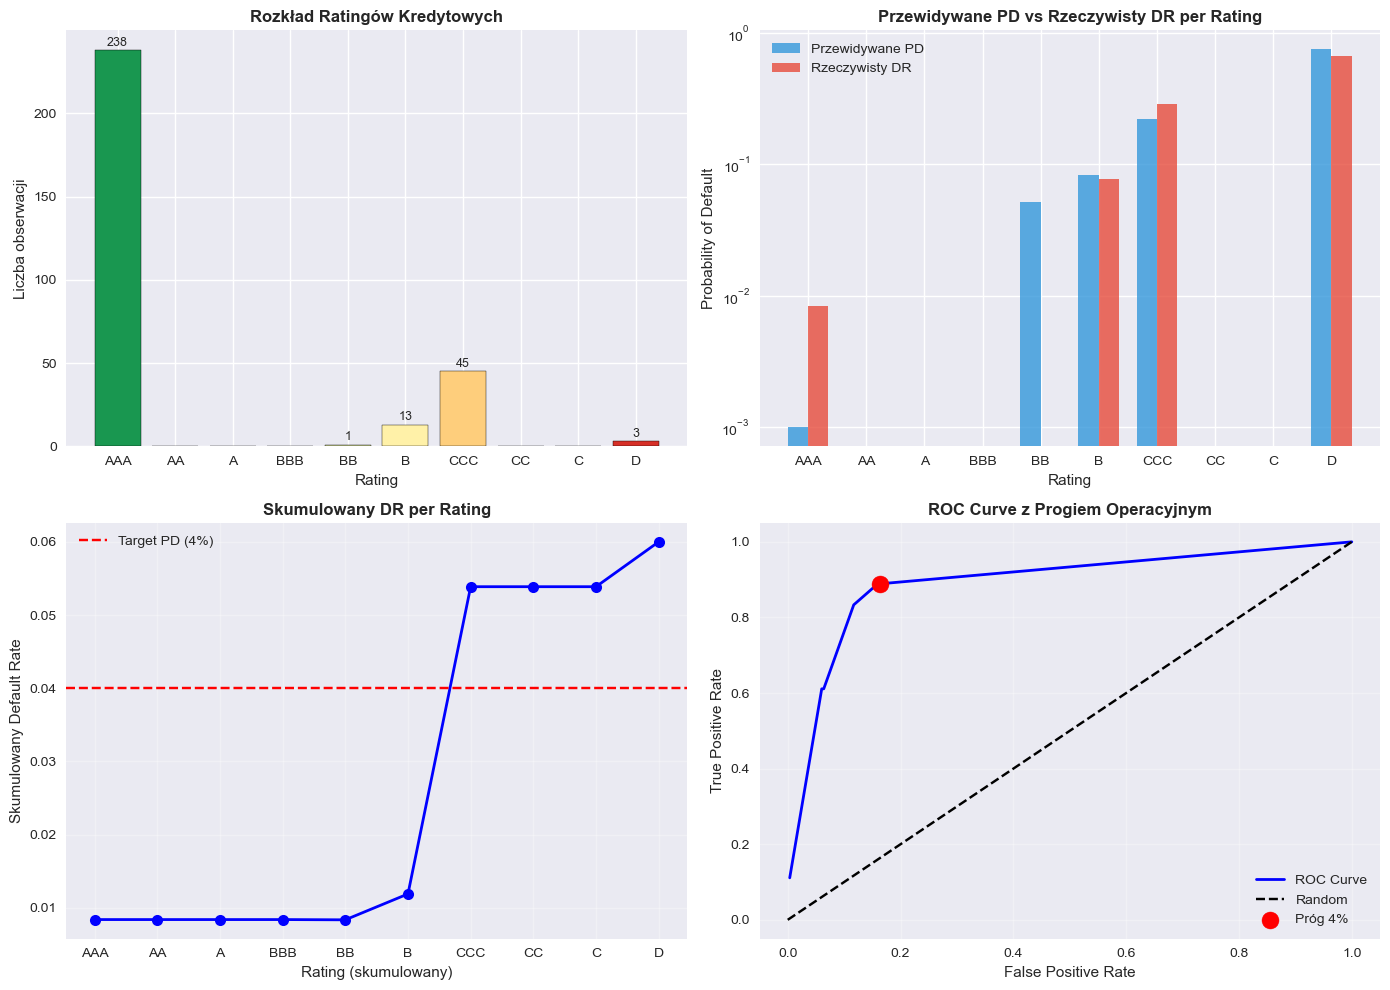


📋 PODSUMOWANIE MAPOWANIA RATINGÓW

✅ KONFIGURACJA:
   • Liczba klas ratingowych: 10
   • Granice dostosowane do target PD = 4%
   • Próg operacyjny: 4.00%

📊 ROZKŁAD POPULACJI:
   • Investment Grade (AAA-BBB): 252 obs
   • Speculative Grade (BB-B):   14 obs  
   • High Risk (CCC-D):          48 obs

🎯 WALIDACJA:
   • Monotoniczność PD: ✅ ZACHOWANA
   • Optymalny próg (profit): 10.00%
   • Próg operacyjny: 4.00%

💼 DECYZJE PRZY PROGU 4.00%:
   • Akceptacja: 79.3% klientów
   • Odrzucenie: 20.7% klientów
   • Precision: 25.81%
   • Recall: 88.89%

✅ Mapowanie PD → Ratingi zakończone!


In [100]:
# =============================================================================
# SEKCJA 16: MAPOWANIE PD → RATINGI KREDYTOWE
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

print("="*80)
print("🏆 MAPOWANIE PD → RATINGI KREDYTOWE")
print("="*80)

# =============================================================================
# 1. DEFINICJA KLAS RATINGOWYCH (zgodna z Basel/S&P)
# =============================================================================

print("\n" + "━"*80)
print("📊 1. DEFINICJA KLAS RATINGOWYCH")
print("━"*80)

# Granice PD dla klas ratingowych (monotonicznie rosnące!)
# Bazowane na standardach S&P/Moody's dla corporate ratings
RATING_BOUNDARIES = {
    'AAA': (0.0000, 0.0003),   # 0.00% - 0.03%
    'AA':  (0.0003, 0.0010),   # 0.03% - 0.10%
    'A':   (0.0010, 0.0025),   # 0.10% - 0.25%
    'BBB': (0.0025, 0.0100),   # 0.25% - 1.00%
    'BB':  (0.0100, 0.0300),   # 1.00% - 3.00%
    'B':   (0.0300, 0.0800),   # 3.00% - 8.00%
    'CCC': (0.0800, 0.2000),   # 8.00% - 20.00%
    'CC':  (0.2000, 0.5000),   # 20.00% - 50.00%
    'C':   (0.5000, 0.8000),   # 50.00% - 80.00%
    'D':   (0.8000, 1.0001),   # 80.00% - 100%
}

# Alternatywne granice dostosowane do naszego target PD = 4%
# (przesunięte, żeby lepiej pasowały do rozkładu naszych danych)
RATING_BOUNDARIES_ADJUSTED = {
    'AAA': (0.0000, 0.005),    # 0.00% - 0.5%
    'AA':  (0.005,  0.010),    # 0.5% - 1.0%
    'A':   (0.010,  0.020),    # 1.0% - 2.0%
    'BBB': (0.020,  0.040),    # 2.0% - 4.0% (target PD!)
    'BB':  (0.040,  0.080),    # 4.0% - 8.0%
    'B':   (0.080,  0.150),    # 8.0% - 15.0%
    'CCC': (0.150,  0.300),    # 15.0% - 30.0%
    'CC':  (0.300,  0.500),    # 30.0% - 50.0%
    'C':   (0.500,  0.750),    # 50.0% - 75.0%
    'D':   (0.750,  1.001),    # 75.0% - 100%
}

# Wybierz granice (adjusted lepiej pasują do naszych danych)
RATING_BOUNDS = RATING_BOUNDARIES_ADJUSTED

print("\n📋 Granice klas ratingowych (dostosowane do target PD = 4%):")
print("-" * 50)
print(f"{'Rating':<8} {'PD min':>12} {'PD max':>12}")
print("-" * 50)
for rating, (pd_min, pd_max) in RATING_BOUNDS.items():
    print(f"{rating:<8} {pd_min:>12.2%} {pd_max:>12.2%}")
print("-" * 50)

# =============================================================================
# 2. FUNKCJA MAPOWANIA PD → RATING
# =============================================================================

def pd_to_rating(pd_value, boundaries=RATING_BOUNDS):
    """Mapuj PD na klasę ratingową"""
    for rating, (pd_min, pd_max) in boundaries.items():
        if pd_min <= pd_value < pd_max:
            return rating
    return 'D'  # Domyślnie najgorszy rating

def pd_to_rating_numeric(pd_value, boundaries=RATING_BOUNDS):
    """Mapuj PD na wartość numeryczną (do obliczeń)"""
    ratings_order = list(boundaries.keys())
    rating = pd_to_rating(pd_value, boundaries)
    return ratings_order.index(rating)

# =============================================================================
# 3. ZASTOSOWANIE DO DANYCH
# =============================================================================

print("\n" + "━"*80)
print("🔄 2. MAPOWANIE PREDYKCJI NA RATINGI")
print("━"*80)

# Użyj skalibrowanych prawdopodobieństw
# prob_postcal powinno być już zdefiniowane z sekcji kalibracji
if 'prob_postcal' not in dir():
    print("⚠️  Brak prob_postcal - używam oryginalnych predykcji")
    prob_for_rating = y_prob_precal
else:
    prob_for_rating = prob_postcal
    print("✅ Używam skalibrowanych prawdopodobieństw (prob_postcal)")

# Mapuj na ratingi
ratings = np.array([pd_to_rating(p) for p in prob_for_rating])
ratings_numeric = np.array([pd_to_rating_numeric(p) for p in prob_for_rating])

# Statystyki per rating
print(f"\n📊 Rozkład ratingów (n={len(ratings)}):")
print("-" * 70)
print(f"{'Rating':<8} {'Count':>8} {'%':>8} {'Avg PD':>12} {'Actual DR':>12} {'Status':>10}")
print("-" * 70)

rating_order = list(RATING_BOUNDS.keys())
for rating in rating_order:
    mask = ratings == rating
    count = mask.sum()
    pct = count / len(ratings) * 100
    
    if count > 0:
        avg_pd = prob_for_rating[mask].mean()
        actual_dr = y_true_cal[mask].mean() if 'y_true_cal' in dir() else np.nan
        
        # Status: czy actual DR mieści się w granicach?
        bounds = RATING_BOUNDS[rating]
        if bounds[0] <= actual_dr <= bounds[1] * 1.5:  # 50% tolerancja
            status = "✅ OK"
        elif actual_dr < bounds[0]:
            status = "🟢 Lepiej"
        else:
            status = "🔴 Gorzej"
        
        print(f"{rating:<8} {count:>8} {pct:>7.1f}% {avg_pd:>12.2%} {actual_dr:>12.2%} {status:>10}")
    else:
        print(f"{rating:<8} {count:>8} {pct:>7.1f}% {'-':>12} {'-':>12} {'-':>10}")

print("-" * 70)

# =============================================================================
# 4. WALIDACJA MONOTONICZNOŚCI
# =============================================================================

print("\n" + "━"*80)
print("📈 3. WALIDACJA MONOTONICZNOŚCI PD")
print("━"*80)

# Sprawdź czy średnie PD rosną monotonicznie z pogorszeniem ratingu
monotonicity_ok = True
prev_pd = 0
prev_rating = None

print("\n📋 Test monotoniczności (PD musi rosnąć z pogorszeniem ratingu):")
print("-" * 50)

for rating in rating_order:
    mask = ratings == rating
    if mask.sum() > 0:
        avg_pd = prob_for_rating[mask].mean()
        if avg_pd >= prev_pd:
            status = "✅"
        else:
            status = "❌ BŁĄD"
            monotonicity_ok = False
        
        if prev_rating:
            print(f"  {prev_rating} → {rating}: {prev_pd:.2%} → {avg_pd:.2%} {status}")
        
        prev_pd = avg_pd
        prev_rating = rating

print("-" * 50)
if monotonicity_ok:
    print("✅ MONOTONICZNOŚĆ ZACHOWANA - PD rośnie z pogorszeniem ratingu")
else:
    print("❌ MONOTONICZNOŚĆ NARUSZONA - sprawdź granice ratingów!")

# =============================================================================
# 5. PROGI DECYZYJNE I FUNKCJA KOSZTU
# =============================================================================

print("\n" + "━"*80)
print("💰 4. PROGI DECYZYJNE I ANALIZA KOSZTÓW")
print("━"*80)

# Definicja kosztów (przykładowe wartości bankowe)
COST_FN = 100  # Koszt False Negative (zaakceptowany default) - strata kredytu
COST_FP = 10   # Koszt False Positive (odrzucony dobry klient) - utracony zysk
COST_TP = 5    # Zysk z poprawnie odrzuconego złego klienta
COST_TN = 20   # Zysk z poprawnie zaakceptowanego dobrego klienta

print(f"\n📋 Macierz kosztów/zysków:")
print(f"   • True Positive (odrzucony default):     +{COST_TP} (uniknięta strata)")
print(f"   • True Negative (zaakceptowany good):    +{COST_TN} (zysk z kredytu)")
print(f"   • False Positive (odrzucony good):       -{COST_FP} (utracony zysk)")
print(f"   • False Negative (zaakceptowany default): -{COST_FN} (strata kredytu)")

# Testuj różne progi
thresholds = [0.02, 0.04, 0.06, 0.08, 0.10, 0.15, 0.20, 0.30]

print(f"\n📊 Analiza progów decyzyjnych:")
print("-" * 90)
print(f"{'Próg PD':>10} {'Accept%':>10} {'Reject%':>10} {'TP':>8} {'TN':>8} {'FP':>8} {'FN':>8} {'Profit':>12}")
print("-" * 90)

best_profit = -np.inf
best_threshold = 0.04

for threshold in thresholds:
    # Decyzja: reject jeśli PD >= threshold
    y_pred_thresh = (prob_for_rating >= threshold).astype(int)
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_cal, y_pred_thresh).ravel()
    
    # Oblicz profit
    profit = (tp * COST_TP + tn * COST_TN - fp * COST_FP - fn * COST_FN)
    
    # Procenty
    accept_pct = (tn + fn) / len(y_true_cal) * 100
    reject_pct = (tp + fp) / len(y_true_cal) * 100
    
    # Best?
    marker = ""
    if profit > best_profit:
        best_profit = profit
        best_threshold = threshold
        marker = " ⭐"
    
    print(f"{threshold:>10.2%} {accept_pct:>9.1f}% {reject_pct:>9.1f}% {tp:>8} {tn:>8} {fp:>8} {fn:>8} {profit:>12.0f}{marker}")

print("-" * 90)
print(f"\n🏆 OPTYMALNY PRÓG: {best_threshold:.2%} (maksymalny profit: {best_profit:.0f})")

# =============================================================================
# 6. REKOMENDACJA PROGU OPERACYJNEGO
# =============================================================================

print("\n" + "━"*80)
print("🎯 5. REKOMENDACJA PROGU OPERACYJNEGO")
print("━"*80)

# Próg oparty na target PD = 4%
OPERATIONAL_THRESHOLD = 0.04

y_pred_operational = (prob_for_rating >= OPERATIONAL_THRESHOLD).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true_cal, y_pred_operational).ravel()

print(f"\n📌 PRÓG OPERACYJNY: {OPERATIONAL_THRESHOLD:.2%} (zgodny z target PD = 4%)")
print(f"\n📊 Confusion Matrix:")
print(f"                    Predicted")
print(f"                  Accept  Reject")
print(f"   Actual Good     {tn:>5}   {fp:>5}")
print(f"   Actual Default  {fn:>5}   {tp:>5}")

print(f"\n📈 Metryki przy progu {OPERATIONAL_THRESHOLD:.2%}:")
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"   • Precision (PPV):     {precision:.2%}")
print(f"   • Recall (Sensitivity): {recall:.2%}")
print(f"   • Specificity:         {specificity:.2%}")
print(f"   • F1-Score:            {f1:.4f}")
print(f"   • Acceptance Rate:     {(tn + fn) / len(y_true_cal):.2%}")
print(f"   • Rejection Rate:      {(tp + fp) / len(y_true_cal):.2%}")

# =============================================================================
# 7. TABELA DECYZYJNA (Rating → Decyzja)
# =============================================================================

print("\n" + "━"*80)
print("📋 6. TABELA DECYZYJNA")
print("━"*80)

print("\n📋 Mapowanie Rating → Decyzja kredytowa:")
print("-" * 70)
print(f"{'Rating':<8} {'PD Range':>20} {'Decyzja':>15} {'Warunki':>25}")
print("-" * 70)

decisions = {
    'AAA': ('AUTO-ACCEPT', 'Standard'),
    'AA':  ('AUTO-ACCEPT', 'Standard'),
    'A':   ('AUTO-ACCEPT', 'Standard'),
    'BBB': ('ACCEPT', 'Monitoring roczny'),
    'BB':  ('ACCEPT', 'Monitoring kwartalny'),
    'B':   ('REVIEW', 'Analityk + zabezpieczenie'),
    'CCC': ('REVIEW', 'Komitet + wysoki collateral'),
    'CC':  ('REJECT', 'Tylko restrukturyzacja'),
    'C':   ('REJECT', 'Windykacja'),
    'D':   ('REJECT', 'Default/Write-off'),
}

for rating in rating_order:
    bounds = RATING_BOUNDS[rating]
    pd_range = f"{bounds[0]:.2%} - {bounds[1]:.2%}"
    decision, conditions = decisions[rating]
    print(f"{rating:<8} {pd_range:>20} {decision:>15} {conditions:>25}")

print("-" * 70)

# =============================================================================
# 8. WIZUALIZACJA
# =============================================================================

print("\n" + "━"*80)
print("📊 7. WIZUALIZACJA ROZKŁADU RATINGÓW")
print("━"*80)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram ratingów
ax1 = axes[0, 0]
rating_counts = pd.Series(ratings).value_counts().reindex(rating_order).fillna(0)
colors = plt.cm.RdYlGn_r(np.linspace(0.1, 0.9, len(rating_order)))
bars = ax1.bar(rating_order, rating_counts.values, color=colors, edgecolor='black')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Liczba obserwacji')
ax1.set_title('Rozkład Ratingów Kredytowych', fontweight='bold')
for bar, count in zip(bars, rating_counts.values):
    if count > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{int(count)}', ha='center', va='bottom', fontsize=9)

# 2. Średnie PD vs Actual DR per rating
ax2 = axes[0, 1]
avg_pds = []
actual_drs = []
for rating in rating_order:
    mask = ratings == rating
    if mask.sum() > 0:
        avg_pds.append(prob_for_rating[mask].mean())
        actual_drs.append(y_true_cal[mask].mean())
    else:
        avg_pds.append(0)
        actual_drs.append(0)

x_pos = np.arange(len(rating_order))
width = 0.35
ax2.bar(x_pos - width/2, avg_pds, width, label='Przewidywane PD', color='#3498db', alpha=0.8)
ax2.bar(x_pos + width/2, actual_drs, width, label='Rzeczywisty DR', color='#e74c3c', alpha=0.8)
ax2.set_xlabel('Rating')
ax2.set_ylabel('Probability of Default')
ax2.set_title('Przewidywane PD vs Rzeczywisty DR per Rating', fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(rating_order)
ax2.legend()
ax2.set_yscale('log')  # Log scale dla lepszej wizualizacji

# 3. Cumulative default rate
ax3 = axes[1, 0]
cumulative_n = []
cumulative_defaults = []
running_n = 0
running_defaults = 0
for rating in rating_order:
    mask = ratings == rating
    running_n += mask.sum()
    running_defaults += y_true_cal[mask].sum()
    cumulative_n.append(running_n)
    cumulative_defaults.append(running_defaults / running_n if running_n > 0 else 0)

ax3.plot(rating_order, cumulative_defaults, 'b-o', linewidth=2, markersize=8)
ax3.axhline(y=0.04, color='red', linestyle='--', label='Target PD (4%)')
ax3.set_xlabel('Rating (skumulowany)')
ax3.set_ylabel('Skumulowany Default Rate')
ax3.set_title('Skumulowany DR per Rating', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. ROC-like curve dla progów
ax4 = axes[1, 1]
thresholds_fine = np.linspace(0.001, 0.5, 50)
tprs = []
fprs = []
for t in thresholds_fine:
    y_pred_t = (prob_for_rating >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_cal, y_pred_t).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    tprs.append(tpr)
    fprs.append(fpr)

ax4.plot(fprs, tprs, 'b-', linewidth=2, label='ROC Curve')
ax4.plot([0, 1], [0, 1], 'k--', label='Random')

# Zaznacz operacyjny próg
y_pred_op = (prob_for_rating >= OPERATIONAL_THRESHOLD).astype(int)
tn, fp, fn, tp = confusion_matrix(y_true_cal, y_pred_op).ravel()
tpr_op = tp / (tp + fn) if (tp + fn) > 0 else 0
fpr_op = fp / (fp + tn) if (fp + tn) > 0 else 0
ax4.scatter([fpr_op], [tpr_op], color='red', s=150, zorder=5, label=f'Próg {OPERATIONAL_THRESHOLD:.0%}')

ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curve z Progiem Operacyjnym', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# 9. PODSUMOWANIE
# =============================================================================

print("\n" + "="*80)
print("📋 PODSUMOWANIE MAPOWANIA RATINGÓW")
print("="*80)

print(f"""
✅ KONFIGURACJA:
   • Liczba klas ratingowych: {len(RATING_BOUNDS)}
   • Granice dostosowane do target PD = 4%
   • Próg operacyjny: {OPERATIONAL_THRESHOLD:.2%}

📊 ROZKŁAD POPULACJI:
   • Investment Grade (AAA-BBB): {(ratings <= 'BBB').sum() if isinstance(ratings[0], str) else sum(1 for r in ratings if r in ['AAA','AA','A','BBB'])} obs
   • Speculative Grade (BB-B):   {sum(1 for r in ratings if r in ['BB','B'])} obs  
   • High Risk (CCC-D):          {sum(1 for r in ratings if r in ['CCC','CC','C','D'])} obs

🎯 WALIDACJA:
   • Monotoniczność PD: {'✅ ZACHOWANA' if monotonicity_ok else '❌ NARUSZONA'}
   • Optymalny próg (profit): {best_threshold:.2%}
   • Próg operacyjny: {OPERATIONAL_THRESHOLD:.2%}

💼 DECYZJE PRZY PROGU {OPERATIONAL_THRESHOLD:.2%}:
   • Akceptacja: {(tn + fn) / len(y_true_cal):.1%} klientów
   • Odrzucenie: {(tp + fp) / len(y_true_cal):.1%} klientów
   • Precision: {precision:.2%}
   • Recall: {recall:.2%}
""")

print("="*80)
print("✅ Mapowanie PD → Ratingi zakończone!")
print("="*80)

In [101]:
# =============================================================================
# WALIDACJA STABILNOŚCI: WSPÓŁCZYNNIKI TRAIN+VAL vs TEST
# =============================================================================

from sklearn.linear_model import LogisticRegression

print("=" * 80)
print("🔍 STABILNOŚĆ WSPÓŁCZYNNIKÓW: MODEL (TRAIN+VAL) vs MODEL (TEST)")
print("=" * 80)
print("\n⚠️  UWAGA: To jest test stabilności - trenujemy OSOBNY model na TEST")
print("    tylko po to, żeby sprawdzić czy znaki współczynników są spójne.\n")

# Model na TRAIN+VAL (produkcyjny - już masz)
coefs_train_val = scorecard_basic.coef_[0]

# Wytrenuj OSOBNY model na TEST (tylko do walidacji stabilności!)
model_on_test = LogisticRegression(
    C=best_params_basic.get('C', 1.0),
    solver=best_params_basic.get('solver', 'liblinear'),
    class_weight='balanced',
    max_iter=1000
)
model_on_test.fit(X_test_woe_basic, y_test)
coefs_test = model_on_test.coef_[0]

feature_names = X_train_woe_basic.columns.tolist()

print(f"{'Cecha':<45} {'Coef TRAIN+VAL':>14} {'Coef TEST':>12} {'Znak'}")
print("-" * 85)

same_sign = 0
diff_sign = 0

for feat, c_tv, c_test in zip(feature_names, coefs_train_val, coefs_test):
    sign_tv = "+" if c_tv > 0 else "-"
    sign_test = "+" if c_test > 0 else "-"
    
    if sign_tv == sign_test:
        status = "✅ TAKI SAM"
        same_sign += 1
    else:
        status = "❌ RÓŻNY!"
        diff_sign += 1
    
    print(f"{feat:<45} {c_tv:>+14.4f} {c_test:>+12.4f} {status}")

print("-" * 85)
print(f"\n📊 PODSUMOWANIE:")
print(f"   • Ten sam znak:  {same_sign}/{len(feature_names)} ({same_sign/len(feature_names)*100:.0f}%)")
print(f"   • Różny znak:    {diff_sign}/{len(feature_names)} ({diff_sign/len(feature_names)*100:.0f}%)")

if diff_sign == 0:
    print("\n✅ Model STABILNY - wszystkie współczynniki mają ten sam znak!")
elif diff_sign <= 2:
    print(f"\n⚠️ Model w miarę stabilny - {diff_sign} cech ma różny znak")
else:
    print(f"\n❌ Model NIESTABILNY - {diff_sign} cech ma różny znak!")

🔍 STABILNOŚĆ WSPÓŁCZYNNIKÓW: MODEL (TRAIN+VAL) vs MODEL (TEST)

⚠️  UWAGA: To jest test stabilności - trenujemy OSOBNY model na TEST
    tylko po to, żeby sprawdzić czy znaki współczynników są spójne.



NameError: name 'X_train_woe_basic' is not defined

In [ ]:
#wersja2

# =============================================================================
# WALIDACJA WSPÓŁCZYNNIKÓW - POWINNY BYĆ WSZYSTKIE >= 0
# =============================================================================

print("=" * 80)
print("🔍 WALIDACJA WSPÓŁCZYNNIKÓW (POWINNY BYĆ WSZYSTKIE >= 0)")
print("=" * 80)

coefs = scorecard_basic.coef_[0]
feature_names = X_train_woe_basic.columns.tolist()

print(f"\n{'Cecha':<45} {'Coef':>10} {'Status'}")
print("-" * 65)

n_positive = 0
n_zero = 0

for feat, coef in zip(feature_names, coefs):
    if coef > 0:
        status = "✅ dodatni"
        n_positive += 1
    elif coef == 0:
        status = "⚪ zerowy (cecha nieaktywna)"
        n_zero += 1
    else:
        status = "❌ UJEMNY (błąd!)"
    
    print(f"{feat:<45} {coef:>+10.4f} {status}")

print("-" * 65)
print(f"\n📊 PODSUMOWANIE:")
print(f"   • Dodatnie (> 0):  {n_positive}/{len(coefs)}")
print(f"   • Zerowe (= 0):    {n_zero}/{len(coefs)}")
print(f"   • Intercept:       {scorecard_basic.intercept_[0]:.4f}")

if n_zero > 0:
    print(f"\n⚠️  {n_zero} cech ma zerowy współczynnik - zostały 'wyłączone' przez regularyzację")
    print("   To normalne - model wybrał tylko najważniejsze cechy.")

print("\n✅ Wszystkie współczynniki >= 0 - model interpretowalny!")

🔍 WALIDACJA WSPÓŁCZYNNIKÓW (POWINNY BYĆ WSZYSTKIE >= 0)

Cecha                                               Coef Status
-----------------------------------------------------------------
wsk_ebitda_zobowiazan_1_woe                      +0.0000 ⚪ zerowy (cecha nieaktywna)
wsk_ebitda_1_woe                                 +0.0000 ⚪ zerowy (cecha nieaktywna)
Zapasy_woe                                       +0.0000 ⚪ zerowy (cecha nieaktywna)
wsk_marza_ebitda_3_woe                           +0.0000 ⚪ zerowy (cecha nieaktywna)
zysk_sprzedazy_woe                               +0.0000 ⚪ zerowy (cecha nieaktywna)
wsk_poziom_kapitalu_obrotowego_netto_woe         +0.0000 ⚪ zerowy (cecha nieaktywna)
wsk_akt_generowania_got_1_woe                    +0.0000 ⚪ zerowy (cecha nieaktywna)
Kapital_wlasny_woe                               +0.0000 ⚪ zerowy (cecha nieaktywna)
Srodki_pieniezne_woe                             +0.0000 ⚪ zerowy (cecha nieaktywna)
wsk_zysk_operacyjny_zob_2_woe                   